In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import rasterio
import geopandas as gpd
from rasterio import features
from shapely.geometry import mapping
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window
import os

In [8]:
#paths

tiff_image_path = '/kaggle/input/gis-dataset/chattisgarh_tiff.tif'
road_shapefile_path = '/kaggle/input/gis-dataset/ch_road.shp'
building_shapefile_path = '/kaggle/input/gis-dataset/ch_builtuparea.shp'

Rasterized mask saved to /kaggle/working/road_mask.tif
Rasterized mask saved to /kaggle/working/building_mask.tif


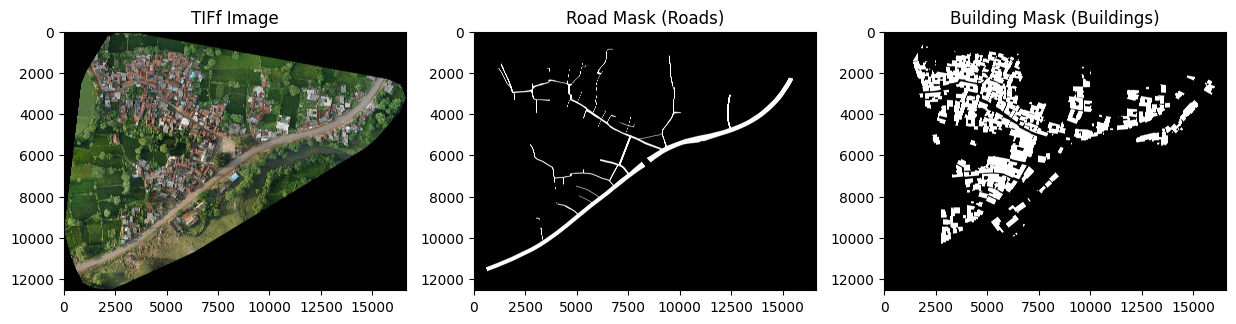

In [9]:
# Function to rasterize a shapefile

def rasterize_shape_file(shapefile_path, reference_raster_path, output_mask_path):
  #convert a shapefile to a tiff file

    shapefile_gdf = gpd.read_file(shapefile_path) # reading the file using geopandas

    with rasterio.open(reference_raster_path) as src:
        #getting the transform and other parameters
        transform = src.transform
        out_shape = (src.height, src.width)

        valid_geometries = [ geom for geom in shapefile_gdf.geometry if geom is not None ]
        rasterized_mask = features.rasterize(
            [ (mapping(geom), 1) for geom in valid_geometries],
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype='uint8'
        )

        # Saving the rasterize mask to a new TIFF file
        mask_meta = src.meta.copy()
        mask_meta.update({
            'driver': 'GTiff',
            'count': 1,
            'dtype': 'uint8',
            'height': out_shape[0],
            'width': out_shape[1],
            'transform': transform
        })

        with rasterio.open(output_mask_path, 'w', **mask_meta) as dst:
            dst.write(rasterized_mask, 1)

    print(f"Rasterized mask saved to {output_mask_path}")


# Rastrize the road shapefile
output_road_mask_path = '/kaggle/working/road_mask.tif'
rasterize_shape_file(road_shapefile_path, tiff_image_path, output_road_mask_path)

# Rasterize the buildings shapefile
output_building_mask_path = '/kaggle/working/building_mask.tif'
rasterize_shape_file(building_shapefile_path, tiff_image_path, output_building_mask_path)

  #visualize the original TIFF image and the generated mask
with rasterio.open(tiff_image_path) as img_src:
    tiff_image = img_src.read((1, 2, 3)) # Read RGB bands
    tiff_image = np.transpose(tiff_image, (1, 2, 0)) #(Height, width, channel)

with rasterio.open(output_road_mask_path) as road_mask_src:
    road_mask = road_mask_src.read(1)

with rasterio.open(output_building_mask_path) as building_mask_src:
    building_mask = building_mask_src.read(1)

 #plotting the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(tiff_image)
plt.title("TIFf Image")

plt.subplot(1, 3, 2)
plt.imshow(road_mask, cmap='gray')
plt.title("Road Mask (Roads)")

plt.subplot(1, 3, 3)
plt.imshow(building_mask, cmap='gray')
plt.title("Building Mask (Buildings)")

plt.show()

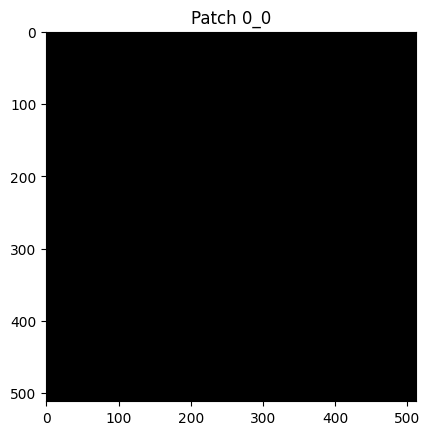

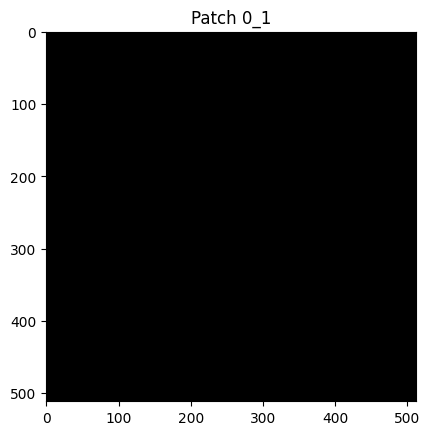

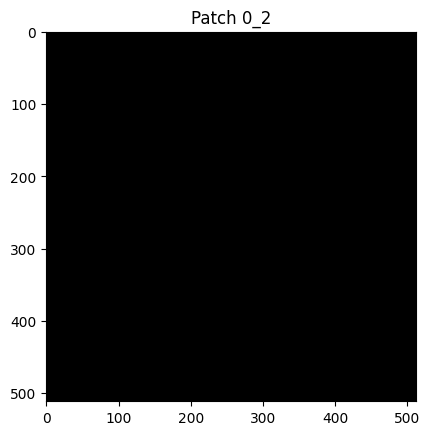

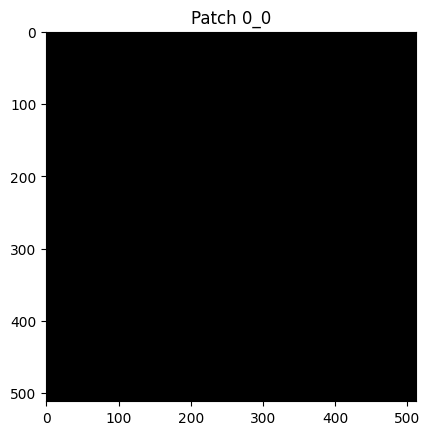

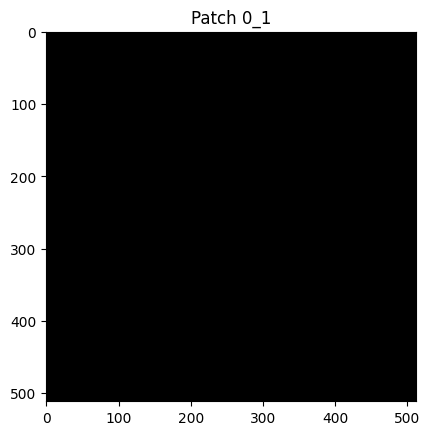

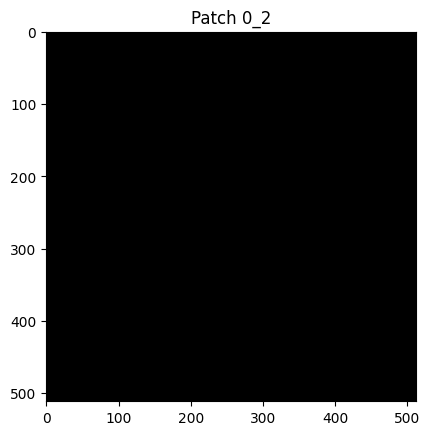

In [10]:
def slice_image(tiff_path, output_dir, patch_size=512):

    #slices a TiFF image into samller images

    with rasterio.open(tiff_path) as src:
        img_array = src.read(1) # Reading single Band
        img_width, img_height = src.width, src.height
        transform = src.transform

        #Determine the number if patches 
        num_patches_x = img_width // patch_size
        num_patches_y = img_height // patch_size

        os.makedirs(output_dir, exist_ok=True)

        for i in  range(num_patches_x):
            for j in range(num_patches_y):
                window = Window(i*patch_size, j*patch_size, patch_size, patch_size)

                #Read the window and write to a new file  
                patch = src.read(1, window=window)
                patch_meta = src.meta.copy()
                patch_meta.update({
                    "height": patch_size,
                    "width": patch_size,
                    "transform": rasterio.windows.transform(window, transform)
                })

                patch_filename = os.path.join(output_dir, f"patch_{i}_{j}.tif")
                with rasterio.open(patch_filename, 'w' , **patch_meta) as dst:
                    dst.write(patch, 1)


                #visualize a few patches
                if i == 0 and j < 3:
                    plt.figure()
                    plt.imshow(patch , cmap='gray')
                    plt.title(f"Patch {i}_{j}")
                    plt.show()

#Usage
slice_image('/kaggle/working/building_mask.tif', '/kaggle/working/patches/buildings')
slice_image('/kaggle/working/road_mask.tif', '/kaggle/working/patches/roads')                
        

In [16]:
#### Fixed Upsmpling issue nowupsamples to 512x512

# Import additional required libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

# ResUNet Architecture Components
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

class IdentityBlock(nn.Module):
    def __init__(self, channels):
        super(IdentityBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels)
        self.conv2 = ConvBlock(channels, channels)
        self.conv3 = ConvBlock(channels, channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        return out + identity

class ResUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ResUNet, self).__init__()
        
        # Initial layer now outputs 64 channels to match first decoder block
        self.initial_conv = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_activation = nn.ReLU()
        self.initial_maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.encoder_block1 = self._make_encoder_block(64, 64, num_repeats=3)
        self.encoder_block2 = self._make_encoder_block(64, 128, num_repeats=4)
        self.encoder_block3 = self._make_encoder_block(128, 256, num_repeats=6)
        self.encoder_block4 = self._make_encoder_block(256, 512, num_repeats=3)
        
        self.decoder_block4 = self._make_decoder_block(512, 256)
        self.decoder_block3 = self._make_decoder_block(256, 128)
        self.decoder_block2 = self._make_decoder_block(128, 64)
        self.decoder_block1 = self._make_decoder_block(64, 64)  # Keep same channel count
        self.decoder_block0 = self._make_decoder_block(64, 64)
        self.decoder_block_out = self._make_decoder_block(64, 64)

        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.final_activation = nn.Sigmoid()

    def _make_encoder_block(self, in_channels, out_channels, num_repeats):
        layers = []
        layers.append(ConvBlock(in_channels, out_channels, stride=2))
        for _ in range(num_repeats - 1):
            layers.append(IdentityBlock(out_channels))
        return nn.Sequential(*layers)

    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            ConvBlock(out_channels, out_channels),
            IdentityBlock(out_channels)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_activation(x)
        x0 = self.initial_maxpool(x)
        
        x1 = self.encoder_block1(x0)
        x2 = self.encoder_block2(x1)
        x3 = self.encoder_block3(x2)
        x4 = self.encoder_block4(x3)
        
        x = self.decoder_block4(x4) + x3
        x = self.decoder_block3(x) + x2
        x = self.decoder_block2(x) + x1
        x = self.decoder_block1(x) + x0
        x = self.decoder_block0(x)
        x = self.decoder_block_out(x)
        
        x = self.final_conv(x)
        x = self.final_activation(x)
        
        return x

# Improved patch creation function for both image and mask
def create_patches(image_path, mask_path, output_dir, patch_size=512):
    """Create patches from image and mask with proper RGB handling"""
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)
    
    print(f"Creating patches for {mask_path}...")
    with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
        # Read RGB bands
        img_data = img_src.read((1,2,3))
        mask_data = mask_src.read(1)
        
        # Normalize image data
        img_data = img_data.astype(np.float32) / 255.0
        
        height, width = img_src.height, img_src.width
        patches_created = 0
        
        for i in range(0, width - patch_size + 1, patch_size):
            for j in range(0, height - patch_size + 1, patch_size):
                # Extract patches
                image_patch = img_data[:, j:j+patch_size, i:i+patch_size]
                mask_patch = mask_data[j:j+patch_size, i:i+patch_size]
                
                # Verify patch size and content
                if (image_patch.shape[1:] == (patch_size, patch_size) and 
                    mask_patch.shape == (patch_size, patch_size) and 
                    np.any(mask_patch > 0)):  # Only save patches with features
                    
                    patch_name = f"patch_{i}_{j}"
                    np.save(os.path.join(output_dir, 'images', f"{patch_name}.npy"), image_patch)
                    np.save(os.path.join(output_dir, 'masks', f"{patch_name}.npy"), mask_patch)
                    patches_created += 1
        
        print(f"Created {patches_created} valid patches")

# Custom Dataset for GIS data
class GISDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.npy')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])
        
        # Load and prepare image
        image = np.load(img_path)
        mask = np.load(mask_path)
        
        # Ensure correct dimensions and types
        image = image.astype(np.float32)  # [3, 512, 512]
        mask = mask.astype(np.float32)    # [512, 512]
        
        # Convert to torch tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask

# Custom loss function for segmentation
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tp = (inputs * targets).sum()
        fp = ((1 - targets) * inputs).sum()
        fn = (targets * (1 - inputs)).sum()
        
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky



In [14]:
from torchsummary import summary

model = ResUNet(in_channels=3, out_channels=1).to("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(3, 512, 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         ConvBlock-4         [-1, 64, 256, 256]               0
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
        ConvBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [12]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for inputs, targets in pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Debug print
                print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
                
                optimizer.zero_grad()
                outputs = model(inputs)
                
                # Debug print
                print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
                
                # If shapes don't match, resize targets to match outputs
                if outputs.shape != targets.shape:
                    targets = F.interpolate(targets, size=(outputs.shape[2], outputs.shape[3]), mode='nearest')
                    print(f"Resized target shape: {targets.shape}")
                
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
# Function to combine road and building predictions
def predict_and_combine(road_model, building_model, image_path, device, patch_size=512):
    """
    Make predictions for both roads and buildings and combine them into a single image
    Roads will be shown in blue, buildings in red
    """
    road_model.eval()
    building_model.eval()
    
    with rasterio.open(image_path) as src:
        # Read RGB bands and normalize
        image = src.read((1,2,3))
        image = image.astype(np.float32) / 255.0
        height, width = src.height, src.width
        
        # Initialize output masks
        road_mask = np.zeros((height, width))
        building_mask = np.zeros((height, width))
        
        # Make predictions patch by patch
        for i in tqdm(range(0, width - patch_size + 1, patch_size)):
            for j in range(0, height - patch_size + 1, patch_size):
                # Extract patch
                patch = image[:, j:j+patch_size, i:i+patch_size]
                patch_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)
                
                # Predict roads and buildings
                with torch.no_grad():
                    road_pred = road_model(patch_tensor)
                    building_pred = building_model(patch_tensor)
                
                # Convert predictions to numpy and threshold
                road_pred = (road_pred.cpu().squeeze().numpy() > 0.5).astype(np.uint8)
                building_pred = (building_pred.cpu().squeeze().numpy() > 0.5).astype(np.uint8)
                
                # Add to full masks
                road_mask[j:j+patch_size, i:i+patch_size] = road_pred
                building_mask[j:j+patch_size, i:i+patch_size] = building_pred
        
        # Create RGB mask (Red for buildings, Blue for roads)
        combined_mask = np.zeros((height, width, 3), dtype=np.uint8)
        combined_mask[..., 2] = road_mask * 255      # Blue channel for roads
        combined_mask[..., 0] = building_mask * 255  # Red channel for buildings
        
        # Save the combined prediction
        output_path = '/kaggle/working/combined_prediction.tif'
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=3,
            dtype='uint8',
            crs=src.crs,
            transform=src.transform,
        ) as dst:
            dst.write(combined_mask.transpose(2, 0, 1))
        
        return combined_mask

In [ ]:
## adapted for the model with upsamling issues beacuse it outputs in 128x128 rather than the original input size of 512x512
def predict_and_combine(road_model, building_model, image_path, device, patch_size=512):
    """
    Make predictions for both roads and buildings and combine them into a single image
    Roads will be shown in blue, buildings in red
    """
    road_model.eval()
    building_model.eval()
    
    with rasterio.open(image_path) as src:
        # Read RGB bands and normalize
        image = src.read((1,2,3))
        image = image.astype(np.float32) / 255.0
        height, width = src.height, src.width
        
        # Initialize output masks
        road_mask = np.zeros((height, width))
        building_mask = np.zeros((height, width))
        
        # Make predictions patch by patch
        for i in tqdm(range(0, width - patch_size + 1, patch_size)):
            for j in range(0, height - patch_size + 1, patch_size):
                # Extract patch
                patch = image[:, j:j+patch_size, i:i+patch_size]
                patch_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)
                
                # Predict roads and buildings
                with torch.no_grad():
                    road_pred = road_model(patch_tensor)
                    building_pred = building_model(patch_tensor)
                
                # Convert predictions to numpy and threshold
                road_pred = (road_pred.cpu().squeeze().numpy() > 0.5).astype(np.uint8)
                building_pred = (building_pred.cpu().squeeze().numpy() > 0.5).astype(np.uint8)
                
                # The model outputs 128x128 predictions for 512x512 inputs
                road_mask[j:j+128, i:i+128] = road_pred
                building_mask[j:j+128, i:i+128] = building_pred
        
        # Create RGB mask (Red for buildings, Blue for roads)
        combined_mask = np.zeros((height, width, 3), dtype=np.uint8)
        combined_mask[..., 2] = road_mask * 255      # Blue channel for roads
        combined_mask[..., 0] = building_mask * 255  # Red channel for buildings
        
        # Save the combined prediction
        output_path = '/kaggle/working/combined_prediction.tif'
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=3,
            dtype='uint8',
            crs=src.crs,
            transform=src.transform,
        ) as dst:
            dst.write(combined_mask.transpose(2, 0, 1))
        
        return combined_mask

In [19]:
## testing (the first output run gave a blocky style output because of the 128 output size for 512 so we are resizing it now to oversome that issue)
def predict_and_combine(road_model, building_model, image_path, device, patch_size=512):
    """
    Make predictions for both roads and buildings and combine them into a single image
    Roads will be shown in blue, buildings in red
    """
    road_model.eval()
    building_model.eval()
    
    with rasterio.open(image_path) as src:
        # Read RGB bands and normalize
        image = src.read((1,2,3))
        image = image.astype(np.float32) / 255.0
        height, width = src.height, src.width
        
        # Initialize output masks
        road_mask = np.zeros((height, width))
        building_mask = np.zeros((height, width))
        
        # Make predictions patch by patch
        for i in tqdm(range(0, width - patch_size + 1, patch_size)):
            for j in range(0, height - patch_size + 1, patch_size):
                # Extract patch
                patch = image[:, j:j+patch_size, i:i+patch_size]
                patch_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)
                
                # Predict roads and buildings
                with torch.no_grad():
                    road_pred = road_model(patch_tensor)
                    building_pred = building_model(patch_tensor)
                
                # After getting predictions
                road_pred = (road_pred.cpu().squeeze().numpy() > 0.5).astype(np.uint8)
                building_pred = (building_pred.cpu().squeeze().numpy() > 0.5).astype(np.uint8)

                # Resize to match the patch size
                road_pred_resized = cv2.resize(road_pred, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)
                building_pred_resized = cv2.resize(building_pred, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)

                # Add to full masks
                road_mask[j:j+patch_size, i:i+patch_size] = road_pred_resized
                building_mask[j:j+patch_size, i:i+patch_size] = building_pred_resized
        
        # Create RGB mask (Red for buildings, Blue for roads)
        combined_mask = np.zeros((height, width, 3), dtype=np.uint8)
        combined_mask[..., 2] = road_mask * 255      # Blue channel for roads
        combined_mask[..., 0] = building_mask * 255  # Red channel for buildings
        
        # Save the combined prediction
        output_path = '/kaggle/working/combined_prediction.tif'
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=3,
            dtype='uint8',
            crs=src.crs,
            transform=src.transform,
        ) as dst:
            dst.write(combined_mask.transpose(2, 0, 1))
        
        return combined_mask

In [13]:
# Create patches from the TIFF image and masks
print("\nStep 1: Creating patches for training...")
os.makedirs('/kaggle/working/patches/roads', exist_ok=True)
os.makedirs('/kaggle/working/patches/buildings', exist_ok=True)

create_patches(tiff_image_path, output_road_mask_path, 
              '/kaggle/working/patches/roads')
create_patches(tiff_image_path, output_building_mask_path, 
              '/kaggle/working/patches/buildings')

# Create datasets and dataloaders
print("\nStep 2: Setting up data loaders...")
roads_dataset = GISDataset('/kaggle/working/patches/roads')
buildings_dataset = GISDataset('/kaggle/working/patches/buildings')

batch_size = 2  # Small batch size for memory efficiency
roads_loader = DataLoader(roads_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=2)
buildings_loader = DataLoader(buildings_dataset, batch_size=batch_size, 
                            shuffle=True, num_workers=2)

# Initialize and train models
print("\nStep 3: Training road detection model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Road model
road_model = ResUNet(in_channels=3, out_channels=1).to(device)
criterion = TverskyLoss(alpha=0.7, beta=0.3)  # Weight false negatives more for thin features like roads
optimizer = torch.optim.Adam(road_model.parameters(), lr=0.001)

# Training
train_model(road_model, roads_loader, criterion, optimizer, device, num_epochs=50)
torch.save(road_model.state_dict(), '/kaggle/working/road_model.pth')

# Building model
print("\nStep 4: Training building detection model...")
building_model = ResUNet(in_channels=3, out_channels=1).to(device)
criterion = TverskyLoss(alpha=0.5, beta=0.5)  # Equal weighting for buildings
optimizer = torch.optim.Adam(building_model.parameters(), lr=0.001)

# Training
train_model(building_model, buildings_loader, criterion, optimizer, device, num_epochs=50)
torch.save(building_model.state_dict(), '/kaggle/working/building_model.pth')

# Generate combined prediction
print("\nStep 5: Generating combined prediction...")
combined_result = predict_and_combine(
    road_model, 
    building_model, 
    tiff_image_path, 
    device
)

# Visualize results
plt.figure(figsize=(15, 15))
plt.imshow(combined_result)
plt.title('Combined Predictions\nRed: Buildings, Blue: Roads')
plt.axis('off')
plt.savefig('/kaggle/working/combined_prediction_visualization.png')
plt.show()

print("\nAll steps completed successfully!")


Step 1: Creating patches for training...
Creating patches for /kaggle/working/road_mask.tif...
Created 173 valid patches
Creating patches for /kaggle/working/building_mask.tif...
Created 259 valid patches

Step 2: Setting up data loaders...

Step 3: Training road detection model...
Using device: cpu


Epoch 1/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   1%|          | 1/87 [00:04<06:02,  4.22s/it, loss=0.93]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   2%|▏         | 2/87 [00:06<04:16,  3.02s/it, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   3%|▎         | 3/87 [00:08<03:22,  2.41s/it, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   5%|▍         | 4/87 [00:09<02:54,  2.10s/it, loss=0.742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   6%|▌         | 5/87 [00:11<02:38,  1.93s/it, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   7%|▋         | 6/87 [00:12<02:27,  1.82s/it, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   8%|▊         | 7/87 [00:14<02:19,  1.75s/it, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   9%|▉         | 8/87 [00:16<02:14,  1.70s/it, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  10%|█         | 9/87 [00:17<02:10,  1.67s/it, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  11%|█▏        | 10/87 [00:19<02:06,  1.64s/it, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  13%|█▎        | 11/87 [00:20<02:03,  1.63s/it, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  14%|█▍        | 12/87 [00:22<02:01,  1.62s/it, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  15%|█▍        | 13/87 [00:24<01:59,  1.61s/it, loss=0.588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  16%|█▌        | 14/87 [00:25<01:57,  1.61s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  17%|█▋        | 15/87 [00:27<01:57,  1.63s/it, loss=0.817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  18%|█▊        | 16/87 [00:28<01:55,  1.62s/it, loss=0.824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  20%|█▉        | 17/87 [00:30<01:52,  1.60s/it, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  21%|██        | 18/87 [00:32<01:50,  1.60s/it, loss=0.869]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  22%|██▏       | 19/87 [00:33<01:48,  1.60s/it, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  23%|██▎       | 20/87 [00:36<02:01,  1.81s/it, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  24%|██▍       | 21/87 [00:37<01:59,  1.81s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  25%|██▌       | 22/87 [00:39<01:52,  1.73s/it, loss=0.696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  26%|██▋       | 23/87 [00:40<01:48,  1.69s/it, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  28%|██▊       | 24/87 [00:42<01:44,  1.66s/it, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  29%|██▊       | 25/87 [00:44<01:41,  1.64s/it, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  30%|██▉       | 26/87 [00:45<01:38,  1.62s/it, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  31%|███       | 27/87 [00:47<01:37,  1.63s/it, loss=0.947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  32%|███▏      | 28/87 [00:48<01:35,  1.62s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  33%|███▎      | 29/87 [00:50<01:33,  1.61s/it, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  34%|███▍      | 30/87 [00:52<01:31,  1.61s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  36%|███▌      | 31/87 [00:53<01:29,  1.61s/it, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  37%|███▋      | 32/87 [00:55<01:28,  1.60s/it, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  38%|███▊      | 33/87 [00:57<01:27,  1.62s/it, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  39%|███▉      | 34/87 [00:58<01:25,  1.61s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  40%|████      | 35/87 [01:00<01:23,  1.60s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  41%|████▏     | 36/87 [01:01<01:21,  1.60s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  43%|████▎     | 37/87 [01:03<01:19,  1.59s/it, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  44%|████▎     | 38/87 [01:04<01:18,  1.59s/it, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  45%|████▍     | 39/87 [01:06<01:17,  1.61s/it, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  46%|████▌     | 40/87 [01:09<01:28,  1.88s/it, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  47%|████▋     | 41/87 [01:10<01:23,  1.81s/it, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  48%|████▊     | 42/87 [01:12<01:18,  1.74s/it, loss=0.67] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  49%|████▉     | 43/87 [01:13<01:14,  1.69s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  51%|█████     | 44/87 [01:15<01:11,  1.66s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  52%|█████▏    | 45/87 [01:17<01:09,  1.65s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  53%|█████▎    | 46/87 [01:18<01:06,  1.63s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  54%|█████▍    | 47/87 [01:20<01:04,  1.62s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  55%|█████▌    | 48/87 [01:21<01:02,  1.61s/it, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  56%|█████▋    | 49/87 [01:23<01:00,  1.60s/it, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  57%|█████▋    | 50/87 [01:25<00:59,  1.60s/it, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  59%|█████▊    | 51/87 [01:26<00:58,  1.61s/it, loss=0.45] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  60%|█████▉    | 52/87 [01:28<00:56,  1.60s/it, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  61%|██████    | 53/87 [01:29<00:54,  1.60s/it, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  62%|██████▏   | 54/87 [01:31<00:52,  1.59s/it, loss=0.775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  63%|██████▎   | 55/87 [01:33<00:50,  1.59s/it, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  64%|██████▍   | 56/87 [01:34<00:49,  1.58s/it, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  66%|██████▌   | 57/87 [01:36<00:48,  1.61s/it, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.60s/it, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  68%|██████▊   | 59/87 [01:39<00:44,  1.60s/it, loss=0.566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  69%|██████▉   | 60/87 [01:41<00:50,  1.87s/it, loss=0.699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  70%|███████   | 61/87 [01:43<00:46,  1.78s/it, loss=0.699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  71%|███████▏  | 62/87 [01:45<00:42,  1.72s/it, loss=0.943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  72%|███████▏  | 63/87 [01:46<00:40,  1.70s/it, loss=0.679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  74%|███████▎  | 64/87 [01:48<00:38,  1.66s/it, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  75%|███████▍  | 65/87 [01:49<00:35,  1.63s/it, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  76%|███████▌  | 66/87 [01:51<00:33,  1.61s/it, loss=0.525]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  77%|███████▋  | 67/87 [01:53<00:32,  1.60s/it, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  78%|███████▊  | 68/87 [01:54<00:30,  1.59s/it, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  79%|███████▉  | 69/87 [01:56<00:28,  1.59s/it, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  80%|████████  | 70/87 [01:57<00:27,  1.59s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  82%|████████▏ | 71/87 [01:59<00:25,  1.59s/it, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  83%|████████▎ | 72/87 [02:00<00:23,  1.58s/it, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  84%|████████▍ | 73/87 [02:02<00:22,  1.58s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  85%|████████▌ | 74/87 [02:04<00:20,  1.58s/it, loss=0.39] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.58s/it, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  87%|████████▋ | 76/87 [02:07<00:17,  1.60s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  89%|████████▊ | 77/87 [02:08<00:15,  1.59s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  90%|████████▉ | 78/87 [02:10<00:14,  1.59s/it, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  91%|█████████ | 79/87 [02:12<00:12,  1.60s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  92%|█████████▏| 80/87 [02:14<00:13,  1.89s/it, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  93%|█████████▎| 81/87 [02:16<00:10,  1.81s/it, loss=0.806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  94%|█████████▍| 82/87 [02:17<00:08,  1.74s/it, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  95%|█████████▌| 83/87 [02:19<00:06,  1.69s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  97%|█████████▋| 84/87 [02:21<00:04,  1.65s/it, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.63s/it, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  99%|█████████▉| 86/87 [02:24<00:01,  1.61s/it, loss=0.564]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 2/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   1%|          | 1/87 [00:03<04:28,  3.12s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   2%|▏         | 2/87 [00:04<03:09,  2.23s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   3%|▎         | 3/87 [00:06<02:42,  1.94s/it, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   5%|▍         | 4/87 [00:07<02:29,  1.80s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   6%|▌         | 5/87 [00:09<02:21,  1.72s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  10%|█         | 9/87 [00:15<02:06,  1.62s/it, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  11%|█▏        | 10/87 [00:17<02:03,  1.61s/it, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  13%|█▎        | 11/87 [00:19<02:01,  1.59s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  14%|█▍        | 12/87 [00:21<02:17,  1.83s/it, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  15%|█▍        | 13/87 [00:22<02:09,  1.75s/it, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  16%|█▌        | 14/87 [00:24<02:03,  1.70s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  17%|█▋        | 15/87 [00:26<01:59,  1.66s/it, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  18%|█▊        | 16/87 [00:27<01:56,  1.64s/it, loss=0.566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  20%|█▉        | 17/87 [00:29<01:53,  1.63s/it, loss=0.834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  21%|██        | 18/87 [00:30<01:51,  1.62s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  22%|██▏       | 19/87 [00:32<01:50,  1.62s/it, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  23%|██▎       | 20/87 [00:34<01:47,  1.61s/it, loss=0.778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  24%|██▍       | 21/87 [00:35<01:45,  1.60s/it, loss=0.588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  25%|██▌       | 22/87 [00:37<01:43,  1.60s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  26%|██▋       | 23/87 [00:38<01:41,  1.59s/it, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  28%|██▊       | 24/87 [00:40<01:40,  1.59s/it, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  29%|██▊       | 25/87 [00:42<01:39,  1.60s/it, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  30%|██▉       | 26/87 [00:43<01:37,  1.59s/it, loss=0.74] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  31%|███       | 27/87 [00:45<01:35,  1.59s/it, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  32%|███▏      | 28/87 [00:46<01:33,  1.59s/it, loss=0.874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  33%|███▎      | 29/87 [00:48<01:32,  1.59s/it, loss=0.848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  34%|███▍      | 30/87 [00:49<01:30,  1.58s/it, loss=0.851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  36%|███▌      | 31/87 [00:51<01:29,  1.60s/it, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  37%|███▋      | 32/87 [00:54<01:43,  1.89s/it, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  38%|███▊      | 33/87 [00:55<01:36,  1.80s/it, loss=0.784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  39%|███▉      | 34/87 [00:57<01:31,  1.73s/it, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  40%|████      | 35/87 [00:58<01:27,  1.69s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  41%|████▏     | 36/87 [01:00<01:24,  1.66s/it, loss=0.548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  43%|████▎     | 37/87 [01:02<01:22,  1.65s/it, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  44%|████▎     | 38/87 [01:03<01:19,  1.63s/it, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  45%|████▍     | 39/87 [01:05<01:17,  1.61s/it, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  46%|████▌     | 40/87 [01:06<01:15,  1.60s/it, loss=0.916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  47%|████▋     | 41/87 [01:08<01:13,  1.59s/it, loss=0.921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  48%|████▊     | 42/87 [01:10<01:11,  1.59s/it, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  49%|████▉     | 43/87 [01:11<01:10,  1.61s/it, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  51%|█████     | 44/87 [01:13<01:08,  1.60s/it, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  52%|█████▏    | 45/87 [01:14<01:07,  1.60s/it, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.60s/it, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  55%|█████▌    | 48/87 [01:19<01:02,  1.59s/it, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  56%|█████▋    | 49/87 [01:21<01:01,  1.61s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  57%|█████▋    | 50/87 [01:22<00:59,  1.60s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  59%|█████▊    | 51/87 [01:24<00:58,  1.62s/it, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  60%|█████▉    | 52/87 [01:27<01:06,  1.89s/it, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  61%|██████    | 53/87 [01:28<01:01,  1.79s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  62%|██████▏   | 54/87 [01:30<00:57,  1.73s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  63%|██████▎   | 55/87 [01:31<00:54,  1.70s/it, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  64%|██████▍   | 56/87 [01:33<00:51,  1.66s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  66%|██████▌   | 57/87 [01:34<00:49,  1.63s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.62s/it, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  68%|██████▊   | 59/87 [01:38<00:45,  1.61s/it, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.60s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  70%|███████   | 61/87 [01:41<00:42,  1.62s/it, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  71%|███████▏  | 62/87 [01:42<00:40,  1.60s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.60s/it, loss=0.689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.60s/it, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.59s/it, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  77%|███████▋  | 67/87 [01:50<00:31,  1.60s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.60s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.60s/it, loss=0.598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  80%|████████  | 70/87 [01:55<00:27,  1.59s/it, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.62s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  83%|████████▎ | 72/87 [01:59<00:28,  1.89s/it, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  84%|████████▍ | 73/87 [02:01<00:25,  1.82s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  85%|████████▌ | 74/87 [02:03<00:22,  1.75s/it, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  86%|████████▌ | 75/87 [02:04<00:20,  1.70s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  87%|████████▋ | 76/87 [02:06<00:18,  1.66s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  89%|████████▊ | 77/87 [02:07<00:16,  1.63s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  91%|█████████ | 79/87 [02:11<00:12,  1.62s/it, loss=0.86]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.60s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.59s/it, loss=0.829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.59s/it, loss=0.87] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.58s/it, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  97%|█████████▋| 84/87 [02:18<00:04,  1.57s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.57s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.58s/it, loss=0.122]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 3/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   1%|          | 1/87 [00:03<04:21,  3.04s/it, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   2%|▏         | 2/87 [00:04<03:06,  2.20s/it, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   3%|▎         | 3/87 [00:06<02:42,  1.94s/it, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   5%|▍         | 4/87 [00:08<02:52,  2.07s/it, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   6%|▌         | 5/87 [00:10<02:45,  2.01s/it, loss=0.821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   7%|▋         | 6/87 [00:12<02:31,  1.87s/it, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   8%|▊         | 7/87 [00:13<02:21,  1.77s/it, loss=0.865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   9%|▉         | 8/87 [00:15<02:15,  1.72s/it, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  10%|█         | 9/87 [00:16<02:10,  1.68s/it, loss=0.723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  11%|█▏        | 10/87 [00:18<02:07,  1.66s/it, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  13%|█▎        | 11/87 [00:20<02:04,  1.63s/it, loss=0.654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  14%|█▍        | 12/87 [00:21<02:01,  1.62s/it, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  15%|█▍        | 13/87 [00:23<01:58,  1.61s/it, loss=0.903]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  16%|█▌        | 14/87 [00:24<01:56,  1.60s/it, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  17%|█▋        | 15/87 [00:26<01:54,  1.59s/it, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  18%|█▊        | 16/87 [00:27<01:53,  1.60s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  20%|█▉        | 17/87 [00:29<01:51,  1.60s/it, loss=0.0491]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  21%|██        | 18/87 [00:31<01:49,  1.59s/it, loss=0.286] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  22%|██▏       | 19/87 [00:32<01:47,  1.59s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  23%|██▎       | 20/87 [00:34<01:46,  1.59s/it, loss=0.968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  24%|██▍       | 21/87 [00:35<01:44,  1.58s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  25%|██▌       | 22/87 [00:37<01:43,  1.59s/it, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  26%|██▋       | 23/87 [00:39<01:42,  1.60s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  28%|██▊       | 24/87 [00:41<01:52,  1.79s/it, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  29%|██▊       | 25/87 [00:43<01:53,  1.83s/it, loss=0.978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  30%|██▉       | 26/87 [00:44<01:46,  1.75s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  31%|███       | 27/87 [00:46<01:42,  1.70s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  32%|███▏      | 28/87 [00:48<01:39,  1.68s/it, loss=0.817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  33%|███▎      | 29/87 [00:49<01:35,  1.65s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  34%|███▍      | 30/87 [00:51<01:32,  1.62s/it, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  36%|███▌      | 31/87 [00:52<01:30,  1.62s/it, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  37%|███▋      | 32/87 [00:54<01:28,  1.61s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  38%|███▊      | 33/87 [00:55<01:26,  1.60s/it, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  39%|███▉      | 34/87 [00:57<01:24,  1.60s/it, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  40%|████      | 35/87 [00:59<01:23,  1.61s/it, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  41%|████▏     | 36/87 [01:00<01:21,  1.60s/it, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  43%|████▎     | 37/87 [01:02<01:19,  1.59s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  44%|████▎     | 38/87 [01:03<01:17,  1.59s/it, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  45%|████▍     | 39/87 [01:05<01:16,  1.58s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  46%|████▌     | 40/87 [01:07<01:14,  1.58s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  47%|████▋     | 41/87 [01:08<01:13,  1.59s/it, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  48%|████▊     | 42/87 [01:10<01:11,  1.58s/it, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  49%|████▉     | 43/87 [01:11<01:09,  1.58s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  51%|█████     | 44/87 [01:13<01:15,  1.75s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  52%|█████▏    | 45/87 [01:15<01:16,  1.83s/it, loss=0.718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  53%|█████▎    | 46/87 [01:17<01:11,  1.75s/it, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  54%|█████▍    | 47/87 [01:19<01:08,  1.71s/it, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  55%|█████▌    | 48/87 [01:20<01:05,  1.67s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  56%|█████▋    | 49/87 [01:22<01:02,  1.64s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  57%|█████▋    | 50/87 [01:23<01:00,  1.62s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  59%|█████▊    | 51/87 [01:25<00:58,  1.61s/it, loss=0.925]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  60%|█████▉    | 52/87 [01:27<00:55,  1.60s/it, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  61%|██████    | 53/87 [01:28<00:54,  1.61s/it, loss=0.8]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  62%|██████▏   | 54/87 [01:30<00:52,  1.60s/it, loss=0.603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.60s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.60s/it, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.59s/it, loss=0.838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.59s/it, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.60s/it, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.59s/it, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  70%|███████   | 61/87 [01:41<00:41,  1.58s/it, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  71%|███████▏  | 62/87 [01:42<00:39,  1.58s/it, loss=0.65] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  72%|███████▏  | 63/87 [01:44<00:37,  1.58s/it, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  74%|███████▎  | 64/87 [01:46<00:39,  1.73s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  75%|███████▍  | 65/87 [01:48<00:40,  1.85s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  76%|███████▌  | 66/87 [01:50<00:37,  1.77s/it, loss=0.664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  77%|███████▋  | 67/87 [01:51<00:34,  1.71s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  78%|███████▊  | 68/87 [01:53<00:31,  1.68s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.65s/it, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  80%|████████  | 70/87 [01:56<00:27,  1.63s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  82%|████████▏ | 71/87 [01:58<00:26,  1.63s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  83%|████████▎ | 72/87 [01:59<00:24,  1.61s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.59s/it, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.58s/it, loss=0.741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  86%|████████▌ | 75/87 [02:04<00:18,  1.58s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.58s/it, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.58s/it, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.60s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  91%|█████████ | 79/87 [02:10<00:12,  1.59s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.58s/it, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  93%|█████████▎| 81/87 [02:13<00:09,  1.57s/it, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.57s/it, loss=0.819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.57s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  97%|█████████▋| 84/87 [02:19<00:05,  1.67s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.82s/it, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.74s/it, loss=0.864]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 4/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   1%|          | 1/87 [00:03<04:26,  3.10s/it, loss=0.464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   2%|▏         | 2/87 [00:04<03:13,  2.28s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   3%|▎         | 3/87 [00:06<02:44,  1.96s/it, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   5%|▍         | 4/87 [00:07<02:30,  1.81s/it, loss=0.928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   6%|▌         | 5/87 [00:09<02:21,  1.73s/it, loss=0.87] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   7%|▋         | 6/87 [00:11<02:15,  1.68s/it, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   8%|▊         | 7/87 [00:12<02:12,  1.65s/it, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   9%|▉         | 8/87 [00:14<02:10,  1.65s/it, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  10%|█         | 9/87 [00:15<02:07,  1.63s/it, loss=0.963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  11%|█▏        | 10/87 [00:17<02:04,  1.61s/it, loss=0.582]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  14%|█▍        | 12/87 [00:20<02:00,  1.61s/it, loss=0.729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  15%|█▍        | 13/87 [00:22<01:58,  1.60s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  16%|█▌        | 14/87 [00:23<01:56,  1.60s/it, loss=0.926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  17%|█▋        | 15/87 [00:25<01:55,  1.61s/it, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  18%|█▊        | 16/87 [00:27<01:57,  1.66s/it, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  20%|█▉        | 17/87 [00:29<02:11,  1.88s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  21%|██        | 18/87 [00:31<02:03,  1.79s/it, loss=0.967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  22%|██▏       | 19/87 [00:32<01:57,  1.73s/it, loss=0.743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  23%|██▎       | 20/87 [00:34<01:53,  1.70s/it, loss=0.845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  24%|██▍       | 21/87 [00:36<01:50,  1.67s/it, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  25%|██▌       | 22/87 [00:37<01:46,  1.64s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  26%|██▋       | 23/87 [00:39<01:43,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  28%|██▊       | 24/87 [00:40<01:41,  1.61s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  29%|██▊       | 25/87 [00:42<01:39,  1.61s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  30%|██▉       | 26/87 [00:44<01:38,  1.61s/it, loss=0.0402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  31%|███       | 27/87 [00:45<01:36,  1.61s/it, loss=0.971] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  32%|███▏      | 28/87 [00:47<01:34,  1.60s/it, loss=0.0788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  33%|███▎      | 29/87 [00:48<01:32,  1.59s/it, loss=0.067] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  34%|███▍      | 30/87 [00:50<01:30,  1.58s/it, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  36%|███▌      | 31/87 [00:51<01:28,  1.58s/it, loss=0.588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  37%|███▋      | 32/87 [00:53<01:26,  1.57s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  38%|███▊      | 33/87 [00:55<01:25,  1.59s/it, loss=0.638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  39%|███▉      | 34/87 [00:56<01:24,  1.59s/it, loss=0.489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  40%|████      | 35/87 [00:58<01:22,  1.59s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  41%|████▏     | 36/87 [01:00<01:23,  1.64s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  43%|████▎     | 37/87 [01:02<01:31,  1.82s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  44%|████▎     | 38/87 [01:03<01:25,  1.75s/it, loss=0.0718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  45%|████▍     | 39/87 [01:05<01:22,  1.71s/it, loss=0.511] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  46%|████▌     | 40/87 [01:07<01:18,  1.67s/it, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  47%|████▋     | 41/87 [01:08<01:15,  1.64s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  48%|████▊     | 42/87 [01:10<01:13,  1.62s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  49%|████▉     | 43/87 [01:11<01:10,  1.61s/it, loss=0.86] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  51%|█████     | 44/87 [01:13<01:08,  1.60s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.61s/it, loss=0.647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.60s/it, loss=0.94] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  55%|█████▌    | 48/87 [01:19<01:02,  1.59s/it, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.59s/it, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  57%|█████▋    | 50/87 [01:22<00:58,  1.58s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.59s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  61%|██████    | 53/87 [01:27<00:53,  1.58s/it, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.58s/it, loss=0.511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  63%|██████▎   | 55/87 [01:30<00:50,  1.58s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  64%|██████▍   | 56/87 [01:32<00:51,  1.66s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  66%|██████▌   | 57/87 [01:35<00:56,  1.87s/it, loss=0.836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  67%|██████▋   | 58/87 [01:36<00:51,  1.78s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  68%|██████▊   | 59/87 [01:38<00:48,  1.72s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  69%|██████▉   | 60/87 [01:39<00:45,  1.68s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  70%|███████   | 61/87 [01:41<00:43,  1.65s/it, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  71%|███████▏  | 62/87 [01:42<00:40,  1.63s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  72%|███████▏  | 63/87 [01:44<00:39,  1.63s/it, loss=0.832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.61s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  77%|███████▋  | 67/87 [01:50<00:31,  1.59s/it, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.58s/it, loss=0.622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.59s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  80%|████████  | 70/87 [01:55<00:26,  1.59s/it, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.58s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  83%|████████▎ | 72/87 [01:58<00:23,  1.57s/it, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  84%|████████▍ | 73/87 [02:00<00:21,  1.57s/it, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  85%|████████▌ | 74/87 [02:01<00:20,  1.57s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  86%|████████▌ | 75/87 [02:03<00:18,  1.57s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.59s/it, loss=0.86] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  89%|████████▊ | 77/87 [02:07<00:18,  1.84s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  90%|████████▉ | 78/87 [02:10<00:18,  2.04s/it, loss=0.517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  91%|█████████ | 79/87 [02:12<00:16,  2.03s/it, loss=0.39] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  92%|█████████▏| 80/87 [02:13<00:13,  1.90s/it, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  93%|█████████▎| 81/87 [02:15<00:10,  1.83s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.75s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  95%|█████████▌| 83/87 [02:18<00:06,  1.70s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.66s/it, loss=0.928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.63s/it, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.62s/it, loss=0.639]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 5/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   1%|          | 1/87 [00:03<04:20,  3.03s/it, loss=0.12]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   2%|▏         | 2/87 [00:04<03:07,  2.20s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   3%|▎         | 3/87 [00:06<02:42,  1.93s/it, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   5%|▍         | 4/87 [00:07<02:31,  1.82s/it, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   7%|▋         | 6/87 [00:11<02:18,  1.72s/it, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   8%|▊         | 7/87 [00:12<02:16,  1.70s/it, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   9%|▉         | 8/87 [00:15<02:33,  1.95s/it, loss=0.608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  10%|█         | 9/87 [00:16<02:23,  1.83s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  11%|█▏        | 10/87 [00:18<02:15,  1.76s/it, loss=0.871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  13%|█▎        | 11/87 [00:20<02:10,  1.72s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  14%|█▍        | 12/87 [00:21<02:06,  1.68s/it, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  15%|█▍        | 13/87 [00:23<02:01,  1.65s/it, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  16%|█▌        | 14/87 [00:24<01:58,  1.63s/it, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  17%|█▋        | 15/87 [00:26<01:56,  1.62s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  18%|█▊        | 16/87 [00:28<01:53,  1.60s/it, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  20%|█▉        | 17/87 [00:29<01:52,  1.61s/it, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  21%|██        | 18/87 [00:31<01:51,  1.61s/it, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  22%|██▏       | 19/87 [00:32<01:49,  1.60s/it, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  23%|██▎       | 20/87 [00:34<01:46,  1.59s/it, loss=0.618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  24%|██▍       | 21/87 [00:36<01:45,  1.59s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  25%|██▌       | 22/87 [00:37<01:43,  1.59s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  26%|██▋       | 23/87 [00:39<01:41,  1.58s/it, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  28%|██▊       | 24/87 [00:40<01:40,  1.59s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  29%|██▊       | 25/87 [00:42<01:38,  1.58s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  30%|██▉       | 26/87 [00:43<01:36,  1.58s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  31%|███       | 27/87 [00:45<01:36,  1.61s/it, loss=0.0544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  32%|███▏      | 28/87 [00:48<01:50,  1.87s/it, loss=0.977] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  33%|███▎      | 29/87 [00:49<01:43,  1.79s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  34%|███▍      | 30/87 [00:51<01:39,  1.74s/it, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  36%|███▌      | 31/87 [00:52<01:35,  1.70s/it, loss=0.893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  37%|███▋      | 32/87 [00:54<01:31,  1.66s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  38%|███▊      | 33/87 [00:56<01:28,  1.64s/it, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  39%|███▉      | 34/87 [00:57<01:25,  1.62s/it, loss=0.272] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  40%|████      | 35/87 [00:59<01:23,  1.61s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  41%|████▏     | 36/87 [01:00<01:22,  1.62s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  43%|████▎     | 37/87 [01:02<01:20,  1.61s/it, loss=0.15]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  44%|████▎     | 38/87 [01:04<01:18,  1.60s/it, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  45%|████▍     | 39/87 [01:05<01:16,  1.60s/it, loss=0.0558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  46%|████▌     | 40/87 [01:07<01:14,  1.59s/it, loss=0.691] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  47%|████▋     | 41/87 [01:08<01:13,  1.59s/it, loss=0.753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  48%|████▊     | 42/87 [01:10<01:12,  1.60s/it, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  49%|████▉     | 43/87 [01:11<01:10,  1.60s/it, loss=0.566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  51%|█████     | 44/87 [01:13<01:08,  1.59s/it, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  52%|█████▏    | 45/87 [01:15<01:06,  1.58s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  53%|█████▎    | 46/87 [01:16<01:04,  1.58s/it, loss=0.603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  54%|█████▍    | 47/87 [01:18<01:04,  1.61s/it, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  55%|█████▌    | 48/87 [01:20<01:13,  1.88s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  56%|█████▋    | 49/87 [01:22<01:07,  1.79s/it, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  57%|█████▋    | 50/87 [01:24<01:03,  1.73s/it, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  59%|█████▊    | 51/87 [01:25<01:00,  1.68s/it, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  60%|█████▉    | 52/87 [01:27<00:57,  1.65s/it, loss=0.818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  61%|██████    | 53/87 [01:28<00:55,  1.63s/it, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  62%|██████▏   | 54/87 [01:30<00:53,  1.63s/it, loss=0.739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.61s/it, loss=0.688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.60s/it, loss=0.669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.59s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.58s/it, loss=0.695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  69%|██████▉   | 60/87 [01:39<00:42,  1.59s/it, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  70%|███████   | 61/87 [01:41<00:41,  1.59s/it, loss=0.953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  71%|███████▏  | 62/87 [01:43<00:39,  1.58s/it, loss=0.947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.59s/it, loss=0.555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.59s/it, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  75%|███████▍  | 65/87 [01:47<00:34,  1.59s/it, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  78%|███████▊  | 68/87 [01:53<00:36,  1.91s/it, loss=0.978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  79%|███████▉  | 69/87 [01:55<00:32,  1.81s/it, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  80%|████████  | 70/87 [01:56<00:29,  1.75s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  82%|████████▏ | 71/87 [01:58<00:27,  1.70s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  83%|████████▎ | 72/87 [02:00<00:25,  1.69s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  84%|████████▍ | 73/87 [02:01<00:23,  1.66s/it, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  85%|████████▌ | 74/87 [02:03<00:21,  1.64s/it, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.62s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.61s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.60s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.60s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  91%|█████████ | 79/87 [02:11<00:12,  1.61s/it, loss=0.508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.60s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.59s/it, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.59s/it, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.59s/it, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.59s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.60s/it, loss=0.95] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.59s/it, loss=0.0581]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 6/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   1%|          | 1/87 [00:03<05:43,  3.99s/it, loss=0.85]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   2%|▏         | 2/87 [00:05<03:40,  2.59s/it, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   3%|▎         | 3/87 [00:07<03:03,  2.19s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   5%|▍         | 4/87 [00:08<02:42,  1.95s/it, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   6%|▌         | 5/87 [00:10<02:29,  1.82s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   7%|▋         | 6/87 [00:12<02:21,  1.74s/it, loss=0.782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   8%|▊         | 7/87 [00:13<02:15,  1.70s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   9%|▉         | 8/87 [00:15<02:11,  1.67s/it, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  10%|█         | 9/87 [00:16<02:09,  1.66s/it, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  11%|█▏        | 10/87 [00:18<02:06,  1.64s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  13%|█▎        | 11/87 [00:20<02:03,  1.62s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  14%|█▍        | 12/87 [00:21<02:00,  1.61s/it, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  15%|█▍        | 13/87 [00:23<01:58,  1.60s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  16%|█▌        | 14/87 [00:24<01:56,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  17%|█▋        | 15/87 [00:26<01:55,  1.61s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  18%|█▊        | 16/87 [00:28<01:53,  1.60s/it, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  20%|█▉        | 17/87 [00:29<01:51,  1.59s/it, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  21%|██        | 18/87 [00:31<01:49,  1.59s/it, loss=0.539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  22%|██▏       | 19/87 [00:32<01:48,  1.59s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  23%|██▎       | 20/87 [00:35<02:02,  1.82s/it, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  24%|██▍       | 21/87 [00:37<02:01,  1.85s/it, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  25%|██▌       | 22/87 [00:38<01:54,  1.77s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  26%|██▋       | 23/87 [00:40<01:49,  1.72s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  28%|██▊       | 24/87 [00:41<01:45,  1.68s/it, loss=0.39] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  29%|██▊       | 25/87 [00:43<01:42,  1.65s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  30%|██▉       | 26/87 [00:45<01:39,  1.63s/it, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  31%|███       | 27/87 [00:46<01:38,  1.64s/it, loss=0.313] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  32%|███▏      | 28/87 [00:48<01:35,  1.62s/it, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  33%|███▎      | 29/87 [00:49<01:33,  1.62s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  34%|███▍      | 30/87 [00:51<01:31,  1.61s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  36%|███▌      | 31/87 [00:53<01:29,  1.61s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  37%|███▋      | 32/87 [00:54<01:28,  1.60s/it, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  38%|███▊      | 33/87 [00:56<01:26,  1.60s/it, loss=0.742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  39%|███▉      | 34/87 [00:57<01:25,  1.61s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  40%|████      | 35/87 [00:59<01:23,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  41%|████▏     | 36/87 [01:01<01:21,  1.60s/it, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  43%|████▎     | 37/87 [01:02<01:19,  1.60s/it, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  44%|████▎     | 38/87 [01:04<01:18,  1.59s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  45%|████▍     | 39/87 [01:05<01:16,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  46%|████▌     | 40/87 [01:08<01:28,  1.88s/it, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  47%|████▋     | 41/87 [01:10<01:23,  1.82s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  48%|████▊     | 42/87 [01:11<01:18,  1.74s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  49%|████▉     | 43/87 [01:13<01:14,  1.70s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  51%|█████     | 44/87 [01:14<01:11,  1.67s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  52%|█████▏    | 45/87 [01:16<01:09,  1.66s/it, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  53%|█████▎    | 46/87 [01:18<01:07,  1.64s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  54%|█████▍    | 47/87 [01:19<01:05,  1.63s/it, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  55%|█████▌    | 48/87 [01:21<01:03,  1.62s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  56%|█████▋    | 49/87 [01:22<01:00,  1.61s/it, loss=0.0694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  57%|█████▋    | 50/87 [01:24<00:59,  1.60s/it, loss=0.407] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  59%|█████▊    | 51/87 [01:26<00:57,  1.60s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  60%|█████▉    | 52/87 [01:27<00:56,  1.61s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  61%|██████    | 53/87 [01:29<00:54,  1.60s/it, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  62%|██████▏   | 54/87 [01:30<00:52,  1.59s/it, loss=0.508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  63%|██████▎   | 55/87 [01:32<00:50,  1.59s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.59s/it, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.59s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.61s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.60s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  69%|██████▉   | 60/87 [01:41<00:51,  1.91s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  70%|███████   | 61/87 [01:43<00:47,  1.82s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  71%|███████▏  | 62/87 [01:44<00:43,  1.75s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  72%|███████▏  | 63/87 [01:46<00:41,  1.71s/it, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  74%|███████▎  | 64/87 [01:47<00:38,  1.69s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  75%|███████▍  | 65/87 [01:49<00:36,  1.66s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  76%|███████▌  | 66/87 [01:51<00:34,  1.64s/it, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  77%|███████▋  | 67/87 [01:52<00:32,  1.64s/it, loss=0.442] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  78%|███████▊  | 68/87 [01:54<00:31,  1.63s/it, loss=0.695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.63s/it, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  80%|████████  | 70/87 [01:57<00:27,  1.63s/it, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  82%|████████▏ | 71/87 [01:59<00:25,  1.62s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.61s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  84%|████████▍ | 73/87 [02:02<00:22,  1.60s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.60s/it, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.59s/it, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  87%|████████▋ | 76/87 [02:07<00:17,  1.62s/it, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.61s/it, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  90%|████████▉ | 78/87 [02:10<00:14,  1.61s/it, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  91%|█████████ | 79/87 [02:12<00:13,  1.64s/it, loss=0.962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  92%|█████████▏| 80/87 [02:14<00:12,  1.80s/it, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  93%|█████████▎| 81/87 [02:15<00:10,  1.74s/it, loss=0.998] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  94%|█████████▍| 82/87 [02:17<00:08,  1.71s/it, loss=0.804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  95%|█████████▌| 83/87 [02:19<00:06,  1.67s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.63s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.62s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.60s/it, loss=0.22] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 7/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   1%|          | 1/87 [00:03<04:33,  3.18s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   2%|▏         | 2/87 [00:04<03:12,  2.26s/it, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   3%|▎         | 3/87 [00:06<02:43,  1.95s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   5%|▍         | 4/87 [00:07<02:29,  1.81s/it, loss=0.718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   6%|▌         | 5/87 [00:09<02:21,  1.72s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   7%|▋         | 6/87 [00:11<02:15,  1.67s/it, loss=0.947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   8%|▊         | 7/87 [00:12<02:12,  1.66s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   9%|▉         | 8/87 [00:14<02:09,  1.63s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  10%|█         | 9/87 [00:15<02:06,  1.62s/it, loss=0.076]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  11%|█▏        | 10/87 [00:17<02:04,  1.62s/it, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  13%|█▎        | 11/87 [00:19<02:03,  1.63s/it, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  14%|█▍        | 12/87 [00:21<02:23,  1.92s/it, loss=0.953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  15%|█▍        | 13/87 [00:23<02:14,  1.82s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  16%|█▌        | 14/87 [00:24<02:08,  1.76s/it, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  17%|█▋        | 15/87 [00:26<02:03,  1.71s/it, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  18%|█▊        | 16/87 [00:28<01:59,  1.68s/it, loss=0.742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  20%|█▉        | 17/87 [00:29<01:55,  1.65s/it, loss=0.713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  21%|██        | 18/87 [00:31<01:52,  1.63s/it, loss=0.649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  22%|██▏       | 19/87 [00:32<01:51,  1.63s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  23%|██▎       | 20/87 [00:34<01:48,  1.62s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  24%|██▍       | 21/87 [00:36<01:46,  1.61s/it, loss=0.933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  25%|██▌       | 22/87 [00:37<01:44,  1.60s/it, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  26%|██▋       | 23/87 [00:39<01:41,  1.59s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  28%|██▊       | 24/87 [00:40<01:39,  1.59s/it, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  29%|██▊       | 25/87 [00:42<01:39,  1.61s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  30%|██▉       | 26/87 [00:44<01:37,  1.60s/it, loss=0.567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  31%|███       | 27/87 [00:45<01:35,  1.59s/it, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  32%|███▏      | 28/87 [00:47<01:33,  1.59s/it, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  33%|███▎      | 29/87 [00:48<01:31,  1.59s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  34%|███▍      | 30/87 [00:50<01:30,  1.58s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  36%|███▌      | 31/87 [00:52<01:31,  1.64s/it, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  37%|███▋      | 32/87 [00:54<01:43,  1.89s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  38%|███▊      | 33/87 [00:56<01:37,  1.80s/it, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  39%|███▉      | 34/87 [00:57<01:31,  1.73s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  40%|████      | 35/87 [00:59<01:27,  1.68s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  41%|████▏     | 36/87 [01:00<01:24,  1.65s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  43%|████▎     | 37/87 [01:02<01:22,  1.64s/it, loss=0.598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  44%|████▎     | 38/87 [01:04<01:19,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  45%|████▍     | 39/87 [01:05<01:17,  1.61s/it, loss=0.723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  46%|████▌     | 40/87 [01:07<01:15,  1.60s/it, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  47%|████▋     | 41/87 [01:08<01:13,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  48%|████▊     | 42/87 [01:10<01:11,  1.59s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  49%|████▉     | 43/87 [01:12<01:10,  1.61s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  51%|█████     | 44/87 [01:13<01:09,  1.61s/it, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.60s/it, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.59s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  55%|█████▌    | 48/87 [01:20<01:01,  1.59s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  59%|█████▊    | 51/87 [01:24<00:58,  1.62s/it, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  60%|█████▉    | 52/87 [01:27<01:06,  1.89s/it, loss=0.758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  61%|██████    | 53/87 [01:29<01:01,  1.80s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  62%|██████▏   | 54/87 [01:30<00:57,  1.74s/it, loss=0.0802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  63%|██████▎   | 55/87 [01:32<00:54,  1.71s/it, loss=0.599] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  64%|██████▍   | 56/87 [01:33<00:51,  1.67s/it, loss=0.0621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  66%|██████▌   | 57/87 [01:35<00:49,  1.64s/it, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.62s/it, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  68%|██████▊   | 59/87 [01:38<00:45,  1.61s/it, loss=0.0614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.60s/it, loss=0.797] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  70%|███████   | 61/87 [01:41<00:41,  1.61s/it, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.61s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  72%|███████▏  | 63/87 [01:45<00:41,  1.74s/it, loss=0.962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  74%|███████▎  | 64/87 [01:47<00:38,  1.69s/it, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  75%|███████▍  | 65/87 [01:48<00:36,  1.66s/it, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  76%|███████▌  | 66/87 [01:50<00:34,  1.63s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.63s/it, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  78%|███████▊  | 68/87 [01:53<00:30,  1.62s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  79%|███████▉  | 69/87 [01:55<00:28,  1.61s/it, loss=0.761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  80%|████████  | 70/87 [01:56<00:27,  1.60s/it, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  82%|████████▏ | 71/87 [01:58<00:27,  1.72s/it, loss=0.663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  83%|████████▎ | 72/87 [02:00<00:27,  1.85s/it, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  84%|████████▍ | 73/87 [02:02<00:25,  1.79s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  85%|████████▌ | 74/87 [02:04<00:22,  1.73s/it, loss=0.959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  86%|████████▌ | 75/87 [02:05<00:20,  1.69s/it, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  87%|████████▋ | 76/87 [02:07<00:18,  1.66s/it, loss=0.729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.64s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  90%|████████▉ | 78/87 [02:10<00:14,  1.63s/it, loss=0.887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  91%|█████████ | 79/87 [02:12<00:13,  1.64s/it, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.63s/it, loss=0.582]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  93%|█████████▎| 81/87 [02:15<00:09,  1.62s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.61s/it, loss=0.575]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  95%|█████████▌| 83/87 [02:18<00:06,  1.61s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.60s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.60s/it, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.59s/it, loss=0.942]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 8/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:   1%|          | 1/87 [00:03<04:21,  3.04s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:   2%|▏         | 2/87 [00:04<03:07,  2.21s/it, loss=0.0721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:   3%|▎         | 3/87 [00:06<02:46,  1.99s/it, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:   5%|▍         | 4/87 [00:09<03:05,  2.24s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:   6%|▌         | 5/87 [00:10<02:43,  2.00s/it, loss=0.635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:   7%|▋         | 6/87 [00:12<02:31,  1.87s/it, loss=0.514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:   8%|▊         | 7/87 [00:13<02:22,  1.78s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:   9%|▉         | 8/87 [00:15<02:16,  1.73s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  10%|█         | 9/87 [00:17<02:12,  1.70s/it, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  11%|█▏        | 10/87 [00:18<02:10,  1.70s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  13%|█▎        | 11/87 [00:20<02:07,  1.68s/it, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  14%|█▍        | 12/87 [00:22<02:04,  1.66s/it, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  15%|█▍        | 13/87 [00:23<02:02,  1.65s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  16%|█▌        | 14/87 [00:25<01:59,  1.64s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  17%|█▋        | 15/87 [00:26<01:57,  1.64s/it, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  18%|█▊        | 16/87 [00:28<01:56,  1.65s/it, loss=0.81] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  20%|█▉        | 17/87 [00:30<01:54,  1.64s/it, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  21%|██        | 18/87 [00:31<01:52,  1.63s/it, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  22%|██▏       | 19/87 [00:33<01:51,  1.63s/it, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  23%|██▎       | 20/87 [00:35<01:49,  1.63s/it, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  24%|██▍       | 21/87 [00:36<01:47,  1.63s/it, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  25%|██▌       | 22/87 [00:38<01:46,  1.64s/it, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  26%|██▋       | 23/87 [00:40<01:56,  1.82s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  28%|██▊       | 24/87 [00:42<01:54,  1.82s/it, loss=0.845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  29%|██▊       | 25/87 [00:44<01:49,  1.76s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  30%|██▉       | 26/87 [00:45<01:44,  1.71s/it, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  31%|███       | 27/87 [00:47<01:40,  1.68s/it, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  32%|███▏      | 28/87 [00:48<01:38,  1.67s/it, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  33%|███▎      | 29/87 [00:50<01:35,  1.65s/it, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  34%|███▍      | 30/87 [00:52<01:33,  1.64s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  36%|███▌      | 31/87 [00:53<01:31,  1.63s/it, loss=0.0478]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  37%|███▋      | 32/87 [00:55<01:29,  1.62s/it, loss=0.989] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  38%|███▊      | 33/87 [00:56<01:26,  1.60s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  39%|███▉      | 34/87 [00:58<01:25,  1.61s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  40%|████      | 35/87 [01:00<01:23,  1.61s/it, loss=0.0696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  41%|████▏     | 36/87 [01:01<01:22,  1.61s/it, loss=0.946] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  43%|████▎     | 37/87 [01:03<01:20,  1.61s/it, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  44%|████▎     | 38/87 [01:04<01:18,  1.61s/it, loss=0.702] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  45%|████▍     | 39/87 [01:06<01:17,  1.61s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  46%|████▌     | 40/87 [01:08<01:16,  1.63s/it, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  47%|████▋     | 41/87 [01:09<01:14,  1.63s/it, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  48%|████▊     | 42/87 [01:11<01:12,  1.62s/it, loss=0.737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  49%|████▉     | 43/87 [01:14<01:24,  1.93s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  51%|█████     | 44/87 [01:15<01:18,  1.83s/it, loss=0.688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  52%|█████▏    | 45/87 [01:17<01:14,  1.77s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  53%|█████▎    | 46/87 [01:18<01:10,  1.73s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  54%|█████▍    | 47/87 [01:20<01:07,  1.69s/it, loss=0.0834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  55%|█████▌    | 48/87 [01:22<01:05,  1.67s/it, loss=0.75]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  56%|█████▋    | 49/87 [01:23<01:02,  1.65s/it, loss=0.872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  57%|█████▋    | 50/87 [01:25<01:00,  1.64s/it, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  59%|█████▊    | 51/87 [01:27<00:58,  1.63s/it, loss=0.537] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  60%|█████▉    | 52/87 [01:28<00:57,  1.63s/it, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  61%|██████    | 53/87 [01:30<00:54,  1.62s/it, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  62%|██████▏   | 54/87 [01:31<00:53,  1.61s/it, loss=0.89] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  63%|██████▎   | 55/87 [01:33<00:51,  1.61s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  64%|██████▍   | 56/87 [01:35<00:49,  1.60s/it, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  66%|██████▌   | 57/87 [01:36<00:48,  1.60s/it, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  67%|██████▋   | 58/87 [01:38<00:46,  1.62s/it, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  68%|██████▊   | 59/87 [01:39<00:45,  1.61s/it, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  69%|██████▉   | 60/87 [01:41<00:43,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  70%|███████   | 61/87 [01:43<00:41,  1.60s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  71%|███████▏  | 62/87 [01:44<00:40,  1.63s/it, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  72%|███████▏  | 63/87 [01:47<00:43,  1.82s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  74%|███████▎  | 64/87 [01:48<00:40,  1.77s/it, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  75%|███████▍  | 65/87 [01:50<00:37,  1.72s/it, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  76%|███████▌  | 66/87 [01:51<00:35,  1.69s/it, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  77%|███████▋  | 67/87 [01:53<00:33,  1.66s/it, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  78%|███████▊  | 68/87 [01:55<00:31,  1.64s/it, loss=0.799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  79%|███████▉  | 69/87 [01:56<00:29,  1.63s/it, loss=0.79] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  80%|████████  | 70/87 [01:58<00:27,  1.64s/it, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  82%|████████▏ | 71/87 [01:59<00:26,  1.63s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  83%|████████▎ | 72/87 [02:01<00:24,  1.61s/it, loss=0.19]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  84%|████████▍ | 73/87 [02:03<00:22,  1.62s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  85%|████████▌ | 74/87 [02:04<00:20,  1.61s/it, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  86%|████████▌ | 75/87 [02:06<00:19,  1.61s/it, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  87%|████████▋ | 76/87 [02:08<00:17,  1.62s/it, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  89%|████████▊ | 77/87 [02:09<00:16,  1.62s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  90%|████████▉ | 78/87 [02:11<00:14,  1.62s/it, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  91%|█████████ | 79/87 [02:12<00:12,  1.61s/it, loss=0.93] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  92%|█████████▏| 80/87 [02:14<00:11,  1.61s/it, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  93%|█████████▎| 81/87 [02:16<00:09,  1.60s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  94%|█████████▍| 82/87 [02:18<00:08,  1.78s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  95%|█████████▌| 83/87 [02:20<00:07,  1.80s/it, loss=0.0931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  97%|█████████▋| 84/87 [02:21<00:05,  1.74s/it, loss=0.511] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  98%|█████████▊| 85/87 [02:23<00:03,  1.70s/it, loss=0.915]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 8/50:  99%|█████████▉| 86/87 [02:24<00:01,  1.67s/it, loss=0.922]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 9/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:   1%|          | 1/87 [00:03<04:27,  3.11s/it, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:   2%|▏         | 2/87 [00:04<03:15,  2.30s/it, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:   3%|▎         | 3/87 [00:06<02:46,  1.98s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:   5%|▍         | 4/87 [00:08<02:32,  1.84s/it, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:   6%|▌         | 5/87 [00:09<02:23,  1.75s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:   8%|▊         | 7/87 [00:12<02:15,  1.69s/it, loss=0.926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:   9%|▉         | 8/87 [00:14<02:11,  1.66s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  10%|█         | 9/87 [00:16<02:08,  1.64s/it, loss=0.0978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  11%|█▏        | 10/87 [00:17<02:05,  1.63s/it, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  14%|█▍        | 12/87 [00:20<02:00,  1.61s/it, loss=0.514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  15%|█▍        | 13/87 [00:22<01:59,  1.62s/it, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  16%|█▌        | 14/87 [00:24<02:11,  1.80s/it, loss=0.813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  17%|█▋        | 15/87 [00:26<02:13,  1.85s/it, loss=0.911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  18%|█▊        | 16/87 [00:28<02:06,  1.78s/it, loss=0.913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  20%|█▉        | 17/87 [00:29<02:01,  1.73s/it, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  21%|██        | 18/87 [00:31<01:57,  1.71s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  22%|██▏       | 19/87 [00:33<01:53,  1.68s/it, loss=0.577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  23%|██▎       | 20/87 [00:34<01:50,  1.65s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  24%|██▍       | 21/87 [00:36<01:48,  1.64s/it, loss=0.538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  25%|██▌       | 22/87 [00:38<01:45,  1.63s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  26%|██▋       | 23/87 [00:39<01:43,  1.62s/it, loss=0.903]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  28%|██▊       | 24/87 [00:41<01:41,  1.61s/it, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  29%|██▊       | 25/87 [00:42<01:40,  1.62s/it, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  30%|██▉       | 26/87 [00:44<01:38,  1.61s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  31%|███       | 27/87 [00:46<01:36,  1.60s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  32%|███▏      | 28/87 [00:47<01:34,  1.60s/it, loss=0.445] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  33%|███▎      | 29/87 [00:49<01:32,  1.60s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  36%|███▌      | 31/87 [00:52<01:30,  1.62s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  37%|███▋      | 32/87 [00:54<01:28,  1.61s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  38%|███▊      | 33/87 [00:55<01:26,  1.60s/it, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  39%|███▉      | 34/87 [00:58<01:39,  1.87s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  40%|████      | 35/87 [00:59<01:35,  1.83s/it, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  41%|████▏     | 36/87 [01:01<01:30,  1.77s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  43%|████▎     | 37/87 [01:03<01:26,  1.72s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  44%|████▎     | 38/87 [01:04<01:22,  1.68s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  45%|████▍     | 39/87 [01:06<01:19,  1.65s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  46%|████▌     | 40/87 [01:07<01:16,  1.63s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  47%|████▋     | 41/87 [01:09<01:14,  1.62s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  48%|████▊     | 42/87 [01:11<01:12,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  49%|████▉     | 43/87 [01:12<01:11,  1.62s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  51%|█████     | 44/87 [01:14<01:09,  1.62s/it, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.61s/it, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  53%|█████▎    | 46/87 [01:17<01:05,  1.61s/it, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  54%|█████▍    | 47/87 [01:19<01:04,  1.60s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.60s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  56%|█████▋    | 49/87 [01:22<01:01,  1.62s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  57%|█████▋    | 50/87 [01:23<00:59,  1.62s/it, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  59%|█████▊    | 51/87 [01:25<00:58,  1.62s/it, loss=0.665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  60%|█████▉    | 52/87 [01:27<00:56,  1.62s/it, loss=0.584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  61%|██████    | 53/87 [01:28<00:55,  1.63s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  62%|██████▏   | 54/87 [01:31<01:03,  1.93s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  63%|██████▎   | 55/87 [01:33<00:58,  1.83s/it, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  64%|██████▍   | 56/87 [01:34<00:54,  1.76s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  66%|██████▌   | 57/87 [01:36<00:51,  1.71s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  67%|██████▋   | 58/87 [01:37<00:48,  1.69s/it, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  68%|██████▊   | 59/87 [01:39<00:46,  1.67s/it, loss=0.681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  69%|██████▉   | 60/87 [01:41<00:44,  1.65s/it, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  70%|███████   | 61/87 [01:42<00:43,  1.66s/it, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  71%|███████▏  | 62/87 [01:44<00:41,  1.64s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  72%|███████▏  | 63/87 [01:46<00:39,  1.63s/it, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  74%|███████▎  | 64/87 [01:47<00:37,  1.63s/it, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  75%|███████▍  | 65/87 [01:49<00:35,  1.62s/it, loss=0.837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  76%|███████▌  | 66/87 [01:50<00:33,  1.61s/it, loss=0.0904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  77%|███████▋  | 67/87 [01:52<00:32,  1.62s/it, loss=0.273] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  78%|███████▊  | 68/87 [01:54<00:30,  1.62s/it, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.61s/it, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  80%|████████  | 70/87 [01:57<00:27,  1.61s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  82%|████████▏ | 71/87 [01:58<00:25,  1.61s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.61s/it, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  84%|████████▍ | 73/87 [02:02<00:24,  1.76s/it, loss=0.0764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  85%|████████▌ | 74/87 [02:04<00:24,  1.88s/it, loss=0.569] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  86%|████████▌ | 75/87 [02:06<00:21,  1.80s/it, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  87%|████████▋ | 76/87 [02:08<00:19,  1.74s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  89%|████████▊ | 77/87 [02:09<00:16,  1.70s/it, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  90%|████████▉ | 78/87 [02:11<00:15,  1.68s/it, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  91%|█████████ | 79/87 [02:12<00:13,  1.67s/it, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  92%|█████████▏| 80/87 [02:14<00:11,  1.65s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  93%|█████████▎| 81/87 [02:16<00:09,  1.63s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  94%|█████████▍| 82/87 [02:17<00:08,  1.62s/it, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  95%|█████████▌| 83/87 [02:19<00:06,  1.61s/it, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.60s/it, loss=0.0666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.62s/it, loss=0.3]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  99%|█████████▉| 86/87 [02:24<00:01,  1.62s/it, loss=0.525]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 10/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   1%|          | 1/87 [00:03<04:27,  3.12s/it, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   2%|▏         | 2/87 [00:04<03:12,  2.27s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   3%|▎         | 3/87 [00:06<02:49,  2.02s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   5%|▍         | 4/87 [00:08<02:34,  1.86s/it, loss=0.0544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   6%|▌         | 5/87 [00:10<02:37,  1.92s/it, loss=0.192] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   7%|▋         | 6/87 [00:12<02:43,  2.02s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   8%|▊         | 7/87 [00:14<02:31,  1.90s/it, loss=0.721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   9%|▉         | 8/87 [00:15<02:22,  1.80s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  10%|█         | 9/87 [00:17<02:16,  1.76s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  11%|█▏        | 10/87 [00:18<02:12,  1.71s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  13%|█▎        | 11/87 [00:20<02:07,  1.68s/it, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  14%|█▍        | 12/87 [00:22<02:04,  1.66s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  15%|█▍        | 13/87 [00:23<02:01,  1.64s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  16%|█▌        | 14/87 [00:25<01:59,  1.63s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  17%|█▋        | 15/87 [00:27<01:58,  1.65s/it, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  18%|█▊        | 16/87 [00:28<01:56,  1.64s/it, loss=0.89]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  20%|█▉        | 17/87 [00:30<01:54,  1.64s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  21%|██        | 18/87 [00:31<01:52,  1.63s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  22%|██▏       | 19/87 [00:33<01:50,  1.63s/it, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  23%|██▎       | 20/87 [00:35<01:48,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  24%|██▍       | 21/87 [00:36<01:47,  1.63s/it, loss=0.957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  25%|██▌       | 22/87 [00:38<01:45,  1.62s/it, loss=0.968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  26%|██▋       | 23/87 [00:39<01:43,  1.61s/it, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  28%|██▊       | 24/87 [00:41<01:41,  1.61s/it, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  29%|██▊       | 25/87 [00:43<01:52,  1.82s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  30%|██▉       | 26/87 [00:45<01:47,  1.77s/it, loss=0.933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  31%|███       | 27/87 [00:47<01:44,  1.74s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  32%|███▏      | 28/87 [00:48<01:40,  1.70s/it, loss=0.517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  33%|███▎      | 29/87 [00:50<01:36,  1.67s/it, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  34%|███▍      | 30/87 [00:51<01:33,  1.65s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  36%|███▌      | 31/87 [00:53<01:31,  1.64s/it, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  37%|███▋      | 32/87 [00:55<01:29,  1.63s/it, loss=0.532] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  38%|███▊      | 33/87 [00:56<01:28,  1.64s/it, loss=0.911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  39%|███▉      | 34/87 [00:58<01:26,  1.63s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  40%|████      | 35/87 [01:00<01:25,  1.64s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  41%|████▏     | 36/87 [01:01<01:23,  1.63s/it, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  43%|████▎     | 37/87 [01:03<01:21,  1.63s/it, loss=0.741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  44%|████▎     | 38/87 [01:04<01:19,  1.63s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  45%|████▍     | 39/87 [01:06<01:18,  1.64s/it, loss=0.38]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  46%|████▌     | 40/87 [01:08<01:16,  1.64s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  47%|████▋     | 41/87 [01:09<01:14,  1.63s/it, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  48%|████▊     | 42/87 [01:11<01:13,  1.63s/it, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  49%|████▉     | 43/87 [01:13<01:12,  1.64s/it, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  51%|█████     | 44/87 [01:15<01:19,  1.84s/it, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  52%|█████▏    | 45/87 [01:17<01:18,  1.88s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  53%|█████▎    | 46/87 [01:19<01:13,  1.80s/it, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  54%|█████▍    | 47/87 [01:20<01:09,  1.74s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  55%|█████▌    | 48/87 [01:22<01:06,  1.71s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  56%|█████▋    | 49/87 [01:23<01:03,  1.68s/it, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  57%|█████▋    | 50/87 [01:25<01:02,  1.68s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  59%|█████▊    | 51/87 [01:27<01:00,  1.67s/it, loss=0.623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  60%|█████▉    | 52/87 [01:28<00:57,  1.65s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  61%|██████    | 53/87 [01:30<00:55,  1.64s/it, loss=0.881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  62%|██████▏   | 54/87 [01:32<00:53,  1.64s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  63%|██████▎   | 55/87 [01:33<00:52,  1.63s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  64%|██████▍   | 56/87 [01:35<00:50,  1.61s/it, loss=0.974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  66%|██████▌   | 57/87 [01:36<00:48,  1.63s/it, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  67%|██████▋   | 58/87 [01:38<00:46,  1.62s/it, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  68%|██████▊   | 59/87 [01:40<00:45,  1.61s/it, loss=0.792] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  69%|██████▉   | 60/87 [01:41<00:43,  1.61s/it, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  70%|███████   | 61/87 [01:43<00:41,  1.61s/it, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  71%|███████▏  | 62/87 [01:44<00:40,  1.61s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  72%|███████▏  | 63/87 [01:46<00:38,  1.62s/it, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  74%|███████▎  | 64/87 [01:49<00:44,  1.92s/it, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  75%|███████▍  | 65/87 [01:50<00:40,  1.83s/it, loss=0.769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  76%|███████▌  | 66/87 [01:52<00:36,  1.76s/it, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  77%|███████▋  | 67/87 [01:54<00:34,  1.70s/it, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  78%|███████▊  | 68/87 [01:55<00:31,  1.67s/it, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  79%|███████▉  | 69/87 [01:57<00:29,  1.66s/it, loss=0.55] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  80%|████████  | 70/87 [01:58<00:27,  1.64s/it, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  82%|████████▏ | 71/87 [02:00<00:26,  1.63s/it, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  83%|████████▎ | 72/87 [02:02<00:24,  1.63s/it, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  84%|████████▍ | 73/87 [02:03<00:22,  1.62s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  85%|████████▌ | 74/87 [02:05<00:20,  1.61s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  86%|████████▌ | 75/87 [02:06<00:19,  1.63s/it, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  87%|████████▋ | 76/87 [02:08<00:17,  1.62s/it, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  89%|████████▊ | 77/87 [02:10<00:16,  1.61s/it, loss=0.391] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  90%|████████▉ | 78/87 [02:11<00:14,  1.61s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  91%|█████████ | 79/87 [02:13<00:12,  1.61s/it, loss=0.508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  92%|█████████▏| 80/87 [02:14<00:11,  1.61s/it, loss=0.528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  93%|█████████▎| 81/87 [02:16<00:09,  1.62s/it, loss=0.55] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  94%|█████████▍| 82/87 [02:18<00:08,  1.61s/it, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  95%|█████████▌| 83/87 [02:19<00:06,  1.64s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  97%|█████████▋| 84/87 [02:22<00:05,  1.89s/it, loss=0.846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  98%|█████████▊| 85/87 [02:23<00:03,  1.80s/it, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  99%|█████████▉| 86/87 [02:25<00:01,  1.74s/it, loss=0.17] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 11/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   1%|          | 1/87 [00:03<04:27,  3.11s/it, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   2%|▏         | 2/87 [00:04<03:09,  2.23s/it, loss=0.874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   3%|▎         | 3/87 [00:06<02:42,  1.94s/it, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   5%|▍         | 4/87 [00:07<02:29,  1.80s/it, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   6%|▌         | 5/87 [00:09<02:24,  1.77s/it, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   7%|▋         | 6/87 [00:11<02:18,  1.71s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   9%|▉         | 8/87 [00:14<02:09,  1.65s/it, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  10%|█         | 9/87 [00:15<02:06,  1.63s/it, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  11%|█▏        | 10/87 [00:17<02:04,  1.61s/it, loss=0.785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  14%|█▍        | 12/87 [00:20<02:00,  1.61s/it, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  15%|█▍        | 13/87 [00:22<01:58,  1.60s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  16%|█▌        | 14/87 [00:23<01:56,  1.60s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  17%|█▋        | 15/87 [00:25<01:54,  1.59s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  18%|█▊        | 16/87 [00:27<02:10,  1.84s/it, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  20%|█▉        | 17/87 [00:29<02:04,  1.79s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  21%|██        | 18/87 [00:31<01:59,  1.73s/it, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  22%|██▏       | 19/87 [00:32<01:54,  1.69s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  23%|██▎       | 20/87 [00:34<01:51,  1.66s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  24%|██▍       | 21/87 [00:35<01:48,  1.64s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  25%|██▌       | 22/87 [00:37<01:45,  1.62s/it, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  26%|██▋       | 23/87 [00:39<01:43,  1.61s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  28%|██▊       | 24/87 [00:40<01:41,  1.61s/it, loss=0.859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  29%|██▊       | 25/87 [00:42<01:39,  1.60s/it, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  30%|██▉       | 26/87 [00:43<01:37,  1.61s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  31%|███       | 27/87 [00:45<01:36,  1.60s/it, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  32%|███▏      | 28/87 [00:47<01:34,  1.60s/it, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  33%|███▎      | 29/87 [00:48<01:32,  1.60s/it, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  34%|███▍      | 30/87 [00:50<01:32,  1.62s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  36%|███▌      | 31/87 [00:52<01:30,  1.61s/it, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  37%|███▋      | 32/87 [00:53<01:28,  1.60s/it, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  38%|███▊      | 33/87 [00:55<01:26,  1.60s/it, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  39%|███▉      | 34/87 [00:56<01:24,  1.59s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  40%|████      | 35/87 [00:58<01:25,  1.65s/it, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  41%|████▏     | 36/87 [01:00<01:35,  1.88s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  43%|████▎     | 37/87 [01:02<01:29,  1.79s/it, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  44%|████▎     | 38/87 [01:04<01:25,  1.74s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  45%|████▍     | 39/87 [01:05<01:21,  1.70s/it, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  46%|████▌     | 40/87 [01:07<01:18,  1.67s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  47%|████▋     | 41/87 [01:08<01:15,  1.65s/it, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  48%|████▊     | 42/87 [01:10<01:14,  1.65s/it, loss=0.905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  49%|████▉     | 43/87 [01:12<01:11,  1.63s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  51%|█████     | 44/87 [01:13<01:09,  1.62s/it, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.61s/it, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.60s/it, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.61s/it, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.59s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.59s/it, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  61%|██████    | 53/87 [01:28<00:54,  1.59s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  62%|██████▏   | 54/87 [01:29<00:53,  1.61s/it, loss=0.0588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  63%|██████▎   | 55/87 [01:31<00:53,  1.69s/it, loss=0.671] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  64%|██████▍   | 56/87 [01:33<00:58,  1.88s/it, loss=0.35] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  66%|██████▌   | 57/87 [01:35<00:54,  1.81s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  67%|██████▋   | 58/87 [01:37<00:50,  1.75s/it, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  68%|██████▊   | 59/87 [01:38<00:47,  1.71s/it, loss=0.754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  69%|██████▉   | 60/87 [01:40<00:45,  1.69s/it, loss=0.769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  70%|███████   | 61/87 [01:42<00:43,  1.66s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  71%|███████▏  | 62/87 [01:43<00:41,  1.64s/it, loss=0.0604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  72%|███████▏  | 63/87 [01:45<00:39,  1.64s/it, loss=0.382] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.64s/it, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  75%|███████▍  | 65/87 [01:48<00:35,  1.63s/it, loss=0.573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  76%|███████▌  | 66/87 [01:50<00:34,  1.65s/it, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.64s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  78%|███████▊  | 68/87 [01:53<00:30,  1.63s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.61s/it, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  80%|████████  | 70/87 [01:56<00:27,  1.61s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  82%|████████▏ | 71/87 [01:58<00:25,  1.60s/it, loss=0.695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  83%|████████▎ | 72/87 [01:59<00:24,  1.62s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.60s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.60s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  86%|████████▌ | 75/87 [02:05<00:21,  1.79s/it, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  87%|████████▋ | 76/87 [02:07<00:20,  1.84s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  89%|████████▊ | 77/87 [02:08<00:17,  1.77s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  90%|████████▉ | 78/87 [02:10<00:15,  1.73s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  91%|█████████ | 79/87 [02:12<00:13,  1.70s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.67s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  93%|█████████▎| 81/87 [02:15<00:09,  1.65s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.63s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  95%|█████████▌| 83/87 [02:18<00:06,  1.62s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.62s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.61s/it, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.61s/it, loss=0.324]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 12/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   1%|          | 1/87 [00:03<04:20,  3.03s/it, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   2%|▏         | 2/87 [00:04<03:14,  2.29s/it, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   3%|▎         | 3/87 [00:06<02:50,  2.03s/it, loss=0.999] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   5%|▍         | 4/87 [00:08<02:34,  1.86s/it, loss=0.679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   6%|▌         | 5/87 [00:09<02:24,  1.76s/it, loss=0.728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   8%|▊         | 7/87 [00:13<02:24,  1.81s/it, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   9%|▉         | 8/87 [00:15<02:27,  1.86s/it, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  10%|█         | 9/87 [00:16<02:19,  1.78s/it, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  11%|█▏        | 10/87 [00:18<02:12,  1.72s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  13%|█▎        | 11/87 [00:20<02:08,  1.69s/it, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  14%|█▍        | 12/87 [00:21<02:05,  1.67s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  15%|█▍        | 13/87 [00:23<02:01,  1.65s/it, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  16%|█▌        | 14/87 [00:24<01:59,  1.64s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  17%|█▋        | 15/87 [00:26<01:58,  1.64s/it, loss=0.16]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  18%|█▊        | 16/87 [00:28<01:55,  1.63s/it, loss=0.914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  20%|█▉        | 17/87 [00:29<01:53,  1.62s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  21%|██        | 18/87 [00:31<01:51,  1.62s/it, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  22%|██▏       | 19/87 [00:33<01:50,  1.62s/it, loss=0.834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  23%|██▎       | 20/87 [00:34<01:49,  1.63s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  24%|██▍       | 21/87 [00:36<01:48,  1.65s/it, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  25%|██▌       | 22/87 [00:37<01:46,  1.63s/it, loss=0.351] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  26%|██▋       | 23/87 [00:39<01:43,  1.62s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  28%|██▊       | 24/87 [00:41<01:42,  1.62s/it, loss=0.807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  29%|██▊       | 25/87 [00:42<01:39,  1.61s/it, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  30%|██▉       | 26/87 [00:44<01:39,  1.63s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  31%|███       | 27/87 [00:47<01:56,  1.94s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  32%|███▏      | 28/87 [00:48<01:48,  1.85s/it, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  33%|███▎      | 29/87 [00:50<01:42,  1.77s/it, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  34%|███▍      | 30/87 [00:51<01:38,  1.72s/it, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  36%|███▌      | 31/87 [00:53<01:34,  1.68s/it, loss=0.62] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  37%|███▋      | 32/87 [00:55<01:31,  1.67s/it, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  38%|███▊      | 33/87 [00:56<01:28,  1.65s/it, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  39%|███▉      | 34/87 [00:58<01:26,  1.63s/it, loss=0.81] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  40%|████      | 35/87 [00:59<01:24,  1.62s/it, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  41%|████▏     | 36/87 [01:01<01:22,  1.61s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  43%|████▎     | 37/87 [01:03<01:20,  1.61s/it, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  44%|████▎     | 38/87 [01:04<01:18,  1.60s/it, loss=0.527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  45%|████▍     | 39/87 [01:06<01:17,  1.61s/it, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  46%|████▌     | 40/87 [01:07<01:15,  1.61s/it, loss=0.674] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  47%|████▋     | 41/87 [01:09<01:13,  1.61s/it, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  48%|████▊     | 42/87 [01:11<01:12,  1.60s/it, loss=0.0805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  49%|████▉     | 43/87 [01:12<01:10,  1.60s/it, loss=0.435] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  51%|█████     | 44/87 [01:14<01:08,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.61s/it, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  53%|█████▎    | 46/87 [01:17<01:07,  1.66s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  54%|█████▍    | 47/87 [01:19<01:11,  1.80s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  55%|█████▌    | 48/87 [01:21<01:08,  1.75s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  56%|█████▋    | 49/87 [01:23<01:04,  1.70s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  57%|█████▋    | 50/87 [01:24<01:01,  1.67s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  59%|█████▊    | 51/87 [01:26<01:00,  1.67s/it, loss=0.679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  60%|█████▉    | 52/87 [01:27<00:57,  1.65s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  61%|██████    | 53/87 [01:29<00:55,  1.64s/it, loss=0.85] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  62%|██████▏   | 54/87 [01:31<00:53,  1.62s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  63%|██████▎   | 55/87 [01:32<00:51,  1.61s/it, loss=0.849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  64%|██████▍   | 56/87 [01:34<00:49,  1.61s/it, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  66%|██████▌   | 57/87 [01:36<00:48,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  67%|██████▋   | 58/87 [01:37<00:47,  1.63s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  68%|██████▊   | 59/87 [01:39<00:45,  1.62s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.62s/it, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  70%|███████   | 61/87 [01:42<00:42,  1.62s/it, loss=0.967] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  71%|███████▏  | 62/87 [01:44<00:40,  1.62s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  72%|███████▏  | 63/87 [01:45<00:39,  1.63s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  74%|███████▎  | 64/87 [01:47<00:37,  1.62s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  75%|███████▍  | 65/87 [01:49<00:35,  1.62s/it, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  76%|███████▌  | 66/87 [01:51<00:39,  1.89s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  77%|███████▋  | 67/87 [01:53<00:36,  1.84s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  78%|███████▊  | 68/87 [01:54<00:33,  1.77s/it, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  79%|███████▉  | 69/87 [01:56<00:31,  1.74s/it, loss=0.762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  80%|████████  | 70/87 [01:58<00:28,  1.70s/it, loss=0.0844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  82%|████████▏ | 71/87 [01:59<00:26,  1.68s/it, loss=0.424] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  83%|████████▎ | 72/87 [02:01<00:24,  1.66s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  84%|████████▍ | 73/87 [02:02<00:22,  1.64s/it, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  85%|████████▌ | 74/87 [02:04<00:21,  1.63s/it, loss=0.0711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  86%|████████▌ | 75/87 [02:06<00:19,  1.65s/it, loss=0.61]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  87%|████████▋ | 76/87 [02:07<00:18,  1.64s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  89%|████████▊ | 77/87 [02:09<00:16,  1.63s/it, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  90%|████████▉ | 78/87 [02:11<00:14,  1.62s/it, loss=0.827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  91%|█████████ | 79/87 [02:12<00:12,  1.61s/it, loss=0.718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  92%|█████████▏| 80/87 [02:14<00:11,  1.61s/it, loss=0.536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  93%|█████████▎| 81/87 [02:15<00:09,  1.63s/it, loss=0.88] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  94%|█████████▍| 82/87 [02:17<00:08,  1.62s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  95%|█████████▌| 83/87 [02:19<00:06,  1.61s/it, loss=0.0456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.61s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.64s/it, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  99%|█████████▉| 86/87 [02:24<00:01,  1.90s/it, loss=1]   

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 13/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   1%|          | 1/87 [00:03<04:23,  3.07s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   2%|▏         | 2/87 [00:04<03:10,  2.25s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   3%|▎         | 3/87 [00:06<02:44,  1.96s/it, loss=0.0387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   5%|▍         | 4/87 [00:07<02:31,  1.83s/it, loss=0.615] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   6%|▌         | 5/87 [00:09<02:27,  1.80s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   7%|▋         | 6/87 [00:11<02:20,  1.73s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   8%|▊         | 7/87 [00:12<02:16,  1.71s/it, loss=0.806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   9%|▉         | 8/87 [00:14<02:12,  1.68s/it, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  10%|█         | 9/87 [00:16<02:09,  1.67s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  11%|█▏        | 10/87 [00:17<02:07,  1.65s/it, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  13%|█▎        | 11/87 [00:19<02:05,  1.66s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  14%|█▍        | 12/87 [00:21<02:02,  1.64s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  15%|█▍        | 13/87 [00:22<02:00,  1.63s/it, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  16%|█▌        | 14/87 [00:24<01:58,  1.62s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  17%|█▋        | 15/87 [00:25<01:56,  1.62s/it, loss=0.843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  18%|█▊        | 16/87 [00:27<01:54,  1.62s/it, loss=0.786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  20%|█▉        | 17/87 [00:29<01:57,  1.68s/it, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  21%|██        | 18/87 [00:31<02:11,  1.91s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  22%|██▏       | 19/87 [00:33<02:04,  1.83s/it, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  23%|██▎       | 20/87 [00:35<01:57,  1.76s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  24%|██▍       | 21/87 [00:36<01:52,  1.71s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  25%|██▌       | 22/87 [00:38<01:49,  1.68s/it, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  26%|██▋       | 23/87 [00:39<01:47,  1.67s/it, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  28%|██▊       | 24/87 [00:41<01:44,  1.65s/it, loss=0.957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  29%|██▊       | 25/87 [00:43<01:42,  1.65s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  30%|██▉       | 26/87 [00:44<01:39,  1.64s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  31%|███       | 27/87 [00:46<01:37,  1.62s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  32%|███▏      | 28/87 [00:47<01:35,  1.61s/it, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  33%|███▎      | 29/87 [00:49<01:34,  1.62s/it, loss=0.779]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  34%|███▍      | 30/87 [00:51<01:31,  1.61s/it, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  36%|███▌      | 31/87 [00:52<01:29,  1.60s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  37%|███▋      | 32/87 [00:54<01:27,  1.59s/it, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  38%|███▊      | 33/87 [00:55<01:26,  1.59s/it, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  39%|███▉      | 34/87 [00:57<01:24,  1.60s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  40%|████      | 35/87 [00:59<01:23,  1.61s/it, loss=0.763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  41%|████▏     | 36/87 [01:00<01:22,  1.61s/it, loss=0.762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  43%|████▎     | 37/87 [01:02<01:26,  1.72s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  44%|████▎     | 38/87 [01:04<01:30,  1.86s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  45%|████▍     | 39/87 [01:06<01:25,  1.78s/it, loss=0.905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  46%|████▌     | 40/87 [01:08<01:21,  1.72s/it, loss=0.743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  47%|████▋     | 41/87 [01:09<01:18,  1.70s/it, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  48%|████▊     | 42/87 [01:11<01:15,  1.67s/it, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  49%|████▉     | 43/87 [01:12<01:12,  1.65s/it, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  51%|█████     | 44/87 [01:14<01:10,  1.64s/it, loss=0.921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  52%|█████▏    | 45/87 [01:16<01:08,  1.63s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  53%|█████▎    | 46/87 [01:17<01:06,  1.62s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  54%|█████▍    | 47/87 [01:19<01:05,  1.63s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  55%|█████▌    | 48/87 [01:21<01:03,  1.62s/it, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  56%|█████▋    | 49/87 [01:22<01:01,  1.61s/it, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  57%|█████▋    | 50/87 [01:24<00:59,  1.61s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  59%|█████▊    | 51/87 [01:25<00:57,  1.61s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  60%|█████▉    | 52/87 [01:27<00:56,  1.61s/it, loss=0.0887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  61%|██████    | 53/87 [01:29<00:54,  1.61s/it, loss=0.539] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  62%|██████▏   | 54/87 [01:30<00:53,  1.61s/it, loss=0.7]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  63%|██████▎   | 55/87 [01:32<00:51,  1.61s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.61s/it, loss=0.492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  66%|██████▌   | 57/87 [01:36<00:54,  1.80s/it, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  67%|██████▋   | 58/87 [01:37<00:52,  1.81s/it, loss=0.752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  68%|██████▊   | 59/87 [01:39<00:49,  1.77s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  69%|██████▉   | 60/87 [01:41<00:46,  1.72s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  70%|███████   | 61/87 [01:42<00:43,  1.69s/it, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  71%|███████▏  | 62/87 [01:44<00:41,  1.66s/it, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  72%|███████▏  | 63/87 [01:46<00:39,  1.64s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  74%|███████▎  | 64/87 [01:47<00:37,  1.63s/it, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  75%|███████▍  | 65/87 [01:49<00:35,  1.63s/it, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  76%|███████▌  | 66/87 [01:50<00:33,  1.62s/it, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  77%|███████▋  | 67/87 [01:52<00:32,  1.61s/it, loss=0.88] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  78%|███████▊  | 68/87 [01:54<00:30,  1.60s/it, loss=0.834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  79%|███████▉  | 69/87 [01:55<00:28,  1.61s/it, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  80%|████████  | 70/87 [01:57<00:27,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  82%|████████▏ | 71/87 [01:58<00:25,  1.60s/it, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.61s/it, loss=0.592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  84%|████████▍ | 73/87 [02:02<00:22,  1.60s/it, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.60s/it, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.60s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.59s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  89%|████████▊ | 77/87 [02:09<00:18,  1.90s/it, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  90%|████████▉ | 78/87 [02:11<00:16,  1.81s/it, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  91%|█████████ | 79/87 [02:12<00:14,  1.75s/it, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  92%|█████████▏| 80/87 [02:14<00:11,  1.70s/it, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  93%|█████████▎| 81/87 [02:15<00:10,  1.67s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  94%|█████████▍| 82/87 [02:17<00:08,  1.65s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  95%|█████████▌| 83/87 [02:19<00:06,  1.64s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.64s/it, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.62s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.61s/it, loss=0.135]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 14/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   1%|          | 1/87 [00:03<04:31,  3.15s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   2%|▏         | 2/87 [00:04<03:16,  2.31s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   3%|▎         | 3/87 [00:06<02:47,  1.99s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   5%|▍         | 4/87 [00:08<02:32,  1.83s/it, loss=0.0661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   6%|▌         | 5/87 [00:09<02:23,  1.74s/it, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.0742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   8%|▊         | 7/87 [00:12<02:12,  1.66s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   9%|▉         | 8/87 [00:14<02:11,  1.66s/it, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  10%|█         | 9/87 [00:16<02:28,  1.90s/it, loss=0.968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  11%|█▏        | 10/87 [00:18<02:22,  1.84s/it, loss=0.786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  13%|█▎        | 11/87 [00:20<02:14,  1.77s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  14%|█▍        | 12/87 [00:21<02:08,  1.72s/it, loss=0.65]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  15%|█▍        | 13/87 [00:23<02:04,  1.68s/it, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  16%|█▌        | 14/87 [00:25<02:02,  1.67s/it, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  17%|█▋        | 15/87 [00:26<01:58,  1.65s/it, loss=0.0743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  18%|█▊        | 16/87 [00:28<01:55,  1.63s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  20%|█▉        | 17/87 [00:29<01:54,  1.63s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  21%|██        | 18/87 [00:31<01:51,  1.62s/it, loss=0.845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  22%|██▏       | 19/87 [00:33<01:49,  1.62s/it, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  23%|██▎       | 20/87 [00:34<01:49,  1.63s/it, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  24%|██▍       | 21/87 [00:36<01:46,  1.62s/it, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  26%|██▋       | 23/87 [00:39<01:43,  1.62s/it, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  28%|██▊       | 24/87 [00:41<01:41,  1.61s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  29%|██▊       | 25/87 [00:42<01:39,  1.61s/it, loss=0.812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  30%|██▉       | 26/87 [00:44<01:39,  1.63s/it, loss=0.935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  31%|███       | 27/87 [00:46<01:37,  1.62s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  32%|███▏      | 28/87 [00:47<01:36,  1.63s/it, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  33%|███▎      | 29/87 [00:50<01:46,  1.84s/it, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  34%|███▍      | 30/87 [00:51<01:40,  1.77s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  36%|███▌      | 31/87 [00:53<01:36,  1.72s/it, loss=0.902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  37%|███▋      | 32/87 [00:54<01:33,  1.71s/it, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  38%|███▊      | 33/87 [00:56<01:30,  1.68s/it, loss=0.555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  39%|███▉      | 34/87 [00:58<01:28,  1.67s/it, loss=0.772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  40%|████      | 35/87 [00:59<01:25,  1.65s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  41%|████▏     | 36/87 [01:01<01:23,  1.64s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  43%|████▎     | 37/87 [01:03<01:21,  1.64s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  44%|████▎     | 38/87 [01:04<01:20,  1.65s/it, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  45%|████▍     | 39/87 [01:06<01:18,  1.63s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  46%|████▌     | 40/87 [01:07<01:16,  1.62s/it, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  47%|████▋     | 41/87 [01:09<01:14,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  48%|████▊     | 42/87 [01:11<01:12,  1.61s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  49%|████▉     | 43/87 [01:12<01:10,  1.60s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  51%|█████     | 44/87 [01:14<01:09,  1.61s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.61s/it, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  53%|█████▎    | 46/87 [01:17<01:05,  1.61s/it, loss=0.665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  54%|█████▍    | 47/87 [01:19<01:04,  1.61s/it, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  55%|█████▌    | 48/87 [01:21<01:09,  1.77s/it, loss=0.561]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  56%|█████▋    | 49/87 [01:23<01:10,  1.84s/it, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  57%|█████▋    | 50/87 [01:24<01:05,  1.78s/it, loss=0.27]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  59%|█████▊    | 51/87 [01:26<01:02,  1.72s/it, loss=0.978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  60%|█████▉    | 52/87 [01:28<00:58,  1.68s/it, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  61%|██████    | 53/87 [01:29<00:56,  1.66s/it, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  62%|██████▏   | 54/87 [01:31<00:54,  1.64s/it, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  63%|██████▎   | 55/87 [01:32<00:52,  1.63s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  64%|██████▍   | 56/87 [01:34<00:50,  1.64s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  66%|██████▌   | 57/87 [01:36<00:48,  1.63s/it, loss=0.668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.62s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  68%|██████▊   | 59/87 [01:39<00:45,  1.61s/it, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.61s/it, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  70%|███████   | 61/87 [01:42<00:41,  1.61s/it, loss=0.078]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  71%|███████▏  | 62/87 [01:44<00:40,  1.62s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  72%|███████▏  | 63/87 [01:45<00:38,  1.62s/it, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  74%|███████▎  | 64/87 [01:47<00:37,  1.61s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  75%|███████▍  | 65/87 [01:49<00:35,  1.62s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  76%|███████▌  | 66/87 [01:50<00:33,  1.62s/it, loss=0.926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  77%|███████▋  | 67/87 [01:52<00:32,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  78%|███████▊  | 68/87 [01:54<00:35,  1.88s/it, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  79%|███████▉  | 69/87 [01:56<00:32,  1.79s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  80%|████████  | 70/87 [01:57<00:29,  1.73s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  82%|████████▏ | 71/87 [01:59<00:27,  1.69s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  83%|████████▎ | 72/87 [02:01<00:24,  1.66s/it, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  84%|████████▍ | 73/87 [02:02<00:23,  1.65s/it, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  85%|████████▌ | 74/87 [02:04<00:21,  1.65s/it, loss=0.632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  86%|████████▌ | 75/87 [02:06<00:19,  1.64s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  87%|████████▋ | 76/87 [02:07<00:17,  1.63s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  89%|████████▊ | 77/87 [02:09<00:16,  1.63s/it, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  90%|████████▉ | 78/87 [02:10<00:14,  1.63s/it, loss=0.632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  91%|█████████ | 79/87 [02:12<00:12,  1.62s/it, loss=0.674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  92%|█████████▏| 80/87 [02:14<00:11,  1.63s/it, loss=0.695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  93%|█████████▎| 81/87 [02:15<00:09,  1.63s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  94%|█████████▍| 82/87 [02:17<00:08,  1.62s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  95%|█████████▌| 83/87 [02:19<00:06,  1.63s/it, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.63s/it, loss=0.679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.61s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.61s/it, loss=0.203]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 15/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   1%|          | 1/87 [00:03<05:25,  3.79s/it, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   2%|▏         | 2/87 [00:05<03:37,  2.56s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   3%|▎         | 3/87 [00:07<02:58,  2.13s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   5%|▍         | 4/87 [00:08<02:40,  1.93s/it, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   6%|▌         | 5/87 [00:10<02:32,  1.85s/it, loss=0.0804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   7%|▋         | 6/87 [00:12<02:23,  1.77s/it, loss=0.352] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   8%|▊         | 7/87 [00:13<02:17,  1.72s/it, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   9%|▉         | 8/87 [00:15<02:13,  1.69s/it, loss=0.682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  10%|█         | 9/87 [00:16<02:10,  1.67s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  11%|█▏        | 10/87 [00:18<02:08,  1.66s/it, loss=0.841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  13%|█▎        | 11/87 [00:20<02:06,  1.66s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  14%|█▍        | 12/87 [00:21<02:03,  1.65s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  15%|█▍        | 13/87 [00:23<02:01,  1.64s/it, loss=0.636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  16%|█▌        | 14/87 [00:25<01:58,  1.63s/it, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  17%|█▋        | 15/87 [00:26<01:56,  1.62s/it, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  18%|█▊        | 16/87 [00:28<01:54,  1.61s/it, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  20%|█▉        | 17/87 [00:29<01:54,  1.63s/it, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  21%|██        | 18/87 [00:31<01:51,  1.62s/it, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  22%|██▏       | 19/87 [00:33<01:55,  1.69s/it, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  23%|██▎       | 20/87 [00:35<02:06,  1.89s/it, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  24%|██▍       | 21/87 [00:37<01:59,  1.81s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  25%|██▌       | 22/87 [00:39<01:54,  1.76s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  26%|██▋       | 23/87 [00:40<01:51,  1.74s/it, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  28%|██▊       | 24/87 [00:42<01:47,  1.70s/it, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  29%|██▊       | 25/87 [00:43<01:44,  1.68s/it, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  30%|██▉       | 26/87 [00:45<01:41,  1.66s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  31%|███       | 27/87 [00:47<01:38,  1.65s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  32%|███▏      | 28/87 [00:48<01:37,  1.65s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  33%|███▎      | 29/87 [00:50<01:36,  1.66s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  34%|███▍      | 30/87 [00:52<01:34,  1.66s/it, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  36%|███▌      | 31/87 [00:53<01:33,  1.67s/it, loss=0.41] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  37%|███▋      | 32/87 [00:55<01:31,  1.66s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  38%|███▊      | 33/87 [00:57<01:28,  1.65s/it, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  39%|███▉      | 34/87 [00:58<01:26,  1.64s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  40%|████      | 35/87 [01:00<01:25,  1.64s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  41%|████▏     | 36/87 [01:02<01:23,  1.64s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  43%|████▎     | 37/87 [01:03<01:21,  1.63s/it, loss=0.471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  44%|████▎     | 38/87 [01:05<01:19,  1.63s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  45%|████▍     | 39/87 [01:07<01:32,  1.92s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  46%|████▌     | 40/87 [01:09<01:27,  1.87s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  47%|████▋     | 41/87 [01:11<01:22,  1.80s/it, loss=0.0761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  48%|████▊     | 42/87 [01:12<01:19,  1.76s/it, loss=0.896] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  49%|████▉     | 43/87 [01:14<01:15,  1.72s/it, loss=0.586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  51%|█████     | 44/87 [01:16<01:13,  1.70s/it, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  52%|█████▏    | 45/87 [01:17<01:10,  1.68s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  53%|█████▎    | 46/87 [01:19<01:08,  1.68s/it, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  54%|█████▍    | 47/87 [01:21<01:06,  1.66s/it, loss=0.785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  55%|█████▌    | 48/87 [01:22<01:04,  1.65s/it, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  56%|█████▋    | 49/87 [01:24<01:02,  1.65s/it, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  57%|█████▋    | 50/87 [01:26<01:01,  1.66s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  59%|█████▊    | 51/87 [01:27<00:59,  1.66s/it, loss=0.0633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  60%|█████▉    | 52/87 [01:29<00:58,  1.67s/it, loss=0.64]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  61%|██████    | 53/87 [01:31<00:56,  1.65s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  62%|██████▏   | 54/87 [01:32<00:54,  1.64s/it, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  63%|██████▎   | 55/87 [01:34<00:52,  1.64s/it, loss=0.611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  64%|██████▍   | 56/87 [01:35<00:50,  1.63s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  66%|██████▌   | 57/87 [01:37<00:48,  1.62s/it, loss=0.663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  67%|██████▋   | 58/87 [01:39<00:52,  1.80s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  68%|██████▊   | 59/87 [01:41<00:53,  1.89s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  69%|██████▉   | 60/87 [01:43<00:48,  1.80s/it, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  70%|███████   | 61/87 [01:45<00:45,  1.74s/it, loss=0.818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  71%|███████▏  | 62/87 [01:46<00:42,  1.70s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  72%|███████▏  | 63/87 [01:48<00:39,  1.67s/it, loss=0.25]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  74%|███████▎  | 64/87 [01:49<00:38,  1.67s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  75%|███████▍  | 65/87 [01:51<00:36,  1.65s/it, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  76%|███████▌  | 66/87 [01:53<00:34,  1.63s/it, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  77%|███████▋  | 67/87 [01:54<00:32,  1.63s/it, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  78%|███████▊  | 68/87 [01:56<00:30,  1.62s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  79%|███████▉  | 69/87 [01:57<00:29,  1.62s/it, loss=0.0899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  80%|████████  | 70/87 [01:59<00:27,  1.63s/it, loss=0.199] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  82%|████████▏ | 71/87 [02:01<00:25,  1.61s/it, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  83%|████████▎ | 72/87 [02:02<00:24,  1.61s/it, loss=0.618] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  84%|████████▍ | 73/87 [02:04<00:22,  1.60s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  85%|████████▌ | 74/87 [02:05<00:20,  1.60s/it, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  86%|████████▌ | 75/87 [02:07<00:19,  1.61s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  87%|████████▋ | 76/87 [02:09<00:17,  1.62s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  89%|████████▊ | 77/87 [02:10<00:16,  1.62s/it, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  90%|████████▉ | 78/87 [02:13<00:16,  1.84s/it, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  91%|█████████ | 79/87 [02:15<00:14,  1.84s/it, loss=0.28]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  92%|█████████▏| 80/87 [02:16<00:12,  1.76s/it, loss=0.0773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  93%|█████████▎| 81/87 [02:18<00:10,  1.71s/it, loss=0.798] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  94%|█████████▍| 82/87 [02:19<00:08,  1.69s/it, loss=0.919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  95%|█████████▌| 83/87 [02:21<00:06,  1.65s/it, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  97%|█████████▋| 84/87 [02:22<00:04,  1.63s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  98%|█████████▊| 85/87 [02:24<00:03,  1.61s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  99%|█████████▉| 86/87 [02:26<00:01,  1.61s/it, loss=0.554]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 16/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   1%|          | 1/87 [00:03<04:36,  3.21s/it, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   2%|▏         | 2/87 [00:04<03:14,  2.29s/it, loss=0.438] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   3%|▎         | 3/87 [00:06<02:46,  1.99s/it, loss=0.588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   5%|▍         | 4/87 [00:08<02:32,  1.84s/it, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   6%|▌         | 5/87 [00:09<02:23,  1.75s/it, loss=0.765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   7%|▋         | 6/87 [00:11<02:18,  1.71s/it, loss=0.49] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   8%|▊         | 7/87 [00:12<02:15,  1.70s/it, loss=0.59]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   9%|▉         | 8/87 [00:14<02:11,  1.67s/it, loss=0.71]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  10%|█         | 9/87 [00:16<02:08,  1.65s/it, loss=0.31]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  11%|█▏        | 10/87 [00:18<02:19,  1.81s/it, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  13%|█▎        | 11/87 [00:20<02:23,  1.88s/it, loss=0.0949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  14%|█▍        | 12/87 [00:22<02:16,  1.81s/it, loss=0.506] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  15%|█▍        | 13/87 [00:23<02:09,  1.75s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  16%|█▌        | 14/87 [00:25<02:04,  1.71s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  17%|█▋        | 15/87 [00:26<02:01,  1.68s/it, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  18%|█▊        | 16/87 [00:28<01:57,  1.66s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  20%|█▉        | 17/87 [00:30<01:55,  1.65s/it, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  21%|██        | 18/87 [00:31<01:53,  1.64s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  22%|██▏       | 19/87 [00:33<01:51,  1.64s/it, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  23%|██▎       | 20/87 [00:34<01:48,  1.62s/it, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  24%|██▍       | 21/87 [00:36<01:46,  1.61s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  25%|██▌       | 22/87 [00:38<01:44,  1.61s/it, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  26%|██▋       | 23/87 [00:39<01:42,  1.60s/it, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  28%|██▊       | 24/87 [00:41<01:40,  1.60s/it, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  29%|██▊       | 25/87 [00:43<01:40,  1.61s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  30%|██▉       | 26/87 [00:44<01:37,  1.61s/it, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  31%|███       | 27/87 [00:46<01:35,  1.60s/it, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  32%|███▏      | 28/87 [00:47<01:34,  1.59s/it, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  33%|███▎      | 29/87 [00:49<01:32,  1.60s/it, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  34%|███▍      | 30/87 [00:51<01:45,  1.85s/it, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  36%|███▌      | 31/87 [00:53<01:43,  1.85s/it, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  37%|███▋      | 32/87 [00:55<01:37,  1.78s/it, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  38%|███▊      | 33/87 [00:56<01:33,  1.73s/it, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  39%|███▉      | 34/87 [00:58<01:30,  1.70s/it, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  40%|████      | 35/87 [01:00<01:27,  1.67s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  41%|████▏     | 36/87 [01:01<01:24,  1.66s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  43%|████▎     | 37/87 [01:03<01:23,  1.66s/it, loss=0.878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  44%|████▎     | 38/87 [01:05<01:20,  1.64s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  45%|████▍     | 39/87 [01:06<01:18,  1.64s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  46%|████▌     | 40/87 [01:08<01:16,  1.63s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  47%|████▋     | 41/87 [01:09<01:14,  1.63s/it, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  48%|████▊     | 42/87 [01:11<01:12,  1.62s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  49%|████▉     | 43/87 [01:13<01:11,  1.63s/it, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  51%|█████     | 44/87 [01:14<01:09,  1.62s/it, loss=0.88] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  52%|█████▏    | 45/87 [01:16<01:07,  1.61s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  53%|█████▎    | 46/87 [01:17<01:06,  1.61s/it, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  54%|█████▍    | 47/87 [01:19<01:04,  1.61s/it, loss=0.0786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  55%|█████▌    | 48/87 [01:21<01:03,  1.62s/it, loss=0.838] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  56%|█████▋    | 49/87 [01:22<01:03,  1.67s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  57%|█████▋    | 50/87 [01:25<01:11,  1.92s/it, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  59%|█████▊    | 51/87 [01:27<01:05,  1.83s/it, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  60%|█████▉    | 52/87 [01:28<01:01,  1.77s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  61%|██████    | 53/87 [01:30<00:58,  1.72s/it, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  62%|██████▏   | 54/87 [01:32<00:56,  1.70s/it, loss=0.0771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  63%|██████▎   | 55/87 [01:33<00:53,  1.68s/it, loss=0.52]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  64%|██████▍   | 56/87 [01:35<00:51,  1.66s/it, loss=0.15]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  66%|██████▌   | 57/87 [01:36<00:49,  1.65s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  67%|██████▋   | 58/87 [01:38<00:47,  1.64s/it, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  68%|██████▊   | 59/87 [01:40<00:45,  1.63s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  69%|██████▉   | 60/87 [01:41<00:44,  1.63s/it, loss=0.877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  70%|███████   | 61/87 [01:43<00:42,  1.64s/it, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  71%|███████▏  | 62/87 [01:44<00:40,  1.62s/it, loss=0.531]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  72%|███████▏  | 63/87 [01:46<00:38,  1.61s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  74%|███████▎  | 64/87 [01:48<00:37,  1.61s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  75%|███████▍  | 65/87 [01:49<00:35,  1.60s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  76%|███████▌  | 66/87 [01:51<00:33,  1.60s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  77%|███████▋  | 67/87 [01:52<00:32,  1.61s/it, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  78%|███████▊  | 68/87 [01:54<00:30,  1.62s/it, loss=0.565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  79%|███████▉  | 69/87 [01:56<00:32,  1.80s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  80%|████████  | 70/87 [01:58<00:31,  1.85s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  82%|████████▏ | 71/87 [02:00<00:28,  1.77s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  83%|████████▎ | 72/87 [02:02<00:25,  1.72s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  84%|████████▍ | 73/87 [02:03<00:23,  1.68s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  85%|████████▌ | 74/87 [02:05<00:21,  1.65s/it, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  86%|████████▌ | 75/87 [02:06<00:19,  1.63s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  87%|████████▋ | 76/87 [02:08<00:17,  1.62s/it, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  89%|████████▊ | 77/87 [02:09<00:16,  1.61s/it, loss=0.481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  90%|████████▉ | 78/87 [02:11<00:14,  1.62s/it, loss=0.555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  91%|█████████ | 79/87 [02:13<00:13,  1.64s/it, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  92%|█████████▏| 80/87 [02:14<00:11,  1.64s/it, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  93%|█████████▎| 81/87 [02:16<00:09,  1.63s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  94%|█████████▍| 82/87 [02:18<00:08,  1.62s/it, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  95%|█████████▌| 83/87 [02:19<00:06,  1.62s/it, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  97%|█████████▋| 84/87 [02:21<00:04,  1.62s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  98%|█████████▊| 85/87 [02:23<00:03,  1.63s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  99%|█████████▉| 86/87 [02:24<00:01,  1.62s/it, loss=0.649]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 17/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   1%|          | 1/87 [00:03<04:37,  3.22s/it, loss=0.785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   2%|▏         | 2/87 [00:05<03:51,  2.72s/it, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   3%|▎         | 3/87 [00:07<03:12,  2.29s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   5%|▍         | 4/87 [00:09<02:49,  2.04s/it, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   6%|▌         | 5/87 [00:10<02:35,  1.90s/it, loss=0.4]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   7%|▋         | 6/87 [00:12<02:26,  1.81s/it, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   8%|▊         | 7/87 [00:13<02:20,  1.76s/it, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   9%|▉         | 8/87 [00:15<02:16,  1.73s/it, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  10%|█         | 9/87 [00:17<02:13,  1.72s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  11%|█▏        | 10/87 [00:18<02:09,  1.68s/it, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  13%|█▎        | 11/87 [00:20<02:07,  1.67s/it, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  14%|█▍        | 12/87 [00:22<02:03,  1.65s/it, loss=0.919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  15%|█▍        | 13/87 [00:23<02:01,  1.64s/it, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  16%|█▌        | 14/87 [00:25<01:58,  1.63s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  17%|█▋        | 15/87 [00:27<01:58,  1.64s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  18%|█▊        | 16/87 [00:28<01:55,  1.63s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  20%|█▉        | 17/87 [00:30<01:54,  1.63s/it, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  21%|██        | 18/87 [00:31<01:52,  1.63s/it, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  22%|██▏       | 19/87 [00:33<01:50,  1.63s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  23%|██▎       | 20/87 [00:35<01:49,  1.64s/it, loss=0.275] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  24%|██▍       | 21/87 [00:37<02:05,  1.91s/it, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  25%|██▌       | 22/87 [00:39<01:58,  1.82s/it, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  26%|██▋       | 23/87 [00:41<01:52,  1.76s/it, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  28%|██▊       | 24/87 [00:42<01:48,  1.72s/it, loss=0.062]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  29%|██▊       | 25/87 [00:44<01:45,  1.69s/it, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  30%|██▉       | 26/87 [00:45<01:42,  1.68s/it, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  31%|███       | 27/87 [00:47<01:40,  1.67s/it, loss=0.914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  32%|███▏      | 28/87 [00:49<01:38,  1.66s/it, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  33%|███▎      | 29/87 [00:50<01:35,  1.65s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  34%|███▍      | 30/87 [00:52<01:33,  1.64s/it, loss=0.877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  36%|███▌      | 31/87 [00:54<01:31,  1.64s/it, loss=0.783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  37%|███▋      | 32/87 [00:55<01:29,  1.63s/it, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  38%|███▊      | 33/87 [00:57<01:28,  1.64s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  39%|███▉      | 34/87 [00:58<01:26,  1.63s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  40%|████      | 35/87 [01:00<01:24,  1.62s/it, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  41%|████▏     | 36/87 [01:02<01:22,  1.62s/it, loss=0.678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  43%|████▎     | 37/87 [01:03<01:20,  1.61s/it, loss=0.536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  44%|████▎     | 38/87 [01:05<01:19,  1.61s/it, loss=0.844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  45%|████▍     | 39/87 [01:07<01:18,  1.63s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  46%|████▌     | 40/87 [01:09<01:23,  1.78s/it, loss=0.881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  47%|████▋     | 41/87 [01:11<01:23,  1.81s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  48%|████▊     | 42/87 [01:12<01:18,  1.75s/it, loss=0.28]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  49%|████▉     | 43/87 [01:14<01:15,  1.71s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  51%|█████     | 44/87 [01:15<01:12,  1.68s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  52%|█████▏    | 45/87 [01:17<01:10,  1.68s/it, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  53%|█████▎    | 46/87 [01:19<01:07,  1.65s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  54%|█████▍    | 47/87 [01:20<01:05,  1.64s/it, loss=0.822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  55%|█████▌    | 48/87 [01:22<01:03,  1.62s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  56%|█████▋    | 49/87 [01:23<01:01,  1.62s/it, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  57%|█████▋    | 50/87 [01:25<00:59,  1.61s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  59%|█████▊    | 51/87 [01:27<00:58,  1.63s/it, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  60%|█████▉    | 52/87 [01:28<00:56,  1.62s/it, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  61%|██████    | 53/87 [01:30<00:54,  1.62s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  62%|██████▏   | 54/87 [01:32<00:53,  1.61s/it, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  63%|██████▎   | 55/87 [01:33<00:51,  1.61s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  64%|██████▍   | 56/87 [01:35<00:49,  1.61s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  66%|██████▌   | 57/87 [01:36<00:48,  1.62s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  67%|██████▋   | 58/87 [01:38<00:46,  1.61s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  68%|██████▊   | 59/87 [01:40<00:44,  1.60s/it, loss=0.68] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  69%|██████▉   | 60/87 [01:42<00:51,  1.90s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  70%|███████   | 61/87 [01:44<00:47,  1.81s/it, loss=0.676]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  71%|███████▏  | 62/87 [01:45<00:43,  1.75s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  72%|███████▏  | 63/87 [01:47<00:41,  1.73s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  74%|███████▎  | 64/87 [01:49<00:39,  1.70s/it, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  75%|███████▍  | 65/87 [01:50<00:36,  1.67s/it, loss=0.926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  76%|███████▌  | 66/87 [01:52<00:34,  1.64s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  77%|███████▋  | 67/87 [01:53<00:32,  1.63s/it, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  78%|███████▊  | 68/87 [01:55<00:30,  1.62s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  79%|███████▉  | 69/87 [01:57<00:29,  1.63s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  80%|████████  | 70/87 [01:58<00:27,  1.62s/it, loss=0.706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  82%|████████▏ | 71/87 [02:00<00:25,  1.62s/it, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  83%|████████▎ | 72/87 [02:02<00:24,  1.62s/it, loss=0.978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  84%|████████▍ | 73/87 [02:03<00:22,  1.61s/it, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  85%|████████▌ | 74/87 [02:05<00:20,  1.62s/it, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  86%|████████▌ | 75/87 [02:06<00:19,  1.62s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  87%|████████▋ | 76/87 [02:08<00:17,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  89%|████████▊ | 77/87 [02:10<00:16,  1.60s/it, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  90%|████████▉ | 78/87 [02:11<00:14,  1.60s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  91%|█████████ | 79/87 [02:13<00:13,  1.65s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  92%|█████████▏| 80/87 [02:15<00:13,  1.90s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  93%|█████████▎| 81/87 [02:17<00:10,  1.83s/it, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  94%|█████████▍| 82/87 [02:19<00:08,  1.76s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  95%|█████████▌| 83/87 [02:20<00:06,  1.71s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  97%|█████████▋| 84/87 [02:22<00:05,  1.67s/it, loss=0.658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  98%|█████████▊| 85/87 [02:23<00:03,  1.65s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  99%|█████████▉| 86/87 [02:25<00:01,  1.63s/it, loss=0.706]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 18/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   1%|          | 1/87 [00:03<04:18,  3.01s/it, loss=0.497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   2%|▏         | 2/87 [00:04<03:09,  2.23s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   3%|▎         | 3/87 [00:06<02:44,  1.96s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   5%|▍         | 4/87 [00:07<02:30,  1.81s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   7%|▋         | 6/87 [00:11<02:18,  1.70s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   9%|▉         | 8/87 [00:14<02:10,  1.66s/it, loss=0.916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  10%|█         | 9/87 [00:15<02:07,  1.64s/it, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  11%|█▏        | 10/87 [00:17<02:05,  1.62s/it, loss=0.775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  13%|█▎        | 11/87 [00:19<02:03,  1.62s/it, loss=0.742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  14%|█▍        | 12/87 [00:21<02:24,  1.93s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  15%|█▍        | 13/87 [00:23<02:15,  1.83s/it, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  16%|█▌        | 14/87 [00:25<02:08,  1.75s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  17%|█▋        | 15/87 [00:26<02:02,  1.70s/it, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  18%|█▊        | 16/87 [00:28<01:58,  1.67s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  20%|█▉        | 17/87 [00:29<01:56,  1.66s/it, loss=0.696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  21%|██        | 18/87 [00:31<01:54,  1.65s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  22%|██▏       | 19/87 [00:33<01:51,  1.64s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  23%|██▎       | 20/87 [00:34<01:49,  1.63s/it, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  24%|██▍       | 21/87 [00:36<01:46,  1.62s/it, loss=0.0814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.827] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  26%|██▋       | 23/87 [00:39<01:43,  1.61s/it, loss=0.463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  28%|██▊       | 24/87 [00:41<01:41,  1.61s/it, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  29%|██▊       | 25/87 [00:42<01:39,  1.60s/it, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  30%|██▉       | 26/87 [00:44<01:37,  1.60s/it, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  31%|███       | 27/87 [00:45<01:35,  1.59s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  32%|███▏      | 28/87 [00:47<01:33,  1.59s/it, loss=0.528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  33%|███▎      | 29/87 [00:49<01:32,  1.59s/it, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  36%|███▌      | 31/87 [00:52<01:32,  1.65s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  37%|███▋      | 32/87 [00:54<01:44,  1.90s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  38%|███▊      | 33/87 [00:56<01:37,  1.80s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  39%|███▉      | 34/87 [00:58<01:32,  1.74s/it, loss=0.573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  40%|████      | 35/87 [00:59<01:28,  1.71s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  41%|████▏     | 36/87 [01:01<01:25,  1.67s/it, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  43%|████▎     | 37/87 [01:02<01:22,  1.65s/it, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  44%|████▎     | 38/87 [01:04<01:19,  1.63s/it, loss=0.901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  45%|████▍     | 39/87 [01:06<01:17,  1.62s/it, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  46%|████▌     | 40/87 [01:07<01:15,  1.61s/it, loss=0.548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  47%|████▋     | 41/87 [01:09<01:14,  1.61s/it, loss=0.094]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  48%|████▊     | 42/87 [01:10<01:13,  1.63s/it, loss=0.0609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  49%|████▉     | 43/87 [01:12<01:11,  1.62s/it, loss=0.83]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  51%|█████     | 44/87 [01:14<01:09,  1.62s/it, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.61s/it, loss=0.888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  53%|█████▎    | 46/87 [01:17<01:05,  1.60s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.59s/it, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.61s/it, loss=0.561]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  56%|█████▋    | 49/87 [01:22<01:00,  1.60s/it, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  59%|█████▊    | 51/87 [01:25<01:00,  1.67s/it, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  60%|█████▉    | 52/87 [01:27<01:05,  1.88s/it, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  61%|██████    | 53/87 [01:29<01:01,  1.80s/it, loss=0.957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  62%|██████▏   | 54/87 [01:31<00:57,  1.75s/it, loss=0.965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  63%|██████▎   | 55/87 [01:32<00:54,  1.71s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  64%|██████▍   | 56/87 [01:34<00:51,  1.68s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  66%|██████▌   | 57/87 [01:35<00:49,  1.65s/it, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  67%|██████▋   | 58/87 [01:37<00:47,  1.64s/it, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  68%|██████▊   | 59/87 [01:39<00:45,  1.63s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  69%|██████▉   | 60/87 [01:40<00:44,  1.63s/it, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  70%|███████   | 61/87 [01:42<00:42,  1.62s/it, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.60s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  72%|███████▏  | 63/87 [01:45<00:38,  1.59s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  74%|███████▎  | 64/87 [01:47<00:36,  1.60s/it, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  75%|███████▍  | 65/87 [01:48<00:34,  1.59s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  76%|███████▌  | 66/87 [01:50<00:33,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.60s/it, loss=0.978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  78%|███████▊  | 68/87 [01:53<00:30,  1.59s/it, loss=0.721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  79%|███████▉  | 69/87 [01:55<00:28,  1.59s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  80%|████████  | 70/87 [01:56<00:27,  1.59s/it, loss=0.681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  82%|████████▏ | 71/87 [01:58<00:27,  1.69s/it, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  83%|████████▎ | 72/87 [02:00<00:27,  1.84s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  84%|████████▍ | 73/87 [02:02<00:24,  1.76s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  85%|████████▌ | 74/87 [02:03<00:22,  1.71s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  86%|████████▌ | 75/87 [02:05<00:20,  1.67s/it, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  87%|████████▋ | 76/87 [02:07<00:18,  1.65s/it, loss=0.897] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.63s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  90%|████████▉ | 78/87 [02:10<00:14,  1.62s/it, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  91%|█████████ | 79/87 [02:11<00:12,  1.61s/it, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  93%|█████████▎| 81/87 [02:15<00:09,  1.59s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  94%|█████████▍| 82/87 [02:16<00:07,  1.59s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  95%|█████████▌| 83/87 [02:18<00:06,  1.59s/it, loss=0.0412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.60s/it, loss=0.898] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.60s/it, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.59s/it, loss=0.17] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 19/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   1%|          | 1/87 [00:03<04:27,  3.12s/it, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   2%|▏         | 2/87 [00:04<03:10,  2.24s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   3%|▎         | 3/87 [00:06<02:51,  2.04s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   5%|▍         | 4/87 [00:08<02:53,  2.09s/it, loss=0.816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   6%|▌         | 5/87 [00:10<02:37,  1.92s/it, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   7%|▋         | 6/87 [00:11<02:26,  1.81s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   8%|▊         | 7/87 [00:13<02:18,  1.74s/it, loss=0.9]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   9%|▉         | 8/87 [00:15<02:14,  1.70s/it, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  10%|█         | 9/87 [00:16<02:11,  1.68s/it, loss=0.539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  11%|█▏        | 10/87 [00:18<02:07,  1.66s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  13%|█▎        | 11/87 [00:19<02:04,  1.64s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  14%|█▍        | 12/87 [00:21<02:01,  1.63s/it, loss=0.0831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  15%|█▍        | 13/87 [00:23<01:59,  1.62s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  16%|█▌        | 14/87 [00:24<01:57,  1.61s/it, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  17%|█▋        | 15/87 [00:26<01:56,  1.62s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  18%|█▊        | 16/87 [00:27<01:54,  1.61s/it, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  20%|█▉        | 17/87 [00:29<01:52,  1.60s/it, loss=0.901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  21%|██        | 18/87 [00:31<01:50,  1.59s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  22%|██▏       | 19/87 [00:32<01:47,  1.59s/it, loss=0.398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  23%|██▎       | 20/87 [00:34<01:45,  1.58s/it, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  24%|██▍       | 21/87 [00:35<01:45,  1.60s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  25%|██▌       | 22/87 [00:37<01:43,  1.59s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  26%|██▋       | 23/87 [00:39<01:54,  1.78s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  28%|██▊       | 24/87 [00:41<01:55,  1.84s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  29%|██▊       | 25/87 [00:43<01:49,  1.77s/it, loss=0.528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  30%|██▉       | 26/87 [00:44<01:44,  1.71s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  31%|███       | 27/87 [00:46<01:41,  1.69s/it, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  32%|███▏      | 28/87 [00:48<01:37,  1.66s/it, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  33%|███▎      | 29/87 [00:49<01:34,  1.64s/it, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  34%|███▍      | 30/87 [00:51<01:32,  1.63s/it, loss=0.34]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  36%|███▌      | 31/87 [00:52<01:30,  1.61s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  37%|███▋      | 32/87 [00:54<01:28,  1.60s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  38%|███▊      | 33/87 [00:56<01:26,  1.61s/it, loss=0.919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  39%|███▉      | 34/87 [00:57<01:24,  1.60s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  40%|████      | 35/87 [00:59<01:22,  1.59s/it, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  41%|████▏     | 36/87 [01:00<01:21,  1.59s/it, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  43%|████▎     | 37/87 [01:02<01:19,  1.59s/it, loss=0.0422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  44%|████▎     | 38/87 [01:04<01:17,  1.59s/it, loss=0.709] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  45%|████▍     | 39/87 [01:05<01:16,  1.60s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  46%|████▌     | 40/87 [01:07<01:15,  1.60s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  47%|████▋     | 41/87 [01:08<01:13,  1.59s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  48%|████▊     | 42/87 [01:10<01:11,  1.60s/it, loss=0.0458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  49%|████▉     | 43/87 [01:12<01:18,  1.79s/it, loss=0.539] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  51%|█████     | 44/87 [01:14<01:19,  1.84s/it, loss=0.0968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  52%|█████▏    | 45/87 [01:16<01:14,  1.78s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  53%|█████▎    | 46/87 [01:17<01:10,  1.72s/it, loss=0.0453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  54%|█████▍    | 47/87 [01:19<01:07,  1.68s/it, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  55%|█████▌    | 48/87 [01:21<01:04,  1.65s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  56%|█████▋    | 49/87 [01:22<01:01,  1.63s/it, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  57%|█████▋    | 50/87 [01:24<00:59,  1.61s/it, loss=0.97] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  59%|█████▊    | 51/87 [01:25<00:58,  1.62s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  60%|█████▉    | 52/87 [01:27<00:56,  1.61s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  61%|██████    | 53/87 [01:28<00:54,  1.59s/it, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  62%|██████▏   | 54/87 [01:30<00:52,  1.58s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  63%|██████▎   | 55/87 [01:32<00:50,  1.58s/it, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  64%|██████▍   | 56/87 [01:33<00:48,  1.58s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.58s/it, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.59s/it, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.59s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  69%|██████▉   | 60/87 [01:40<00:42,  1.59s/it, loss=0.682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  70%|███████   | 61/87 [01:41<00:41,  1.59s/it, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  71%|███████▏  | 62/87 [01:43<00:39,  1.59s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  72%|███████▏  | 63/87 [01:45<00:42,  1.78s/it, loss=0.867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  74%|███████▎  | 64/87 [01:47<00:42,  1.84s/it, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  75%|███████▍  | 65/87 [01:48<00:38,  1.76s/it, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  76%|███████▌  | 66/87 [01:50<00:35,  1.70s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  77%|███████▋  | 67/87 [01:52<00:33,  1.66s/it, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  78%|███████▊  | 68/87 [01:53<00:31,  1.64s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.62s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  80%|████████  | 70/87 [01:56<00:27,  1.63s/it, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  82%|████████▏ | 71/87 [01:58<00:25,  1.61s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.60s/it, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.60s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.59s/it, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.59s/it, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.61s/it, loss=0.82] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  89%|████████▊ | 77/87 [02:08<00:15,  1.60s/it, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.60s/it, loss=0.758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  91%|█████████ | 79/87 [02:11<00:12,  1.60s/it, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.60s/it, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.60s/it, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.61s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  95%|█████████▌| 83/87 [02:18<00:07,  1.79s/it, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  97%|█████████▋| 84/87 [02:20<00:05,  1.84s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.76s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.71s/it, loss=0.0996]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 20/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   1%|          | 1/87 [00:03<04:29,  3.14s/it, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   2%|▏         | 2/87 [00:04<03:11,  2.26s/it, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   3%|▎         | 3/87 [00:06<02:46,  1.98s/it, loss=0.718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   5%|▍         | 4/87 [00:08<02:31,  1.83s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   7%|▋         | 6/87 [00:11<02:18,  1.71s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  10%|█         | 9/87 [00:16<02:06,  1.62s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  11%|█▏        | 10/87 [00:17<02:03,  1.61s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  13%|█▎        | 11/87 [00:19<02:01,  1.60s/it, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  14%|█▍        | 12/87 [00:20<01:59,  1.60s/it, loss=0.674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  15%|█▍        | 13/87 [00:22<01:58,  1.61s/it, loss=0.854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  16%|█▌        | 14/87 [00:23<01:56,  1.60s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  17%|█▋        | 15/87 [00:25<02:03,  1.71s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  18%|█▊        | 16/87 [00:27<02:05,  1.76s/it, loss=0.0526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  20%|█▉        | 17/87 [00:29<01:59,  1.71s/it, loss=0.758] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  21%|██        | 18/87 [00:30<01:55,  1.67s/it, loss=0.668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  22%|██▏       | 19/87 [00:32<01:52,  1.65s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  23%|██▎       | 20/87 [00:34<01:49,  1.63s/it, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  24%|██▍       | 21/87 [00:35<01:46,  1.62s/it, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  26%|██▋       | 23/87 [00:39<01:43,  1.62s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  28%|██▊       | 24/87 [00:40<01:41,  1.61s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  29%|██▊       | 25/87 [00:42<01:40,  1.62s/it, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  30%|██▉       | 26/87 [00:43<01:38,  1.61s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  31%|███       | 27/87 [00:45<01:36,  1.61s/it, loss=0.962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  32%|███▏      | 28/87 [00:46<01:34,  1.60s/it, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  33%|███▎      | 29/87 [00:48<01:32,  1.60s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  34%|███▍      | 30/87 [00:50<01:30,  1.60s/it, loss=0.0974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  36%|███▌      | 31/87 [00:51<01:30,  1.61s/it, loss=0.831] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  37%|███▋      | 32/87 [00:53<01:28,  1.60s/it, loss=0.674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  38%|███▊      | 33/87 [00:54<01:26,  1.60s/it, loss=0.0866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  39%|███▉      | 34/87 [00:56<01:24,  1.60s/it, loss=0.705] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  40%|████      | 35/87 [00:58<01:34,  1.81s/it, loss=0.93] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  41%|████▏     | 36/87 [01:00<01:28,  1.74s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  43%|████▎     | 37/87 [01:02<01:25,  1.72s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  44%|████▎     | 38/87 [01:03<01:22,  1.68s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  45%|████▍     | 39/87 [01:05<01:19,  1.65s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  46%|████▌     | 40/87 [01:06<01:16,  1.62s/it, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  47%|████▋     | 41/87 [01:08<01:13,  1.61s/it, loss=0.97] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  48%|████▊     | 42/87 [01:10<01:11,  1.60s/it, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  49%|████▉     | 43/87 [01:11<01:11,  1.62s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  51%|█████     | 44/87 [01:13<01:09,  1.61s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  52%|█████▏    | 45/87 [01:14<01:07,  1.60s/it, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.59s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.59s/it, loss=0.864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  55%|█████▌    | 48/87 [01:19<01:01,  1.59s/it, loss=0.784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.0576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  57%|█████▋    | 50/87 [01:22<00:59,  1.60s/it, loss=0.252] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  60%|█████▉    | 52/87 [01:25<00:55,  1.59s/it, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  61%|██████    | 53/87 [01:27<00:54,  1.59s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  62%|██████▏   | 54/87 [01:29<00:54,  1.64s/it, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  63%|██████▎   | 55/87 [01:31<00:57,  1.81s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  64%|██████▍   | 56/87 [01:33<00:54,  1.75s/it, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  66%|██████▌   | 57/87 [01:34<00:50,  1.70s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  67%|██████▋   | 58/87 [01:36<00:48,  1.66s/it, loss=0.0496]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  68%|██████▊   | 59/87 [01:37<00:45,  1.64s/it, loss=0.707] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.63s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  70%|███████   | 61/87 [01:41<00:42,  1.62s/it, loss=0.878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  71%|███████▏  | 62/87 [01:42<00:40,  1.61s/it, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  74%|███████▎  | 64/87 [01:45<00:36,  1.60s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.59s/it, loss=0.532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  77%|███████▋  | 67/87 [01:50<00:31,  1.58s/it, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.59s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  79%|███████▉  | 69/87 [01:53<00:28,  1.59s/it, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  80%|████████  | 70/87 [01:55<00:27,  1.59s/it, loss=0.97] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  82%|████████▏ | 71/87 [01:56<00:25,  1.59s/it, loss=0.772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  83%|████████▎ | 72/87 [01:58<00:23,  1.60s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.60s/it, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  85%|████████▌ | 74/87 [02:02<00:23,  1.79s/it, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  86%|████████▌ | 75/87 [02:04<00:21,  1.79s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  87%|████████▋ | 76/87 [02:05<00:18,  1.73s/it, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  89%|████████▊ | 77/87 [02:07<00:16,  1.68s/it, loss=0.0674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  90%|████████▉ | 78/87 [02:08<00:14,  1.65s/it, loss=0.862] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  91%|█████████ | 79/87 [02:10<00:13,  1.63s/it, loss=0.517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.63s/it, loss=0.572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  93%|█████████▎| 81/87 [02:13<00:09,  1.62s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  94%|█████████▍| 82/87 [02:15<00:08,  1.61s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  95%|█████████▌| 83/87 [02:16<00:06,  1.60s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  97%|█████████▋| 84/87 [02:18<00:04,  1.60s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  99%|█████████▉| 86/87 [02:21<00:01,  1.60s/it, loss=0.357]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 21/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   1%|          | 1/87 [00:03<04:20,  3.03s/it, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   2%|▏         | 2/87 [00:04<03:08,  2.22s/it, loss=0.319] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   3%|▎         | 3/87 [00:06<02:44,  1.96s/it, loss=0.78] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   5%|▍         | 4/87 [00:07<02:30,  1.81s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   6%|▌         | 5/87 [00:09<02:24,  1.76s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   7%|▋         | 6/87 [00:11<02:29,  1.85s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   8%|▊         | 7/87 [00:13<02:35,  1.95s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   9%|▉         | 8/87 [00:15<02:24,  1.83s/it, loss=0.491]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  10%|█         | 9/87 [00:16<02:16,  1.75s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  11%|█▏        | 10/87 [00:18<02:12,  1.72s/it, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  13%|█▎        | 11/87 [00:20<02:07,  1.68s/it, loss=0.53] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  14%|█▍        | 12/87 [00:21<02:03,  1.65s/it, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  15%|█▍        | 13/87 [00:23<02:00,  1.63s/it, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  16%|█▌        | 14/87 [00:24<01:58,  1.62s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  17%|█▋        | 15/87 [00:26<01:55,  1.60s/it, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  18%|█▊        | 16/87 [00:28<01:53,  1.60s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  20%|█▉        | 17/87 [00:29<01:52,  1.61s/it, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  21%|██        | 18/87 [00:31<01:50,  1.60s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  22%|██▏       | 19/87 [00:32<01:47,  1.59s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  23%|██▎       | 20/87 [00:34<01:46,  1.59s/it, loss=0.919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  24%|██▍       | 21/87 [00:35<01:44,  1.58s/it, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  25%|██▌       | 22/87 [00:37<01:42,  1.58s/it, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  26%|██▋       | 23/87 [00:39<01:42,  1.60s/it, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  28%|██▊       | 24/87 [00:40<01:40,  1.59s/it, loss=0.856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  29%|██▊       | 25/87 [00:42<01:38,  1.58s/it, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  30%|██▉       | 26/87 [00:44<01:43,  1.69s/it, loss=0.851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  31%|███       | 27/87 [00:46<01:49,  1.82s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  32%|███▏      | 28/87 [00:47<01:43,  1.75s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  33%|███▎      | 29/87 [00:49<01:39,  1.71s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  34%|███▍      | 30/87 [00:51<01:35,  1.67s/it, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  36%|███▌      | 31/87 [00:52<01:31,  1.64s/it, loss=0.09] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  37%|███▋      | 32/87 [00:54<01:29,  1.62s/it, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  38%|███▊      | 33/87 [00:55<01:26,  1.60s/it, loss=0.775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  39%|███▉      | 34/87 [00:57<01:24,  1.59s/it, loss=0.055]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  40%|████      | 35/87 [00:59<01:23,  1.61s/it, loss=0.752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  41%|████▏     | 36/87 [01:00<01:21,  1.60s/it, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  43%|████▎     | 37/87 [01:02<01:19,  1.59s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  44%|████▎     | 38/87 [01:03<01:17,  1.58s/it, loss=0.905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  45%|████▍     | 39/87 [01:05<01:15,  1.58s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  46%|████▌     | 40/87 [01:06<01:14,  1.58s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  47%|████▋     | 41/87 [01:08<01:13,  1.60s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  48%|████▊     | 42/87 [01:10<01:11,  1.60s/it, loss=0.85] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  49%|████▉     | 43/87 [01:11<01:10,  1.59s/it, loss=0.843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  51%|█████     | 44/87 [01:13<01:08,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  52%|█████▏    | 45/87 [01:14<01:06,  1.59s/it, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  53%|█████▎    | 46/87 [01:16<01:09,  1.69s/it, loss=0.0933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  54%|█████▍    | 47/87 [01:19<01:14,  1.85s/it, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  55%|█████▌    | 48/87 [01:20<01:09,  1.77s/it, loss=0.538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  56%|█████▋    | 49/87 [01:22<01:05,  1.72s/it, loss=0.35] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  57%|█████▋    | 50/87 [01:23<01:02,  1.68s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  59%|█████▊    | 51/87 [01:25<00:59,  1.65s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  60%|█████▉    | 52/87 [01:27<00:56,  1.63s/it, loss=0.94]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  61%|██████    | 53/87 [01:28<00:55,  1.63s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  62%|██████▏   | 54/87 [01:30<00:53,  1.61s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.60s/it, loss=0.0803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.59s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  66%|██████▌   | 57/87 [01:34<00:47,  1.60s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.59s/it, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.59s/it, loss=0.598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.61s/it, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  70%|███████   | 61/87 [01:41<00:41,  1.61s/it, loss=0.767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.61s/it, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.61s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.62s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  76%|███████▌  | 66/87 [01:49<00:37,  1.77s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  77%|███████▋  | 67/87 [01:52<00:37,  1.87s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  78%|███████▊  | 68/87 [01:53<00:33,  1.79s/it, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  79%|███████▉  | 69/87 [01:55<00:31,  1.73s/it, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  80%|████████  | 70/87 [01:56<00:28,  1.69s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  82%|████████▏ | 71/87 [01:58<00:26,  1.68s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.65s/it, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.63s/it, loss=0.806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.61s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.60s/it, loss=0.421]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.60s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  89%|████████▊ | 77/87 [02:08<00:15,  1.59s/it, loss=0.573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.60s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  91%|█████████ | 79/87 [02:11<00:12,  1.59s/it, loss=0.85] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.59s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.58s/it, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.58s/it, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.59s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.60s/it, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.73s/it, loss=0.861]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 22/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   1%|          | 1/87 [00:03<04:22,  3.05s/it, loss=0.636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   2%|▏         | 2/87 [00:04<03:15,  2.30s/it, loss=0.8]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   3%|▎         | 3/87 [00:06<02:46,  1.99s/it, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   5%|▍         | 4/87 [00:08<02:31,  1.83s/it, loss=0.861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   6%|▌         | 5/87 [00:09<02:23,  1.75s/it, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   8%|▊         | 7/87 [00:12<02:13,  1.66s/it, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   9%|▉         | 8/87 [00:14<02:10,  1.65s/it, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  10%|█         | 9/87 [00:16<02:07,  1.63s/it, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  11%|█▏        | 10/87 [00:17<02:04,  1.62s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  13%|█▎        | 11/87 [00:19<02:01,  1.61s/it, loss=0.552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  14%|█▍        | 12/87 [00:20<01:59,  1.60s/it, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  15%|█▍        | 13/87 [00:22<01:57,  1.59s/it, loss=0.573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  16%|█▌        | 14/87 [00:23<01:56,  1.59s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  17%|█▋        | 15/87 [00:25<01:54,  1.59s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  18%|█▊        | 16/87 [00:27<01:52,  1.59s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  20%|█▉        | 17/87 [00:28<01:51,  1.59s/it, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  21%|██        | 18/87 [00:30<01:52,  1.63s/it, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  22%|██▏       | 19/87 [00:32<02:07,  1.88s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  23%|██▎       | 20/87 [00:34<02:00,  1.80s/it, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  24%|██▍       | 21/87 [00:36<01:55,  1.74s/it, loss=0.845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  25%|██▌       | 22/87 [00:37<01:50,  1.70s/it, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  26%|██▋       | 23/87 [00:39<01:46,  1.66s/it, loss=0.51] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  28%|██▊       | 24/87 [00:40<01:43,  1.64s/it, loss=0.914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  29%|██▊       | 25/87 [00:42<01:41,  1.63s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  30%|██▉       | 26/87 [00:44<01:39,  1.64s/it, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  31%|███       | 27/87 [00:45<01:37,  1.62s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  32%|███▏      | 28/87 [00:47<01:34,  1.61s/it, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  33%|███▎      | 29/87 [00:48<01:32,  1.60s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  36%|███▌      | 31/87 [00:52<01:29,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  37%|███▋      | 32/87 [00:53<01:27,  1.59s/it, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  38%|███▊      | 33/87 [00:55<01:26,  1.61s/it, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  39%|███▉      | 34/87 [00:56<01:24,  1.60s/it, loss=0.925]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  40%|████      | 35/87 [00:58<01:23,  1.60s/it, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  41%|████▏     | 36/87 [01:00<01:21,  1.60s/it, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  43%|████▎     | 37/87 [01:01<01:19,  1.60s/it, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  44%|████▎     | 38/87 [01:03<01:21,  1.66s/it, loss=0.41] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  45%|████▍     | 39/87 [01:05<01:30,  1.88s/it, loss=0.688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  46%|████▌     | 40/87 [01:07<01:24,  1.79s/it, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  47%|████▋     | 41/87 [01:09<01:19,  1.73s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  48%|████▊     | 42/87 [01:10<01:15,  1.69s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  49%|████▉     | 43/87 [01:12<01:12,  1.66s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  51%|█████     | 44/87 [01:13<01:10,  1.63s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  52%|█████▏    | 45/87 [01:15<01:08,  1.63s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.61s/it, loss=0.731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.59s/it, loss=0.865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.59s/it, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.777]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.61s/it, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  60%|█████▉    | 52/87 [01:26<00:56,  1.60s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  61%|██████    | 53/87 [01:28<00:54,  1.60s/it, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.59s/it, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.59s/it, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  64%|██████▍   | 56/87 [01:32<00:49,  1.59s/it, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  66%|██████▌   | 57/87 [01:34<00:48,  1.61s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  67%|██████▋   | 58/87 [01:36<00:48,  1.67s/it, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  68%|██████▊   | 59/87 [01:38<00:49,  1.78s/it, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  69%|██████▉   | 60/87 [01:40<00:46,  1.73s/it, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  70%|███████   | 61/87 [01:41<00:43,  1.68s/it, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  71%|███████▏  | 62/87 [01:43<00:41,  1.65s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  72%|███████▏  | 63/87 [01:44<00:39,  1.65s/it, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.63s/it, loss=0.449] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.61s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.60s/it, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.60s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.59s/it, loss=0.914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.60s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  80%|████████  | 70/87 [01:55<00:27,  1.59s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.59s/it, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  83%|████████▎ | 72/87 [01:59<00:23,  1.59s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.58s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.58s/it, loss=0.62] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  86%|████████▌ | 75/87 [02:03<00:18,  1.58s/it, loss=0.856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.59s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.59s/it, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  90%|████████▉ | 78/87 [02:09<00:15,  1.74s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  91%|█████████ | 79/87 [02:11<00:14,  1.85s/it, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  92%|█████████▏| 80/87 [02:12<00:12,  1.77s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  93%|█████████▎| 81/87 [02:14<00:10,  1.73s/it, loss=0.706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.68s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.65s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.63s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.60s/it, loss=0.283]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 23/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   1%|          | 1/87 [00:03<04:35,  3.21s/it, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   2%|▏         | 2/87 [00:04<03:13,  2.28s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   3%|▎         | 3/87 [00:06<02:44,  1.96s/it, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   5%|▍         | 4/87 [00:08<02:30,  1.81s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   6%|▌         | 5/87 [00:09<02:21,  1.73s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   7%|▋         | 6/87 [00:11<02:18,  1.70s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.51]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  10%|█         | 9/87 [00:16<02:06,  1.62s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  11%|█▏        | 10/87 [00:17<02:08,  1.67s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  13%|█▎        | 11/87 [00:20<02:24,  1.91s/it, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  14%|█▍        | 12/87 [00:21<02:17,  1.83s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  15%|█▍        | 13/87 [00:23<02:09,  1.75s/it, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  16%|█▌        | 14/87 [00:25<02:03,  1.70s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  17%|█▋        | 15/87 [00:26<01:59,  1.66s/it, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  18%|█▊        | 16/87 [00:28<01:56,  1.64s/it, loss=0.534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  20%|█▉        | 17/87 [00:29<01:53,  1.62s/it, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  21%|██        | 18/87 [00:31<01:52,  1.63s/it, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  22%|██▏       | 19/87 [00:32<01:49,  1.62s/it, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  23%|██▎       | 20/87 [00:34<01:47,  1.61s/it, loss=0.729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  24%|██▍       | 21/87 [00:36<01:45,  1.60s/it, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  25%|██▌       | 22/87 [00:37<01:43,  1.60s/it, loss=0.775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  26%|██▋       | 23/87 [00:39<01:42,  1.59s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  28%|██▊       | 24/87 [00:40<01:41,  1.61s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  29%|██▊       | 25/87 [00:42<01:39,  1.60s/it, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  30%|██▉       | 26/87 [00:44<01:37,  1.60s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  31%|███       | 27/87 [00:45<01:35,  1.60s/it, loss=0.68] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  32%|███▏      | 28/87 [00:47<01:34,  1.59s/it, loss=0.527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  33%|███▎      | 29/87 [00:48<01:32,  1.60s/it, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  34%|███▍      | 30/87 [00:50<01:35,  1.68s/it, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  36%|███▌      | 31/87 [00:53<01:45,  1.88s/it, loss=0.78] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  37%|███▋      | 32/87 [00:54<01:38,  1.79s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  38%|███▊      | 33/87 [00:56<01:33,  1.73s/it, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  39%|███▉      | 34/87 [00:57<01:29,  1.68s/it, loss=0.916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  40%|████      | 35/87 [00:59<01:25,  1.65s/it, loss=0.666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  41%|████▏     | 36/87 [01:01<01:24,  1.65s/it, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  43%|████▎     | 37/87 [01:02<01:21,  1.63s/it, loss=0.809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  44%|████▎     | 38/87 [01:04<01:19,  1.62s/it, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  45%|████▍     | 39/87 [01:05<01:17,  1.60s/it, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  46%|████▌     | 40/87 [01:07<01:15,  1.60s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  47%|████▋     | 41/87 [01:09<01:13,  1.60s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  48%|████▊     | 42/87 [01:10<01:12,  1.62s/it, loss=0.517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  49%|████▉     | 43/87 [01:12<01:10,  1.61s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  51%|█████     | 44/87 [01:13<01:08,  1.60s/it, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  52%|█████▏    | 45/87 [01:15<01:06,  1.59s/it, loss=0.654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  53%|█████▎    | 46/87 [01:17<01:05,  1.59s/it, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.58s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  55%|█████▌    | 48/87 [01:20<01:01,  1.58s/it, loss=0.722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  57%|█████▋    | 50/87 [01:23<01:02,  1.68s/it, loss=0.83] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  59%|█████▊    | 51/87 [01:25<01:04,  1.78s/it, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  60%|█████▉    | 52/87 [01:27<01:00,  1.72s/it, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  61%|██████    | 53/87 [01:28<00:56,  1.68s/it, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  62%|██████▏   | 54/87 [01:30<00:54,  1.65s/it, loss=0.703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  63%|██████▎   | 55/87 [01:32<00:52,  1.63s/it, loss=0.0918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  64%|██████▍   | 56/87 [01:33<00:50,  1.62s/it, loss=0.681] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  66%|██████▌   | 57/87 [01:35<00:48,  1.61s/it, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.60s/it, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.59s/it, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  69%|██████▉   | 60/87 [01:39<00:42,  1.58s/it, loss=0.481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  70%|███████   | 61/87 [01:41<00:41,  1.59s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  71%|███████▏  | 62/87 [01:43<00:39,  1.59s/it, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.58s/it, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.59s/it, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  75%|███████▍  | 65/87 [01:47<00:34,  1.59s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.60s/it, loss=0.843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.60s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.59s/it, loss=0.967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  80%|████████  | 70/87 [01:56<00:29,  1.74s/it, loss=0.848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  82%|████████▏ | 71/87 [01:58<00:29,  1.84s/it, loss=0.0979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  83%|████████▎ | 72/87 [02:00<00:26,  1.76s/it, loss=0.911] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  84%|████████▍ | 73/87 [02:01<00:24,  1.72s/it, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  85%|████████▌ | 74/87 [02:03<00:21,  1.68s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.66s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.63s/it, loss=0.73] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.62s/it, loss=0.72]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.61s/it, loss=0.821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  91%|█████████ | 79/87 [02:11<00:12,  1.62s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.61s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.59s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.59s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.59s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.58s/it, loss=0.0324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.23]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.59s/it, loss=0.184]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 24/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   1%|          | 1/87 [00:03<04:26,  3.10s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   2%|▏         | 2/87 [00:04<03:12,  2.26s/it, loss=0.851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   3%|▎         | 3/87 [00:07<03:23,  2.43s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   5%|▍         | 4/87 [00:08<02:53,  2.09s/it, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   6%|▌         | 5/87 [00:10<02:36,  1.91s/it, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   7%|▋         | 6/87 [00:12<02:26,  1.81s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   8%|▊         | 7/87 [00:13<02:18,  1.74s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   9%|▉         | 8/87 [00:15<02:13,  1.69s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  10%|█         | 9/87 [00:16<02:09,  1.66s/it, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  11%|█▏        | 10/87 [00:18<02:06,  1.65s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  13%|█▎        | 11/87 [00:20<02:03,  1.63s/it, loss=0.697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  14%|█▍        | 12/87 [00:21<02:00,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  15%|█▍        | 13/87 [00:23<01:58,  1.60s/it, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  16%|█▌        | 14/87 [00:24<01:56,  1.60s/it, loss=0.0802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  17%|█▋        | 15/87 [00:26<01:54,  1.60s/it, loss=0.476] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  18%|█▊        | 16/87 [00:28<01:54,  1.61s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  20%|█▉        | 17/87 [00:29<01:52,  1.60s/it, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  21%|██        | 18/87 [00:31<01:50,  1.60s/it, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  22%|██▏       | 19/87 [00:32<01:48,  1.60s/it, loss=0.0922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  23%|██▎       | 20/87 [00:34<01:46,  1.59s/it, loss=0.884] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  24%|██▍       | 21/87 [00:36<01:45,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  25%|██▌       | 22/87 [00:37<01:48,  1.67s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  26%|██▋       | 23/87 [00:40<02:02,  1.91s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  28%|██▊       | 24/87 [00:41<01:54,  1.81s/it, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  29%|██▊       | 25/87 [00:43<01:48,  1.75s/it, loss=0.706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  30%|██▉       | 26/87 [00:45<01:43,  1.70s/it, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  31%|███       | 27/87 [00:46<01:39,  1.66s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  32%|███▏      | 28/87 [00:48<01:37,  1.66s/it, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  33%|███▎      | 29/87 [00:49<01:34,  1.64s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  34%|███▍      | 30/87 [00:51<01:32,  1.62s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  36%|███▌      | 31/87 [00:53<01:30,  1.61s/it, loss=0.882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  37%|███▋      | 32/87 [00:54<01:28,  1.60s/it, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  38%|███▊      | 33/87 [00:56<01:26,  1.60s/it, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  39%|███▉      | 34/87 [00:57<01:25,  1.61s/it, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  40%|████      | 35/87 [00:59<01:23,  1.60s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  41%|████▏     | 36/87 [01:01<01:21,  1.60s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  43%|████▎     | 37/87 [01:02<01:19,  1.59s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  44%|████▎     | 38/87 [01:04<01:17,  1.59s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  45%|████▍     | 39/87 [01:05<01:16,  1.59s/it, loss=0.0852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  46%|████▌     | 40/87 [01:07<01:15,  1.61s/it, loss=0.358] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  47%|████▋     | 41/87 [01:09<01:13,  1.61s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  48%|████▊     | 42/87 [01:10<01:15,  1.68s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  49%|████▉     | 43/87 [01:13<01:23,  1.89s/it, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  51%|█████     | 44/87 [01:14<01:17,  1.79s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  52%|█████▏    | 45/87 [01:16<01:12,  1.73s/it, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  53%|█████▎    | 46/87 [01:18<01:09,  1.70s/it, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  54%|█████▍    | 47/87 [01:19<01:06,  1.66s/it, loss=0.0682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  55%|█████▌    | 48/87 [01:21<01:03,  1.63s/it, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  56%|█████▋    | 49/87 [01:22<01:01,  1.62s/it, loss=0.472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  57%|█████▋    | 50/87 [01:24<00:59,  1.61s/it, loss=0.862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  59%|█████▊    | 51/87 [01:26<00:57,  1.60s/it, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  60%|█████▉    | 52/87 [01:27<00:56,  1.61s/it, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  61%|██████    | 53/87 [01:29<00:54,  1.60s/it, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  62%|██████▏   | 54/87 [01:30<00:52,  1.59s/it, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  63%|██████▎   | 55/87 [01:32<00:50,  1.59s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.59s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.59s/it, loss=0.612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.59s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.59s/it, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  69%|██████▉   | 60/87 [01:40<00:42,  1.59s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  70%|███████   | 61/87 [01:41<00:41,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  71%|███████▏  | 62/87 [01:43<00:41,  1.64s/it, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  72%|███████▏  | 63/87 [01:46<00:44,  1.87s/it, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  74%|███████▎  | 64/87 [01:47<00:41,  1.80s/it, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  75%|███████▍  | 65/87 [01:49<00:38,  1.73s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  76%|███████▌  | 66/87 [01:50<00:35,  1.69s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  77%|███████▋  | 67/87 [01:52<00:33,  1.65s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  78%|███████▊  | 68/87 [01:54<00:30,  1.63s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.62s/it, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  80%|████████  | 70/87 [01:57<00:27,  1.62s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  82%|████████▏ | 71/87 [01:58<00:25,  1.61s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.60s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  84%|████████▍ | 73/87 [02:02<00:22,  1.59s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.59s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.59s/it, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.59s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.60s/it, loss=0.0766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.60s/it, loss=0.882] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  91%|█████████ | 79/87 [02:11<00:12,  1.59s/it, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.59s/it, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.59s/it, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.66s/it, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  95%|█████████▌| 83/87 [02:18<00:07,  1.88s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  97%|█████████▋| 84/87 [02:20<00:05,  1.79s/it, loss=0.888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.73s/it, loss=0.622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.68s/it, loss=0.0973]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 25/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   1%|          | 1/87 [00:03<04:30,  3.14s/it, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   2%|▏         | 2/87 [00:04<03:10,  2.24s/it, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   3%|▎         | 3/87 [00:06<02:42,  1.94s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   5%|▍         | 4/87 [00:07<02:29,  1.80s/it, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   6%|▌         | 5/87 [00:09<02:21,  1.73s/it, loss=0.816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   7%|▋         | 6/87 [00:11<02:16,  1.68s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.0395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  10%|█         | 9/87 [00:15<02:06,  1.63s/it, loss=0.835] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  11%|█▏        | 10/87 [00:17<02:05,  1.63s/it, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  13%|█▎        | 11/87 [00:19<02:03,  1.62s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  14%|█▍        | 12/87 [00:20<02:01,  1.61s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  15%|█▍        | 13/87 [00:22<01:59,  1.62s/it, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  16%|█▌        | 14/87 [00:24<01:58,  1.62s/it, loss=0.085]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  17%|█▋        | 15/87 [00:26<02:17,  1.91s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  18%|█▊        | 16/87 [00:28<02:08,  1.81s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  20%|█▉        | 17/87 [00:29<02:01,  1.74s/it, loss=0.0432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  21%|██        | 18/87 [00:31<01:56,  1.69s/it, loss=0.0329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  22%|██▏       | 19/87 [00:32<01:53,  1.68s/it, loss=0.0602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  23%|██▎       | 20/87 [00:34<01:50,  1.65s/it, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  24%|██▍       | 21/87 [00:36<01:47,  1.63s/it, loss=0.758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  26%|██▋       | 23/87 [00:39<01:42,  1.60s/it, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  28%|██▊       | 24/87 [00:40<01:40,  1.59s/it, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  29%|██▊       | 25/87 [00:42<01:38,  1.59s/it, loss=0.567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  30%|██▉       | 26/87 [00:44<01:37,  1.59s/it, loss=0.794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  31%|███       | 27/87 [00:45<01:35,  1.59s/it, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  32%|███▏      | 28/87 [00:47<01:33,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  33%|███▎      | 29/87 [00:48<01:31,  1.59s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  34%|███▍      | 30/87 [00:50<01:30,  1.59s/it, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  36%|███▌      | 31/87 [00:51<01:28,  1.58s/it, loss=0.86] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  37%|███▋      | 32/87 [00:53<01:28,  1.61s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  38%|███▊      | 33/87 [00:55<01:26,  1.60s/it, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  39%|███▉      | 34/87 [00:56<01:24,  1.59s/it, loss=0.766] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  40%|████      | 35/87 [00:59<01:39,  1.91s/it, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  41%|████▏     | 36/87 [01:01<01:32,  1.81s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  43%|████▎     | 37/87 [01:02<01:27,  1.75s/it, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  44%|████▎     | 38/87 [01:04<01:23,  1.70s/it, loss=0.607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  45%|████▍     | 39/87 [01:05<01:19,  1.66s/it, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  46%|████▌     | 40/87 [01:07<01:16,  1.64s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  47%|████▋     | 41/87 [01:08<01:14,  1.62s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  48%|████▊     | 42/87 [01:10<01:12,  1.61s/it, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  49%|████▉     | 43/87 [01:12<01:10,  1.60s/it, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  51%|█████     | 44/87 [01:13<01:09,  1.61s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.60s/it, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  55%|█████▌    | 48/87 [01:20<01:01,  1.59s/it, loss=0.928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.58s/it, loss=0.0672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  57%|█████▋    | 50/87 [01:23<00:59,  1.60s/it, loss=0.29]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.59s/it, loss=0.0787]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.59s/it, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  61%|██████    | 53/87 [01:28<00:53,  1.59s/it, loss=0.827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.58s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  63%|██████▎   | 55/87 [01:32<00:59,  1.87s/it, loss=0.0769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  64%|██████▍   | 56/87 [01:33<00:56,  1.81s/it, loss=0.437] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  66%|██████▌   | 57/87 [01:35<00:52,  1.74s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  67%|██████▋   | 58/87 [01:36<00:49,  1.69s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  68%|██████▊   | 59/87 [01:38<00:46,  1.65s/it, loss=0.878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.63s/it, loss=0.0253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  70%|███████   | 61/87 [01:41<00:41,  1.61s/it, loss=0.576] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.62s/it, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.61s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.60s/it, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  75%|███████▍  | 65/87 [01:48<00:35,  1.59s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.59s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.60s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.59s/it, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  80%|████████  | 70/87 [01:55<00:26,  1.58s/it, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.58s/it, loss=0.497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  83%|████████▎ | 72/87 [01:59<00:23,  1.59s/it, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.59s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.59s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  86%|████████▌ | 75/87 [02:04<00:22,  1.88s/it, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  87%|████████▋ | 76/87 [02:06<00:19,  1.81s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  89%|████████▊ | 77/87 [02:08<00:17,  1.74s/it, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  90%|████████▉ | 78/87 [02:09<00:15,  1.69s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  91%|█████████ | 79/87 [02:11<00:13,  1.66s/it, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.66s/it, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.64s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.62s/it, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.61s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.60s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.59s/it, loss=0.904]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 26/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   1%|          | 1/87 [00:03<04:23,  3.06s/it, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   2%|▏         | 2/87 [00:04<03:10,  2.24s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   3%|▎         | 3/87 [00:06<02:42,  1.94s/it, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   5%|▍         | 4/87 [00:07<02:30,  1.82s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   6%|▌         | 5/87 [00:09<02:25,  1.77s/it, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   7%|▋         | 6/87 [00:11<02:18,  1.71s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   8%|▊         | 7/87 [00:13<02:28,  1.85s/it, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   9%|▉         | 8/87 [00:15<02:26,  1.85s/it, loss=0.612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  10%|█         | 9/87 [00:16<02:17,  1.77s/it, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  11%|█▏        | 10/87 [00:18<02:11,  1.71s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  13%|█▎        | 11/87 [00:20<02:08,  1.69s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  14%|█▍        | 12/87 [00:21<02:05,  1.67s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  15%|█▍        | 13/87 [00:23<02:02,  1.65s/it, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  16%|█▌        | 14/87 [00:24<01:59,  1.63s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  17%|█▋        | 15/87 [00:26<01:56,  1.62s/it, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  18%|█▊        | 16/87 [00:28<01:54,  1.61s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  20%|█▉        | 17/87 [00:29<01:53,  1.63s/it, loss=0.695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  21%|██        | 18/87 [00:31<01:51,  1.61s/it, loss=0.926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  22%|██▏       | 19/87 [00:32<01:49,  1.60s/it, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  23%|██▎       | 20/87 [00:34<01:47,  1.60s/it, loss=0.408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  24%|██▍       | 21/87 [00:36<01:45,  1.60s/it, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  25%|██▌       | 22/87 [00:37<01:43,  1.60s/it, loss=0.465] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  26%|██▋       | 23/87 [00:39<01:43,  1.61s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  28%|██▊       | 24/87 [00:40<01:41,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  29%|██▊       | 25/87 [00:42<01:38,  1.59s/it, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  30%|██▉       | 26/87 [00:44<01:36,  1.59s/it, loss=0.51] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  31%|███       | 27/87 [00:46<01:51,  1.85s/it, loss=0.33]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  32%|███▏      | 28/87 [00:48<01:46,  1.80s/it, loss=0.0738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  33%|███▎      | 29/87 [00:49<01:41,  1.75s/it, loss=0.208] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  34%|███▍      | 30/87 [00:51<01:36,  1.70s/it, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  36%|███▌      | 31/87 [00:52<01:33,  1.66s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  37%|███▋      | 32/87 [00:54<01:29,  1.64s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  38%|███▊      | 33/87 [00:56<01:27,  1.62s/it, loss=0.785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  39%|███▉      | 34/87 [00:57<01:25,  1.61s/it, loss=0.884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  40%|████      | 35/87 [00:59<01:24,  1.62s/it, loss=0.667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  41%|████▏     | 36/87 [01:00<01:22,  1.61s/it, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  43%|████▎     | 37/87 [01:02<01:20,  1.60s/it, loss=0.669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  44%|████▎     | 38/87 [01:04<01:18,  1.59s/it, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  45%|████▍     | 39/87 [01:05<01:16,  1.59s/it, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  46%|████▌     | 40/87 [01:07<01:14,  1.59s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  47%|████▋     | 41/87 [01:08<01:12,  1.59s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  48%|████▊     | 42/87 [01:10<01:12,  1.60s/it, loss=0.822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  49%|████▉     | 43/87 [01:12<01:10,  1.60s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  51%|█████     | 44/87 [01:13<01:08,  1.59s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.60s/it, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  54%|█████▍    | 47/87 [01:19<01:14,  1.86s/it, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  55%|█████▌    | 48/87 [01:20<01:10,  1.80s/it, loss=0.67] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  56%|█████▋    | 49/87 [01:22<01:05,  1.73s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  57%|█████▋    | 50/87 [01:24<01:02,  1.69s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  59%|█████▊    | 51/87 [01:25<00:59,  1.65s/it, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  60%|█████▉    | 52/87 [01:27<00:56,  1.63s/it, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  61%|██████    | 53/87 [01:28<00:54,  1.61s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  62%|██████▏   | 54/87 [01:30<00:53,  1.61s/it, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  63%|██████▎   | 55/87 [01:32<00:51,  1.60s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.59s/it, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.59s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  67%|██████▋   | 58/87 [01:36<00:45,  1.58s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.58s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.59s/it, loss=0.962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  70%|███████   | 61/87 [01:41<00:41,  1.59s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  71%|███████▏  | 62/87 [01:43<00:39,  1.58s/it, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  72%|███████▏  | 63/87 [01:44<00:37,  1.58s/it, loss=0.635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  75%|███████▍  | 65/87 [01:47<00:34,  1.58s/it, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.60s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  77%|███████▋  | 67/87 [01:51<00:37,  1.85s/it, loss=0.09]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  78%|███████▊  | 68/87 [01:53<00:34,  1.82s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  79%|███████▉  | 69/87 [01:55<00:31,  1.75s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  80%|████████  | 70/87 [01:56<00:28,  1.70s/it, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  82%|████████▏ | 71/87 [01:58<00:26,  1.67s/it, loss=0.0922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.66s/it, loss=0.0609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.64s/it, loss=0.394] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  85%|████████▌ | 74/87 [02:03<00:21,  1.62s/it, loss=0.697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.60s/it, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.59s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.59s/it, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.60s/it, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  91%|█████████ | 79/87 [02:11<00:12,  1.60s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.59s/it, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.58s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.57s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.59s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.59s/it, loss=0.167]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 27/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   1%|          | 1/87 [00:03<04:44,  3.31s/it, loss=0.24]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   2%|▏         | 2/87 [00:05<03:20,  2.36s/it, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   3%|▎         | 3/87 [00:06<02:52,  2.06s/it, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   5%|▍         | 4/87 [00:08<02:35,  1.87s/it, loss=0.83] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   6%|▌         | 5/87 [00:09<02:25,  1.77s/it, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   7%|▋         | 6/87 [00:11<02:18,  1.71s/it, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   8%|▊         | 7/87 [00:13<02:13,  1.67s/it, loss=0.472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  10%|█         | 9/87 [00:16<02:07,  1.64s/it, loss=0.577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  11%|█▏        | 10/87 [00:17<02:04,  1.62s/it, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  14%|█▍        | 12/87 [00:20<01:59,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  15%|█▍        | 13/87 [00:22<01:57,  1.59s/it, loss=0.637]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  16%|█▌        | 14/87 [00:24<01:55,  1.58s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  17%|█▋        | 15/87 [00:25<01:55,  1.60s/it, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  18%|█▊        | 16/87 [00:27<01:53,  1.60s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  20%|█▉        | 17/87 [00:28<01:51,  1.59s/it, loss=0.421]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  21%|██        | 18/87 [00:30<01:49,  1.58s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  22%|██▏       | 19/87 [00:32<01:59,  1.76s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  23%|██▎       | 20/87 [00:34<02:02,  1.84s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  24%|██▍       | 21/87 [00:36<01:56,  1.77s/it, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  25%|██▌       | 22/87 [00:37<01:51,  1.71s/it, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  26%|██▋       | 23/87 [00:39<01:46,  1.67s/it, loss=0.0511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  28%|██▊       | 24/87 [00:41<01:43,  1.65s/it, loss=0.249] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  29%|██▊       | 25/87 [00:42<01:41,  1.63s/it, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  30%|██▉       | 26/87 [00:44<01:38,  1.62s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  31%|███       | 27/87 [00:45<01:37,  1.62s/it, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  32%|███▏      | 28/87 [00:47<01:35,  1.61s/it, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  33%|███▎      | 29/87 [00:49<01:32,  1.60s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  36%|███▌      | 31/87 [00:52<01:29,  1.59s/it, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  37%|███▋      | 32/87 [00:53<01:27,  1.59s/it, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  38%|███▊      | 33/87 [00:55<01:26,  1.59s/it, loss=0.786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  39%|███▉      | 34/87 [00:56<01:24,  1.59s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  40%|████      | 35/87 [00:58<01:22,  1.59s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  41%|████▏     | 36/87 [01:00<01:21,  1.60s/it, loss=0.974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  43%|████▎     | 37/87 [01:01<01:19,  1.59s/it, loss=0.813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  44%|████▎     | 38/87 [01:03<01:17,  1.59s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  45%|████▍     | 39/87 [01:05<01:23,  1.75s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  46%|████▌     | 40/87 [01:07<01:26,  1.84s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  47%|████▋     | 41/87 [01:09<01:21,  1.76s/it, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  48%|████▊     | 42/87 [01:10<01:17,  1.71s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  49%|████▉     | 43/87 [01:12<01:13,  1.68s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  51%|█████     | 44/87 [01:13<01:10,  1.65s/it, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  52%|█████▏    | 45/87 [01:15<01:08,  1.64s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  53%|█████▎    | 46/87 [01:17<01:06,  1.62s/it, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.60s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.59s/it, loss=0.74] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.59s/it, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.58s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  59%|█████▊    | 51/87 [01:24<00:56,  1.58s/it, loss=0.0418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.60s/it, loss=0.233] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  61%|██████    | 53/87 [01:28<00:54,  1.60s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.59s/it, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.59s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  64%|██████▍   | 56/87 [01:32<00:49,  1.59s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  66%|██████▌   | 57/87 [01:34<00:47,  1.59s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.60s/it, loss=0.884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  68%|██████▊   | 59/87 [01:38<00:48,  1.74s/it, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  69%|██████▉   | 60/87 [01:40<00:49,  1.84s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  70%|███████   | 61/87 [01:41<00:45,  1.76s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  71%|███████▏  | 62/87 [01:43<00:42,  1.70s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  72%|███████▏  | 63/87 [01:44<00:39,  1.66s/it, loss=0.688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.65s/it, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  75%|███████▍  | 65/87 [01:48<00:35,  1.62s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.61s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.60s/it, loss=0.88] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.59s/it, loss=0.491]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.59s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  80%|████████  | 70/87 [01:56<00:27,  1.60s/it, loss=0.332] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.60s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  83%|████████▎ | 72/87 [01:59<00:23,  1.59s/it, loss=0.851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.59s/it, loss=0.0756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.59s/it, loss=0.364] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  86%|████████▌ | 75/87 [02:03<00:19,  1.58s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.60s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.59s/it, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  90%|████████▉ | 78/87 [02:08<00:14,  1.59s/it, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  91%|█████████ | 79/87 [02:10<00:13,  1.69s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  92%|█████████▏| 80/87 [02:12<00:13,  1.87s/it, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  93%|█████████▎| 81/87 [02:14<00:10,  1.79s/it, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.74s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.69s/it, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.65s/it, loss=0.948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.62s/it, loss=0.797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.61s/it, loss=0.252]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 28/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   1%|          | 1/87 [00:03<04:29,  3.13s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   2%|▏         | 2/87 [00:04<03:10,  2.24s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   3%|▎         | 3/87 [00:06<02:46,  1.99s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   5%|▍         | 4/87 [00:08<02:31,  1.83s/it, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   7%|▋         | 6/87 [00:11<02:16,  1.68s/it, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  10%|█         | 9/87 [00:15<02:06,  1.62s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  11%|█▏        | 10/87 [00:17<02:03,  1.61s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  13%|█▎        | 11/87 [00:19<02:01,  1.60s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  14%|█▍        | 12/87 [00:21<02:23,  1.91s/it, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  15%|█▍        | 13/87 [00:23<02:15,  1.83s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  16%|█▌        | 14/87 [00:24<02:07,  1.75s/it, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  17%|█▋        | 15/87 [00:26<02:02,  1.70s/it, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  18%|█▊        | 16/87 [00:28<01:58,  1.66s/it, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  20%|█▉        | 17/87 [00:29<01:54,  1.63s/it, loss=0.616] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  21%|██        | 18/87 [00:31<01:51,  1.62s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  22%|██▏       | 19/87 [00:32<01:50,  1.62s/it, loss=0.741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  23%|██▎       | 20/87 [00:34<01:48,  1.61s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  24%|██▍       | 21/87 [00:36<01:46,  1.61s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  25%|██▌       | 22/87 [00:37<01:44,  1.60s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  26%|██▋       | 23/87 [00:39<01:42,  1.60s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  28%|██▊       | 24/87 [00:40<01:40,  1.60s/it, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  29%|██▊       | 25/87 [00:42<01:39,  1.61s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  30%|██▉       | 26/87 [00:44<01:38,  1.61s/it, loss=0.824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  31%|███       | 27/87 [00:45<01:36,  1.60s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  32%|███▏      | 28/87 [00:47<01:34,  1.60s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  33%|███▎      | 29/87 [00:48<01:32,  1.60s/it, loss=0.615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  36%|███▌      | 31/87 [00:52<01:31,  1.63s/it, loss=0.522]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  37%|███▋      | 32/87 [00:54<01:44,  1.91s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  38%|███▊      | 33/87 [00:56<01:37,  1.81s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  39%|███▉      | 34/87 [00:57<01:32,  1.74s/it, loss=0.0739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  40%|████      | 35/87 [00:59<01:28,  1.69s/it, loss=0.983] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  41%|████▏     | 36/87 [01:01<01:24,  1.66s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  43%|████▎     | 37/87 [01:02<01:22,  1.65s/it, loss=0.821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  44%|████▎     | 38/87 [01:04<01:19,  1.63s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  45%|████▍     | 39/87 [01:05<01:18,  1.63s/it, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  46%|████▌     | 40/87 [01:07<01:15,  1.61s/it, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  47%|████▋     | 41/87 [01:09<01:13,  1.61s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  48%|████▊     | 42/87 [01:10<01:12,  1.60s/it, loss=0.0437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  49%|████▉     | 43/87 [01:12<01:11,  1.61s/it, loss=0.622] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  51%|█████     | 44/87 [01:13<01:08,  1.60s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.60s/it, loss=0.721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  53%|█████▎    | 46/87 [01:17<01:05,  1.59s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.59s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.59s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.659]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.0589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  59%|█████▊    | 51/87 [01:25<00:58,  1.62s/it, loss=0.207] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  60%|█████▉    | 52/87 [01:27<01:02,  1.79s/it, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  61%|██████    | 53/87 [01:28<00:58,  1.73s/it, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  62%|██████▏   | 54/87 [01:30<00:55,  1.68s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  63%|██████▎   | 55/87 [01:32<00:53,  1.66s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  64%|██████▍   | 56/87 [01:33<00:50,  1.64s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  66%|██████▌   | 57/87 [01:35<00:48,  1.62s/it, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.61s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.60s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.59s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  70%|███████   | 61/87 [01:41<00:41,  1.59s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.60s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.60s/it, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.59s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.60s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.60s/it, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.60s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.61s/it, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.60s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  80%|████████  | 70/87 [01:55<00:27,  1.60s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  82%|████████▏ | 71/87 [01:57<00:27,  1.71s/it, loss=0.82] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  83%|████████▎ | 72/87 [02:00<00:27,  1.85s/it, loss=0.722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  84%|████████▍ | 73/87 [02:01<00:24,  1.78s/it, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  85%|████████▌ | 74/87 [02:03<00:22,  1.73s/it, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  86%|████████▌ | 75/87 [02:04<00:20,  1.69s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  87%|████████▋ | 76/87 [02:06<00:18,  1.66s/it, loss=0.852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.64s/it, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.63s/it, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  91%|█████████ | 79/87 [02:11<00:12,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.62s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.61s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  94%|█████████▍| 82/87 [02:16<00:07,  1.60s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.59s/it, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.58s/it, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.58s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.59s/it, loss=0.496]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 29/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   1%|          | 1/87 [00:03<04:27,  3.11s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   2%|▏         | 2/87 [00:04<03:10,  2.24s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   3%|▎         | 3/87 [00:06<02:45,  1.97s/it, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   5%|▍         | 4/87 [00:08<02:54,  2.10s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   6%|▌         | 5/87 [00:10<02:37,  1.91s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   7%|▋         | 6/87 [00:11<02:26,  1.81s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   8%|▊         | 7/87 [00:13<02:19,  1.74s/it, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   9%|▉         | 8/87 [00:15<02:13,  1.69s/it, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  10%|█         | 9/87 [00:16<02:10,  1.67s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  11%|█▏        | 10/87 [00:18<02:07,  1.65s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  13%|█▎        | 11/87 [00:19<02:04,  1.64s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  14%|█▍        | 12/87 [00:21<02:01,  1.62s/it, loss=0.0977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  15%|█▍        | 13/87 [00:23<01:59,  1.62s/it, loss=0.928] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  16%|█▌        | 14/87 [00:24<01:58,  1.62s/it, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  17%|█▋        | 15/87 [00:26<01:56,  1.61s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  18%|█▊        | 16/87 [00:27<01:54,  1.61s/it, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  20%|█▉        | 17/87 [00:29<01:53,  1.62s/it, loss=0.896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  21%|██        | 18/87 [00:31<01:51,  1.61s/it, loss=0.829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  22%|██▏       | 19/87 [00:32<01:49,  1.60s/it, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  23%|██▎       | 20/87 [00:34<01:47,  1.60s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  24%|██▍       | 21/87 [00:35<01:45,  1.59s/it, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  25%|██▌       | 22/87 [00:37<01:43,  1.59s/it, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  26%|██▋       | 23/87 [00:39<01:55,  1.81s/it, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  28%|██▊       | 24/87 [00:41<01:49,  1.74s/it, loss=0.93] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  29%|██▊       | 25/87 [00:42<01:44,  1.69s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  30%|██▉       | 26/87 [00:44<01:41,  1.66s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  31%|███       | 27/87 [00:46<01:37,  1.63s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  32%|███▏      | 28/87 [00:47<01:35,  1.61s/it, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  33%|███▎      | 29/87 [00:49<01:33,  1.62s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  34%|███▍      | 30/87 [00:50<01:31,  1.61s/it, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  36%|███▌      | 31/87 [00:52<01:29,  1.60s/it, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  37%|███▋      | 32/87 [00:54<01:27,  1.59s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  38%|███▊      | 33/87 [00:55<01:25,  1.58s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  39%|███▉      | 34/87 [00:57<01:23,  1.58s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  40%|████      | 35/87 [00:58<01:22,  1.59s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  41%|████▏     | 36/87 [01:00<01:20,  1.59s/it, loss=0.033]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  43%|████▎     | 37/87 [01:01<01:19,  1.58s/it, loss=0.731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  44%|████▎     | 38/87 [01:03<01:17,  1.58s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  45%|████▍     | 39/87 [01:05<01:16,  1.58s/it, loss=0.513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  46%|████▌     | 40/87 [01:06<01:14,  1.58s/it, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  47%|████▋     | 41/87 [01:08<01:13,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  48%|████▊     | 42/87 [01:09<01:11,  1.59s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  49%|████▉     | 43/87 [01:12<01:20,  1.82s/it, loss=0.0616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  51%|█████     | 44/87 [01:13<01:15,  1.76s/it, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  52%|█████▏    | 45/87 [01:15<01:11,  1.71s/it, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  53%|█████▎    | 46/87 [01:17<01:08,  1.67s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  54%|█████▍    | 47/87 [01:18<01:06,  1.66s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  55%|█████▌    | 48/87 [01:20<01:03,  1.64s/it, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  56%|█████▋    | 49/87 [01:21<01:01,  1.62s/it, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  57%|█████▋    | 50/87 [01:23<00:59,  1.61s/it, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  59%|█████▊    | 51/87 [01:25<00:57,  1.61s/it, loss=0.612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.60s/it, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  61%|██████    | 53/87 [01:28<00:54,  1.60s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  62%|██████▏   | 54/87 [01:29<00:53,  1.61s/it, loss=0.855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.60s/it, loss=0.916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  64%|██████▍   | 56/87 [01:32<00:49,  1.59s/it, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  66%|██████▌   | 57/87 [01:34<00:47,  1.59s/it, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.59s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  68%|██████▊   | 59/87 [01:37<00:44,  1.59s/it, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.60s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  70%|███████   | 61/87 [01:40<00:41,  1.60s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  71%|███████▏  | 62/87 [01:42<00:41,  1.65s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  72%|███████▏  | 63/87 [01:45<00:45,  1.89s/it, loss=0.721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  74%|███████▎  | 64/87 [01:46<00:41,  1.80s/it, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  75%|███████▍  | 65/87 [01:48<00:38,  1.74s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  76%|███████▌  | 66/87 [01:49<00:35,  1.70s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  77%|███████▋  | 67/87 [01:51<00:33,  1.67s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  78%|███████▊  | 68/87 [01:53<00:31,  1.64s/it, loss=0.0347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  79%|███████▉  | 69/87 [01:54<00:29,  1.63s/it, loss=0.249] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  80%|████████  | 70/87 [01:56<00:27,  1.62s/it, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.61s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  83%|████████▎ | 72/87 [01:59<00:24,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.61s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.60s/it, loss=0.622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.60s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.59s/it, loss=0.674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.59s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.61s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  91%|█████████ | 79/87 [02:10<00:12,  1.60s/it, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.60s/it, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  93%|█████████▎| 81/87 [02:13<00:09,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  94%|█████████▍| 82/87 [02:15<00:08,  1.67s/it, loss=0.763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  95%|█████████▌| 83/87 [02:18<00:07,  1.88s/it, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  97%|█████████▋| 84/87 [02:19<00:05,  1.81s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.74s/it, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.69s/it, loss=0.389]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 30/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   1%|          | 1/87 [00:03<04:18,  3.01s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   2%|▏         | 2/87 [00:04<03:16,  2.31s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   3%|▎         | 3/87 [00:06<02:46,  1.99s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   5%|▍         | 4/87 [00:08<02:31,  1.83s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   6%|▌         | 5/87 [00:09<02:24,  1.76s/it, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   8%|▊         | 7/87 [00:12<02:13,  1.66s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   9%|▉         | 8/87 [00:14<02:10,  1.66s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  10%|█         | 9/87 [00:16<02:07,  1.63s/it, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  11%|█▏        | 10/87 [00:17<02:04,  1.62s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  14%|█▍        | 12/87 [00:20<02:00,  1.60s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  15%|█▍        | 13/87 [00:22<01:58,  1.60s/it, loss=0.818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  16%|█▌        | 14/87 [00:24<01:56,  1.60s/it, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  17%|█▋        | 15/87 [00:26<02:14,  1.86s/it, loss=0.661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  18%|█▊        | 16/87 [00:28<02:06,  1.78s/it, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  20%|█▉        | 17/87 [00:29<02:00,  1.72s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  21%|██        | 18/87 [00:31<01:55,  1.67s/it, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  22%|██▏       | 19/87 [00:32<01:51,  1.65s/it, loss=0.071]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  23%|██▎       | 20/87 [00:34<01:50,  1.64s/it, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  24%|██▍       | 21/87 [00:36<01:47,  1.62s/it, loss=0.0693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.0272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  26%|██▋       | 23/87 [00:39<01:42,  1.60s/it, loss=0.304] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  28%|██▊       | 24/87 [00:40<01:40,  1.59s/it, loss=0.41] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  29%|██▊       | 25/87 [00:42<01:38,  1.59s/it, loss=0.832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  30%|██▉       | 26/87 [00:43<01:36,  1.59s/it, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  31%|███       | 27/87 [00:45<01:36,  1.60s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  32%|███▏      | 28/87 [00:47<01:34,  1.59s/it, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  33%|███▎      | 29/87 [00:48<01:32,  1.59s/it, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  34%|███▍      | 30/87 [00:50<01:30,  1.59s/it, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  36%|███▌      | 31/87 [00:51<01:28,  1.58s/it, loss=0.261] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  37%|███▋      | 32/87 [00:53<01:26,  1.58s/it, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  38%|███▊      | 33/87 [00:55<01:26,  1.60s/it, loss=0.0359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  39%|███▉      | 34/87 [00:56<01:25,  1.62s/it, loss=0.587] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  40%|████      | 35/87 [00:59<01:38,  1.90s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  41%|████▏     | 36/87 [01:00<01:31,  1.80s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  43%|████▎     | 37/87 [01:02<01:26,  1.74s/it, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  44%|████▎     | 38/87 [01:04<01:22,  1.69s/it, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  45%|████▍     | 39/87 [01:05<01:20,  1.68s/it, loss=0.51] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  46%|████▌     | 40/87 [01:07<01:17,  1.65s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  47%|████▋     | 41/87 [01:08<01:15,  1.63s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  48%|████▊     | 42/87 [01:10<01:12,  1.62s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  49%|████▉     | 43/87 [01:11<01:10,  1.61s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  51%|█████     | 44/87 [01:13<01:08,  1.60s/it, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.61s/it, loss=0.963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  54%|█████▍    | 47/87 [01:18<01:04,  1.60s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  55%|█████▌    | 48/87 [01:19<01:02,  1.60s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.58] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  57%|█████▋    | 50/87 [01:23<00:59,  1.60s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.61s/it, loss=0.097]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  60%|█████▉    | 52/87 [01:26<00:56,  1.60s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  61%|██████    | 53/87 [01:27<00:54,  1.60s/it, loss=0.871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  62%|██████▏   | 54/87 [01:29<00:53,  1.63s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  63%|██████▎   | 55/87 [01:32<01:00,  1.89s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  64%|██████▍   | 56/87 [01:33<00:55,  1.80s/it, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  66%|██████▌   | 57/87 [01:35<00:52,  1.75s/it, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  67%|██████▋   | 58/87 [01:37<00:49,  1.70s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  68%|██████▊   | 59/87 [01:38<00:46,  1.66s/it, loss=0.8]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  69%|██████▉   | 60/87 [01:40<00:44,  1.64s/it, loss=0.0927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  70%|███████   | 61/87 [01:41<00:42,  1.63s/it, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.62s/it, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  72%|███████▏  | 63/87 [01:45<00:39,  1.63s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.61s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  75%|███████▍  | 65/87 [01:48<00:35,  1.61s/it, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.60s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.60s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.59s/it, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  79%|███████▉  | 69/87 [01:54<00:29,  1.61s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  80%|████████  | 70/87 [01:56<00:27,  1.60s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.60s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  83%|████████▎ | 72/87 [01:59<00:23,  1.60s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.60s/it, loss=0.575]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  85%|████████▌ | 74/87 [02:02<00:21,  1.64s/it, loss=0.911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  86%|████████▌ | 75/87 [02:04<00:22,  1.84s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  87%|████████▋ | 76/87 [02:06<00:19,  1.76s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  89%|████████▊ | 77/87 [02:08<00:17,  1.70s/it, loss=0.0521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.66s/it, loss=0.0534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  91%|█████████ | 79/87 [02:11<00:13,  1.63s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.61s/it, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.62s/it, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.61s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.60s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.59s/it, loss=0.531]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.58s/it, loss=0.975]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 31/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   1%|          | 1/87 [00:03<04:26,  3.10s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   2%|▏         | 2/87 [00:04<03:11,  2.26s/it, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   3%|▎         | 3/87 [00:06<02:46,  1.98s/it, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   5%|▍         | 4/87 [00:08<02:31,  1.82s/it, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   8%|▊         | 7/87 [00:13<02:37,  1.97s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   9%|▉         | 8/87 [00:15<02:26,  1.85s/it, loss=0.0462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  10%|█         | 9/87 [00:16<02:17,  1.76s/it, loss=0.575] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  11%|█▏        | 10/87 [00:18<02:10,  1.70s/it, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  13%|█▎        | 11/87 [00:20<02:06,  1.66s/it, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  14%|█▍        | 12/87 [00:21<02:04,  1.65s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  15%|█▍        | 13/87 [00:23<02:00,  1.63s/it, loss=0.0471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  16%|█▌        | 14/87 [00:24<01:58,  1.62s/it, loss=0.25]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  17%|█▋        | 15/87 [00:26<01:55,  1.61s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  18%|█▊        | 16/87 [00:28<01:53,  1.60s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  20%|█▉        | 17/87 [00:29<01:51,  1.59s/it, loss=0.695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  21%|██        | 18/87 [00:31<01:50,  1.60s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  22%|██▏       | 19/87 [00:32<01:48,  1.59s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  23%|██▎       | 20/87 [00:34<01:46,  1.59s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  24%|██▍       | 21/87 [00:35<01:44,  1.58s/it, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  25%|██▌       | 22/87 [00:37<01:43,  1.58s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  26%|██▋       | 23/87 [00:39<01:41,  1.59s/it, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  28%|██▊       | 24/87 [00:40<01:40,  1.59s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  29%|██▊       | 25/87 [00:42<01:39,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  30%|██▉       | 26/87 [00:43<01:37,  1.59s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  31%|███       | 27/87 [00:46<01:53,  1.90s/it, loss=0.0769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  32%|███▏      | 28/87 [00:48<01:46,  1.80s/it, loss=0.656] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  33%|███▎      | 29/87 [00:49<01:40,  1.73s/it, loss=0.765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  34%|███▍      | 30/87 [00:51<01:37,  1.70s/it, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  36%|███▌      | 31/87 [00:52<01:33,  1.67s/it, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  37%|███▋      | 32/87 [00:54<01:30,  1.64s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  38%|███▊      | 33/87 [00:56<01:27,  1.62s/it, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  39%|███▉      | 34/87 [00:57<01:25,  1.61s/it, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  40%|████      | 35/87 [00:59<01:23,  1.60s/it, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  41%|████▏     | 36/87 [01:00<01:21,  1.60s/it, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  43%|████▎     | 37/87 [01:02<01:20,  1.61s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  44%|████▎     | 38/87 [01:03<01:18,  1.60s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  45%|████▍     | 39/87 [01:05<01:16,  1.59s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  46%|████▌     | 40/87 [01:07<01:14,  1.58s/it, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  47%|████▋     | 41/87 [01:08<01:12,  1.58s/it, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  48%|████▊     | 42/87 [01:10<01:11,  1.58s/it, loss=0.847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  49%|████▉     | 43/87 [01:11<01:10,  1.59s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  51%|█████     | 44/87 [01:13<01:08,  1.59s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  52%|█████▏    | 45/87 [01:15<01:06,  1.59s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.59s/it, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  54%|█████▍    | 47/87 [01:19<01:15,  1.88s/it, loss=0.215] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  55%|█████▌    | 48/87 [01:20<01:10,  1.80s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  56%|█████▋    | 49/87 [01:22<01:06,  1.75s/it, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  57%|█████▋    | 50/87 [01:24<01:02,  1.69s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  59%|█████▊    | 51/87 [01:25<00:59,  1.66s/it, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  60%|█████▉    | 52/87 [01:27<00:57,  1.64s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  61%|██████    | 53/87 [01:28<00:55,  1.63s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  62%|██████▏   | 54/87 [01:30<00:53,  1.61s/it, loss=0.0862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  63%|██████▎   | 55/87 [01:32<00:51,  1.62s/it, loss=0.429] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  64%|██████▍   | 56/87 [01:33<00:50,  1.62s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  66%|██████▌   | 57/87 [01:35<00:48,  1.61s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.61s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.60s/it, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.60s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  70%|███████   | 61/87 [01:41<00:41,  1.61s/it, loss=0.052]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.60s/it, loss=0.951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.60s/it, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.59s/it, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  75%|███████▍  | 65/87 [01:47<00:34,  1.59s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  77%|███████▋  | 67/87 [01:52<00:38,  1.90s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  78%|███████▊  | 68/87 [01:53<00:34,  1.81s/it, loss=0.0622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  79%|███████▉  | 69/87 [01:55<00:31,  1.74s/it, loss=0.279] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  80%|████████  | 70/87 [01:56<00:28,  1.70s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  82%|████████▏ | 71/87 [01:58<00:26,  1.66s/it, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.64s/it, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.64s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  85%|████████▌ | 74/87 [02:03<00:21,  1.62s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.61s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.60s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  89%|████████▊ | 77/87 [02:08<00:15,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.60s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  91%|█████████ | 79/87 [02:11<00:12,  1.61s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.60s/it, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.60s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  94%|█████████▍| 82/87 [02:16<00:07,  1.59s/it, loss=0.078]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.59s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.60s/it, loss=0.23] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 32/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   1%|          | 1/87 [00:03<04:30,  3.14s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   2%|▏         | 2/87 [00:04<03:12,  2.27s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   3%|▎         | 3/87 [00:06<02:43,  1.95s/it, loss=0.0711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   5%|▍         | 4/87 [00:08<02:32,  1.84s/it, loss=0.38]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   6%|▌         | 5/87 [00:09<02:23,  1.75s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   7%|▋         | 6/87 [00:11<02:16,  1.69s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  10%|█         | 9/87 [00:16<02:07,  1.63s/it, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  11%|█▏        | 10/87 [00:17<02:05,  1.63s/it, loss=0.7] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  14%|█▍        | 12/87 [00:20<02:00,  1.60s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  15%|█▍        | 13/87 [00:22<01:57,  1.59s/it, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  16%|█▌        | 14/87 [00:23<01:56,  1.59s/it, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  17%|█▋        | 15/87 [00:25<01:54,  1.59s/it, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  18%|█▊        | 16/87 [00:27<01:53,  1.60s/it, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  20%|█▉        | 17/87 [00:28<01:51,  1.59s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  21%|██        | 18/87 [00:30<01:49,  1.59s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  22%|██▏       | 19/87 [00:32<02:01,  1.79s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  23%|██▎       | 20/87 [00:34<02:03,  1.84s/it, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  24%|██▍       | 21/87 [00:36<01:56,  1.76s/it, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  25%|██▌       | 22/87 [00:37<01:51,  1.72s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  26%|██▋       | 23/87 [00:39<01:47,  1.68s/it, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  28%|██▊       | 24/87 [00:40<01:43,  1.65s/it, loss=0.587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  29%|██▊       | 25/87 [00:42<01:41,  1.63s/it, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  30%|██▉       | 26/87 [00:44<01:38,  1.62s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  31%|███       | 27/87 [00:45<01:36,  1.62s/it, loss=0.0534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  32%|███▏      | 28/87 [00:47<01:36,  1.63s/it, loss=0.388] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  33%|███▎      | 29/87 [00:48<01:33,  1.61s/it, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  36%|███▌      | 31/87 [00:52<01:29,  1.60s/it, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  37%|███▋      | 32/87 [00:53<01:27,  1.60s/it, loss=0.0457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  38%|███▊      | 33/87 [00:55<01:26,  1.59s/it, loss=0.347] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  39%|███▉      | 34/87 [00:56<01:25,  1.61s/it, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  40%|████      | 35/87 [00:58<01:23,  1.61s/it, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  41%|████▏     | 36/87 [01:00<01:22,  1.61s/it, loss=0.592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  43%|████▎     | 37/87 [01:01<01:20,  1.60s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  44%|████▎     | 38/87 [01:03<01:18,  1.60s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  45%|████▍     | 39/87 [01:05<01:27,  1.83s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  46%|████▌     | 40/87 [01:07<01:27,  1.86s/it, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  47%|████▋     | 41/87 [01:09<01:21,  1.78s/it, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  48%|████▊     | 42/87 [01:10<01:17,  1.72s/it, loss=0.603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  49%|████▉     | 43/87 [01:12<01:14,  1.69s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  51%|█████     | 44/87 [01:14<01:11,  1.66s/it, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  52%|█████▏    | 45/87 [01:15<01:09,  1.64s/it, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  53%|█████▎    | 46/87 [01:17<01:07,  1.64s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  54%|█████▍    | 47/87 [01:18<01:05,  1.63s/it, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.61s/it, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  59%|█████▊    | 51/87 [01:25<00:57,  1.59s/it, loss=0.0472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.59s/it, loss=0.536] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  61%|██████    | 53/87 [01:28<00:54,  1.59s/it, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.59s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  63%|██████▎   | 55/87 [01:31<00:50,  1.59s/it, loss=0.722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  66%|██████▌   | 57/87 [01:34<00:47,  1.58s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  67%|██████▋   | 58/87 [01:36<00:45,  1.58s/it, loss=0.838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  68%|██████▊   | 59/87 [01:38<00:50,  1.82s/it, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  69%|██████▉   | 60/87 [01:40<00:49,  1.82s/it, loss=0.96]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  70%|███████   | 61/87 [01:42<00:45,  1.75s/it, loss=0.398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  71%|███████▏  | 62/87 [01:43<00:42,  1.70s/it, loss=0.849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  72%|███████▏  | 63/87 [01:45<00:40,  1.67s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.65s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  75%|███████▍  | 65/87 [01:48<00:35,  1.64s/it, loss=0.497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.62s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.61s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  78%|███████▊  | 68/87 [01:53<00:30,  1.60s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.60s/it, loss=0.0469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  80%|████████  | 70/87 [01:56<00:27,  1.59s/it, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.60s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  83%|████████▎ | 72/87 [01:59<00:23,  1.60s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.60s/it, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.59s/it, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.59s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.60s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.59s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  91%|█████████ | 79/87 [02:11<00:14,  1.80s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  92%|█████████▏| 80/87 [02:12<00:12,  1.73s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  93%|█████████▎| 81/87 [02:14<00:10,  1.69s/it, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.66s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.65s/it, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.62s/it, loss=0.0816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.60s/it, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.59s/it, loss=0.0362]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 33/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   1%|          | 1/87 [00:03<04:19,  3.02s/it, loss=0.0712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   2%|▏         | 2/87 [00:04<03:13,  2.27s/it, loss=0.283] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   3%|▎         | 3/87 [00:06<02:45,  1.97s/it, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   5%|▍         | 4/87 [00:08<02:32,  1.84s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   6%|▌         | 5/87 [00:09<02:23,  1.75s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.0551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.345] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   9%|▉         | 8/87 [00:14<02:11,  1.66s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  10%|█         | 9/87 [00:16<02:07,  1.64s/it, loss=0.52] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  11%|█▏        | 10/87 [00:17<02:05,  1.63s/it, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  13%|█▎        | 11/87 [00:20<02:23,  1.88s/it, loss=0.0378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  14%|█▍        | 12/87 [00:21<02:17,  1.84s/it, loss=0.893] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  15%|█▍        | 13/87 [00:23<02:10,  1.76s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  16%|█▌        | 14/87 [00:25<02:04,  1.71s/it, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  17%|█▋        | 15/87 [00:26<02:00,  1.67s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  18%|█▊        | 16/87 [00:28<01:56,  1.64s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  20%|█▉        | 17/87 [00:29<01:53,  1.63s/it, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  21%|██        | 18/87 [00:31<01:51,  1.61s/it, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  22%|██▏       | 19/87 [00:32<01:49,  1.61s/it, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  23%|██▎       | 20/87 [00:34<01:48,  1.62s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  24%|██▍       | 21/87 [00:36<01:46,  1.61s/it, loss=0.867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  26%|██▋       | 23/87 [00:39<01:42,  1.60s/it, loss=0.0274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  28%|██▊       | 24/87 [00:40<01:40,  1.60s/it, loss=0.431] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  29%|██▊       | 25/87 [00:42<01:39,  1.60s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  30%|██▉       | 26/87 [00:44<01:38,  1.61s/it, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  31%|███       | 27/87 [00:45<01:36,  1.60s/it, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  32%|███▏      | 28/87 [00:47<01:33,  1.59s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  33%|███▎      | 29/87 [00:48<01:32,  1.59s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  34%|███▍      | 30/87 [00:50<01:30,  1.59s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  36%|███▌      | 31/87 [00:53<01:44,  1.86s/it, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  37%|███▋      | 32/87 [00:54<01:41,  1.84s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  38%|███▊      | 33/87 [00:56<01:35,  1.77s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  39%|███▉      | 34/87 [00:58<01:31,  1.72s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  40%|████      | 35/87 [00:59<01:27,  1.68s/it, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  41%|████▏     | 36/87 [01:01<01:24,  1.65s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  43%|████▎     | 37/87 [01:02<01:21,  1.63s/it, loss=0.0627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  44%|████▎     | 38/87 [01:04<01:20,  1.63s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  45%|████▍     | 39/87 [01:06<01:17,  1.62s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  46%|████▌     | 40/87 [01:07<01:15,  1.61s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  47%|████▋     | 41/87 [01:09<01:13,  1.60s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  48%|████▊     | 42/87 [01:10<01:11,  1.60s/it, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  49%|████▉     | 43/87 [01:12<01:10,  1.59s/it, loss=0.622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  51%|█████     | 44/87 [01:13<01:09,  1.61s/it, loss=0.953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.60s/it, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  53%|█████▎    | 46/87 [01:17<01:05,  1.59s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.59s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  55%|█████▌    | 48/87 [01:20<01:01,  1.58s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.58s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  59%|█████▊    | 51/87 [01:25<01:07,  1.86s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  60%|█████▉    | 52/87 [01:27<01:02,  1.79s/it, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  61%|██████    | 53/87 [01:29<00:59,  1.74s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  62%|██████▏   | 54/87 [01:30<00:55,  1.69s/it, loss=0.767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  63%|██████▎   | 55/87 [01:32<00:53,  1.66s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  64%|██████▍   | 56/87 [01:33<00:51,  1.65s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  66%|██████▌   | 57/87 [01:35<00:48,  1.63s/it, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.62s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.60s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.60s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  70%|███████   | 61/87 [01:41<00:41,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.61s/it, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  72%|███████▏  | 63/87 [01:45<00:38,  1.60s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.60s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  75%|███████▍  | 65/87 [01:48<00:35,  1.60s/it, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.60s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.59s/it, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  78%|███████▊  | 68/87 [01:53<00:30,  1.59s/it, loss=0.637]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.61s/it, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  80%|████████  | 70/87 [01:56<00:27,  1.60s/it, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  82%|████████▏ | 71/87 [01:58<00:30,  1.88s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  83%|████████▎ | 72/87 [02:00<00:27,  1.80s/it, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  84%|████████▍ | 73/87 [02:02<00:24,  1.74s/it, loss=0.329] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  85%|████████▌ | 74/87 [02:03<00:22,  1.71s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  86%|████████▌ | 75/87 [02:05<00:20,  1.67s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  87%|████████▋ | 76/87 [02:06<00:18,  1.64s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.62s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.61s/it, loss=0.82] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  91%|█████████ | 79/87 [02:11<00:12,  1.60s/it, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.60s/it, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.61s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  94%|█████████▍| 82/87 [02:16<00:07,  1.59s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.59s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.59s/it, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.58s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.58s/it, loss=1]    

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 34/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   1%|          | 1/87 [00:03<04:25,  3.09s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   2%|▏         | 2/87 [00:04<03:08,  2.22s/it, loss=0.534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   3%|▎         | 3/87 [00:06<03:01,  2.16s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   5%|▍         | 4/87 [00:08<02:51,  2.06s/it, loss=0.0712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   6%|▌         | 5/87 [00:10<02:38,  1.93s/it, loss=0.478] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   7%|▋         | 6/87 [00:11<02:26,  1.81s/it, loss=0.537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   8%|▊         | 7/87 [00:13<02:19,  1.74s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   9%|▉         | 8/87 [00:15<02:13,  1.69s/it, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  10%|█         | 9/87 [00:16<02:09,  1.66s/it, loss=0.439]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  11%|█▏        | 10/87 [00:18<02:06,  1.64s/it, loss=0.586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  13%|█▎        | 11/87 [00:20<02:05,  1.64s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  14%|█▍        | 12/87 [00:21<02:02,  1.63s/it, loss=0.0679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  15%|█▍        | 13/87 [00:23<01:59,  1.62s/it, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  16%|█▌        | 14/87 [00:24<01:58,  1.62s/it, loss=0.495] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  17%|█▋        | 15/87 [00:26<01:56,  1.62s/it, loss=0.342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  18%|█▊        | 16/87 [00:28<01:54,  1.61s/it, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  20%|█▉        | 17/87 [00:29<01:53,  1.62s/it, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  21%|██        | 18/87 [00:31<01:51,  1.62s/it, loss=0.808] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  22%|██▏       | 19/87 [00:32<01:49,  1.61s/it, loss=0.644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  23%|██▎       | 20/87 [00:34<01:47,  1.61s/it, loss=0.74] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  24%|██▍       | 21/87 [00:36<01:45,  1.60s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  25%|██▌       | 22/87 [00:37<01:43,  1.60s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  26%|██▋       | 23/87 [00:40<02:01,  1.89s/it, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  28%|██▊       | 24/87 [00:41<01:53,  1.80s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  29%|██▊       | 25/87 [00:43<01:47,  1.73s/it, loss=0.0891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  30%|██▉       | 26/87 [00:44<01:42,  1.69s/it, loss=0.322] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  31%|███       | 27/87 [00:46<01:39,  1.66s/it, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  32%|███▏      | 28/87 [00:48<01:36,  1.63s/it, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  33%|███▎      | 29/87 [00:49<01:34,  1.63s/it, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  34%|███▍      | 30/87 [00:51<01:32,  1.62s/it, loss=0.0417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  36%|███▌      | 31/87 [00:52<01:29,  1.60s/it, loss=0.638] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  37%|███▋      | 32/87 [00:54<01:27,  1.59s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  38%|███▊      | 33/87 [00:56<01:25,  1.59s/it, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  39%|███▉      | 34/87 [00:57<01:23,  1.58s/it, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  40%|████      | 35/87 [00:59<01:22,  1.58s/it, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  41%|████▏     | 36/87 [01:00<01:21,  1.59s/it, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  43%|████▎     | 37/87 [01:02<01:19,  1.58s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  44%|████▎     | 38/87 [01:03<01:17,  1.58s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  45%|████▍     | 39/87 [01:05<01:15,  1.58s/it, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  46%|████▌     | 40/87 [01:07<01:14,  1.58s/it, loss=0.589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  47%|████▋     | 41/87 [01:08<01:12,  1.58s/it, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  48%|████▊     | 42/87 [01:10<01:11,  1.59s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  49%|████▉     | 43/87 [01:12<01:22,  1.88s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  51%|█████     | 44/87 [01:14<01:17,  1.81s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  52%|█████▏    | 45/87 [01:16<01:13,  1.74s/it, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  53%|█████▎    | 46/87 [01:17<01:09,  1.69s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  54%|█████▍    | 47/87 [01:19<01:06,  1.66s/it, loss=0.548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  55%|█████▌    | 48/87 [01:20<01:04,  1.65s/it, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  56%|█████▋    | 49/87 [01:22<01:01,  1.63s/it, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  57%|█████▋    | 50/87 [01:24<00:59,  1.61s/it, loss=0.644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  59%|█████▊    | 51/87 [01:25<00:57,  1.61s/it, loss=0.45] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  60%|█████▉    | 52/87 [01:27<00:55,  1.60s/it, loss=0.39]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  61%|██████    | 53/87 [01:28<00:54,  1.60s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  62%|██████▏   | 54/87 [01:30<00:53,  1.61s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.60s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.59s/it, loss=0.0916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.59s/it, loss=0.398] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  67%|██████▋   | 58/87 [01:36<00:45,  1.58s/it, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.58s/it, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.61s/it, loss=0.0325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  70%|███████   | 61/87 [01:41<00:41,  1.60s/it, loss=0.508] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  71%|███████▏  | 62/87 [01:43<00:39,  1.60s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  72%|███████▏  | 63/87 [01:45<00:45,  1.89s/it, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  74%|███████▎  | 64/87 [01:47<00:41,  1.81s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  75%|███████▍  | 65/87 [01:48<00:38,  1.74s/it, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  76%|███████▌  | 66/87 [01:50<00:35,  1.70s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  77%|███████▋  | 67/87 [01:52<00:33,  1.66s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  78%|███████▊  | 68/87 [01:53<00:31,  1.64s/it, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.62s/it, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  80%|████████  | 70/87 [01:56<00:27,  1.61s/it, loss=0.0834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  82%|████████▏ | 71/87 [01:58<00:25,  1.60s/it, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.61s/it, loss=0.0789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.59s/it, loss=0.79]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.58s/it, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  86%|████████▌ | 75/87 [02:04<00:18,  1.58s/it, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.58s/it, loss=0.986] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.58s/it, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.58s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  91%|█████████ | 79/87 [02:11<00:12,  1.60s/it, loss=0.0793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.59s/it, loss=0.201] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.60s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.59s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  95%|█████████▌| 83/87 [02:18<00:07,  1.88s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  97%|█████████▋| 84/87 [02:20<00:05,  1.82s/it, loss=0.0904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.75s/it, loss=0.178] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.70s/it, loss=0.115]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 35/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   1%|          | 1/87 [00:03<04:29,  3.13s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   2%|▏         | 2/87 [00:04<03:11,  2.25s/it, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   3%|▎         | 3/87 [00:06<02:47,  1.99s/it, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   5%|▍         | 4/87 [00:08<02:31,  1.83s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   7%|▋         | 6/87 [00:11<02:16,  1.69s/it, loss=0.696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   8%|▊         | 7/87 [00:12<02:12,  1.65s/it, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   9%|▉         | 8/87 [00:14<02:09,  1.63s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  10%|█         | 9/87 [00:16<02:07,  1.64s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  11%|█▏        | 10/87 [00:17<02:05,  1.62s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  14%|█▍        | 12/87 [00:20<02:00,  1.61s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  15%|█▍        | 13/87 [00:22<01:58,  1.60s/it, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  16%|█▌        | 14/87 [00:23<01:56,  1.60s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  17%|█▋        | 15/87 [00:26<02:11,  1.82s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  18%|█▊        | 16/87 [00:27<02:05,  1.77s/it, loss=0.659]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  20%|█▉        | 17/87 [00:29<01:59,  1.71s/it, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  21%|██        | 18/87 [00:31<01:55,  1.67s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  22%|██▏       | 19/87 [00:32<01:51,  1.64s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  23%|██▎       | 20/87 [00:34<01:48,  1.62s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  24%|██▍       | 21/87 [00:35<01:47,  1.63s/it, loss=0.856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  26%|██▋       | 23/87 [00:39<01:42,  1.60s/it, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  28%|██▊       | 24/87 [00:40<01:40,  1.59s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  29%|██▊       | 25/87 [00:42<01:38,  1.58s/it, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  30%|██▉       | 26/87 [00:43<01:36,  1.58s/it, loss=0.0888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  31%|███       | 27/87 [00:45<01:35,  1.59s/it, loss=0.842] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  32%|███▏      | 28/87 [00:46<01:33,  1.59s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  33%|███▎      | 29/87 [00:48<01:32,  1.59s/it, loss=0.0659]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  34%|███▍      | 30/87 [00:50<01:30,  1.59s/it, loss=0.0267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  36%|███▌      | 31/87 [00:51<01:28,  1.59s/it, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  37%|███▋      | 32/87 [00:53<01:27,  1.58s/it, loss=0.588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  38%|███▊      | 33/87 [00:54<01:25,  1.59s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  39%|███▉      | 34/87 [00:56<01:24,  1.60s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  40%|████      | 35/87 [00:58<01:34,  1.82s/it, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  41%|████▏     | 36/87 [01:00<01:29,  1.75s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  43%|████▎     | 37/87 [01:01<01:24,  1.70s/it, loss=0.893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  44%|████▎     | 38/87 [01:03<01:21,  1.66s/it, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  45%|████▍     | 39/87 [01:05<01:18,  1.64s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  46%|████▌     | 40/87 [01:06<01:16,  1.63s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  47%|████▋     | 41/87 [01:08<01:14,  1.62s/it, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  48%|████▊     | 42/87 [01:09<01:12,  1.60s/it, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  49%|████▉     | 43/87 [01:11<01:10,  1.60s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  51%|█████     | 44/87 [01:13<01:08,  1.60s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  52%|█████▏    | 45/87 [01:14<01:07,  1.60s/it, loss=0.689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  53%|█████▎    | 46/87 [01:16<01:06,  1.62s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  54%|█████▍    | 47/87 [01:18<01:04,  1.62s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  55%|█████▌    | 48/87 [01:19<01:02,  1.61s/it, loss=0.0591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  57%|█████▋    | 50/87 [01:22<00:59,  1.60s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.60s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  60%|█████▉    | 52/87 [01:26<00:56,  1.61s/it, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  61%|██████    | 53/87 [01:27<00:54,  1.60s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  62%|██████▏   | 54/87 [01:29<00:53,  1.64s/it, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  63%|██████▎   | 55/87 [01:31<01:00,  1.90s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  64%|██████▍   | 56/87 [01:33<00:56,  1.81s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  66%|██████▌   | 57/87 [01:35<00:52,  1.74s/it, loss=0.667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  67%|██████▋   | 58/87 [01:36<00:49,  1.71s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  68%|██████▊   | 59/87 [01:38<00:46,  1.67s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  69%|██████▉   | 60/87 [01:39<00:44,  1.64s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  70%|███████   | 61/87 [01:41<00:42,  1.62s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  71%|███████▏  | 62/87 [01:42<00:40,  1.61s/it, loss=0.22]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.60s/it, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.61s/it, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.60s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  77%|███████▋  | 67/87 [01:50<00:31,  1.59s/it, loss=0.769] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.59s/it, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.59s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  80%|████████  | 70/87 [01:55<00:27,  1.60s/it, loss=0.0914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.59s/it, loss=0.793] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  83%|████████▎ | 72/87 [01:58<00:23,  1.59s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.59s/it, loss=0.094]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  85%|████████▌ | 74/87 [02:02<00:21,  1.62s/it, loss=0.0857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  86%|████████▌ | 75/87 [02:04<00:22,  1.89s/it, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  87%|████████▋ | 76/87 [02:06<00:19,  1.81s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  89%|████████▊ | 77/87 [02:07<00:17,  1.74s/it, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  90%|████████▉ | 78/87 [02:09<00:15,  1.69s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  91%|█████████ | 79/87 [02:11<00:13,  1.65s/it, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.63s/it, loss=0.946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.62s/it, loss=0.962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  94%|█████████▍| 82/87 [02:15<00:08,  1.63s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.62s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.62s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.60s/it, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.60s/it, loss=0.131]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 36/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   1%|          | 1/87 [00:03<04:37,  3.22s/it, loss=0.0401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   2%|▏         | 2/87 [00:04<03:14,  2.29s/it, loss=0.219] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   3%|▎         | 3/87 [00:06<02:45,  1.97s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   5%|▍         | 4/87 [00:08<02:31,  1.82s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   8%|▊         | 7/87 [00:13<02:38,  1.99s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   9%|▉         | 8/87 [00:15<02:27,  1.87s/it, loss=0.0896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  10%|█         | 9/87 [00:17<02:19,  1.78s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  11%|█▏        | 10/87 [00:18<02:12,  1.72s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  13%|█▎        | 11/87 [00:20<02:07,  1.68s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  14%|█▍        | 12/87 [00:21<02:03,  1.65s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  15%|█▍        | 13/87 [00:23<02:01,  1.64s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  16%|█▌        | 14/87 [00:24<01:58,  1.62s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  17%|█▋        | 15/87 [00:26<01:55,  1.61s/it, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  18%|█▊        | 16/87 [00:28<01:53,  1.61s/it, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  20%|█▉        | 17/87 [00:29<01:52,  1.60s/it, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  21%|██        | 18/87 [00:31<01:50,  1.60s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  22%|██▏       | 19/87 [00:32<01:49,  1.61s/it, loss=0.0986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  23%|██▎       | 20/87 [00:34<01:47,  1.61s/it, loss=0.478] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  24%|██▍       | 21/87 [00:36<01:46,  1.61s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  26%|██▋       | 23/87 [00:39<01:43,  1.61s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  28%|██▊       | 24/87 [00:41<01:41,  1.61s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  29%|██▊       | 25/87 [00:42<01:40,  1.62s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  30%|██▉       | 26/87 [00:44<01:38,  1.61s/it, loss=0.869]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  31%|███       | 27/87 [00:46<01:53,  1.90s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  32%|███▏      | 28/87 [00:48<01:46,  1.81s/it, loss=0.63] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  33%|███▎      | 29/87 [00:50<01:41,  1.75s/it, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  34%|███▍      | 30/87 [00:51<01:37,  1.70s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  36%|███▌      | 31/87 [00:53<01:34,  1.69s/it, loss=0.0734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  37%|███▋      | 32/87 [00:54<01:31,  1.67s/it, loss=0.494] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  38%|███▊      | 33/87 [00:56<01:29,  1.65s/it, loss=0.935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  39%|███▉      | 34/87 [00:58<01:27,  1.64s/it, loss=0.0472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  40%|████      | 35/87 [00:59<01:25,  1.64s/it, loss=0.24]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  41%|████▏     | 36/87 [01:01<01:23,  1.63s/it, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  43%|████▎     | 37/87 [01:03<01:22,  1.65s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  44%|████▎     | 38/87 [01:04<01:19,  1.63s/it, loss=0.958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  45%|████▍     | 39/87 [01:06<01:18,  1.63s/it, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  46%|████▌     | 40/87 [01:07<01:16,  1.63s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  47%|████▋     | 41/87 [01:09<01:14,  1.62s/it, loss=0.797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  48%|████▊     | 42/87 [01:11<01:12,  1.62s/it, loss=0.53] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  49%|████▉     | 43/87 [01:12<01:11,  1.63s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  51%|█████     | 44/87 [01:14<01:09,  1.61s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.60s/it, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  53%|█████▎    | 46/87 [01:17<01:09,  1.70s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  54%|█████▍    | 47/87 [01:20<01:14,  1.86s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  55%|█████▌    | 48/87 [01:21<01:09,  1.78s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  56%|█████▋    | 49/87 [01:23<01:06,  1.74s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  57%|█████▋    | 50/87 [01:24<01:02,  1.69s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  59%|█████▊    | 51/87 [01:26<00:59,  1.66s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  60%|█████▉    | 52/87 [01:28<00:57,  1.64s/it, loss=0.298] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  61%|██████    | 53/87 [01:29<00:55,  1.63s/it, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  62%|██████▏   | 54/87 [01:31<00:53,  1.62s/it, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  63%|██████▎   | 55/87 [01:32<00:52,  1.63s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  64%|██████▍   | 56/87 [01:34<00:50,  1.62s/it, loss=0.0664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  66%|██████▌   | 57/87 [01:36<00:48,  1.61s/it, loss=0.807] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.61s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  68%|██████▊   | 59/87 [01:39<00:44,  1.60s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.60s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  70%|███████   | 61/87 [01:42<00:42,  1.62s/it, loss=0.0348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  71%|███████▏  | 62/87 [01:44<00:40,  1.61s/it, loss=0.28]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  72%|███████▏  | 63/87 [01:45<00:38,  1.60s/it, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  74%|███████▎  | 64/87 [01:47<00:36,  1.59s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  75%|███████▍  | 65/87 [01:48<00:35,  1.59s/it, loss=0.0398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  76%|███████▌  | 66/87 [01:50<00:36,  1.73s/it, loss=0.286] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  77%|███████▋  | 67/87 [01:53<00:37,  1.85s/it, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  78%|███████▊  | 68/87 [01:54<00:33,  1.77s/it, loss=0.794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  79%|███████▉  | 69/87 [01:56<00:30,  1.72s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  80%|████████  | 70/87 [01:57<00:28,  1.68s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  82%|████████▏ | 71/87 [01:59<00:26,  1.65s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  83%|████████▎ | 72/87 [02:01<00:24,  1.64s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  84%|████████▍ | 73/87 [02:02<00:23,  1.64s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  85%|████████▌ | 74/87 [02:04<00:21,  1.63s/it, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.61s/it, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  87%|████████▋ | 76/87 [02:07<00:17,  1.60s/it, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  89%|████████▊ | 77/87 [02:09<00:16,  1.60s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  90%|████████▉ | 78/87 [02:10<00:14,  1.60s/it, loss=0.7]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  91%|█████████ | 79/87 [02:12<00:12,  1.62s/it, loss=0.696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.62s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  93%|█████████▎| 81/87 [02:15<00:09,  1.61s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  94%|█████████▍| 82/87 [02:17<00:08,  1.60s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  95%|█████████▌| 83/87 [02:18<00:06,  1.60s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.59s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.59s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  99%|█████████▉| 86/87 [02:24<00:01,  1.79s/it, loss=0.314]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 37/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   1%|          | 1/87 [00:03<04:27,  3.11s/it, loss=0.32]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   2%|▏         | 2/87 [00:04<03:09,  2.23s/it, loss=0.664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   3%|▎         | 3/87 [00:06<02:44,  1.96s/it, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   5%|▍         | 4/87 [00:08<02:32,  1.84s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   6%|▌         | 5/87 [00:09<02:23,  1.75s/it, loss=0.0392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   7%|▋         | 6/87 [00:11<02:16,  1.69s/it, loss=0.479] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   8%|▊         | 7/87 [00:12<02:12,  1.65s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   9%|▉         | 8/87 [00:14<02:08,  1.63s/it, loss=0.0738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  10%|█         | 9/87 [00:15<02:06,  1.62s/it, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  11%|█▏        | 10/87 [00:17<02:05,  1.62s/it, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.0888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  14%|█▍        | 12/87 [00:20<02:00,  1.61s/it, loss=0.342] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  15%|█▍        | 13/87 [00:22<01:58,  1.60s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  16%|█▌        | 14/87 [00:23<01:56,  1.59s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  17%|█▋        | 15/87 [00:25<01:54,  1.59s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  18%|█▊        | 16/87 [00:27<01:54,  1.61s/it, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  20%|█▉        | 17/87 [00:28<01:52,  1.60s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  21%|██        | 18/87 [00:30<01:56,  1.69s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  22%|██▏       | 19/87 [00:32<02:08,  1.89s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  23%|██▎       | 20/87 [00:34<02:00,  1.80s/it, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  24%|██▍       | 21/87 [00:36<01:54,  1.74s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  25%|██▌       | 22/87 [00:37<01:50,  1.71s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  26%|██▋       | 23/87 [00:39<01:46,  1.67s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  28%|██▊       | 24/87 [00:40<01:43,  1.65s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  29%|██▊       | 25/87 [00:42<01:41,  1.63s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  30%|██▉       | 26/87 [00:44<01:38,  1.62s/it, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  31%|███       | 27/87 [00:45<01:37,  1.62s/it, loss=0.818] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  32%|███▏      | 28/87 [00:47<01:36,  1.63s/it, loss=0.617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  33%|███▎      | 29/87 [00:49<01:34,  1.62s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  34%|███▍      | 30/87 [00:50<01:31,  1.61s/it, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  36%|███▌      | 31/87 [00:52<01:30,  1.61s/it, loss=0.699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  37%|███▋      | 32/87 [00:53<01:28,  1.61s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  38%|███▊      | 33/87 [00:55<01:26,  1.60s/it, loss=0.0661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  39%|███▉      | 34/87 [00:57<01:25,  1.61s/it, loss=0.976] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  40%|████      | 35/87 [00:58<01:23,  1.60s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  41%|████▏     | 36/87 [01:00<01:21,  1.60s/it, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  43%|████▎     | 37/87 [01:01<01:19,  1.59s/it, loss=0.0615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  44%|████▎     | 38/87 [01:03<01:23,  1.71s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  45%|████▍     | 39/87 [01:05<01:25,  1.77s/it, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  46%|████▌     | 40/87 [01:07<01:21,  1.73s/it, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  47%|████▋     | 41/87 [01:08<01:17,  1.68s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  48%|████▊     | 42/87 [01:10<01:14,  1.65s/it, loss=0.552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  49%|████▉     | 43/87 [01:12<01:11,  1.63s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  51%|█████     | 44/87 [01:13<01:09,  1.62s/it, loss=0.0562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.61s/it, loss=0.0471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  53%|█████▎    | 46/87 [01:16<01:06,  1.62s/it, loss=0.263] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  54%|█████▍    | 47/87 [01:18<01:04,  1.61s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.60s/it, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.59s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.58s/it, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.58s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  61%|██████    | 53/87 [01:27<00:54,  1.60s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.60s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.60s/it, loss=0.888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  64%|██████▍   | 56/87 [01:32<00:49,  1.61s/it, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  66%|██████▌   | 57/87 [01:34<00:48,  1.61s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  67%|██████▋   | 58/87 [01:36<00:52,  1.82s/it, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  68%|██████▊   | 59/87 [01:38<00:51,  1.84s/it, loss=0.464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  69%|██████▉   | 60/87 [01:40<00:47,  1.76s/it, loss=0.761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  70%|███████   | 61/87 [01:41<00:44,  1.70s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  71%|███████▏  | 62/87 [01:43<00:41,  1.67s/it, loss=0.695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  72%|███████▏  | 63/87 [01:44<00:39,  1.64s/it, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.64s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  75%|███████▍  | 65/87 [01:48<00:35,  1.63s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.62s/it, loss=0.0396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.61s/it, loss=0.604] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.61s/it, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.60s/it, loss=0.843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  80%|████████  | 70/87 [01:56<00:27,  1.60s/it, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.61s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  83%|████████▎ | 72/87 [01:59<00:24,  1.60s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.60s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.59s/it, loss=0.684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.59s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.58s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.60s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  90%|████████▉ | 78/87 [02:09<00:16,  1.80s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  91%|█████████ | 79/87 [02:11<00:14,  1.82s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  92%|█████████▏| 80/87 [02:13<00:12,  1.75s/it, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  93%|█████████▎| 81/87 [02:14<00:10,  1.69s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.66s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.65s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.62s/it, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.60s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.59s/it, loss=0.129]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 38/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   1%|          | 1/87 [00:03<04:30,  3.15s/it, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   2%|▏         | 2/87 [00:04<03:11,  2.25s/it, loss=0.0625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   3%|▎         | 3/87 [00:06<02:43,  1.94s/it, loss=0.0911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   5%|▍         | 4/87 [00:07<02:30,  1.82s/it, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   6%|▌         | 5/87 [00:09<02:21,  1.73s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   7%|▋         | 6/87 [00:11<02:15,  1.67s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   8%|▊         | 7/87 [00:12<02:11,  1.64s/it, loss=0.696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  10%|█         | 9/87 [00:15<02:06,  1.62s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  11%|█▏        | 10/87 [00:17<02:08,  1.67s/it, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  13%|█▎        | 11/87 [00:20<02:24,  1.90s/it, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  14%|█▍        | 12/87 [00:21<02:15,  1.81s/it, loss=0.0829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  15%|█▍        | 13/87 [00:23<02:10,  1.76s/it, loss=0.431] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  16%|█▌        | 14/87 [00:24<02:04,  1.71s/it, loss=0.0693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  17%|█▋        | 15/87 [00:26<01:59,  1.66s/it, loss=0.328] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  18%|█▊        | 16/87 [00:28<01:56,  1.64s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  20%|█▉        | 17/87 [00:29<01:52,  1.61s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  21%|██        | 18/87 [00:31<01:50,  1.60s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  22%|██▏       | 19/87 [00:32<01:48,  1.59s/it, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  23%|██▎       | 20/87 [00:34<01:47,  1.60s/it, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  24%|██▍       | 21/87 [00:35<01:45,  1.59s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  25%|██▌       | 22/87 [00:37<01:43,  1.60s/it, loss=0.959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  26%|██▋       | 23/87 [00:39<01:41,  1.59s/it, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  28%|██▊       | 24/87 [00:40<01:40,  1.59s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  29%|██▊       | 25/87 [00:42<01:38,  1.58s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  30%|██▉       | 26/87 [00:43<01:37,  1.59s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  31%|███       | 27/87 [00:45<01:35,  1.58s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  32%|███▏      | 28/87 [00:47<01:33,  1.58s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  33%|███▎      | 29/87 [00:48<01:31,  1.58s/it, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  36%|███▌      | 31/87 [00:52<01:45,  1.89s/it, loss=0.62] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  37%|███▋      | 32/87 [00:54<01:39,  1.81s/it, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  38%|███▊      | 33/87 [00:56<01:33,  1.74s/it, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  39%|███▉      | 34/87 [00:57<01:29,  1.69s/it, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  40%|████      | 35/87 [00:59<01:26,  1.67s/it, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  41%|████▏     | 36/87 [01:00<01:23,  1.64s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  43%|████▎     | 37/87 [01:02<01:21,  1.62s/it, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  44%|████▎     | 38/87 [01:04<01:19,  1.63s/it, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  45%|████▍     | 39/87 [01:05<01:17,  1.61s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  46%|████▌     | 40/87 [01:07<01:15,  1.61s/it, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  47%|████▋     | 41/87 [01:08<01:13,  1.60s/it, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  48%|████▊     | 42/87 [01:10<01:11,  1.60s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  49%|████▉     | 43/87 [01:11<01:10,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  51%|█████     | 44/87 [01:13<01:09,  1.61s/it, loss=0.0524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.60s/it, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.60s/it, loss=0.905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  55%|█████▌    | 48/87 [01:19<01:02,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.83]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  57%|█████▋    | 50/87 [01:23<01:01,  1.67s/it, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  59%|█████▊    | 51/87 [01:25<01:08,  1.90s/it, loss=0.185] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  60%|█████▉    | 52/87 [01:27<01:03,  1.83s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  61%|██████    | 53/87 [01:29<00:59,  1.76s/it, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  62%|██████▏   | 54/87 [01:30<00:56,  1.71s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  63%|██████▎   | 55/87 [01:32<00:53,  1.68s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  64%|██████▍   | 56/87 [01:33<00:51,  1.67s/it, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  66%|██████▌   | 57/87 [01:35<00:49,  1.65s/it, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  67%|██████▋   | 58/87 [01:37<00:47,  1.64s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  68%|██████▊   | 59/87 [01:38<00:45,  1.63s/it, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.62s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  70%|███████   | 61/87 [01:41<00:41,  1.61s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.61s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  72%|███████▏  | 63/87 [01:45<00:38,  1.60s/it, loss=0.0352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.59s/it, loss=0.0417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  75%|███████▍  | 65/87 [01:48<00:34,  1.58s/it, loss=0.301] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.58s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.58s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  78%|███████▊  | 68/87 [01:53<00:30,  1.60s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.59s/it, loss=0.75] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  80%|████████  | 70/87 [01:56<00:28,  1.69s/it, loss=0.12]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  82%|████████▏ | 71/87 [01:58<00:29,  1.86s/it, loss=0.586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  83%|████████▎ | 72/87 [02:00<00:26,  1.78s/it, loss=0.916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  84%|████████▍ | 73/87 [02:02<00:24,  1.72s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  85%|████████▌ | 74/87 [02:03<00:22,  1.70s/it, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.65s/it, loss=0.408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.63s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.61s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.60s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  91%|█████████ | 79/87 [02:11<00:12,  1.59s/it, loss=0.52] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.58s/it, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  94%|█████████▍| 82/87 [02:16<00:07,  1.58s/it, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.58s/it, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.57s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.56s/it, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.57s/it, loss=0.267]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 39/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   1%|          | 1/87 [00:03<04:24,  3.08s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   2%|▏         | 2/87 [00:04<03:08,  2.22s/it, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   3%|▎         | 3/87 [00:07<03:16,  2.34s/it, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   5%|▍         | 4/87 [00:08<02:53,  2.09s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   6%|▌         | 5/87 [00:10<02:41,  1.97s/it, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   7%|▋         | 6/87 [00:12<02:31,  1.87s/it, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   8%|▊         | 7/87 [00:13<02:23,  1.80s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   9%|▉         | 8/87 [00:15<02:17,  1.74s/it, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  10%|█         | 9/87 [00:17<02:12,  1.70s/it, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  11%|█▏        | 10/87 [00:18<02:07,  1.66s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  13%|█▎        | 11/87 [00:20<02:05,  1.66s/it, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  14%|█▍        | 12/87 [00:21<02:02,  1.64s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  15%|█▍        | 13/87 [00:23<01:59,  1.62s/it, loss=0.0796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  16%|█▌        | 14/87 [00:25<01:57,  1.61s/it, loss=0.051] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  17%|█▋        | 15/87 [00:26<01:55,  1.61s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  18%|█▊        | 16/87 [00:28<01:53,  1.60s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  20%|█▉        | 17/87 [00:29<01:52,  1.61s/it, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  21%|██        | 18/87 [00:31<01:50,  1.60s/it, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  22%|██▏       | 19/87 [00:33<01:47,  1.59s/it, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  23%|██▎       | 20/87 [00:34<01:45,  1.58s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  24%|██▍       | 21/87 [00:36<01:43,  1.58s/it, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  25%|██▌       | 22/87 [00:37<01:42,  1.58s/it, loss=0.248] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  26%|██▋       | 23/87 [00:40<02:00,  1.89s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  28%|██▊       | 24/87 [00:42<01:52,  1.79s/it, loss=0.847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  29%|██▊       | 25/87 [00:43<01:47,  1.73s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  30%|██▉       | 26/87 [00:45<01:42,  1.68s/it, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  31%|███       | 27/87 [00:46<01:38,  1.64s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  32%|███▏      | 28/87 [00:48<01:36,  1.63s/it, loss=0.34]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  33%|███▎      | 29/87 [00:49<01:34,  1.63s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  34%|███▍      | 30/87 [00:51<01:31,  1.61s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  36%|███▌      | 31/87 [00:53<01:29,  1.60s/it, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  37%|███▋      | 32/87 [00:54<01:27,  1.59s/it, loss=0.842] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  38%|███▊      | 33/87 [00:56<01:25,  1.58s/it, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  39%|███▉      | 34/87 [00:57<01:23,  1.58s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  40%|████      | 35/87 [00:59<01:22,  1.58s/it, loss=0.79]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  41%|████▏     | 36/87 [01:00<01:21,  1.59s/it, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  43%|████▎     | 37/87 [01:02<01:19,  1.58s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  44%|████▎     | 38/87 [01:04<01:17,  1.58s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  45%|████▍     | 39/87 [01:05<01:15,  1.58s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  46%|████▌     | 40/87 [01:07<01:14,  1.58s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  47%|████▋     | 41/87 [01:08<01:12,  1.58s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  48%|████▊     | 42/87 [01:10<01:11,  1.59s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  49%|████▉     | 43/87 [01:13<01:22,  1.88s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  51%|█████     | 44/87 [01:14<01:17,  1.80s/it, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  52%|█████▏    | 45/87 [01:16<01:13,  1.75s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  53%|█████▎    | 46/87 [01:17<01:09,  1.69s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  54%|█████▍    | 47/87 [01:19<01:06,  1.66s/it, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  55%|█████▌    | 48/87 [01:21<01:03,  1.64s/it, loss=0.501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  56%|█████▋    | 49/87 [01:22<01:01,  1.62s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  57%|█████▋    | 50/87 [01:24<00:59,  1.60s/it, loss=0.44]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  59%|█████▊    | 51/87 [01:25<00:57,  1.60s/it, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  60%|█████▉    | 52/87 [01:27<00:55,  1.59s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  61%|██████    | 53/87 [01:28<00:53,  1.59s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  62%|██████▏   | 54/87 [01:30<00:52,  1.60s/it, loss=0.57] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  63%|██████▎   | 55/87 [01:32<00:50,  1.59s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.58s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.58s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  67%|██████▋   | 58/87 [01:36<00:45,  1.58s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.59s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.60s/it, loss=0.9]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  70%|███████   | 61/87 [01:41<00:41,  1.60s/it, loss=0.3]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  71%|███████▏  | 62/87 [01:43<00:40,  1.60s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  72%|███████▏  | 63/87 [01:45<00:45,  1.90s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  74%|███████▎  | 64/87 [01:47<00:41,  1.82s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  75%|███████▍  | 65/87 [01:49<00:38,  1.76s/it, loss=0.0918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  76%|███████▌  | 66/87 [01:50<00:36,  1.73s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  77%|███████▋  | 67/87 [01:52<00:33,  1.69s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  78%|███████▊  | 68/87 [01:53<00:31,  1.66s/it, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.64s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  80%|████████  | 70/87 [01:57<00:27,  1.62s/it, loss=0.0849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  82%|████████▏ | 71/87 [01:58<00:25,  1.61s/it, loss=0.282] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.62s/it, loss=0.776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.61s/it, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.60s/it, loss=0.758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.60s/it, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.59s/it, loss=0.825] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  89%|████████▊ | 77/87 [02:08<00:15,  1.59s/it, loss=0.0919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.61s/it, loss=0.0587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  91%|█████████ | 79/87 [02:11<00:12,  1.60s/it, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.60s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.60s/it, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.61s/it, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  95%|█████████▌| 83/87 [02:18<00:07,  1.91s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  97%|█████████▋| 84/87 [02:20<00:05,  1.83s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.76s/it, loss=0.0602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.70s/it, loss=0.254] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 40/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   1%|          | 1/87 [00:03<04:26,  3.10s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   2%|▏         | 2/87 [00:04<03:15,  2.30s/it, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   3%|▎         | 3/87 [00:06<02:47,  2.00s/it, loss=0.903] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   5%|▍         | 4/87 [00:08<02:32,  1.84s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   7%|▋         | 6/87 [00:11<02:16,  1.69s/it, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   8%|▊         | 7/87 [00:12<02:12,  1.65s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   9%|▉         | 8/87 [00:14<02:09,  1.63s/it, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  10%|█         | 9/87 [00:16<02:07,  1.63s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  11%|█▏        | 10/87 [00:17<02:03,  1.61s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  13%|█▎        | 11/87 [00:19<02:01,  1.60s/it, loss=0.0743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  14%|█▍        | 12/87 [00:20<01:59,  1.60s/it, loss=0.393] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  15%|█▍        | 13/87 [00:22<01:58,  1.60s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  16%|█▌        | 14/87 [00:23<01:56,  1.59s/it, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  17%|█▋        | 15/87 [00:26<02:14,  1.87s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  18%|█▊        | 16/87 [00:28<02:07,  1.80s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  20%|█▉        | 17/87 [00:29<02:01,  1.73s/it, loss=0.0886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  21%|██        | 18/87 [00:31<01:56,  1.69s/it, loss=0.447] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  22%|██▏       | 19/87 [00:32<01:52,  1.65s/it, loss=0.0422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  23%|██▎       | 20/87 [00:34<01:49,  1.64s/it, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  24%|██▍       | 21/87 [00:36<01:47,  1.64s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  25%|██▌       | 22/87 [00:37<01:45,  1.62s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  26%|██▋       | 23/87 [00:39<01:43,  1.61s/it, loss=0.32] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  28%|██▊       | 24/87 [00:40<01:41,  1.61s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  29%|██▊       | 25/87 [00:42<01:39,  1.61s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  30%|██▉       | 26/87 [00:44<01:38,  1.62s/it, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  31%|███       | 27/87 [00:45<01:37,  1.63s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  32%|███▏      | 28/87 [00:47<01:35,  1.62s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  33%|███▎      | 29/87 [00:48<01:33,  1.61s/it, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  36%|███▌      | 31/87 [00:52<01:29,  1.59s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  37%|███▋      | 32/87 [00:53<01:27,  1.59s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  38%|███▊      | 33/87 [00:55<01:26,  1.60s/it, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  39%|███▉      | 34/87 [00:56<01:24,  1.59s/it, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  40%|████      | 35/87 [00:59<01:38,  1.90s/it, loss=0.673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  41%|████▏     | 36/87 [01:01<01:32,  1.81s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  43%|████▎     | 37/87 [01:02<01:27,  1.74s/it, loss=0.68] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  44%|████▎     | 38/87 [01:04<01:22,  1.69s/it, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  45%|████▍     | 39/87 [01:05<01:20,  1.67s/it, loss=0.807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  46%|████▌     | 40/87 [01:07<01:17,  1.64s/it, loss=0.567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  47%|████▋     | 41/87 [01:08<01:14,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  48%|████▊     | 42/87 [01:10<01:12,  1.60s/it, loss=0.21]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  49%|████▉     | 43/87 [01:12<01:09,  1.59s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  51%|█████     | 44/87 [01:13<01:08,  1.59s/it, loss=0.089]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  52%|█████▏    | 45/87 [01:15<01:07,  1.60s/it, loss=0.527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.59s/it, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.59s/it, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  55%|█████▌    | 48/87 [01:20<01:01,  1.58s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  56%|█████▋    | 49/87 [01:21<00:59,  1.57s/it, loss=0.511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.57s/it, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.59s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.58s/it, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  61%|██████    | 53/87 [01:27<00:53,  1.58s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.58s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  63%|██████▎   | 55/87 [01:31<00:58,  1.83s/it, loss=0.824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  64%|██████▍   | 56/87 [01:33<00:56,  1.81s/it, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  66%|██████▌   | 57/87 [01:35<00:52,  1.76s/it, loss=0.935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  67%|██████▋   | 58/87 [01:36<00:49,  1.70s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  68%|██████▊   | 59/87 [01:38<00:46,  1.67s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  69%|██████▉   | 60/87 [01:40<00:44,  1.63s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  70%|███████   | 61/87 [01:41<00:41,  1.61s/it, loss=0.935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  71%|███████▏  | 62/87 [01:43<00:39,  1.60s/it, loss=0.782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.60s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  75%|███████▍  | 65/87 [01:47<00:34,  1.59s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.59s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.59s/it, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.58s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.58s/it, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  80%|████████  | 70/87 [01:55<00:27,  1.60s/it, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.59s/it, loss=0.279] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  83%|████████▎ | 72/87 [01:59<00:23,  1.58s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.58s/it, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.58s/it, loss=0.0925]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  86%|████████▌ | 75/87 [02:04<00:21,  1.79s/it, loss=0.543] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  87%|████████▋ | 76/87 [02:06<00:20,  1.83s/it, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  89%|████████▊ | 77/87 [02:07<00:17,  1.75s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  90%|████████▉ | 78/87 [02:09<00:15,  1.70s/it, loss=0.697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  91%|█████████ | 79/87 [02:11<00:13,  1.67s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.64s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.62s/it, loss=0.881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  94%|█████████▍| 82/87 [02:15<00:08,  1.62s/it, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.61s/it, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.60s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.58s/it, loss=0.208]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 41/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   1%|          | 1/87 [00:03<04:34,  3.19s/it, loss=0.0888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   2%|▏         | 2/87 [00:04<03:11,  2.26s/it, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   3%|▎         | 3/87 [00:06<02:43,  1.94s/it, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   5%|▍         | 4/87 [00:07<02:29,  1.81s/it, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   6%|▌         | 5/87 [00:09<02:20,  1.72s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   7%|▋         | 6/87 [00:11<02:15,  1.67s/it, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   8%|▊         | 7/87 [00:12<02:18,  1.73s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   9%|▉         | 8/87 [00:15<02:33,  1.94s/it, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  10%|█         | 9/87 [00:16<02:22,  1.83s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  11%|█▏        | 10/87 [00:18<02:14,  1.75s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  13%|█▎        | 11/87 [00:20<02:08,  1.70s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  14%|█▍        | 12/87 [00:21<02:05,  1.68s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  15%|█▍        | 13/87 [00:23<02:01,  1.65s/it, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  16%|█▌        | 14/87 [00:24<01:58,  1.62s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  17%|█▋        | 15/87 [00:26<01:55,  1.61s/it, loss=0.514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  18%|█▊        | 16/87 [00:28<01:53,  1.60s/it, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  20%|█▉        | 17/87 [00:29<01:51,  1.59s/it, loss=0.469] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  21%|██        | 18/87 [00:31<01:49,  1.59s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  22%|██▏       | 19/87 [00:32<01:49,  1.60s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  23%|██▎       | 20/87 [00:34<01:46,  1.59s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  24%|██▍       | 21/87 [00:35<01:44,  1.59s/it, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  25%|██▌       | 22/87 [00:37<01:43,  1.59s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  26%|██▋       | 23/87 [00:39<01:41,  1.58s/it, loss=0.0759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  28%|██▊       | 24/87 [00:40<01:39,  1.58s/it, loss=0.0625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  29%|██▊       | 25/87 [00:42<01:38,  1.59s/it, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  30%|██▉       | 26/87 [00:43<01:36,  1.58s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  31%|███       | 27/87 [00:45<01:36,  1.61s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  32%|███▏      | 28/87 [00:48<01:50,  1.88s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  33%|███▎      | 29/87 [00:49<01:43,  1.78s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  34%|███▍      | 30/87 [00:51<01:38,  1.72s/it, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  36%|███▌      | 31/87 [00:52<01:34,  1.69s/it, loss=0.0379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  37%|███▋      | 32/87 [00:54<01:31,  1.66s/it, loss=0.342] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  38%|███▊      | 33/87 [00:55<01:28,  1.64s/it, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  39%|███▉      | 34/87 [00:57<01:25,  1.62s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  40%|████      | 35/87 [00:59<01:23,  1.60s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  41%|████▏     | 36/87 [01:00<01:21,  1.59s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  43%|████▎     | 37/87 [01:02<01:19,  1.60s/it, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  44%|████▎     | 38/87 [01:03<01:17,  1.58s/it, loss=0.781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  45%|████▍     | 39/87 [01:05<01:15,  1.58s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  46%|████▌     | 40/87 [01:07<01:14,  1.58s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  47%|████▋     | 41/87 [01:08<01:12,  1.58s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  48%|████▊     | 42/87 [01:10<01:11,  1.58s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  49%|████▉     | 43/87 [01:11<01:10,  1.60s/it, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  51%|█████     | 44/87 [01:13<01:08,  1.59s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  52%|█████▏    | 45/87 [01:14<01:06,  1.58s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  53%|█████▎    | 46/87 [01:16<01:04,  1.57s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.58s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  55%|█████▌    | 48/87 [01:20<01:13,  1.88s/it, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  56%|█████▋    | 49/87 [01:22<01:08,  1.80s/it, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  57%|█████▋    | 50/87 [01:23<01:04,  1.73s/it, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  59%|█████▊    | 51/87 [01:25<01:00,  1.68s/it, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  60%|█████▉    | 52/87 [01:26<00:57,  1.65s/it, loss=0.0739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  61%|██████    | 53/87 [01:28<00:55,  1.63s/it, loss=0.0979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  62%|██████▏   | 54/87 [01:30<00:53,  1.61s/it, loss=0.686] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.62s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.60s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  66%|██████▌   | 57/87 [01:34<00:47,  1.59s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.59s/it, loss=0.688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  68%|██████▊   | 59/87 [01:38<00:44,  1.58s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  69%|██████▉   | 60/87 [01:39<00:42,  1.58s/it, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  70%|███████   | 61/87 [01:41<00:40,  1.57s/it, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  71%|███████▏  | 62/87 [01:42<00:39,  1.59s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  72%|███████▏  | 63/87 [01:44<00:37,  1.58s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  74%|███████▎  | 64/87 [01:45<00:36,  1.58s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  75%|███████▍  | 65/87 [01:47<00:34,  1.57s/it, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.57s/it, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  77%|███████▋  | 67/87 [01:50<00:31,  1.57s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  78%|███████▊  | 68/87 [01:53<00:35,  1.88s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  79%|███████▉  | 69/87 [01:54<00:32,  1.79s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  80%|████████  | 70/87 [01:56<00:29,  1.72s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  82%|████████▏ | 71/87 [01:57<00:26,  1.68s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  83%|████████▎ | 72/87 [01:59<00:24,  1.65s/it, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  84%|████████▍ | 73/87 [02:01<00:22,  1.63s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  85%|████████▌ | 74/87 [02:02<00:21,  1.63s/it, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.61s/it, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.60s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.59s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  90%|████████▉ | 78/87 [02:09<00:14,  1.59s/it, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  91%|█████████ | 79/87 [02:10<00:12,  1.59s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.60s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  93%|█████████▎| 81/87 [02:13<00:09,  1.59s/it, loss=0.0551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.58s/it, loss=0.755] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  95%|█████████▌| 83/87 [02:16<00:06,  1.57s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  97%|█████████▋| 84/87 [02:18<00:04,  1.57s/it, loss=0.748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.57s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  99%|█████████▉| 86/87 [02:21<00:01,  1.59s/it, loss=0.192]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 42/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   1%|          | 1/87 [00:04<05:48,  4.05s/it, loss=0.439]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   2%|▏         | 2/87 [00:05<03:42,  2.62s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   3%|▎         | 3/87 [00:07<03:00,  2.15s/it, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   5%|▍         | 4/87 [00:08<02:42,  1.96s/it, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   6%|▌         | 5/87 [00:10<02:29,  1.82s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   7%|▋         | 6/87 [00:12<02:20,  1.73s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   8%|▊         | 7/87 [00:13<02:14,  1.68s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   9%|▉         | 8/87 [00:15<02:10,  1.65s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  10%|█         | 9/87 [00:16<02:07,  1.63s/it, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  11%|█▏        | 10/87 [00:18<02:04,  1.62s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  13%|█▎        | 11/87 [00:20<02:02,  1.62s/it, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  14%|█▍        | 12/87 [00:21<02:00,  1.60s/it, loss=0.767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  15%|█▍        | 13/87 [00:23<01:57,  1.59s/it, loss=0.675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  16%|█▌        | 14/87 [00:24<01:55,  1.58s/it, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  17%|█▋        | 15/87 [00:26<01:53,  1.58s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  18%|█▊        | 16/87 [00:27<01:52,  1.58s/it, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  20%|█▉        | 17/87 [00:29<01:51,  1.60s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  21%|██        | 18/87 [00:31<01:49,  1.59s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  22%|██▏       | 19/87 [00:32<01:48,  1.59s/it, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  23%|██▎       | 20/87 [00:34<01:53,  1.70s/it, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  24%|██▍       | 21/87 [00:36<01:57,  1.77s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  25%|██▌       | 22/87 [00:38<01:51,  1.72s/it, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  26%|██▋       | 23/87 [00:39<01:47,  1.68s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  28%|██▊       | 24/87 [00:41<01:43,  1.65s/it, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  29%|██▊       | 25/87 [00:42<01:40,  1.62s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  30%|██▉       | 26/87 [00:44<01:38,  1.61s/it, loss=0.682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  31%|███       | 27/87 [00:46<01:35,  1.60s/it, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  32%|███▏      | 28/87 [00:47<01:33,  1.59s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  33%|███▎      | 29/87 [00:49<01:33,  1.60s/it, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  34%|███▍      | 30/87 [00:50<01:30,  1.59s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  36%|███▌      | 31/87 [00:52<01:28,  1.59s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  37%|███▋      | 32/87 [00:53<01:26,  1.58s/it, loss=0.617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  38%|███▊      | 33/87 [00:55<01:25,  1.58s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  39%|███▉      | 34/87 [00:57<01:23,  1.58s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  40%|████      | 35/87 [00:58<01:22,  1.59s/it, loss=0.933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  41%|████▏     | 36/87 [01:00<01:21,  1.59s/it, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  43%|████▎     | 37/87 [01:01<01:19,  1.58s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  44%|████▎     | 38/87 [01:03<01:17,  1.58s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  45%|████▍     | 39/87 [01:05<01:15,  1.58s/it, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  46%|████▌     | 40/87 [01:07<01:21,  1.74s/it, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  47%|████▋     | 41/87 [01:09<01:22,  1.79s/it, loss=0.0374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  48%|████▊     | 42/87 [01:10<01:17,  1.73s/it, loss=0.708] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  49%|████▉     | 43/87 [01:12<01:13,  1.67s/it, loss=0.781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  51%|█████     | 44/87 [01:13<01:10,  1.65s/it, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  52%|█████▏    | 45/87 [01:15<01:08,  1.63s/it, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  53%|█████▎    | 46/87 [01:16<01:06,  1.61s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  54%|█████▍    | 47/87 [01:18<01:04,  1.60s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.61s/it, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.59s/it, loss=0.85] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  57%|█████▋    | 50/87 [01:23<00:58,  1.59s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  59%|█████▊    | 51/87 [01:24<00:56,  1.58s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.58s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  61%|██████    | 53/87 [01:27<00:53,  1.58s/it, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.59s/it, loss=0.729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  63%|██████▎   | 55/87 [01:31<00:50,  1.59s/it, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  64%|██████▍   | 56/87 [01:32<00:49,  1.59s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  66%|██████▌   | 57/87 [01:34<00:47,  1.58s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  67%|██████▋   | 58/87 [01:35<00:45,  1.59s/it, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  68%|██████▊   | 59/87 [01:37<00:44,  1.58s/it, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  69%|██████▉   | 60/87 [01:39<00:48,  1.78s/it, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  70%|███████   | 61/87 [01:41<00:47,  1.82s/it, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  71%|███████▏  | 62/87 [01:43<00:43,  1.74s/it, loss=0.0645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  72%|███████▏  | 63/87 [01:44<00:40,  1.69s/it, loss=0.391] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  74%|███████▎  | 64/87 [01:46<00:37,  1.65s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.63s/it, loss=0.439]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  76%|███████▌  | 66/87 [01:49<00:34,  1.63s/it, loss=0.57] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.61s/it, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.60s/it, loss=0.665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.58s/it, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  80%|████████  | 70/87 [01:55<00:26,  1.58s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.58s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  83%|████████▎ | 72/87 [01:58<00:23,  1.59s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.58s/it, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.58s/it, loss=0.921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  86%|████████▌ | 75/87 [02:03<00:18,  1.58s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.58s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  89%|████████▊ | 77/87 [02:06<00:15,  1.57s/it, loss=0.0724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  90%|████████▉ | 78/87 [02:08<00:14,  1.57s/it, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  91%|█████████ | 79/87 [02:10<00:12,  1.59s/it, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.71s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  93%|█████████▎| 81/87 [02:14<00:11,  1.84s/it, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  94%|█████████▍| 82/87 [02:15<00:08,  1.76s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.70s/it, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  97%|█████████▋| 84/87 [02:18<00:05,  1.68s/it, loss=0.0562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.64s/it, loss=0.819] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.62s/it, loss=0.366]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 43/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   1%|          | 1/87 [00:03<04:22,  3.05s/it, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   2%|▏         | 2/87 [00:04<03:08,  2.22s/it, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   3%|▎         | 3/87 [00:06<02:46,  1.98s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   5%|▍         | 4/87 [00:07<02:31,  1.82s/it, loss=0.0407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   6%|▌         | 5/87 [00:09<02:22,  1.73s/it, loss=0.542] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   7%|▋         | 6/87 [00:11<02:17,  1.69s/it, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   8%|▊         | 7/87 [00:12<02:13,  1.67s/it, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  10%|█         | 9/87 [00:15<02:07,  1.64s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  11%|█▏        | 10/87 [00:17<02:04,  1.62s/it, loss=0.408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  14%|█▍        | 12/87 [00:20<02:01,  1.62s/it, loss=0.472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  15%|█▍        | 13/87 [00:23<02:19,  1.88s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  16%|█▌        | 14/87 [00:24<02:10,  1.79s/it, loss=0.781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  17%|█▋        | 15/87 [00:26<02:05,  1.74s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  18%|█▊        | 16/87 [00:28<01:59,  1.69s/it, loss=0.0402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  20%|█▉        | 17/87 [00:29<01:55,  1.65s/it, loss=0.862] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  21%|██        | 18/87 [00:31<01:52,  1.63s/it, loss=0.528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  22%|██▏       | 19/87 [00:32<01:49,  1.61s/it, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  23%|██▎       | 20/87 [00:34<01:47,  1.60s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  24%|██▍       | 21/87 [00:35<01:46,  1.61s/it, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  25%|██▌       | 22/87 [00:37<01:43,  1.60s/it, loss=0.0735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  26%|██▋       | 23/87 [00:39<01:41,  1.59s/it, loss=0.531] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  28%|██▊       | 24/87 [00:40<01:39,  1.59s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  29%|██▊       | 25/87 [00:42<01:38,  1.59s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  30%|██▉       | 26/87 [00:43<01:36,  1.58s/it, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  31%|███       | 27/87 [00:45<01:34,  1.57s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  32%|███▏      | 28/87 [00:47<01:33,  1.58s/it, loss=0.0846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  33%|███▎      | 29/87 [00:48<01:31,  1.58s/it, loss=0.747] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  34%|███▍      | 30/87 [00:50<01:29,  1.57s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  36%|███▌      | 31/87 [00:51<01:28,  1.58s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  37%|███▋      | 32/87 [00:53<01:27,  1.59s/it, loss=0.855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  38%|███▊      | 33/87 [00:55<01:35,  1.77s/it, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  39%|███▉      | 34/87 [00:57<01:31,  1.72s/it, loss=0.812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  40%|████      | 35/87 [00:58<01:27,  1.68s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  41%|████▏     | 36/87 [01:00<01:23,  1.64s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  43%|████▎     | 37/87 [01:01<01:21,  1.62s/it, loss=0.0896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  44%|████▎     | 38/87 [01:03<01:18,  1.60s/it, loss=0.289] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  45%|████▍     | 39/87 [01:05<01:16,  1.60s/it, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  46%|████▌     | 40/87 [01:06<01:15,  1.62s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  47%|████▋     | 41/87 [01:08<01:13,  1.60s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  48%|████▊     | 42/87 [01:09<01:12,  1.60s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  49%|████▉     | 43/87 [01:11<01:10,  1.59s/it, loss=0.0828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  51%|█████     | 44/87 [01:12<01:08,  1.59s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  52%|█████▏    | 45/87 [01:14<01:06,  1.58s/it, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.60s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  54%|█████▍    | 47/87 [01:17<01:04,  1.60s/it, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  55%|█████▌    | 48/87 [01:19<01:02,  1.59s/it, loss=0.0609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  56%|█████▋    | 49/87 [01:20<01:00,  1.59s/it, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  57%|█████▋    | 50/87 [01:22<00:58,  1.59s/it, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.59s/it, loss=0.573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  60%|█████▉    | 52/87 [01:26<00:59,  1.70s/it, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  61%|██████    | 53/87 [01:28<01:00,  1.78s/it, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  62%|██████▏   | 54/87 [01:29<00:56,  1.72s/it, loss=0.849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  63%|██████▎   | 55/87 [01:31<00:53,  1.67s/it, loss=0.797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  64%|██████▍   | 56/87 [01:32<00:51,  1.65s/it, loss=0.35] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  66%|██████▌   | 57/87 [01:34<00:48,  1.63s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  67%|██████▋   | 58/87 [01:36<00:47,  1.63s/it, loss=0.887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  68%|██████▊   | 59/87 [01:37<00:45,  1.62s/it, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.61s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  70%|███████   | 61/87 [01:40<00:41,  1.61s/it, loss=0.0536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  71%|███████▏  | 62/87 [01:42<00:40,  1.60s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  72%|███████▏  | 63/87 [01:43<00:38,  1.60s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  74%|███████▎  | 64/87 [01:45<00:36,  1.61s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.61s/it, loss=0.78] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  76%|███████▌  | 66/87 [01:48<00:33,  1.60s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  77%|███████▋  | 67/87 [01:50<00:32,  1.60s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  79%|███████▉  | 69/87 [01:53<00:28,  1.60s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  80%|████████  | 70/87 [01:55<00:27,  1.60s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  82%|████████▏ | 71/87 [01:56<00:25,  1.61s/it, loss=0.0415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  83%|████████▎ | 72/87 [01:59<00:27,  1.82s/it, loss=0.422] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  84%|████████▍ | 73/87 [02:00<00:25,  1.83s/it, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  85%|████████▌ | 74/87 [02:02<00:22,  1.75s/it, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  86%|████████▌ | 75/87 [02:04<00:20,  1.70s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  87%|████████▋ | 76/87 [02:05<00:18,  1.68s/it, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  89%|████████▊ | 77/87 [02:07<00:16,  1.65s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  90%|████████▉ | 78/87 [02:08<00:14,  1.63s/it, loss=0.799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  91%|█████████ | 79/87 [02:10<00:12,  1.62s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.61s/it, loss=0.0797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  93%|█████████▎| 81/87 [02:13<00:09,  1.60s/it, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.60s/it, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  95%|█████████▌| 83/87 [02:16<00:06,  1.61s/it, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  97%|█████████▋| 84/87 [02:18<00:04,  1.60s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.59s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  99%|█████████▉| 86/87 [02:21<00:01,  1.59s/it, loss=0.914]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 44/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   1%|          | 1/87 [00:03<04:39,  3.25s/it, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   2%|▏         | 2/87 [00:04<03:15,  2.30s/it, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   3%|▎         | 3/87 [00:06<02:46,  1.98s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   5%|▍         | 4/87 [00:08<02:46,  2.01s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   6%|▌         | 5/87 [00:10<02:48,  2.06s/it, loss=0.061]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   7%|▋         | 6/87 [00:12<02:34,  1.91s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   8%|▊         | 7/87 [00:13<02:26,  1.83s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   9%|▉         | 8/87 [00:15<02:18,  1.76s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  10%|█         | 9/87 [00:17<02:14,  1.72s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  11%|█▏        | 10/87 [00:18<02:09,  1.68s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  13%|█▎        | 11/87 [00:20<02:05,  1.66s/it, loss=0.677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  14%|█▍        | 12/87 [00:21<02:02,  1.64s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  15%|█▍        | 13/87 [00:23<02:01,  1.64s/it, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  16%|█▌        | 14/87 [00:25<01:58,  1.63s/it, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  17%|█▋        | 15/87 [00:26<01:56,  1.61s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  18%|█▊        | 16/87 [00:28<01:54,  1.61s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  20%|█▉        | 17/87 [00:30<01:53,  1.62s/it, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  21%|██        | 18/87 [00:31<01:51,  1.61s/it, loss=0.736] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  22%|██▏       | 19/87 [00:33<01:50,  1.62s/it, loss=0.827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  23%|██▎       | 20/87 [00:34<01:47,  1.61s/it, loss=0.888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  24%|██▍       | 21/87 [00:36<01:45,  1.60s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  25%|██▌       | 22/87 [00:38<01:43,  1.59s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  26%|██▋       | 23/87 [00:39<01:41,  1.59s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  28%|██▊       | 24/87 [00:41<01:51,  1.77s/it, loss=0.0586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  29%|██▊       | 25/87 [00:43<01:54,  1.85s/it, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  30%|██▉       | 26/87 [00:45<01:47,  1.77s/it, loss=0.692] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  31%|███       | 27/87 [00:47<01:42,  1.72s/it, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  32%|███▏      | 28/87 [00:48<01:39,  1.68s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  33%|███▎      | 29/87 [00:50<01:36,  1.66s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  34%|███▍      | 30/87 [00:51<01:33,  1.63s/it, loss=0.813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  36%|███▌      | 31/87 [00:53<01:31,  1.64s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  37%|███▋      | 32/87 [00:55<01:29,  1.63s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  38%|███▊      | 33/87 [00:56<01:27,  1.62s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  39%|███▉      | 34/87 [00:58<01:25,  1.61s/it, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  40%|████      | 35/87 [00:59<01:23,  1.60s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  41%|████▏     | 36/87 [01:01<01:21,  1.60s/it, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  43%|████▎     | 37/87 [01:03<01:20,  1.60s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  44%|████▎     | 38/87 [01:04<01:18,  1.59s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  45%|████▍     | 39/87 [01:06<01:16,  1.59s/it, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  46%|████▌     | 40/87 [01:07<01:14,  1.58s/it, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  47%|████▋     | 41/87 [01:09<01:12,  1.58s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  48%|████▊     | 42/87 [01:10<01:11,  1.58s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  49%|████▉     | 43/87 [01:12<01:09,  1.59s/it, loss=0.0419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  51%|█████     | 44/87 [01:14<01:19,  1.84s/it, loss=0.0799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  52%|█████▏    | 45/87 [01:16<01:18,  1.86s/it, loss=0.0586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  53%|█████▎    | 46/87 [01:18<01:12,  1.78s/it, loss=0.419] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  54%|█████▍    | 47/87 [01:20<01:08,  1.72s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  55%|█████▌    | 48/87 [01:21<01:05,  1.68s/it, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  56%|█████▋    | 49/87 [01:23<01:03,  1.67s/it, loss=0.271] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  57%|█████▋    | 50/87 [01:24<01:00,  1.64s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  59%|█████▊    | 51/87 [01:26<00:58,  1.64s/it, loss=0.737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  60%|█████▉    | 52/87 [01:28<00:56,  1.63s/it, loss=0.957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  61%|██████    | 53/87 [01:29<00:55,  1.63s/it, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  62%|██████▏   | 54/87 [01:31<00:53,  1.62s/it, loss=0.63] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  63%|██████▎   | 55/87 [01:32<00:52,  1.63s/it, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  64%|██████▍   | 56/87 [01:34<00:50,  1.62s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  66%|██████▌   | 57/87 [01:36<00:48,  1.61s/it, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.60s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  68%|██████▊   | 59/87 [01:39<00:44,  1.59s/it, loss=0.517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  69%|██████▉   | 60/87 [01:40<00:42,  1.59s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  70%|███████   | 61/87 [01:42<00:41,  1.58s/it, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  71%|███████▏  | 62/87 [01:44<00:39,  1.59s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  72%|███████▏  | 63/87 [01:45<00:38,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  74%|███████▎  | 64/87 [01:48<00:42,  1.83s/it, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  75%|███████▍  | 65/87 [01:49<00:39,  1.82s/it, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  76%|███████▌  | 66/87 [01:51<00:36,  1.74s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  77%|███████▋  | 67/87 [01:52<00:34,  1.71s/it, loss=0.63] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  78%|███████▊  | 68/87 [01:54<00:31,  1.67s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  79%|███████▉  | 69/87 [01:56<00:29,  1.64s/it, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  80%|████████  | 70/87 [01:57<00:27,  1.62s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  82%|████████▏ | 71/87 [01:59<00:25,  1.60s/it, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  83%|████████▎ | 72/87 [02:00<00:23,  1.60s/it, loss=0.14]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  84%|████████▍ | 73/87 [02:02<00:22,  1.59s/it, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  85%|████████▌ | 74/87 [02:04<00:20,  1.61s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.60s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  87%|████████▋ | 76/87 [02:07<00:17,  1.60s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  89%|████████▊ | 77/87 [02:08<00:15,  1.59s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  90%|████████▉ | 78/87 [02:10<00:14,  1.59s/it, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  91%|█████████ | 79/87 [02:12<00:12,  1.59s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.61s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  93%|█████████▎| 81/87 [02:15<00:09,  1.60s/it, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.61s/it, loss=0.0611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  95%|█████████▌| 83/87 [02:18<00:06,  1.60s/it, loss=0.977] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  97%|█████████▋| 84/87 [02:20<00:05,  1.82s/it, loss=0.0475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.75s/it, loss=0.486] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.71s/it, loss=0.485]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 45/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   1%|          | 1/87 [00:03<04:18,  3.01s/it, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   2%|▏         | 2/87 [00:04<03:05,  2.18s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   3%|▎         | 3/87 [00:06<02:44,  1.96s/it, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   5%|▍         | 4/87 [00:07<02:31,  1.83s/it, loss=0.673] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   7%|▋         | 6/87 [00:11<02:16,  1.69s/it, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   8%|▊         | 7/87 [00:12<02:12,  1.65s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   9%|▉         | 8/87 [00:14<02:08,  1.63s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  10%|█         | 9/87 [00:15<02:05,  1.61s/it, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  11%|█▏        | 10/87 [00:17<02:03,  1.60s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  14%|█▍        | 12/87 [00:20<02:00,  1.60s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  15%|█▍        | 13/87 [00:22<01:58,  1.60s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  16%|█▌        | 14/87 [00:23<01:56,  1.59s/it, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  17%|█▋        | 15/87 [00:25<01:54,  1.59s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  18%|█▊        | 16/87 [00:27<02:06,  1.78s/it, loss=0.0685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  20%|█▉        | 17/87 [00:29<02:07,  1.83s/it, loss=0.0919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  21%|██        | 18/87 [00:31<02:01,  1.75s/it, loss=0.305] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  22%|██▏       | 19/87 [00:32<01:55,  1.70s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  23%|██▎       | 20/87 [00:34<01:51,  1.67s/it, loss=0.0572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  24%|██▍       | 21/87 [00:35<01:47,  1.63s/it, loss=0.97]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  26%|██▋       | 23/87 [00:39<01:43,  1.62s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  28%|██▊       | 24/87 [00:40<01:41,  1.61s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  29%|██▊       | 25/87 [00:42<01:39,  1.60s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  30%|██▉       | 26/87 [00:43<01:37,  1.60s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  31%|███       | 27/87 [00:45<01:36,  1.60s/it, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  32%|███▏      | 28/87 [00:47<01:34,  1.60s/it, loss=0.629] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  33%|███▎      | 29/87 [00:48<01:33,  1.61s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  34%|███▍      | 30/87 [00:50<01:31,  1.60s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  36%|███▌      | 31/87 [00:51<01:29,  1.60s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  37%|███▋      | 32/87 [00:53<01:27,  1.59s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  38%|███▊      | 33/87 [00:54<01:25,  1.59s/it, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  39%|███▉      | 34/87 [00:56<01:23,  1.58s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  40%|████      | 35/87 [00:58<01:23,  1.60s/it, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  41%|████▏     | 36/87 [01:00<01:31,  1.80s/it, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  43%|████▎     | 37/87 [01:02<01:31,  1.83s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  44%|████▎     | 38/87 [01:03<01:26,  1.76s/it, loss=0.691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  45%|████▍     | 39/87 [01:05<01:21,  1.71s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  46%|████▌     | 40/87 [01:07<01:18,  1.67s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  47%|████▋     | 41/87 [01:08<01:16,  1.66s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  48%|████▊     | 42/87 [01:10<01:13,  1.63s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  49%|████▉     | 43/87 [01:11<01:10,  1.61s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  51%|█████     | 44/87 [01:13<01:08,  1.60s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  52%|█████▏    | 45/87 [01:14<01:06,  1.58s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  53%|█████▎    | 46/87 [01:16<01:04,  1.58s/it, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.59s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  55%|█████▌    | 48/87 [01:19<01:01,  1.59s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.58s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  57%|█████▋    | 50/87 [01:22<00:58,  1.58s/it, loss=0.76] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.59s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.58s/it, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  61%|██████    | 53/87 [01:27<00:53,  1.58s/it, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.59s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  63%|██████▎   | 55/87 [01:30<00:50,  1.59s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  64%|██████▍   | 56/87 [01:33<00:54,  1.75s/it, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  66%|██████▌   | 57/87 [01:35<00:55,  1.84s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  67%|██████▋   | 58/87 [01:36<00:51,  1.76s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  68%|██████▊   | 59/87 [01:38<00:48,  1.72s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  69%|██████▉   | 60/87 [01:39<00:45,  1.68s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  70%|███████   | 61/87 [01:41<00:42,  1.65s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  71%|███████▏  | 62/87 [01:42<00:40,  1.63s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.62s/it, loss=0.0911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.60s/it, loss=0.269] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.60s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.61s/it, loss=0.819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  77%|███████▋  | 67/87 [01:50<00:31,  1.60s/it, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.60s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.59s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  80%|████████  | 70/87 [01:55<00:26,  1.59s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.59s/it, loss=0.667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  83%|████████▎ | 72/87 [01:58<00:24,  1.60s/it, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.59s/it, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.59s/it, loss=0.601] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  86%|████████▌ | 75/87 [02:03<00:19,  1.59s/it, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  87%|████████▋ | 76/87 [02:05<00:19,  1.75s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  89%|████████▊ | 77/87 [02:07<00:17,  1.79s/it, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  90%|████████▉ | 78/87 [02:09<00:15,  1.74s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  91%|█████████ | 79/87 [02:10<00:13,  1.69s/it, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.66s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.63s/it, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  94%|█████████▍| 82/87 [02:15<00:08,  1.62s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.61s/it, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  97%|█████████▋| 84/87 [02:18<00:04,  1.62s/it, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.61s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  99%|█████████▉| 86/87 [02:21<00:01,  1.60s/it, loss=0.178]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 46/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   1%|          | 1/87 [00:03<04:18,  3.01s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   2%|▏         | 2/87 [00:04<03:11,  2.25s/it, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   3%|▎         | 3/87 [00:06<02:46,  1.98s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   5%|▍         | 4/87 [00:07<02:31,  1.83s/it, loss=0.703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   6%|▌         | 5/87 [00:09<02:22,  1.74s/it, loss=0.0771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   7%|▋         | 6/87 [00:11<02:16,  1.68s/it, loss=0.957] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   8%|▊         | 7/87 [00:12<02:11,  1.64s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   9%|▉         | 8/87 [00:14<02:16,  1.73s/it, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  10%|█         | 9/87 [00:16<02:27,  1.90s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  11%|█▏        | 10/87 [00:18<02:18,  1.80s/it, loss=0.11]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  13%|█▎        | 11/87 [00:20<02:11,  1.73s/it, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  14%|█▍        | 12/87 [00:21<02:06,  1.69s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  15%|█▍        | 13/87 [00:23<02:02,  1.65s/it, loss=0.41] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  16%|█▌        | 14/87 [00:24<01:59,  1.64s/it, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  17%|█▋        | 15/87 [00:26<01:57,  1.63s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  18%|█▊        | 16/87 [00:27<01:54,  1.61s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  20%|█▉        | 17/87 [00:29<01:52,  1.61s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  21%|██        | 18/87 [00:31<01:50,  1.61s/it, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  22%|██▏       | 19/87 [00:32<01:48,  1.60s/it, loss=0.905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  23%|██▎       | 20/87 [00:34<01:46,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  24%|██▍       | 21/87 [00:35<01:45,  1.60s/it, loss=0.057]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  25%|██▌       | 22/87 [00:37<01:43,  1.59s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  26%|██▋       | 23/87 [00:39<01:41,  1.59s/it, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  28%|██▊       | 24/87 [00:40<01:39,  1.58s/it, loss=0.0441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  29%|██▊       | 25/87 [00:42<01:38,  1.58s/it, loss=0.818] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  30%|██▉       | 26/87 [00:43<01:36,  1.58s/it, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  31%|███       | 27/87 [00:45<01:35,  1.60s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  32%|███▏      | 28/87 [00:47<01:37,  1.66s/it, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  33%|███▎      | 29/87 [00:49<01:48,  1.87s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  34%|███▍      | 30/87 [00:51<01:41,  1.78s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  36%|███▌      | 31/87 [00:52<01:36,  1.72s/it, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  37%|███▋      | 32/87 [00:54<01:32,  1.67s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  38%|███▊      | 33/87 [00:55<01:29,  1.66s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  39%|███▉      | 34/87 [00:57<01:26,  1.63s/it, loss=0.0515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  40%|████      | 35/87 [00:59<01:24,  1.62s/it, loss=0.22]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  41%|████▏     | 36/87 [01:00<01:22,  1.61s/it, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  43%|████▎     | 37/87 [01:02<01:19,  1.60s/it, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  44%|████▎     | 38/87 [01:03<01:17,  1.59s/it, loss=0.408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  45%|████▍     | 39/87 [01:05<01:16,  1.60s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  46%|████▌     | 40/87 [01:07<01:14,  1.59s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  47%|████▋     | 41/87 [01:08<01:13,  1.59s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  48%|████▊     | 42/87 [01:10<01:11,  1.58s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  49%|████▉     | 43/87 [01:11<01:09,  1.58s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  51%|█████     | 44/87 [01:13<01:07,  1.58s/it, loss=0.0952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  52%|█████▏    | 45/87 [01:14<01:06,  1.59s/it, loss=0.741] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.59s/it, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.58s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  55%|█████▌    | 48/87 [01:19<01:02,  1.62s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  56%|█████▋    | 49/87 [01:21<01:07,  1.78s/it, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  57%|█████▋    | 50/87 [01:23<01:03,  1.72s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  59%|█████▊    | 51/87 [01:25<01:00,  1.69s/it, loss=0.786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  60%|█████▉    | 52/87 [01:26<00:57,  1.65s/it, loss=0.778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  61%|██████    | 53/87 [01:28<00:55,  1.63s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  62%|██████▏   | 54/87 [01:29<00:53,  1.61s/it, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  63%|██████▎   | 55/87 [01:31<00:51,  1.61s/it, loss=0.248] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  64%|██████▍   | 56/87 [01:33<00:49,  1.59s/it, loss=0.676]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  66%|██████▌   | 57/87 [01:34<00:47,  1.59s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.60s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  68%|██████▊   | 59/87 [01:37<00:44,  1.59s/it, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  69%|██████▉   | 60/87 [01:39<00:42,  1.58s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  70%|███████   | 61/87 [01:40<00:41,  1.59s/it, loss=0.0526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  71%|███████▏  | 62/87 [01:42<00:39,  1.59s/it, loss=0.476] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.59s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  74%|███████▎  | 64/87 [01:45<00:36,  1.61s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.60s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  76%|███████▌  | 66/87 [01:48<00:33,  1.59s/it, loss=0.48]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  77%|███████▋  | 67/87 [01:50<00:31,  1.58s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  78%|███████▊  | 68/87 [01:52<00:32,  1.69s/it, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  79%|███████▉  | 69/87 [01:54<00:33,  1.85s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  80%|████████  | 70/87 [01:56<00:30,  1.78s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  82%|████████▏ | 71/87 [01:57<00:27,  1.72s/it, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  83%|████████▎ | 72/87 [01:59<00:25,  1.68s/it, loss=0.347] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  84%|████████▍ | 73/87 [02:01<00:23,  1.65s/it, loss=0.537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  85%|████████▌ | 74/87 [02:02<00:21,  1.63s/it, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  86%|████████▌ | 75/87 [02:04<00:19,  1.61s/it, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.61s/it, loss=0.0669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.60s/it, loss=0.734] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  90%|████████▉ | 78/87 [02:08<00:14,  1.59s/it, loss=0.636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  91%|█████████ | 79/87 [02:10<00:12,  1.58s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.57s/it, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  93%|█████████▎| 81/87 [02:13<00:09,  1.57s/it, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  94%|█████████▍| 82/87 [02:15<00:07,  1.58s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  95%|█████████▌| 83/87 [02:16<00:06,  1.58s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  97%|█████████▋| 84/87 [02:18<00:04,  1.57s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  98%|█████████▊| 85/87 [02:19<00:03,  1.56s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  99%|█████████▉| 86/87 [02:21<00:01,  1.56s/it, loss=0.554]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 47/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   1%|          | 1/87 [00:03<04:59,  3.49s/it, loss=0.54]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   2%|▏         | 2/87 [00:05<03:31,  2.48s/it, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   3%|▎         | 3/87 [00:06<02:53,  2.07s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   5%|▍         | 4/87 [00:08<02:35,  1.88s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   6%|▌         | 5/87 [00:09<02:24,  1.76s/it, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   7%|▋         | 6/87 [00:11<02:18,  1.70s/it, loss=0.0656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   8%|▊         | 7/87 [00:13<02:14,  1.68s/it, loss=0.255] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  10%|█         | 9/87 [00:16<02:07,  1.64s/it, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  11%|█▏        | 10/87 [00:17<02:04,  1.62s/it, loss=0.87]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.0284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  14%|█▍        | 12/87 [00:21<02:00,  1.60s/it, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  15%|█▍        | 13/87 [00:22<01:59,  1.61s/it, loss=0.0896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  16%|█▌        | 14/87 [00:24<01:57,  1.60s/it, loss=0.266] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  17%|█▋        | 15/87 [00:25<01:54,  1.59s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  18%|█▊        | 16/87 [00:27<01:52,  1.59s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  20%|█▉        | 17/87 [00:29<01:50,  1.58s/it, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  21%|██        | 18/87 [00:30<01:48,  1.57s/it, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  22%|██▏       | 19/87 [00:32<01:47,  1.58s/it, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  23%|██▎       | 20/87 [00:33<01:46,  1.58s/it, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  24%|██▍       | 21/87 [00:36<01:59,  1.82s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  25%|██▌       | 22/87 [00:37<01:58,  1.82s/it, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  26%|██▋       | 23/87 [00:39<01:51,  1.75s/it, loss=0.0614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  28%|██▊       | 24/87 [00:41<01:46,  1.69s/it, loss=0.277] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  29%|██▊       | 25/87 [00:42<01:43,  1.67s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  30%|██▉       | 26/87 [00:44<01:40,  1.64s/it, loss=0.0639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  31%|███       | 27/87 [00:45<01:37,  1.62s/it, loss=0.644] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  32%|███▏      | 28/87 [00:47<01:34,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  33%|███▎      | 29/87 [00:49<01:32,  1.60s/it, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  34%|███▍      | 30/87 [00:50<01:30,  1.59s/it, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  36%|███▌      | 31/87 [00:52<01:28,  1.59s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  37%|███▋      | 32/87 [00:53<01:27,  1.59s/it, loss=0.0661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  38%|███▊      | 33/87 [00:55<01:25,  1.59s/it, loss=0.768] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  39%|███▉      | 34/87 [00:56<01:23,  1.58s/it, loss=0.0964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  40%|████      | 35/87 [00:58<01:22,  1.58s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  41%|████▏     | 36/87 [01:00<01:20,  1.58s/it, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  43%|████▎     | 37/87 [01:01<01:18,  1.58s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  44%|████▎     | 38/87 [01:03<01:18,  1.60s/it, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  45%|████▍     | 39/87 [01:04<01:16,  1.59s/it, loss=0.0636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  46%|████▌     | 40/87 [01:06<01:14,  1.59s/it, loss=0.277] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  47%|████▋     | 41/87 [01:08<01:21,  1.78s/it, loss=0.812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  48%|████▊     | 42/87 [01:10<01:22,  1.82s/it, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  49%|████▉     | 43/87 [01:12<01:16,  1.75s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  51%|█████     | 44/87 [01:13<01:13,  1.71s/it, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  52%|█████▏    | 45/87 [01:15<01:10,  1.67s/it, loss=0.188] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  53%|█████▎    | 46/87 [01:16<01:07,  1.64s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  54%|█████▍    | 47/87 [01:18<01:04,  1.62s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.61s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  57%|█████▋    | 50/87 [01:23<00:59,  1.61s/it, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.60s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.59s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  61%|██████    | 53/87 [01:28<00:54,  1.59s/it, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.59s/it, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  63%|██████▎   | 55/87 [01:31<00:50,  1.59s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  64%|██████▍   | 56/87 [01:32<00:49,  1.61s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  66%|██████▌   | 57/87 [01:34<00:48,  1.61s/it, loss=0.481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  67%|██████▋   | 58/87 [01:36<00:46,  1.60s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  68%|██████▊   | 59/87 [01:37<00:44,  1.60s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  69%|██████▉   | 60/87 [01:39<00:43,  1.60s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  70%|███████   | 61/87 [01:41<00:46,  1.79s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  71%|███████▏  | 62/87 [01:43<00:46,  1.84s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  72%|███████▏  | 63/87 [01:45<00:42,  1.76s/it, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  74%|███████▎  | 64/87 [01:46<00:39,  1.70s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  75%|███████▍  | 65/87 [01:48<00:36,  1.66s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  76%|███████▌  | 66/87 [01:49<00:34,  1.64s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  77%|███████▋  | 67/87 [01:51<00:32,  1.62s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.62s/it, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.61s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  80%|████████  | 70/87 [01:56<00:27,  1.60s/it, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.59s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  83%|████████▎ | 72/87 [01:59<00:23,  1.59s/it, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.58s/it, loss=0.195] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  85%|████████▌ | 74/87 [02:02<00:20,  1.59s/it, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  86%|████████▌ | 75/87 [02:04<00:18,  1.58s/it, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.58s/it, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  89%|████████▊ | 77/87 [02:07<00:15,  1.58s/it, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  90%|████████▉ | 78/87 [02:08<00:14,  1.58s/it, loss=0.036]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  91%|█████████ | 79/87 [02:10<00:12,  1.57s/it, loss=0.897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  92%|█████████▏| 80/87 [02:11<00:11,  1.57s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  93%|█████████▎| 81/87 [02:13<00:10,  1.73s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  94%|█████████▍| 82/87 [02:16<00:09,  1.83s/it, loss=0.0684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  95%|█████████▌| 83/87 [02:17<00:07,  1.76s/it, loss=0.121] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  97%|█████████▋| 84/87 [02:19<00:05,  1.71s/it, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.68s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  99%|█████████▉| 86/87 [02:22<00:01,  1.67s/it, loss=1]    

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 48/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   1%|          | 1/87 [00:03<04:21,  3.04s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   2%|▏         | 2/87 [00:04<03:07,  2.21s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   3%|▎         | 3/87 [00:06<02:43,  1.95s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   5%|▍         | 4/87 [00:07<02:30,  1.82s/it, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   6%|▌         | 5/87 [00:09<02:23,  1.75s/it, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   7%|▋         | 6/87 [00:11<02:17,  1.69s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   8%|▊         | 7/87 [00:12<02:12,  1.66s/it, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   9%|▉         | 8/87 [00:14<02:10,  1.65s/it, loss=0.363] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  10%|█         | 9/87 [00:15<02:07,  1.63s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  11%|█▏        | 10/87 [00:17<02:04,  1.62s/it, loss=0.888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  13%|█▎        | 11/87 [00:19<02:03,  1.63s/it, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  14%|█▍        | 12/87 [00:20<02:01,  1.62s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  15%|█▍        | 13/87 [00:22<02:03,  1.67s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  16%|█▌        | 14/87 [00:24<02:18,  1.90s/it, loss=0.0651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  17%|█▋        | 15/87 [00:26<02:09,  1.80s/it, loss=0.0901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  18%|█▊        | 16/87 [00:28<02:03,  1.74s/it, loss=0.248] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  20%|█▉        | 17/87 [00:29<01:59,  1.71s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  21%|██        | 18/87 [00:31<01:55,  1.68s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  22%|██▏       | 19/87 [00:32<01:51,  1.64s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  23%|██▎       | 20/87 [00:34<01:49,  1.63s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  24%|██▍       | 21/87 [00:36<01:47,  1.62s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  25%|██▌       | 22/87 [00:37<01:44,  1.61s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  26%|██▋       | 23/87 [00:39<01:44,  1.63s/it, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  28%|██▊       | 24/87 [00:41<01:42,  1.62s/it, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  29%|██▊       | 25/87 [00:42<01:40,  1.63s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  30%|██▉       | 26/87 [00:44<01:48,  1.78s/it, loss=0.051]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  31%|███       | 27/87 [00:46<01:44,  1.75s/it, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  32%|███▏      | 28/87 [00:48<01:40,  1.70s/it, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  33%|███▎      | 29/87 [00:49<01:36,  1.67s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  34%|███▍      | 30/87 [00:51<01:33,  1.64s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  36%|███▌      | 31/87 [00:52<01:30,  1.62s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  37%|███▋      | 32/87 [00:54<01:28,  1.61s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  38%|███▊      | 33/87 [00:56<01:37,  1.81s/it, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  39%|███▉      | 34/87 [00:58<01:36,  1.83s/it, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  40%|████      | 35/87 [01:00<01:31,  1.77s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  41%|████▏     | 36/87 [01:01<01:26,  1.70s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  43%|████▎     | 37/87 [01:03<01:23,  1.67s/it, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  44%|████▎     | 38/87 [01:04<01:19,  1.63s/it, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  45%|████▍     | 39/87 [01:06<01:17,  1.61s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  46%|████▌     | 40/87 [01:08<01:15,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  47%|████▋     | 41/87 [01:09<01:14,  1.61s/it, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  48%|████▊     | 42/87 [01:11<01:12,  1.61s/it, loss=0.963] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  49%|████▉     | 43/87 [01:12<01:10,  1.61s/it, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  51%|█████     | 44/87 [01:14<01:08,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  52%|█████▏    | 45/87 [01:16<01:07,  1.60s/it, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  53%|█████▎    | 46/87 [01:17<01:05,  1.61s/it, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  54%|█████▍    | 47/87 [01:19<01:04,  1.62s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  55%|█████▌    | 48/87 [01:20<01:02,  1.61s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  56%|█████▋    | 49/87 [01:22<01:00,  1.60s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  57%|█████▋    | 50/87 [01:24<00:59,  1.60s/it, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  59%|█████▊    | 51/87 [01:25<00:57,  1.59s/it, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  60%|█████▉    | 52/87 [01:27<00:55,  1.59s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  61%|██████    | 53/87 [01:29<01:02,  1.83s/it, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  62%|██████▏   | 54/87 [01:31<00:58,  1.76s/it, loss=0.0823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  63%|██████▎   | 55/87 [01:32<00:54,  1.71s/it, loss=0.0272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  64%|██████▍   | 56/87 [01:34<00:51,  1.66s/it, loss=0.917] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  66%|██████▌   | 57/87 [01:35<00:49,  1.63s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  67%|██████▋   | 58/87 [01:37<00:46,  1.62s/it, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  68%|██████▊   | 59/87 [01:39<00:45,  1.62s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  69%|██████▉   | 60/87 [01:40<00:43,  1.60s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  70%|███████   | 61/87 [01:42<00:41,  1.59s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  71%|███████▏  | 62/87 [01:43<00:39,  1.59s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  72%|███████▏  | 63/87 [01:45<00:38,  1.59s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.58s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  75%|███████▍  | 65/87 [01:48<00:34,  1.58s/it, loss=0.855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  76%|███████▌  | 66/87 [01:50<00:33,  1.60s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  77%|███████▋  | 67/87 [01:51<00:31,  1.59s/it, loss=0.933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  78%|███████▊  | 68/87 [01:53<00:30,  1.58s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  79%|███████▉  | 69/87 [01:54<00:28,  1.59s/it, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  80%|████████  | 70/87 [01:56<00:27,  1.59s/it, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  82%|████████▏ | 71/87 [01:58<00:25,  1.61s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  83%|████████▎ | 72/87 [01:59<00:24,  1.62s/it, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  84%|████████▍ | 73/87 [02:02<00:26,  1.92s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  85%|████████▌ | 74/87 [02:04<00:23,  1.82s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  86%|████████▌ | 75/87 [02:05<00:21,  1.76s/it, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  87%|████████▋ | 76/87 [02:07<00:18,  1.71s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  89%|████████▊ | 77/87 [02:08<00:16,  1.70s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  90%|████████▉ | 78/87 [02:10<00:15,  1.67s/it, loss=0.947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  91%|█████████ | 79/87 [02:12<00:13,  1.65s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.64s/it, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  93%|█████████▎| 81/87 [02:15<00:09,  1.65s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  94%|█████████▍| 82/87 [02:17<00:08,  1.63s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  95%|█████████▌| 83/87 [02:18<00:06,  1.63s/it, loss=0.608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  97%|█████████▋| 84/87 [02:20<00:04,  1.63s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  98%|█████████▊| 85/87 [02:21<00:03,  1.62s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.61s/it, loss=0.512]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 49/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   1%|          | 1/87 [00:03<04:30,  3.15s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   2%|▏         | 2/87 [00:04<03:14,  2.29s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   3%|▎         | 3/87 [00:06<02:47,  1.99s/it, loss=0.0911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   5%|▍         | 4/87 [00:08<02:33,  1.85s/it, loss=0.0628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   6%|▌         | 5/87 [00:10<02:53,  2.11s/it, loss=0.946] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   7%|▋         | 6/87 [00:12<02:38,  1.96s/it, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   8%|▊         | 7/87 [00:13<02:28,  1.85s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   9%|▉         | 8/87 [00:15<02:21,  1.79s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  10%|█         | 9/87 [00:17<02:15,  1.74s/it, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  11%|█▏        | 10/87 [00:18<02:10,  1.70s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  13%|█▎        | 11/87 [00:20<02:07,  1.68s/it, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  14%|█▍        | 12/87 [00:22<02:04,  1.66s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  15%|█▍        | 13/87 [00:23<02:01,  1.64s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  16%|█▌        | 14/87 [00:25<02:00,  1.65s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  17%|█▋        | 15/87 [00:26<01:57,  1.63s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  18%|█▊        | 16/87 [00:28<01:55,  1.63s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  20%|█▉        | 17/87 [00:30<01:53,  1.62s/it, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  21%|██        | 18/87 [00:31<01:51,  1.61s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  22%|██▏       | 19/87 [00:33<01:49,  1.61s/it, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  23%|██▎       | 20/87 [00:35<01:48,  1.62s/it, loss=0.967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  24%|██▍       | 21/87 [00:36<01:45,  1.61s/it, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  25%|██▌       | 22/87 [00:38<01:43,  1.60s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  26%|██▋       | 23/87 [00:39<01:41,  1.59s/it, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  28%|██▊       | 24/87 [00:41<01:41,  1.60s/it, loss=0.916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  29%|██▊       | 25/87 [00:43<01:56,  1.88s/it, loss=0.87] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  30%|██▉       | 26/87 [00:45<01:50,  1.81s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  31%|███       | 27/87 [00:47<01:44,  1.74s/it, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  32%|███▏      | 28/87 [00:48<01:39,  1.69s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  33%|███▎      | 29/87 [00:50<01:36,  1.67s/it, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  34%|███▍      | 30/87 [00:51<01:33,  1.64s/it, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  36%|███▌      | 31/87 [00:53<01:31,  1.63s/it, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  37%|███▋      | 32/87 [00:55<01:29,  1.63s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  38%|███▊      | 33/87 [00:56<01:27,  1.62s/it, loss=0.933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  39%|███▉      | 34/87 [00:58<01:25,  1.60s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  40%|████      | 35/87 [00:59<01:23,  1.60s/it, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  41%|████▏     | 36/87 [01:01<01:21,  1.59s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  43%|████▎     | 37/87 [01:03<01:19,  1.59s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  44%|████▎     | 38/87 [01:04<01:18,  1.61s/it, loss=0.974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  45%|████▍     | 39/87 [01:06<01:16,  1.60s/it, loss=0.548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  46%|████▌     | 40/87 [01:07<01:14,  1.59s/it, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  47%|████▋     | 41/87 [01:09<01:12,  1.59s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  48%|████▊     | 42/87 [01:11<01:11,  1.58s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  49%|████▉     | 43/87 [01:12<01:09,  1.58s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  51%|█████     | 44/87 [01:14<01:10,  1.63s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  52%|█████▏    | 45/87 [01:16<01:19,  1.88s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  53%|█████▎    | 46/87 [01:18<01:13,  1.80s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  54%|█████▍    | 47/87 [01:19<01:09,  1.74s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  55%|█████▌    | 48/87 [01:21<01:06,  1.69s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  56%|█████▋    | 49/87 [01:23<01:02,  1.66s/it, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  57%|█████▋    | 50/87 [01:24<01:01,  1.65s/it, loss=0.856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  59%|█████▊    | 51/87 [01:26<00:58,  1.63s/it, loss=0.537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  60%|█████▉    | 52/87 [01:27<00:56,  1.61s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  61%|██████    | 53/87 [01:29<00:54,  1.60s/it, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  62%|██████▏   | 54/87 [01:31<00:52,  1.60s/it, loss=0.0577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  63%|██████▎   | 55/87 [01:32<00:51,  1.60s/it, loss=0.486] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  64%|██████▍   | 56/87 [01:34<00:49,  1.60s/it, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  66%|██████▌   | 57/87 [01:35<00:47,  1.59s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  67%|██████▋   | 58/87 [01:37<00:45,  1.58s/it, loss=0.763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  68%|██████▊   | 59/87 [01:39<00:44,  1.58s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  69%|██████▉   | 60/87 [01:40<00:42,  1.57s/it, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  70%|███████   | 61/87 [01:42<00:40,  1.57s/it, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  71%|███████▏  | 62/87 [01:43<00:39,  1.58s/it, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  72%|███████▏  | 63/87 [01:45<00:38,  1.59s/it, loss=0.0477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.60s/it, loss=0.624] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  75%|███████▍  | 65/87 [01:49<00:41,  1.89s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  76%|███████▌  | 66/87 [01:51<00:37,  1.79s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  77%|███████▋  | 67/87 [01:52<00:34,  1.73s/it, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  78%|███████▊  | 68/87 [01:54<00:32,  1.69s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  79%|███████▉  | 69/87 [01:55<00:29,  1.66s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  80%|████████  | 70/87 [01:57<00:27,  1.63s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  82%|████████▏ | 71/87 [01:59<00:25,  1.61s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  83%|████████▎ | 72/87 [02:00<00:24,  1.61s/it, loss=0.094]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  84%|████████▍ | 73/87 [02:02<00:22,  1.60s/it, loss=0.636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  85%|████████▌ | 74/87 [02:03<00:20,  1.59s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  86%|████████▌ | 75/87 [02:05<00:19,  1.60s/it, loss=0.025]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  87%|████████▋ | 76/87 [02:06<00:17,  1.59s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  89%|████████▊ | 77/87 [02:08<00:15,  1.59s/it, loss=0.642] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  90%|████████▉ | 78/87 [02:10<00:14,  1.59s/it, loss=0.501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  91%|█████████ | 79/87 [02:11<00:12,  1.59s/it, loss=0.0406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  92%|█████████▏| 80/87 [02:13<00:11,  1.59s/it, loss=0.406] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  93%|█████████▎| 81/87 [02:14<00:09,  1.61s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  94%|█████████▍| 82/87 [02:16<00:08,  1.60s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  95%|█████████▌| 83/87 [02:18<00:06,  1.60s/it, loss=0.0283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  97%|█████████▋| 84/87 [02:19<00:04,  1.60s/it, loss=0.253] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  98%|█████████▊| 85/87 [02:22<00:03,  1.90s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  99%|█████████▉| 86/87 [02:23<00:01,  1.81s/it, loss=0.107]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 50/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   1%|          | 1/87 [00:03<04:26,  3.09s/it, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   2%|▏         | 2/87 [00:04<03:12,  2.27s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   3%|▎         | 3/87 [00:06<02:44,  1.96s/it, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   5%|▍         | 4/87 [00:07<02:30,  1.82s/it, loss=0.0415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   6%|▌         | 5/87 [00:09<02:23,  1.75s/it, loss=0.216] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   7%|▋         | 6/87 [00:11<02:17,  1.70s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   8%|▊         | 7/87 [00:12<02:13,  1.66s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   9%|▉         | 8/87 [00:14<02:09,  1.64s/it, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  10%|█         | 9/87 [00:15<02:06,  1.62s/it, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  11%|█▏        | 10/87 [00:17<02:03,  1.61s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  13%|█▎        | 11/87 [00:19<02:02,  1.61s/it, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  14%|█▍        | 12/87 [00:20<02:00,  1.61s/it, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  15%|█▍        | 13/87 [00:22<01:58,  1.61s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  16%|█▌        | 14/87 [00:23<01:57,  1.60s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  17%|█▋        | 15/87 [00:25<01:55,  1.60s/it, loss=0.0886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  18%|█▊        | 16/87 [00:27<01:54,  1.61s/it, loss=0.257] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  20%|█▉        | 17/87 [00:29<02:10,  1.87s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  21%|██        | 18/87 [00:31<02:04,  1.81s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  22%|██▏       | 19/87 [00:32<01:58,  1.74s/it, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  23%|██▎       | 20/87 [00:34<01:52,  1.69s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  24%|██▍       | 21/87 [00:36<01:48,  1.65s/it, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  25%|██▌       | 22/87 [00:37<01:45,  1.63s/it, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  26%|██▋       | 23/87 [00:39<01:43,  1.62s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  28%|██▊       | 24/87 [00:40<01:41,  1.61s/it, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  29%|██▊       | 25/87 [00:42<01:39,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  30%|██▉       | 26/87 [00:43<01:37,  1.59s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  31%|███       | 27/87 [00:45<01:35,  1.58s/it, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  32%|███▏      | 28/87 [00:47<01:33,  1.58s/it, loss=0.0555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  33%|███▎      | 29/87 [00:48<01:31,  1.58s/it, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  34%|███▍      | 30/87 [00:50<01:30,  1.59s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  36%|███▌      | 31/87 [00:51<01:28,  1.59s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  37%|███▋      | 32/87 [00:53<01:27,  1.58s/it, loss=0.0519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  38%|███▊      | 33/87 [00:55<01:25,  1.58s/it, loss=0.949] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  39%|███▉      | 34/87 [00:56<01:23,  1.58s/it, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  40%|████      | 35/87 [00:58<01:22,  1.58s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  41%|████▏     | 36/87 [00:59<01:21,  1.60s/it, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  43%|████▎     | 37/87 [01:02<01:30,  1.81s/it, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  44%|████▎     | 38/87 [01:03<01:29,  1.83s/it, loss=0.792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  45%|████▍     | 39/87 [01:05<01:24,  1.75s/it, loss=0.658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  46%|████▌     | 40/87 [01:07<01:19,  1.70s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  47%|████▋     | 41/87 [01:08<01:16,  1.66s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  48%|████▊     | 42/87 [01:10<01:14,  1.65s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  49%|████▉     | 43/87 [01:11<01:11,  1.62s/it, loss=0.0391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  51%|█████     | 44/87 [01:13<01:09,  1.61s/it, loss=0.673] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  52%|█████▏    | 45/87 [01:15<01:06,  1.59s/it, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  53%|█████▎    | 46/87 [01:16<01:05,  1.59s/it, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  54%|█████▍    | 47/87 [01:18<01:03,  1.58s/it, loss=0.366] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  55%|█████▌    | 48/87 [01:19<01:02,  1.60s/it, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  56%|█████▋    | 49/87 [01:21<01:00,  1.60s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  57%|█████▋    | 50/87 [01:22<00:59,  1.59s/it, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  59%|█████▊    | 51/87 [01:24<00:57,  1.59s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  60%|█████▉    | 52/87 [01:26<00:55,  1.58s/it, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  61%|██████    | 53/87 [01:27<00:53,  1.58s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  62%|██████▏   | 54/87 [01:29<00:52,  1.59s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  63%|██████▎   | 55/87 [01:30<00:50,  1.58s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  64%|██████▍   | 56/87 [01:32<00:49,  1.58s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  66%|██████▌   | 57/87 [01:34<00:52,  1.75s/it, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  67%|██████▋   | 58/87 [01:36<00:52,  1.82s/it, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  68%|██████▊   | 59/87 [01:38<00:48,  1.75s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  69%|██████▉   | 60/87 [01:39<00:46,  1.71s/it, loss=0.89] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  70%|███████   | 61/87 [01:41<00:43,  1.67s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  71%|███████▏  | 62/87 [01:42<00:40,  1.64s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  72%|███████▏  | 63/87 [01:44<00:38,  1.61s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  74%|███████▎  | 64/87 [01:46<00:36,  1.61s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  75%|███████▍  | 65/87 [01:47<00:35,  1.60s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  76%|███████▌  | 66/87 [01:49<00:33,  1.60s/it, loss=0.762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  77%|███████▋  | 67/87 [01:50<00:31,  1.59s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  78%|███████▊  | 68/87 [01:52<00:30,  1.59s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  79%|███████▉  | 69/87 [01:53<00:28,  1.59s/it, loss=0.835]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  80%|████████  | 70/87 [01:55<00:26,  1.59s/it, loss=0.0756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  82%|████████▏ | 71/87 [01:57<00:25,  1.58s/it, loss=0.248] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  83%|████████▎ | 72/87 [01:58<00:23,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  84%|████████▍ | 73/87 [02:00<00:22,  1.60s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  85%|████████▌ | 74/87 [02:01<00:20,  1.59s/it, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  86%|████████▌ | 75/87 [02:03<00:18,  1.58s/it, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  87%|████████▋ | 76/87 [02:05<00:17,  1.58s/it, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  89%|████████▊ | 77/87 [02:07<00:16,  1.70s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  90%|████████▉ | 78/87 [02:09<00:16,  1.85s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  91%|█████████ | 79/87 [02:10<00:14,  1.77s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  92%|█████████▏| 80/87 [02:12<00:11,  1.71s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  93%|█████████▎| 81/87 [02:13<00:10,  1.67s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  94%|█████████▍| 82/87 [02:15<00:08,  1.65s/it, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  95%|█████████▌| 83/87 [02:17<00:06,  1.62s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  97%|█████████▋| 84/87 [02:18<00:04,  1.61s/it, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  98%|█████████▊| 85/87 [02:20<00:03,  1.61s/it, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  99%|█████████▉| 86/87 [02:21<00:01,  1.60s/it, loss=0.0331]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 50/50: 100%|██████████| 87/87 [02:22<00:00,  1.64s/it, loss=0.09]  



Step 4: Training building detection model...


Epoch 1/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   1%|          | 1/130 [00:02<06:03,  2.82s/it, loss=0.527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   2%|▏         | 2/130 [00:04<05:05,  2.39s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   2%|▏         | 3/130 [00:06<04:23,  2.07s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   3%|▎         | 4/130 [00:08<03:59,  1.90s/it, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   4%|▍         | 5/130 [00:09<03:42,  1.78s/it, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   5%|▍         | 6/130 [00:11<03:33,  1.72s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   5%|▌         | 7/130 [00:13<03:26,  1.68s/it, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   6%|▌         | 8/130 [00:14<03:21,  1.65s/it, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   7%|▋         | 9/130 [00:16<03:37,  1.79s/it, loss=0.741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   8%|▊         | 10/130 [00:18<03:45,  1.88s/it, loss=0.492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   8%|▊         | 11/130 [00:20<03:32,  1.78s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:   9%|▉         | 12/130 [00:21<03:22,  1.72s/it, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  10%|█         | 13/130 [00:23<03:17,  1.69s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  11%|█         | 14/130 [00:25<03:11,  1.65s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  12%|█▏        | 15/130 [00:26<03:09,  1.64s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  12%|█▏        | 16/130 [00:28<03:05,  1.62s/it, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  13%|█▎        | 17/130 [00:29<03:02,  1.61s/it, loss=0.82] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  14%|█▍        | 18/130 [00:31<02:59,  1.60s/it, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  15%|█▍        | 19/130 [00:33<02:57,  1.60s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  15%|█▌        | 20/130 [00:34<02:55,  1.59s/it, loss=0.684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  16%|█▌        | 21/130 [00:36<02:54,  1.60s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  17%|█▋        | 22/130 [00:37<02:51,  1.59s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  18%|█▊        | 23/130 [00:39<02:49,  1.58s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  18%|█▊        | 24/130 [00:40<02:47,  1.58s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  19%|█▉        | 25/130 [00:42<02:46,  1.58s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  20%|██        | 26/130 [00:44<02:44,  1.58s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  21%|██        | 27/130 [00:45<02:42,  1.58s/it, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  22%|██▏       | 28/130 [00:47<02:42,  1.59s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  22%|██▏       | 29/130 [00:49<02:51,  1.69s/it, loss=0.576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  23%|██▎       | 30/130 [00:51<02:56,  1.77s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  24%|██▍       | 31/130 [00:52<02:48,  1.71s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  25%|██▍       | 32/130 [00:54<02:43,  1.67s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  25%|██▌       | 33/130 [00:55<02:40,  1.66s/it, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  26%|██▌       | 34/130 [00:57<02:36,  1.63s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  27%|██▋       | 35/130 [00:59<02:33,  1.62s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  28%|██▊       | 36/130 [01:00<02:31,  1.61s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  28%|██▊       | 37/130 [01:02<02:29,  1.60s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  29%|██▉       | 38/130 [01:03<02:26,  1.60s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  31%|███       | 40/130 [01:07<02:24,  1.60s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  32%|███▏      | 41/130 [01:08<02:21,  1.59s/it, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  32%|███▏      | 42/130 [01:10<02:19,  1.59s/it, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  33%|███▎      | 43/130 [01:11<02:17,  1.58s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  34%|███▍      | 44/130 [01:13<02:15,  1.58s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  35%|███▍      | 45/130 [01:14<02:14,  1.58s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  35%|███▌      | 46/130 [01:16<02:14,  1.60s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  36%|███▌      | 47/130 [01:18<02:11,  1.59s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  37%|███▋      | 48/130 [01:19<02:10,  1.59s/it, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  38%|███▊      | 49/130 [01:21<02:23,  1.77s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  38%|███▊      | 50/130 [01:23<02:26,  1.83s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  39%|███▉      | 51/130 [01:25<02:18,  1.75s/it, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  40%|████      | 52/130 [01:27<02:14,  1.72s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  41%|████      | 53/130 [01:28<02:09,  1.68s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  42%|████▏     | 54/130 [01:30<02:06,  1.66s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  42%|████▏     | 55/130 [01:31<02:02,  1.64s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  43%|████▎     | 56/130 [01:33<02:00,  1.62s/it, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  44%|████▍     | 57/130 [01:35<01:57,  1.61s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  45%|████▍     | 58/130 [01:36<01:56,  1.61s/it, loss=0.862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  45%|████▌     | 59/130 [01:38<01:53,  1.60s/it, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  47%|████▋     | 61/130 [01:41<01:49,  1.59s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  48%|████▊     | 62/130 [01:43<01:48,  1.59s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  49%|████▉     | 64/130 [01:46<01:45,  1.60s/it, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  52%|█████▏    | 67/130 [01:50<01:39,  1.59s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  53%|█████▎    | 69/130 [01:54<01:47,  1.77s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  54%|█████▍    | 70/130 [01:56<01:50,  1.85s/it, loss=0.635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  55%|█████▍    | 71/130 [01:58<01:44,  1.77s/it, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  55%|█████▌    | 72/130 [01:59<01:39,  1.71s/it, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  56%|█████▌    | 73/130 [02:01<01:35,  1.67s/it, loss=0.861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  57%|█████▋    | 74/130 [02:03<01:32,  1.64s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  58%|█████▊    | 75/130 [02:04<01:29,  1.63s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  58%|█████▊    | 76/130 [02:06<01:28,  1.63s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  59%|█████▉    | 77/130 [02:07<01:25,  1.61s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  60%|██████    | 78/130 [02:09<01:23,  1.60s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  61%|██████    | 79/130 [02:11<01:21,  1.59s/it, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  62%|██████▏   | 81/130 [02:14<01:17,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.59s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  64%|██████▍   | 83/130 [02:17<01:14,  1.59s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  65%|██████▍   | 84/130 [02:18<01:12,  1.58s/it, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  65%|██████▌   | 85/130 [02:20<01:10,  1.58s/it, loss=0.536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  66%|██████▌   | 86/130 [02:22<01:09,  1.57s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  67%|██████▋   | 87/130 [02:23<01:07,  1.57s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  68%|██████▊   | 88/130 [02:25<01:05,  1.57s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  68%|██████▊   | 89/130 [02:27<01:11,  1.74s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  69%|██████▉   | 90/130 [02:29<01:11,  1.78s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  70%|███████   | 91/130 [02:30<01:07,  1.72s/it, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  71%|███████   | 92/130 [02:32<01:03,  1.67s/it, loss=0.229] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  72%|███████▏  | 93/130 [02:33<01:00,  1.64s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  72%|███████▏  | 94/130 [02:35<00:58,  1.62s/it, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  73%|███████▎  | 95/130 [02:37<00:56,  1.62s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.61s/it, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.60s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.59s/it, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.59s/it, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.60s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.59s/it, loss=0.673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  80%|████████  | 104/130 [02:51<00:41,  1.58s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  81%|████████  | 105/130 [02:52<00:39,  1.58s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  82%|████████▏ | 106/130 [02:54<00:37,  1.57s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.60s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  83%|████████▎ | 108/130 [02:57<00:35,  1.59s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  84%|████████▍ | 109/130 [03:00<00:37,  1.79s/it, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  85%|████████▍ | 110/130 [03:01<00:36,  1.83s/it, loss=0.213] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  85%|████████▌ | 111/130 [03:03<00:33,  1.76s/it, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  86%|████████▌ | 112/130 [03:05<00:30,  1.71s/it, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  87%|████████▋ | 113/130 [03:06<00:28,  1.68s/it, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  88%|████████▊ | 114/130 [03:08<00:26,  1.65s/it, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  88%|████████▊ | 115/130 [03:09<00:24,  1.63s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.63s/it, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  90%|█████████ | 117/130 [03:13<00:21,  1.62s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  91%|█████████ | 118/130 [03:14<00:19,  1.61s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.63s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.61s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.60s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.59s/it, loss=0.0938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.59s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.59s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  96%|█████████▌| 125/130 [03:25<00:08,  1.60s/it, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.59s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.59s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 1/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.79s/it, loss=0.146]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 2/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   1%|          | 1/130 [00:03<06:47,  3.16s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   2%|▏         | 2/130 [00:04<04:58,  2.33s/it, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   2%|▏         | 3/130 [00:06<04:16,  2.02s/it, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   3%|▎         | 4/130 [00:08<03:54,  1.86s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   4%|▍         | 5/130 [00:09<03:41,  1.77s/it, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   5%|▍         | 6/130 [00:11<03:32,  1.71s/it, loss=0.696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   5%|▌         | 7/130 [00:13<03:27,  1.68s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   6%|▌         | 8/130 [00:14<03:21,  1.66s/it, loss=0.748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   7%|▋         | 9/130 [00:16<03:17,  1.63s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   8%|▊         | 10/130 [00:17<03:14,  1.62s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   8%|▊         | 11/130 [00:19<03:11,  1.61s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:   9%|▉         | 12/130 [00:20<03:10,  1.61s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  10%|█         | 13/130 [00:22<03:10,  1.63s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  11%|█         | 14/130 [00:24<03:07,  1.61s/it, loss=0.589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  12%|█▏        | 15/130 [00:25<03:05,  1.61s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  12%|█▏        | 16/130 [00:27<03:03,  1.61s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  13%|█▎        | 17/130 [00:29<03:01,  1.60s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  14%|█▍        | 18/130 [00:31<03:19,  1.78s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  15%|█▍        | 19/130 [00:33<03:21,  1.81s/it, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  15%|█▌        | 20/130 [00:34<03:11,  1.74s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  16%|█▌        | 21/130 [00:36<03:04,  1.70s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  17%|█▋        | 22/130 [00:37<02:59,  1.67s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  18%|█▊        | 23/130 [00:39<02:55,  1.64s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  18%|█▊        | 24/130 [00:41<02:52,  1.63s/it, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  19%|█▉        | 25/130 [00:42<02:51,  1.63s/it, loss=0.706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  20%|██        | 26/130 [00:44<02:48,  1.62s/it, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  21%|██        | 27/130 [00:45<02:46,  1.62s/it, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  22%|██▏       | 28/130 [00:47<02:43,  1.61s/it, loss=0.283] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  22%|██▏       | 29/130 [00:49<02:41,  1.60s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  24%|██▍       | 31/130 [00:52<02:39,  1.61s/it, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  25%|██▍       | 32/130 [00:53<02:37,  1.60s/it, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  25%|██▌       | 33/130 [00:55<02:35,  1.61s/it, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  27%|██▋       | 35/130 [00:58<02:31,  1.60s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  28%|██▊       | 37/130 [01:01<02:29,  1.61s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  29%|██▉       | 38/130 [01:04<02:53,  1.88s/it, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  30%|███       | 39/130 [01:06<02:45,  1.81s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  31%|███       | 40/130 [01:07<02:37,  1.75s/it, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  32%|███▏      | 41/130 [01:09<02:31,  1.70s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  32%|███▏      | 42/130 [01:10<02:26,  1.67s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  33%|███▎      | 43/130 [01:12<02:24,  1.66s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  34%|███▍      | 44/130 [01:14<02:21,  1.64s/it, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  35%|███▍      | 45/130 [01:15<02:18,  1.63s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  35%|███▌      | 46/130 [01:17<02:15,  1.61s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  36%|███▌      | 47/130 [01:18<02:12,  1.60s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  37%|███▋      | 48/130 [01:20<02:11,  1.60s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  38%|███▊      | 49/130 [01:22<02:10,  1.61s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  38%|███▊      | 50/130 [01:23<02:08,  1.60s/it, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  39%|███▉      | 51/130 [01:25<02:06,  1.60s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  40%|████      | 52/130 [01:26<02:04,  1.60s/it, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  41%|████      | 53/130 [01:28<02:03,  1.60s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  42%|████▏     | 54/130 [01:30<02:01,  1.60s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  42%|████▏     | 55/130 [01:31<02:00,  1.61s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  43%|████▎     | 56/130 [01:33<01:58,  1.60s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  44%|████▍     | 57/130 [01:34<01:56,  1.59s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  45%|████▍     | 58/130 [01:37<02:15,  1.89s/it, loss=0.496]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  45%|████▌     | 59/130 [01:39<02:08,  1.80s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  46%|████▌     | 60/130 [01:40<02:01,  1.74s/it, loss=0.53] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  47%|████▋     | 61/130 [01:42<01:58,  1.71s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  48%|████▊     | 62/130 [01:43<01:53,  1.67s/it, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  48%|████▊     | 63/130 [01:45<01:50,  1.65s/it, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  49%|████▉     | 64/130 [01:47<01:47,  1.63s/it, loss=0.0979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  50%|█████     | 65/130 [01:48<01:44,  1.61s/it, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  51%|█████     | 66/130 [01:50<01:42,  1.60s/it, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  52%|█████▏    | 67/130 [01:51<01:41,  1.62s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  52%|█████▏    | 68/130 [01:53<01:39,  1.61s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  53%|█████▎    | 69/130 [01:55<01:37,  1.61s/it, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  54%|█████▍    | 70/130 [01:56<01:36,  1.60s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  55%|█████▍    | 71/130 [01:58<01:34,  1.60s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  55%|█████▌    | 72/130 [01:59<01:32,  1.60s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  56%|█████▌    | 73/130 [02:01<01:31,  1.60s/it, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  57%|█████▋    | 74/130 [02:03<01:29,  1.61s/it, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  58%|█████▊    | 75/130 [02:04<01:28,  1.60s/it, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  58%|█████▊    | 76/130 [02:06<01:26,  1.59s/it, loss=0.87] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  59%|█████▉    | 77/130 [02:07<01:24,  1.59s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  60%|██████    | 78/130 [02:10<01:39,  1.90s/it, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  61%|██████    | 79/130 [02:12<01:33,  1.83s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  62%|██████▏   | 80/130 [02:13<01:27,  1.75s/it, loss=0.058]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  62%|██████▏   | 81/130 [02:15<01:23,  1.70s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  63%|██████▎   | 82/130 [02:16<01:19,  1.66s/it, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  64%|██████▍   | 83/130 [02:18<01:17,  1.64s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  65%|██████▍   | 84/130 [02:19<01:14,  1.63s/it, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  65%|██████▌   | 85/130 [02:21<01:13,  1.63s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  66%|██████▌   | 86/130 [02:23<01:11,  1.62s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  67%|██████▋   | 87/130 [02:24<01:09,  1.61s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  68%|██████▊   | 88/130 [02:26<01:07,  1.60s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  68%|██████▊   | 89/130 [02:27<01:05,  1.60s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  69%|██████▉   | 90/130 [02:29<01:04,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  70%|███████   | 91/130 [02:31<01:02,  1.60s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  71%|███████   | 92/130 [02:32<01:01,  1.61s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  72%|███████▏  | 93/130 [02:34<00:59,  1.60s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.59s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.59s/it, loss=0.764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  74%|███████▍  | 96/130 [02:39<00:54,  1.59s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  75%|███████▌  | 98/130 [02:43<00:59,  1.86s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  76%|███████▌  | 99/130 [02:44<00:55,  1.78s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  77%|███████▋  | 100/130 [02:46<00:51,  1.72s/it, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  78%|███████▊  | 101/130 [02:47<00:48,  1.68s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  78%|███████▊  | 102/130 [02:49<00:46,  1.65s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  79%|███████▉  | 103/130 [02:51<00:44,  1.63s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  80%|████████  | 104/130 [02:52<00:42,  1.64s/it, loss=0.0643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  81%|████████  | 105/130 [02:54<00:40,  1.62s/it, loss=0.242] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  82%|████████▏ | 106/130 [02:55<00:38,  1.62s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  82%|████████▏ | 107/130 [02:57<00:36,  1.61s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  83%|████████▎ | 108/130 [02:59<00:35,  1.60s/it, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  84%|████████▍ | 109/130 [03:00<00:33,  1.59s/it, loss=0.496] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  85%|████████▍ | 110/130 [03:02<00:32,  1.60s/it, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.60s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  86%|████████▌ | 112/130 [03:05<00:28,  1.59s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  87%|████████▋ | 113/130 [03:07<00:26,  1.58s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.59s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  88%|████████▊ | 115/130 [03:10<00:23,  1.59s/it, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.60s/it, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  90%|█████████ | 117/130 [03:13<00:21,  1.65s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  91%|█████████ | 118/130 [03:15<00:21,  1.82s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  92%|█████████▏| 119/130 [03:17<00:19,  1.75s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  92%|█████████▏| 120/130 [03:19<00:17,  1.70s/it, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  93%|█████████▎| 121/130 [03:20<00:15,  1.67s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  94%|█████████▍| 122/130 [03:22<00:13,  1.67s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.64s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  95%|█████████▌| 124/130 [03:25<00:09,  1.63s/it, loss=0.635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  96%|█████████▌| 125/130 [03:27<00:08,  1.62s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  97%|█████████▋| 126/130 [03:28<00:06,  1.61s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  98%|█████████▊| 127/130 [03:30<00:04,  1.60s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.61s/it, loss=0.675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 2/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.60s/it, loss=0.28] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 3/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   1%|          | 1/130 [00:03<06:49,  3.18s/it, loss=0.37]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   2%|▏         | 2/130 [00:04<04:51,  2.28s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   2%|▏         | 3/130 [00:06<04:11,  1.98s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   3%|▎         | 4/130 [00:08<03:53,  1.85s/it, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   4%|▍         | 5/130 [00:09<03:40,  1.77s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   5%|▍         | 6/130 [00:11<03:44,  1.81s/it, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   5%|▌         | 7/130 [00:13<03:49,  1.86s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   6%|▌         | 8/130 [00:15<03:36,  1.77s/it, loss=0.508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   7%|▋         | 9/130 [00:16<03:27,  1.72s/it, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   8%|▊         | 10/130 [00:18<03:22,  1.69s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   8%|▊         | 11/130 [00:19<03:16,  1.65s/it, loss=0.608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:   9%|▉         | 12/130 [00:21<03:13,  1.64s/it, loss=0.0845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  10%|█         | 13/130 [00:23<03:10,  1.62s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  11%|█         | 14/130 [00:24<03:07,  1.61s/it, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  12%|█▏        | 15/130 [00:26<03:04,  1.60s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  12%|█▏        | 16/130 [00:27<03:05,  1.62s/it, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  13%|█▎        | 17/130 [00:29<03:02,  1.61s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  14%|█▍        | 18/130 [00:31<02:59,  1.60s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  15%|█▌        | 20/130 [00:34<02:54,  1.59s/it, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  16%|█▌        | 21/130 [00:35<02:53,  1.59s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  17%|█▋        | 22/130 [00:37<02:53,  1.61s/it, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  18%|█▊        | 23/130 [00:39<02:51,  1.60s/it, loss=0.952] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  18%|█▊        | 24/130 [00:40<02:48,  1.59s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  19%|█▉        | 25/130 [00:42<02:47,  1.59s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  20%|██        | 26/130 [00:44<03:07,  1.80s/it, loss=0.0824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  21%|██        | 27/130 [00:46<03:07,  1.82s/it, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  22%|██▏       | 28/130 [00:48<03:00,  1.77s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  22%|██▏       | 29/130 [00:49<02:53,  1.72s/it, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  23%|██▎       | 30/130 [00:51<02:47,  1.68s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  24%|██▍       | 31/130 [00:52<02:43,  1.65s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  25%|██▍       | 32/130 [00:54<02:40,  1.63s/it, loss=0.0886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  25%|██▌       | 33/130 [00:56<02:37,  1.62s/it, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  26%|██▌       | 34/130 [00:57<02:36,  1.63s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  27%|██▋       | 35/130 [00:59<02:33,  1.61s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  28%|██▊       | 37/130 [01:02<02:28,  1.60s/it, loss=0.65] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  29%|██▉       | 38/130 [01:04<02:26,  1.60s/it, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  30%|███       | 39/130 [01:05<02:25,  1.60s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  31%|███       | 40/130 [01:07<02:24,  1.61s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  32%|███▏      | 41/130 [01:08<02:22,  1.60s/it, loss=0.0767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  32%|███▏      | 42/130 [01:10<02:19,  1.59s/it, loss=0.543] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  33%|███▎      | 43/130 [01:11<02:17,  1.58s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  34%|███▍      | 44/130 [01:13<02:15,  1.58s/it, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  35%|███▍      | 45/130 [01:15<02:13,  1.57s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  35%|███▌      | 46/130 [01:17<02:30,  1.79s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  36%|███▌      | 47/130 [01:19<02:27,  1.77s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  37%|███▋      | 48/130 [01:20<02:20,  1.71s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  38%|███▊      | 49/130 [01:22<02:15,  1.67s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  38%|███▊      | 50/130 [01:23<02:11,  1.64s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  39%|███▉      | 51/130 [01:25<02:07,  1.62s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  40%|████      | 52/130 [01:27<02:05,  1.61s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  41%|████      | 53/130 [01:28<02:03,  1.61s/it, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  42%|████▏     | 54/130 [01:30<02:00,  1.59s/it, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  42%|████▏     | 55/130 [01:31<01:58,  1.58s/it, loss=0.815]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  43%|████▎     | 56/130 [01:33<01:56,  1.58s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  44%|████▍     | 57/130 [01:34<01:54,  1.57s/it, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  45%|████▍     | 58/130 [01:36<01:53,  1.58s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  45%|████▌     | 59/130 [01:38<01:53,  1.59s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  47%|████▋     | 61/130 [01:41<01:49,  1.58s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  48%|████▊     | 62/130 [01:42<01:47,  1.58s/it, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  48%|████▊     | 63/130 [01:44<01:45,  1.57s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  49%|████▉     | 64/130 [01:45<01:43,  1.57s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  51%|█████     | 66/130 [01:49<01:54,  1.78s/it, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  52%|█████▏    | 67/130 [01:51<01:54,  1.82s/it, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  52%|█████▏    | 68/130 [01:53<01:48,  1.75s/it, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  53%|█████▎    | 69/130 [01:54<01:43,  1.70s/it, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  54%|█████▍    | 70/130 [01:56<01:39,  1.66s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  55%|█████▍    | 71/130 [01:58<01:37,  1.65s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  55%|█████▌    | 72/130 [01:59<01:34,  1.63s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  56%|█████▌    | 73/130 [02:01<01:31,  1.61s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.60s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  58%|█████▊    | 75/130 [02:04<01:27,  1.59s/it, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.59s/it, loss=0.0611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  59%|█████▉    | 77/130 [02:07<01:25,  1.61s/it, loss=0.324] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  60%|██████    | 78/130 [02:09<01:23,  1.60s/it, loss=0.0988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  61%|██████    | 79/130 [02:10<01:21,  1.59s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.58s/it, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  63%|██████▎   | 82/130 [02:15<01:15,  1.58s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  64%|██████▍   | 83/130 [02:17<01:14,  1.59s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  65%|██████▍   | 84/130 [02:18<01:12,  1.58s/it, loss=0.0883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.58s/it, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  66%|██████▌   | 86/130 [02:22<01:16,  1.74s/it, loss=0.19]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  67%|██████▋   | 87/130 [02:24<01:18,  1.82s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  68%|██████▊   | 88/130 [02:25<01:13,  1.75s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  68%|██████▊   | 89/130 [02:27<01:10,  1.72s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  69%|██████▉   | 90/130 [02:29<01:07,  1.68s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  70%|███████   | 91/130 [02:30<01:04,  1.64s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  71%|███████   | 92/130 [02:32<01:01,  1.62s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  72%|███████▏  | 93/130 [02:33<00:59,  1.61s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.60s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.60s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.59s/it, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.27]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.58s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  76%|███████▌  | 99/130 [02:43<00:48,  1.58s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.57s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  78%|███████▊  | 101/130 [02:46<00:45,  1.57s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.59s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.59s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  80%|████████  | 104/130 [02:51<00:41,  1.59s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  81%|████████  | 105/130 [02:52<00:39,  1.58s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  82%|████████▏ | 106/130 [02:54<00:40,  1.70s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  82%|████████▏ | 107/130 [02:56<00:40,  1.78s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  83%|████████▎ | 108/130 [02:58<00:38,  1.73s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  84%|████████▍ | 109/130 [02:59<00:35,  1.68s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.65s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.63s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.61s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.60s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.61s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  88%|████████▊ | 115/130 [03:09<00:24,  1.60s/it, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.59s/it, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  90%|█████████ | 117/130 [03:12<00:20,  1.58s/it, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  91%|█████████ | 118/130 [03:14<00:18,  1.58s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.57s/it, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.59s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.58s/it, loss=0.091]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.59s/it, loss=0.676]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.59s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.58s/it, loss=0.963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.58s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  97%|█████████▋| 126/130 [03:27<00:07,  1.75s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  98%|█████████▊| 127/130 [03:29<00:05,  1.78s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.72s/it, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 3/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.68s/it, loss=0.119] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 4/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   1%|          | 1/130 [00:03<06:43,  3.13s/it, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   2%|▏         | 2/130 [00:04<04:53,  2.29s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   2%|▏         | 3/130 [00:06<04:08,  1.96s/it, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   4%|▍         | 5/130 [00:09<03:35,  1.73s/it, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   5%|▍         | 6/130 [00:11<03:27,  1.67s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   5%|▌         | 7/130 [00:12<03:21,  1.64s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   6%|▌         | 8/130 [00:14<03:19,  1.64s/it, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   7%|▋         | 9/130 [00:15<03:15,  1.62s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   8%|▊         | 10/130 [00:17<03:12,  1.61s/it, loss=0.699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   8%|▊         | 11/130 [00:19<03:09,  1.59s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:   9%|▉         | 12/130 [00:20<03:07,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  10%|█         | 13/130 [00:22<03:05,  1.59s/it, loss=0.421]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  11%|█         | 14/130 [00:23<03:05,  1.60s/it, loss=0.654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  12%|█▏        | 15/130 [00:25<03:14,  1.69s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  12%|█▏        | 16/130 [00:27<03:22,  1.78s/it, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  13%|█▎        | 17/130 [00:29<03:13,  1.71s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  14%|█▍        | 18/130 [00:30<03:07,  1.67s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  15%|█▍        | 19/130 [00:32<03:02,  1.64s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  15%|█▌        | 20/130 [00:34<03:00,  1.64s/it, loss=0.41] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  16%|█▌        | 21/130 [00:35<02:56,  1.62s/it, loss=0.921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  17%|█▋        | 22/130 [00:37<02:52,  1.60s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  18%|█▊        | 23/130 [00:38<02:50,  1.60s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  18%|█▊        | 24/130 [00:40<02:48,  1.59s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  19%|█▉        | 25/130 [00:41<02:47,  1.60s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  20%|██        | 26/130 [00:43<02:46,  1.60s/it, loss=0.0912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  21%|██        | 27/130 [00:45<02:45,  1.61s/it, loss=0.491] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  22%|██▏       | 28/130 [00:46<02:43,  1.60s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  22%|██▏       | 29/130 [00:48<02:41,  1.60s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  23%|██▎       | 30/130 [00:49<02:39,  1.59s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  24%|██▍       | 31/130 [00:51<02:37,  1.59s/it, loss=0.0934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  25%|██▍       | 32/130 [00:53<02:35,  1.58s/it, loss=0.814] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  25%|██▌       | 33/130 [00:54<02:34,  1.60s/it, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  26%|██▌       | 34/130 [00:56<02:32,  1.59s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  27%|██▋       | 35/130 [00:58<02:47,  1.76s/it, loss=0.865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  28%|██▊       | 36/130 [01:00<02:52,  1.83s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  28%|██▊       | 37/130 [01:02<02:43,  1.76s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  29%|██▉       | 38/130 [01:03<02:37,  1.71s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  30%|███       | 39/130 [01:05<02:32,  1.67s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  31%|███       | 40/130 [01:06<02:27,  1.64s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  32%|███▏      | 41/130 [01:08<02:23,  1.62s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  32%|███▏      | 42/130 [01:09<02:21,  1.60s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  33%|███▎      | 43/130 [01:11<02:18,  1.59s/it, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  34%|███▍      | 44/130 [01:13<02:17,  1.59s/it, loss=0.615] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  35%|███▍      | 45/130 [01:14<02:16,  1.60s/it, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  35%|███▌      | 46/130 [01:16<02:13,  1.59s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  36%|███▌      | 47/130 [01:17<02:11,  1.59s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  37%|███▋      | 48/130 [01:19<02:09,  1.58s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  38%|███▊      | 49/130 [01:21<02:07,  1.58s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  38%|███▊      | 50/130 [01:22<02:06,  1.58s/it, loss=0.398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  39%|███▉      | 51/130 [01:24<02:06,  1.60s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  40%|████      | 52/130 [01:25<02:04,  1.59s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  41%|████      | 53/130 [01:27<02:02,  1.59s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  42%|████▏     | 54/130 [01:28<02:00,  1.59s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  42%|████▏     | 55/130 [01:31<02:11,  1.75s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  43%|████▎     | 56/130 [01:32<02:10,  1.77s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  44%|████▍     | 57/130 [01:34<02:05,  1.72s/it, loss=0.775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  45%|████▍     | 58/130 [01:36<02:01,  1.68s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  45%|████▌     | 59/130 [01:37<01:57,  1.65s/it, loss=0.0652]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  46%|████▌     | 60/130 [01:39<01:53,  1.63s/it, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  47%|████▋     | 61/130 [01:40<01:50,  1.61s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  48%|████▊     | 62/130 [01:42<01:48,  1.60s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  48%|████▊     | 63/130 [01:44<01:48,  1.61s/it, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  49%|████▉     | 64/130 [01:45<01:45,  1.60s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  50%|█████     | 65/130 [01:47<01:43,  1.60s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  51%|█████     | 66/130 [01:48<01:41,  1.58s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  52%|█████▏    | 67/130 [01:50<01:39,  1.58s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  52%|█████▏    | 68/130 [01:51<01:37,  1.58s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.58s/it, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.58s/it, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  55%|█████▍    | 71/130 [01:56<01:33,  1.58s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.58s/it, loss=0.632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  56%|█████▌    | 73/130 [01:59<01:29,  1.57s/it, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  57%|█████▋    | 74/130 [02:01<01:28,  1.57s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  58%|█████▊    | 75/130 [02:03<01:37,  1.78s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  58%|█████▊    | 76/130 [02:05<01:38,  1.82s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  59%|█████▉    | 77/130 [02:07<01:32,  1.74s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  60%|██████    | 78/130 [02:08<01:27,  1.68s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  61%|██████    | 79/130 [02:10<01:23,  1.64s/it, loss=0.0623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  62%|██████▏   | 80/130 [02:11<01:20,  1.62s/it, loss=0.341] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  62%|██████▏   | 81/130 [02:13<01:18,  1.60s/it, loss=0.0465]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  63%|██████▎   | 82/130 [02:14<01:17,  1.61s/it, loss=0.0894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  64%|██████▍   | 83/130 [02:16<01:14,  1.59s/it, loss=0.608] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  65%|██████▍   | 84/130 [02:18<01:12,  1.59s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  65%|██████▌   | 85/130 [02:19<01:11,  1.58s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  66%|██████▌   | 86/130 [02:21<01:09,  1.57s/it, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  67%|██████▋   | 87/130 [02:22<01:07,  1.57s/it, loss=0.467] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.59s/it, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  68%|██████▊   | 89/130 [02:25<01:04,  1.58s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  69%|██████▉   | 90/130 [02:27<01:02,  1.57s/it, loss=0.568]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  70%|███████   | 91/130 [02:29<01:01,  1.57s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  71%|███████   | 92/130 [02:30<00:59,  1.57s/it, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.57s/it, loss=0.402] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  72%|███████▏  | 94/130 [02:33<00:57,  1.59s/it, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  73%|███████▎  | 95/130 [02:35<00:59,  1.71s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  74%|███████▍  | 96/130 [02:38<01:03,  1.86s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  75%|███████▍  | 97/130 [02:39<00:58,  1.77s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  75%|███████▌  | 98/130 [02:41<00:54,  1.71s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  76%|███████▌  | 99/130 [02:42<00:51,  1.68s/it, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  77%|███████▋  | 100/130 [02:44<00:49,  1.66s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  78%|███████▊  | 101/130 [02:46<00:47,  1.64s/it, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  78%|███████▊  | 102/130 [02:47<00:45,  1.62s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.62s/it, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  80%|████████  | 104/130 [02:50<00:41,  1.61s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  81%|████████  | 105/130 [02:52<00:40,  1.60s/it, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.62s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  82%|████████▏ | 107/130 [02:55<00:36,  1.60s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  83%|████████▎ | 108/130 [02:57<00:35,  1.59s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  84%|████████▍ | 109/130 [02:58<00:33,  1.59s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.59s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  85%|████████▌ | 111/130 [03:01<00:30,  1.58s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  86%|████████▌ | 112/130 [03:03<00:28,  1.59s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  87%|████████▋ | 113/130 [03:05<00:27,  1.59s/it, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  88%|████████▊ | 114/130 [03:06<00:25,  1.58s/it, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  88%|████████▊ | 115/130 [03:08<00:25,  1.68s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  89%|████████▉ | 116/130 [03:10<00:24,  1.77s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  90%|█████████ | 117/130 [03:12<00:22,  1.72s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  91%|█████████ | 118/130 [03:13<00:20,  1.69s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  92%|█████████▏| 119/130 [03:15<00:18,  1.65s/it, loss=0.787]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  92%|█████████▏| 120/130 [03:16<00:16,  1.63s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.62s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.61s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  95%|█████████▍| 123/130 [03:21<00:11,  1.60s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.59s/it, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  96%|█████████▌| 125/130 [03:24<00:07,  1.60s/it, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  97%|█████████▋| 126/130 [03:26<00:06,  1.59s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.58s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  98%|█████████▊| 128/130 [03:29<00:03,  1.58s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 4/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.57s/it, loss=0.224]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 5/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   1%|          | 1/130 [00:03<06:44,  3.13s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   2%|▏         | 2/130 [00:04<04:50,  2.27s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   2%|▏         | 3/130 [00:06<04:14,  2.00s/it, loss=0.904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   3%|▎         | 4/130 [00:08<04:02,  1.93s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   4%|▍         | 5/130 [00:10<04:21,  2.09s/it, loss=0.0931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   5%|▍         | 6/130 [00:12<04:00,  1.94s/it, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   5%|▌         | 7/130 [00:13<03:43,  1.82s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   6%|▌         | 8/130 [00:15<03:33,  1.75s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   7%|▋         | 9/130 [00:17<03:25,  1.70s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   8%|▊         | 10/130 [00:18<03:19,  1.67s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   8%|▊         | 11/130 [00:20<03:14,  1.63s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:   9%|▉         | 12/130 [00:21<03:13,  1.64s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  10%|█         | 13/130 [00:23<03:09,  1.62s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  11%|█         | 14/130 [00:25<03:07,  1.61s/it, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  12%|█▏        | 15/130 [00:26<03:04,  1.61s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  12%|█▏        | 16/130 [00:28<03:02,  1.60s/it, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  13%|█▎        | 17/130 [00:29<03:00,  1.60s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  14%|█▍        | 18/130 [00:31<02:59,  1.60s/it, loss=0.047]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  15%|█▍        | 19/130 [00:33<02:57,  1.60s/it, loss=0.092]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  15%|█▌        | 20/130 [00:34<02:55,  1.60s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  16%|█▌        | 21/130 [00:36<02:53,  1.59s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  17%|█▋        | 22/130 [00:37<02:51,  1.58s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  18%|█▊        | 23/130 [00:39<02:48,  1.58s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  18%|█▊        | 24/130 [00:41<02:55,  1.65s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  19%|█▉        | 25/130 [00:43<03:07,  1.79s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  20%|██        | 26/130 [00:44<02:58,  1.72s/it, loss=0.06] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  21%|██        | 27/130 [00:46<02:52,  1.67s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  22%|██▏       | 28/130 [00:47<02:47,  1.64s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  22%|██▏       | 29/130 [00:49<02:43,  1.62s/it, loss=0.632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  23%|██▎       | 30/130 [00:51<02:40,  1.61s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  24%|██▍       | 31/130 [00:52<02:39,  1.61s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  25%|██▍       | 32/130 [00:54<02:36,  1.60s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  25%|██▌       | 33/130 [00:55<02:34,  1.59s/it, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  26%|██▌       | 34/130 [00:57<02:31,  1.58s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  27%|██▋       | 35/130 [00:58<02:29,  1.57s/it, loss=0.068]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  28%|██▊       | 36/130 [01:00<02:27,  1.57s/it, loss=0.839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  28%|██▊       | 37/130 [01:02<02:27,  1.59s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  29%|██▉       | 38/130 [01:03<02:25,  1.58s/it, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  30%|███       | 39/130 [01:05<02:23,  1.58s/it, loss=0.572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  31%|███       | 40/130 [01:06<02:21,  1.57s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  32%|███▏      | 41/130 [01:08<02:20,  1.58s/it, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  32%|███▏      | 42/130 [01:10<02:18,  1.57s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  33%|███▎      | 43/130 [01:11<02:18,  1.60s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  34%|███▍      | 44/130 [01:13<02:25,  1.70s/it, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  35%|███▍      | 45/130 [01:15<02:35,  1.83s/it, loss=0.59]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  35%|███▌      | 46/130 [01:17<02:27,  1.76s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  36%|███▌      | 47/130 [01:18<02:21,  1.71s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  37%|███▋      | 48/130 [01:20<02:16,  1.67s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  38%|███▊      | 49/130 [01:22<02:14,  1.66s/it, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  38%|███▊      | 50/130 [01:23<02:11,  1.64s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  39%|███▉      | 51/130 [01:25<02:08,  1.62s/it, loss=0.0805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  40%|████      | 52/130 [01:26<02:06,  1.62s/it, loss=0.255] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  41%|████      | 53/130 [01:28<02:04,  1.62s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  42%|████▏     | 54/130 [01:30<02:02,  1.61s/it, loss=0.919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  42%|████▏     | 55/130 [01:31<02:01,  1.62s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  43%|████▎     | 56/130 [01:33<01:59,  1.61s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  44%|████▍     | 57/130 [01:34<01:57,  1.61s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  45%|████▍     | 58/130 [01:36<01:55,  1.60s/it, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  45%|████▌     | 59/130 [01:38<01:52,  1.59s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  46%|████▌     | 60/130 [01:39<01:50,  1.58s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  47%|████▋     | 61/130 [01:41<01:49,  1.58s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  48%|████▊     | 62/130 [01:42<01:48,  1.59s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  49%|████▉     | 64/130 [01:46<01:54,  1.74s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  50%|█████     | 65/130 [01:48<01:55,  1.78s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  51%|█████     | 66/130 [01:50<01:49,  1.72s/it, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  52%|█████▏    | 67/130 [01:51<01:46,  1.69s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  52%|█████▏    | 68/130 [01:53<01:42,  1.65s/it, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  53%|█████▎    | 69/130 [01:54<01:39,  1.63s/it, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  54%|█████▍    | 70/130 [01:56<01:36,  1.61s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  55%|█████▍    | 71/130 [01:57<01:35,  1.62s/it, loss=0.0755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  55%|█████▌    | 72/130 [01:59<01:33,  1.61s/it, loss=0.306] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  56%|█████▌    | 73/130 [02:01<01:31,  1.60s/it, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.60s/it, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  58%|█████▊    | 75/130 [02:04<01:27,  1.60s/it, loss=0.62]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.59s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  59%|█████▉    | 77/130 [02:07<01:24,  1.59s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  60%|██████    | 78/130 [02:09<01:22,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  61%|██████    | 79/130 [02:10<01:20,  1.59s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  62%|██████▏   | 80/130 [02:12<01:20,  1.61s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  62%|██████▏   | 81/130 [02:13<01:18,  1.60s/it, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.59s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  64%|██████▍   | 83/130 [02:17<01:14,  1.59s/it, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  65%|██████▍   | 84/130 [02:19<01:22,  1.80s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  65%|██████▌   | 85/130 [02:21<01:22,  1.82s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  66%|██████▌   | 86/130 [02:22<01:17,  1.76s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  67%|██████▋   | 87/130 [02:24<01:13,  1.70s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  68%|██████▊   | 88/130 [02:25<01:09,  1.66s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  68%|██████▊   | 89/130 [02:27<01:07,  1.64s/it, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  69%|██████▉   | 90/130 [02:29<01:05,  1.63s/it, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  70%|███████   | 91/130 [02:30<01:03,  1.62s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  71%|███████   | 92/130 [02:32<01:01,  1.62s/it, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  72%|███████▏  | 93/130 [02:33<00:59,  1.61s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.60s/it, loss=0.565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.59s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  74%|███████▍  | 96/130 [02:38<00:53,  1.58s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.61s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.60s/it, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.60s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.59s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.59s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.59s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  80%|████████  | 104/130 [02:52<00:47,  1.83s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  81%|████████  | 105/130 [02:53<00:43,  1.75s/it, loss=0.054]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  82%|████████▏ | 106/130 [02:55<00:40,  1.70s/it, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  82%|████████▏ | 107/130 [02:56<00:38,  1.67s/it, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  83%|████████▎ | 108/130 [02:58<00:36,  1.64s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  84%|████████▍ | 109/130 [03:00<00:34,  1.63s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.63s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.62s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.61s/it, loss=0.837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.60s/it, loss=0.0768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.60s/it, loss=0.223] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.59s/it, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.59s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  90%|█████████ | 117/130 [03:12<00:20,  1.60s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  91%|█████████ | 118/130 [03:14<00:19,  1.60s/it, loss=0.0646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.60s/it, loss=0.224] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.60s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.60s/it, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.60s/it, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.61s/it, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  95%|█████████▌| 124/130 [03:24<00:10,  1.82s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.76s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  97%|█████████▋| 126/130 [03:28<00:06,  1.71s/it, loss=0.0751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  98%|█████████▊| 127/130 [03:29<00:05,  1.67s/it, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.65s/it, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 5/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.64s/it, loss=0.407]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 6/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   1%|          | 1/130 [00:03<06:49,  3.17s/it, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   2%|▏         | 2/130 [00:04<04:47,  2.25s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   2%|▏         | 3/130 [00:06<04:12,  1.99s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   3%|▎         | 4/130 [00:08<03:52,  1.85s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   4%|▍         | 5/130 [00:09<03:39,  1.76s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   5%|▍         | 6/130 [00:11<03:32,  1.71s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   5%|▌         | 7/130 [00:12<03:27,  1.68s/it, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   6%|▌         | 8/130 [00:14<03:21,  1.65s/it, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   7%|▋         | 9/130 [00:16<03:19,  1.65s/it, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   8%|▊         | 10/130 [00:17<03:16,  1.64s/it, loss=0.852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   8%|▊         | 11/130 [00:19<03:11,  1.61s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:   9%|▉         | 12/130 [00:20<03:11,  1.63s/it, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  10%|█         | 13/130 [00:23<03:42,  1.90s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  11%|█         | 14/130 [00:25<03:29,  1.80s/it, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  12%|█▏        | 15/130 [00:26<03:19,  1.73s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  12%|█▏        | 16/130 [00:28<03:14,  1.71s/it, loss=0.0655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  13%|█▎        | 17/130 [00:29<03:08,  1.67s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  14%|█▍        | 18/130 [00:31<03:04,  1.65s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  15%|█▍        | 19/130 [00:33<03:00,  1.62s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  15%|█▌        | 20/130 [00:34<02:57,  1.61s/it, loss=0.853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  16%|█▌        | 21/130 [00:36<02:54,  1.60s/it, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  17%|█▋        | 22/130 [00:37<02:54,  1.62s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  18%|█▊        | 23/130 [00:39<02:52,  1.61s/it, loss=0.0615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  18%|█▊        | 24/130 [00:41<02:50,  1.61s/it, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  19%|█▉        | 25/130 [00:42<02:47,  1.60s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  20%|██        | 26/130 [00:44<02:45,  1.59s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  21%|██        | 27/130 [00:45<02:42,  1.58s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  22%|██▏       | 28/130 [00:47<02:41,  1.58s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  23%|██▎       | 30/130 [00:50<02:38,  1.58s/it, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  24%|██▍       | 31/130 [00:52<02:36,  1.58s/it, loss=0.51] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  25%|██▍       | 32/130 [00:53<02:34,  1.58s/it, loss=0.12]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  25%|██▌       | 33/130 [00:56<03:04,  1.90s/it, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  26%|██▌       | 34/130 [00:57<02:54,  1.82s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  27%|██▋       | 35/130 [00:59<02:46,  1.75s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  28%|██▊       | 36/130 [01:01<02:39,  1.70s/it, loss=0.0596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  28%|██▊       | 37/130 [01:02<02:34,  1.66s/it, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  29%|██▉       | 38/130 [01:04<02:30,  1.64s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  30%|███       | 39/130 [01:05<02:27,  1.62s/it, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  31%|███       | 40/130 [01:07<02:25,  1.61s/it, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  32%|███▏      | 41/130 [01:09<02:23,  1.61s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  32%|███▏      | 42/130 [01:10<02:21,  1.60s/it, loss=0.0662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  33%|███▎      | 43/130 [01:12<02:19,  1.60s/it, loss=0.77]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  35%|███▍      | 45/130 [01:15<02:15,  1.60s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  35%|███▌      | 46/130 [01:16<02:13,  1.59s/it, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  36%|███▌      | 47/130 [01:18<02:12,  1.60s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  37%|███▋      | 48/130 [01:20<02:10,  1.60s/it, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  38%|███▊      | 49/130 [01:21<02:08,  1.59s/it, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  38%|███▊      | 50/130 [01:23<02:06,  1.58s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  39%|███▉      | 51/130 [01:24<02:04,  1.58s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  40%|████      | 52/130 [01:26<02:03,  1.58s/it, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  41%|████      | 53/130 [01:29<02:25,  1.89s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  42%|████▏     | 54/130 [01:30<02:16,  1.79s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  42%|████▏     | 55/130 [01:32<02:09,  1.72s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  43%|████▎     | 56/130 [01:33<02:03,  1.67s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  44%|████▍     | 57/130 [01:35<01:59,  1.64s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  45%|████▍     | 58/130 [01:36<01:56,  1.62s/it, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  45%|████▌     | 59/130 [01:38<01:54,  1.62s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  46%|████▌     | 60/130 [01:40<01:52,  1.60s/it, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  47%|████▋     | 61/130 [01:41<01:50,  1.59s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  48%|████▊     | 62/130 [01:43<01:48,  1.59s/it, loss=0.0988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  48%|████▊     | 63/130 [01:44<01:46,  1.58s/it, loss=0.727] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  49%|████▉     | 64/130 [01:46<01:44,  1.58s/it, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  50%|█████     | 65/130 [01:48<01:43,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  52%|█████▏    | 67/130 [01:51<01:39,  1.59s/it, loss=0.843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.58s/it, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  53%|█████▎    | 69/130 [01:54<01:36,  1.58s/it, loss=0.14]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  54%|█████▍    | 70/130 [01:55<01:34,  1.58s/it, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  55%|█████▌    | 72/130 [01:59<01:32,  1.59s/it, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  56%|█████▌    | 73/130 [02:01<01:45,  1.84s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  57%|█████▋    | 74/130 [02:03<01:40,  1.80s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  58%|█████▊    | 75/130 [02:04<01:35,  1.74s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  58%|█████▊    | 76/130 [02:06<01:31,  1.69s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  59%|█████▉    | 77/130 [02:08<01:28,  1.67s/it, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  60%|██████    | 78/130 [02:09<01:25,  1.64s/it, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  61%|██████    | 79/130 [02:11<01:22,  1.62s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  62%|██████▏   | 80/130 [02:12<01:20,  1.60s/it, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  62%|██████▏   | 81/130 [02:14<01:18,  1.60s/it, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.59s/it, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.60s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.59s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.58s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  66%|██████▌   | 86/130 [02:22<01:09,  1.58s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  67%|██████▋   | 87/130 [02:23<01:07,  1.58s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  68%|██████▊   | 88/130 [02:25<01:05,  1.57s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  68%|██████▊   | 89/130 [02:26<01:04,  1.57s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.58s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  70%|███████   | 91/130 [02:30<01:01,  1.57s/it, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  71%|███████   | 92/130 [02:31<00:59,  1.57s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  72%|███████▏  | 93/130 [02:33<01:05,  1.78s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  72%|███████▏  | 94/130 [02:35<01:03,  1.77s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  73%|███████▎  | 95/130 [02:37<01:00,  1.72s/it, loss=0.584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  74%|███████▍  | 96/130 [02:38<00:57,  1.68s/it, loss=0.0487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  75%|███████▍  | 97/130 [02:40<00:54,  1.65s/it, loss=0.361] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  75%|███████▌  | 98/130 [02:42<00:52,  1.63s/it, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  76%|███████▌  | 99/130 [02:43<00:50,  1.62s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  77%|███████▋  | 100/130 [02:45<00:48,  1.61s/it, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.60s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.0719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.59s/it, loss=0.283] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  80%|████████  | 104/130 [02:51<00:41,  1.58s/it, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  81%|████████  | 105/130 [02:53<00:39,  1.58s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  82%|████████▏ | 106/130 [02:54<00:37,  1.58s/it, loss=0.688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.58s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  83%|████████▎ | 108/130 [02:57<00:34,  1.59s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.58s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  85%|████████▍ | 110/130 [03:01<00:31,  1.57s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  85%|████████▌ | 111/130 [03:02<00:29,  1.57s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.58s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  87%|████████▋ | 113/130 [03:06<00:30,  1.78s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  88%|████████▊ | 114/130 [03:08<00:29,  1.83s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  88%|████████▊ | 115/130 [03:09<00:26,  1.75s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  89%|████████▉ | 116/130 [03:11<00:23,  1.71s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  90%|█████████ | 117/130 [03:13<00:21,  1.67s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  91%|█████████ | 118/130 [03:14<00:19,  1.65s/it, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.63s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.63s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.61s/it, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.60s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.60s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.59s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.59s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.59s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.60s/it, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 6/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.58s/it, loss=0.231]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 7/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   1%|          | 1/130 [00:03<06:44,  3.13s/it, loss=0.28]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   2%|▏         | 2/130 [00:05<05:11,  2.44s/it, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   2%|▏         | 3/130 [00:07<05:05,  2.40s/it, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   3%|▎         | 4/130 [00:09<04:22,  2.09s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   4%|▍         | 5/130 [00:10<03:57,  1.90s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   5%|▍         | 6/130 [00:12<03:41,  1.79s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   5%|▌         | 7/130 [00:13<03:31,  1.72s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   6%|▌         | 8/130 [00:15<03:26,  1.69s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   7%|▋         | 9/130 [00:16<03:20,  1.66s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   8%|▊         | 10/130 [00:18<03:15,  1.63s/it, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   8%|▊         | 11/130 [00:20<03:12,  1.62s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:   9%|▉         | 12/130 [00:21<03:09,  1.61s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  10%|█         | 13/130 [00:23<03:07,  1.60s/it, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  11%|█         | 14/130 [00:24<03:08,  1.63s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  12%|█▏        | 15/130 [00:26<03:04,  1.61s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  12%|█▏        | 16/130 [00:28<03:01,  1.60s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  13%|█▎        | 17/130 [00:29<02:59,  1.59s/it, loss=0.0919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  14%|█▍        | 18/130 [00:31<02:57,  1.58s/it, loss=0.353] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  15%|█▍        | 19/130 [00:32<02:55,  1.58s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  15%|█▌        | 20/130 [00:34<02:55,  1.59s/it, loss=0.721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  16%|█▌        | 21/130 [00:36<02:52,  1.59s/it, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  17%|█▋        | 22/130 [00:37<02:58,  1.66s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  18%|█▊        | 23/130 [00:39<03:10,  1.78s/it, loss=0.741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  18%|█▊        | 24/130 [00:41<03:02,  1.72s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  19%|█▉        | 25/130 [00:43<02:57,  1.69s/it, loss=0.0464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  20%|██        | 26/130 [00:44<02:54,  1.68s/it, loss=0.302] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  21%|██        | 27/130 [00:46<02:49,  1.65s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  22%|██▏       | 28/130 [00:47<02:46,  1.63s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  22%|██▏       | 29/130 [00:49<02:43,  1.62s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  23%|██▎       | 30/130 [00:51<02:41,  1.61s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  24%|██▍       | 31/130 [00:52<02:38,  1.60s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  25%|██▍       | 32/130 [00:54<02:37,  1.61s/it, loss=0.0595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  25%|██▌       | 33/130 [00:55<02:35,  1.60s/it, loss=0.223] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  27%|██▋       | 35/130 [00:59<02:30,  1.59s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  28%|██▊       | 36/130 [01:00<02:29,  1.59s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  28%|██▊       | 37/130 [01:02<02:27,  1.58s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  29%|██▉       | 38/130 [01:03<02:25,  1.58s/it, loss=0.799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  30%|███       | 39/130 [01:05<02:25,  1.60s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  31%|███       | 40/130 [01:07<02:23,  1.60s/it, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  32%|███▏      | 41/130 [01:08<02:22,  1.60s/it, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  32%|███▏      | 42/130 [01:10<02:37,  1.79s/it, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  33%|███▎      | 43/130 [01:12<02:39,  1.83s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  34%|███▍      | 44/130 [01:14<02:32,  1.77s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  35%|███▍      | 45/130 [01:16<02:25,  1.71s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  35%|███▌      | 46/130 [01:17<02:20,  1.67s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  36%|███▌      | 47/130 [01:19<02:16,  1.64s/it, loss=0.0897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  37%|███▋      | 48/130 [01:20<02:12,  1.62s/it, loss=0.788] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  38%|███▊      | 49/130 [01:22<02:10,  1.61s/it, loss=0.497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  38%|███▊      | 50/130 [01:23<02:07,  1.59s/it, loss=0.666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  39%|███▉      | 51/130 [01:25<02:06,  1.60s/it, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  40%|████      | 52/130 [01:27<02:03,  1.59s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  41%|████      | 53/130 [01:28<02:01,  1.58s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  42%|████▏     | 54/130 [01:30<01:59,  1.58s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  42%|████▏     | 55/130 [01:31<01:57,  1.57s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  43%|████▎     | 56/130 [01:33<01:55,  1.57s/it, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  44%|████▍     | 57/130 [01:34<01:55,  1.58s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  45%|████▍     | 58/130 [01:36<01:53,  1.58s/it, loss=0.594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  45%|████▌     | 59/130 [01:38<01:52,  1.58s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  47%|████▋     | 61/130 [01:41<01:49,  1.59s/it, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  48%|████▊     | 62/130 [01:43<01:57,  1.72s/it, loss=0.665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  48%|████▊     | 63/130 [01:45<02:03,  1.84s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  49%|████▉     | 64/130 [01:47<01:56,  1.77s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  50%|█████     | 65/130 [01:48<01:51,  1.71s/it, loss=0.0954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  51%|█████     | 66/130 [01:50<01:47,  1.67s/it, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  52%|█████▏    | 67/130 [01:51<01:43,  1.65s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  52%|█████▏    | 68/130 [01:53<01:41,  1.64s/it, loss=0.0658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  53%|█████▎    | 69/130 [01:55<01:39,  1.63s/it, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  54%|█████▍    | 70/130 [01:56<01:36,  1.61s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  55%|█████▍    | 71/130 [01:58<01:35,  1.61s/it, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  55%|█████▌    | 72/130 [01:59<01:35,  1.64s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  56%|█████▌    | 73/130 [02:01<01:32,  1.62s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  57%|█████▋    | 74/130 [02:03<01:29,  1.60s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  58%|█████▊    | 75/130 [02:04<01:28,  1.61s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  58%|█████▊    | 76/130 [02:06<01:26,  1.60s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  59%|█████▉    | 77/130 [02:07<01:24,  1.59s/it, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  60%|██████    | 78/130 [02:09<01:22,  1.59s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  61%|██████    | 79/130 [02:10<01:20,  1.59s/it, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.58s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  62%|██████▏   | 81/130 [02:14<01:17,  1.58s/it, loss=0.0869]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  63%|██████▎   | 82/130 [02:16<01:23,  1.74s/it, loss=0.43]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  64%|██████▍   | 83/130 [02:18<01:26,  1.84s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  65%|██████▍   | 84/130 [02:19<01:20,  1.76s/it, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  65%|██████▌   | 85/130 [02:21<01:16,  1.70s/it, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  66%|██████▌   | 86/130 [02:23<01:13,  1.67s/it, loss=0.68] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  67%|██████▋   | 87/130 [02:24<01:11,  1.66s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  68%|██████▊   | 88/130 [02:26<01:08,  1.63s/it, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  68%|██████▊   | 89/130 [02:27<01:05,  1.61s/it, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  69%|██████▉   | 90/130 [02:29<01:05,  1.65s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  70%|███████   | 91/130 [02:31<01:03,  1.62s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  71%|███████   | 92/130 [02:32<01:01,  1.61s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  72%|███████▏  | 93/130 [02:34<00:59,  1.61s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.60s/it, loss=0.623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.59s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  74%|███████▍  | 96/130 [02:39<00:53,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  75%|███████▌  | 98/130 [02:42<00:50,  1.59s/it, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 7/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  43%|████▎     | 56/130 [01:33<01:57,  1.59s/it, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  44%|████▍     | 57/130 [01:35<01:55,  1.58s/it, loss=0.137] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  45%|████▍     | 58/130 [01:37<01:54,  1.60s/it, loss=0.0698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  45%|████▌     | 59/130 [01:38<01:53,  1.59s/it, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  46%|████▌     | 60/130 [01:40<02:01,  1.73s/it, loss=0.531] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  47%|████▋     | 61/130 [01:42<02:02,  1.77s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  48%|████▊     | 62/130 [01:44<01:56,  1.71s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  48%|████▊     | 63/130 [01:45<01:52,  1.67s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  49%|████▉     | 64/130 [01:47<01:49,  1.66s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  50%|█████     | 65/130 [01:48<01:45,  1.63s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  51%|█████     | 66/130 [01:50<01:43,  1.61s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  52%|█████▏    | 67/130 [01:52<01:40,  1.60s/it, loss=0.0586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  52%|█████▏    | 68/130 [01:53<01:39,  1.60s/it, loss=0.0789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  53%|█████▎    | 69/130 [01:55<01:37,  1.59s/it, loss=0.0944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  54%|█████▍    | 70/130 [01:56<01:36,  1.60s/it, loss=0.427] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  55%|█████▍    | 71/130 [01:58<01:34,  1.60s/it, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  55%|█████▌    | 72/130 [02:00<01:32,  1.60s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  56%|█████▌    | 73/130 [02:01<01:30,  1.60s/it, loss=0.89] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  57%|█████▋    | 74/130 [02:03<01:29,  1.60s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  58%|█████▊    | 75/130 [02:04<01:27,  1.59s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  58%|█████▊    | 76/130 [02:06<01:27,  1.62s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  59%|█████▉    | 77/130 [02:08<01:25,  1.61s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  60%|██████    | 78/130 [02:09<01:23,  1.60s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  61%|██████    | 79/130 [02:11<01:21,  1.60s/it, loss=0.0462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  62%|██████▏   | 80/130 [02:13<01:30,  1.82s/it, loss=0.065] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  62%|██████▏   | 81/130 [02:15<01:29,  1.83s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  63%|██████▎   | 82/130 [02:17<01:25,  1.78s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  64%|██████▍   | 83/130 [02:18<01:20,  1.72s/it, loss=0.0604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  65%|██████▍   | 84/130 [02:20<01:17,  1.68s/it, loss=0.634] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  65%|██████▌   | 85/130 [02:21<01:14,  1.65s/it, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  66%|██████▌   | 86/130 [02:23<01:11,  1.63s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  67%|██████▋   | 87/130 [02:25<01:09,  1.62s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  68%|██████▊   | 88/130 [02:26<01:08,  1.63s/it, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  68%|██████▊   | 89/130 [02:28<01:06,  1.62s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  69%|██████▉   | 90/130 [02:29<01:04,  1.61s/it, loss=0.0922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  70%|███████   | 91/130 [02:31<01:02,  1.61s/it, loss=0.487] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  71%|███████   | 92/130 [02:33<01:01,  1.61s/it, loss=0.0999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  72%|███████▏  | 93/130 [02:34<00:59,  1.60s/it, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  72%|███████▏  | 94/130 [02:36<00:58,  1.62s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  73%|███████▎  | 95/130 [02:37<00:56,  1.62s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  74%|███████▍  | 96/130 [02:39<00:54,  1.61s/it, loss=0.0988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  75%|███████▍  | 97/130 [02:41<00:52,  1.60s/it, loss=0.126] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  75%|███████▌  | 98/130 [02:42<00:51,  1.60s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  76%|███████▌  | 99/130 [02:44<00:49,  1.59s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  77%|███████▋  | 100/130 [02:46<00:56,  1.87s/it, loss=0.0899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  78%|███████▊  | 101/130 [02:48<00:52,  1.81s/it, loss=0.361] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  78%|███████▊  | 102/130 [02:50<00:48,  1.75s/it, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  79%|███████▉  | 103/130 [02:51<00:45,  1.70s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  80%|████████  | 104/130 [02:53<00:43,  1.67s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  81%|████████  | 105/130 [02:54<00:41,  1.65s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  82%|████████▏ | 106/130 [02:56<00:39,  1.64s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  82%|████████▏ | 107/130 [02:58<00:37,  1.63s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  83%|████████▎ | 108/130 [02:59<00:35,  1.61s/it, loss=0.587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  84%|████████▍ | 109/130 [03:01<00:33,  1.61s/it, loss=0.0819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  85%|████████▍ | 110/130 [03:02<00:32,  1.61s/it, loss=0.379] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  85%|████████▌ | 111/130 [03:04<00:30,  1.61s/it, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  86%|████████▌ | 112/130 [03:06<00:28,  1.61s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  87%|████████▋ | 113/130 [03:07<00:27,  1.61s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  88%|████████▊ | 114/130 [03:09<00:25,  1.61s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  88%|████████▊ | 115/130 [03:10<00:24,  1.60s/it, loss=0.0831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  89%|████████▉ | 116/130 [03:12<00:22,  1.60s/it, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  90%|█████████ | 117/130 [03:14<00:20,  1.60s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  91%|█████████ | 118/130 [03:15<00:19,  1.60s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  92%|█████████▏| 119/130 [03:17<00:17,  1.61s/it, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  92%|█████████▏| 120/130 [03:19<00:19,  1.90s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  93%|█████████▎| 121/130 [03:21<00:16,  1.81s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  94%|█████████▍| 122/130 [03:23<00:13,  1.74s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  95%|█████████▍| 123/130 [03:24<00:11,  1.69s/it, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  95%|█████████▌| 124/130 [03:26<00:10,  1.67s/it, loss=0.0742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  96%|█████████▌| 125/130 [03:27<00:08,  1.65s/it, loss=0.966] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  97%|█████████▋| 126/130 [03:29<00:06,  1.64s/it, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  98%|█████████▊| 127/130 [03:31<00:04,  1.62s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  98%|█████████▊| 128/130 [03:32<00:03,  1.61s/it, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 9/50:  99%|█████████▉| 129/130 [03:34<00:01,  1.60s/it, loss=0.572]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 10/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   1%|          | 1/130 [00:03<06:54,  3.21s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   2%|▏         | 2/130 [00:04<04:51,  2.28s/it, loss=0.819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   2%|▏         | 3/130 [00:06<04:13,  1.99s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   3%|▎         | 4/130 [00:08<03:51,  1.84s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   4%|▍         | 5/130 [00:09<03:39,  1.75s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   5%|▍         | 6/130 [00:11<03:32,  1.72s/it, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   5%|▌         | 7/130 [00:12<03:25,  1.67s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   6%|▌         | 8/130 [00:14<03:20,  1.64s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   7%|▋         | 9/130 [00:16<03:45,  1.86s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   8%|▊         | 10/130 [00:18<03:32,  1.77s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   8%|▊         | 11/130 [00:19<03:23,  1.71s/it, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:   9%|▉         | 12/130 [00:21<03:19,  1.69s/it, loss=0.804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  10%|█         | 13/130 [00:23<03:13,  1.66s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  11%|█         | 14/130 [00:24<03:09,  1.64s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  12%|█▏        | 15/130 [00:26<03:09,  1.65s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  12%|█▏        | 16/130 [00:28<03:05,  1.63s/it, loss=0.0907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  13%|█▎        | 17/130 [00:29<03:01,  1.61s/it, loss=0.0609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  14%|█▍        | 18/130 [00:31<03:01,  1.62s/it, loss=0.275] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  15%|█▍        | 19/130 [00:32<02:58,  1.61s/it, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  15%|█▌        | 20/130 [00:34<02:56,  1.60s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  16%|█▌        | 21/130 [00:36<02:54,  1.60s/it, loss=0.815]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  17%|█▋        | 22/130 [00:37<02:54,  1.61s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  18%|█▊        | 23/130 [00:39<02:51,  1.61s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  18%|█▊        | 24/130 [00:40<02:50,  1.61s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  19%|█▉        | 25/130 [00:42<02:48,  1.61s/it, loss=0.0864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  20%|██        | 26/130 [00:44<02:45,  1.60s/it, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  22%|██▏       | 28/130 [00:47<02:44,  1.61s/it, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  22%|██▏       | 29/130 [00:49<02:58,  1.77s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  23%|██▎       | 30/130 [00:51<02:53,  1.73s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  24%|██▍       | 31/130 [00:52<02:47,  1.69s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  25%|██▍       | 32/130 [00:54<02:43,  1.66s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  25%|██▌       | 33/130 [00:55<02:39,  1.64s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  26%|██▌       | 34/130 [00:57<02:35,  1.62s/it, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  27%|██▋       | 35/130 [00:58<02:32,  1.61s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  28%|██▊       | 37/130 [01:02<02:29,  1.61s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  29%|██▉       | 38/130 [01:03<02:26,  1.60s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  31%|███       | 40/130 [01:06<02:23,  1.59s/it, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  32%|███▏      | 41/130 [01:08<02:21,  1.59s/it, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  32%|███▏      | 42/130 [01:10<02:20,  1.60s/it, loss=0.258] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  33%|███▎      | 43/130 [01:11<02:20,  1.61s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  35%|███▍      | 45/130 [01:14<02:15,  1.60s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  35%|███▌      | 46/130 [01:16<02:13,  1.59s/it, loss=0.552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  36%|███▌      | 47/130 [01:18<02:11,  1.59s/it, loss=0.829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  37%|███▋      | 48/130 [01:20<02:22,  1.73s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  38%|███▊      | 49/130 [01:22<02:24,  1.79s/it, loss=0.089]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  38%|███▊      | 50/130 [01:23<02:17,  1.72s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  39%|███▉      | 51/130 [01:25<02:13,  1.69s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  40%|████      | 52/130 [01:26<02:09,  1.66s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  41%|████      | 53/130 [01:28<02:06,  1.64s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  42%|████▏     | 54/130 [01:30<02:03,  1.62s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  42%|████▏     | 55/130 [01:31<02:02,  1.63s/it, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  43%|████▎     | 56/130 [01:33<01:59,  1.62s/it, loss=0.354] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  44%|████▍     | 57/130 [01:34<01:57,  1.61s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  45%|████▍     | 58/130 [01:36<01:55,  1.61s/it, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  45%|████▌     | 59/130 [01:38<01:53,  1.60s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  46%|████▌     | 60/130 [01:39<01:52,  1.60s/it, loss=0.24]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  47%|████▋     | 61/130 [01:41<01:51,  1.62s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  48%|████▊     | 62/130 [01:42<01:49,  1.61s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  48%|████▊     | 63/130 [01:44<01:47,  1.60s/it, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  49%|████▉     | 64/130 [01:46<01:45,  1.59s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  50%|█████     | 65/130 [01:47<01:43,  1.60s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  52%|█████▏    | 67/130 [01:50<01:41,  1.61s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  52%|█████▏    | 68/130 [01:53<01:55,  1.86s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  53%|█████▎    | 69/130 [01:55<01:51,  1.84s/it, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  54%|█████▍    | 70/130 [01:56<01:45,  1.76s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  55%|█████▍    | 71/130 [01:58<01:41,  1.72s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  55%|█████▌    | 72/130 [01:59<01:37,  1.68s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  56%|█████▌    | 73/130 [02:01<01:34,  1.66s/it, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  57%|█████▋    | 74/130 [02:03<01:31,  1.64s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  58%|█████▊    | 75/130 [02:04<01:29,  1.62s/it, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  58%|█████▊    | 76/130 [02:06<01:26,  1.61s/it, loss=0.19]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  59%|█████▉    | 77/130 [02:07<01:25,  1.61s/it, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  60%|██████    | 78/130 [02:09<01:23,  1.61s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  61%|██████    | 79/130 [02:11<01:22,  1.62s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  62%|██████▏   | 80/130 [02:12<01:21,  1.62s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  62%|██████▏   | 81/130 [02:14<01:19,  1.62s/it, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.61s/it, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.60s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.60s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.60s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  66%|██████▌   | 86/130 [02:22<01:10,  1.61s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  68%|██████▊   | 88/130 [02:26<01:17,  1.85s/it, loss=0.0379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  68%|██████▊   | 89/130 [02:27<01:12,  1.78s/it, loss=0.77]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  69%|██████▉   | 90/130 [02:29<01:08,  1.72s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  70%|███████   | 91/130 [02:31<01:06,  1.69s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  71%|███████   | 92/130 [02:32<01:03,  1.66s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  72%|███████▏  | 93/130 [02:34<01:00,  1.63s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  72%|███████▏  | 94/130 [02:35<00:58,  1.62s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  73%|███████▎  | 95/130 [02:37<00:56,  1.61s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  74%|███████▍  | 96/130 [02:39<00:54,  1.60s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.60s/it, loss=0.0813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  75%|███████▌  | 98/130 [02:42<00:51,  1.60s/it, loss=0.791] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.60s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.59s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  78%|███████▊  | 101/130 [02:47<00:46,  1.59s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.58s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  79%|███████▉  | 103/130 [02:50<00:42,  1.58s/it, loss=0.0829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  80%|████████  | 104/130 [02:51<00:41,  1.60s/it, loss=0.245] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  81%|████████  | 105/130 [02:53<00:40,  1.60s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  82%|████████▏ | 106/130 [02:55<00:38,  1.60s/it, loss=0.0594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  82%|████████▏ | 107/130 [02:56<00:37,  1.63s/it, loss=0.226] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  83%|████████▎ | 108/130 [02:59<00:41,  1.90s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  84%|████████▍ | 109/130 [03:00<00:38,  1.82s/it, loss=0.0652]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  85%|████████▍ | 110/130 [03:02<00:35,  1.75s/it, loss=0.091] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  85%|████████▌ | 111/130 [03:04<00:32,  1.70s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  86%|████████▌ | 112/130 [03:05<00:29,  1.67s/it, loss=0.0507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  87%|████████▋ | 113/130 [03:07<00:27,  1.64s/it, loss=0.317] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.62s/it, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  88%|████████▊ | 115/130 [03:10<00:24,  1.61s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  89%|████████▉ | 116/130 [03:12<00:22,  1.62s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  90%|█████████ | 117/130 [03:13<00:20,  1.61s/it, loss=0.732]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  91%|█████████ | 118/130 [03:15<00:19,  1.60s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.60s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  92%|█████████▏| 120/130 [03:18<00:15,  1.59s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  93%|█████████▎| 121/130 [03:20<00:14,  1.59s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.60s/it, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.59s/it, loss=0.355] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.59s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.60s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  97%|█████████▋| 126/130 [03:28<00:06,  1.63s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  98%|█████████▊| 127/130 [03:29<00:05,  1.68s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  98%|█████████▊| 128/130 [03:32<00:03,  1.85s/it, loss=0.0907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 10/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.76s/it, loss=0.158] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 11/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   1%|          | 1/130 [00:03<06:48,  3.17s/it, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   2%|▏         | 2/130 [00:04<04:53,  2.29s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   2%|▏         | 3/130 [00:06<04:13,  2.00s/it, loss=0.0536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   3%|▎         | 4/130 [00:08<03:50,  1.83s/it, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   4%|▍         | 5/130 [00:09<03:41,  1.77s/it, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   5%|▍         | 6/130 [00:11<03:31,  1.70s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   5%|▌         | 7/130 [00:12<03:25,  1.67s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   6%|▌         | 8/130 [00:14<03:23,  1.66s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   7%|▋         | 9/130 [00:16<03:21,  1.67s/it, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   8%|▊         | 10/130 [00:17<03:16,  1.64s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   8%|▊         | 11/130 [00:19<03:12,  1.62s/it, loss=0.0813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:   9%|▉         | 12/130 [00:20<03:10,  1.61s/it, loss=0.368] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  10%|█         | 13/130 [00:22<03:07,  1.60s/it, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  11%|█         | 14/130 [00:24<03:05,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  12%|█▏        | 15/130 [00:25<03:03,  1.59s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  12%|█▏        | 16/130 [00:27<03:08,  1.66s/it, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  13%|█▎        | 17/130 [00:29<03:33,  1.89s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  14%|█▍        | 18/130 [00:31<03:20,  1.79s/it, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  15%|█▍        | 19/130 [00:33<03:11,  1.72s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  15%|█▌        | 20/130 [00:34<03:04,  1.68s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  16%|█▌        | 21/130 [00:36<03:01,  1.66s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  17%|█▋        | 22/130 [00:37<02:56,  1.64s/it, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  18%|█▊        | 23/130 [00:39<02:52,  1.62s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  18%|█▊        | 24/130 [00:41<02:50,  1.60s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  19%|█▉        | 25/130 [00:42<02:47,  1.59s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  20%|██        | 26/130 [00:44<02:45,  1.59s/it, loss=0.0945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  22%|██▏       | 28/130 [00:47<02:43,  1.60s/it, loss=0.0976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  22%|██▏       | 29/130 [00:48<02:41,  1.60s/it, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  24%|██▍       | 31/130 [00:52<02:37,  1.59s/it, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  25%|██▍       | 32/130 [00:53<02:36,  1.59s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  25%|██▌       | 33/130 [00:55<02:34,  1.59s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  26%|██▌       | 34/130 [00:56<02:33,  1.60s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  27%|██▋       | 35/130 [00:58<02:31,  1.59s/it, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  28%|██▊       | 36/130 [01:00<02:31,  1.61s/it, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  28%|██▊       | 37/130 [01:02<02:44,  1.77s/it, loss=0.643] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  29%|██▉       | 38/130 [01:03<02:37,  1.71s/it, loss=0.0523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  30%|███       | 39/130 [01:05<02:31,  1.66s/it, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  31%|███       | 40/130 [01:07<02:28,  1.65s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  32%|███▏      | 41/130 [01:08<02:24,  1.62s/it, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  32%|███▏      | 42/130 [01:10<02:21,  1.60s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  33%|███▎      | 43/130 [01:11<02:18,  1.59s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  34%|███▍      | 44/130 [01:13<02:16,  1.58s/it, loss=0.0719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  35%|███▍      | 45/130 [01:14<02:14,  1.58s/it, loss=0.333] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  35%|███▌      | 46/130 [01:16<02:14,  1.60s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  36%|███▌      | 47/130 [01:18<02:11,  1.59s/it, loss=0.0594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  37%|███▋      | 48/130 [01:19<02:09,  1.58s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  38%|███▊      | 49/130 [01:21<02:07,  1.58s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  38%|███▊      | 50/130 [01:22<02:06,  1.58s/it, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  39%|███▉      | 51/130 [01:24<02:04,  1.58s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  40%|████      | 52/130 [01:25<02:03,  1.58s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  41%|████      | 53/130 [01:27<02:02,  1.59s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  42%|████▏     | 55/130 [01:30<01:58,  1.58s/it, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  43%|████▎     | 56/130 [01:32<02:03,  1.67s/it, loss=0.0508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  44%|████▍     | 57/130 [01:34<02:16,  1.86s/it, loss=0.189] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  45%|████▍     | 58/130 [01:36<02:08,  1.79s/it, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  45%|████▌     | 59/130 [01:38<02:02,  1.73s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  46%|████▌     | 60/130 [01:39<01:57,  1.68s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  47%|████▋     | 61/130 [01:41<01:53,  1.65s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  48%|████▊     | 62/130 [01:42<01:50,  1.63s/it, loss=0.561]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  48%|████▊     | 63/130 [01:44<01:47,  1.61s/it, loss=0.0456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  49%|████▉     | 64/130 [01:45<01:45,  1.60s/it, loss=0.19]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  50%|█████     | 65/130 [01:47<01:44,  1.61s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.59s/it, loss=0.0573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.59s/it, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.58s/it, loss=0.227] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.58s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  56%|█████▌    | 73/130 [02:00<01:29,  1.58s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  57%|█████▋    | 74/130 [02:01<01:28,  1.57s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  58%|█████▊    | 75/130 [02:03<01:26,  1.57s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  58%|█████▊    | 76/130 [02:04<01:26,  1.61s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  59%|█████▉    | 77/130 [02:07<01:38,  1.86s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  60%|██████    | 78/130 [02:09<01:32,  1.78s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  61%|██████    | 79/130 [02:10<01:27,  1.72s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  62%|██████▏   | 80/130 [02:12<01:23,  1.67s/it, loss=0.841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  62%|██████▏   | 81/130 [02:13<01:20,  1.65s/it, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  63%|██████▎   | 82/130 [02:15<01:18,  1.63s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  64%|██████▍   | 83/130 [02:17<01:17,  1.64s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  65%|██████▍   | 84/130 [02:18<01:14,  1.62s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  65%|██████▌   | 85/130 [02:20<01:12,  1.61s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  66%|██████▌   | 86/130 [02:21<01:10,  1.60s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.59s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.60s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.59s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  70%|███████   | 91/130 [02:29<01:02,  1.60s/it, loss=0.577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  71%|███████   | 92/130 [02:31<01:00,  1.59s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.58s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  72%|███████▏  | 94/130 [02:34<00:56,  1.58s/it, loss=0.0587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.58s/it, loss=0.529] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  74%|███████▍  | 96/130 [02:37<00:54,  1.61s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  75%|███████▍  | 97/130 [02:40<01:02,  1.88s/it, loss=0.0925]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  75%|███████▌  | 98/130 [02:41<00:57,  1.79s/it, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  76%|███████▌  | 99/130 [02:43<00:53,  1.72s/it, loss=0.0705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  77%|███████▋  | 100/130 [02:44<00:50,  1.68s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  78%|███████▊  | 101/130 [02:46<00:48,  1.67s/it, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  78%|███████▊  | 102/130 [02:48<00:45,  1.64s/it, loss=0.666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.62s/it, loss=0.0471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  80%|████████  | 104/130 [02:51<00:41,  1.60s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  81%|████████  | 105/130 [02:52<00:40,  1.60s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.59s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  83%|████████▎ | 108/130 [02:57<00:35,  1.60s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.59s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.59s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.58s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  86%|████████▌ | 112/130 [03:03<00:28,  1.58s/it, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.58s/it, loss=0.433] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.59s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  88%|████████▊ | 115/130 [03:08<00:23,  1.59s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.59s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  90%|█████████ | 117/130 [03:12<00:24,  1.87s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  91%|█████████ | 118/130 [03:14<00:21,  1.78s/it, loss=0.0332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  92%|█████████▏| 119/130 [03:16<00:18,  1.72s/it, loss=0.221] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.69s/it, loss=0.0736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.66s/it, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  94%|█████████▍| 122/130 [03:20<00:13,  1.63s/it, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.62s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.60s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.60s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.59s/it, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.58s/it, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 11/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.57s/it, loss=0.208]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 12/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   1%|          | 1/130 [00:03<06:50,  3.18s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   2%|▏         | 2/130 [00:04<04:54,  2.30s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   2%|▏         | 3/130 [00:06<04:10,  1.97s/it, loss=0.0947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.794] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   4%|▍         | 5/130 [00:09<03:36,  1.73s/it, loss=0.652]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   5%|▍         | 6/130 [00:12<04:03,  1.96s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   5%|▌         | 7/130 [00:13<03:55,  1.92s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   6%|▌         | 8/130 [00:15<03:40,  1.81s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   7%|▋         | 9/130 [00:16<03:30,  1.74s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   8%|▊         | 10/130 [00:18<03:23,  1.69s/it, loss=0.23]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   8%|▊         | 11/130 [00:20<03:17,  1.66s/it, loss=0.33]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:   9%|▉         | 12/130 [00:21<03:13,  1.64s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  10%|█         | 13/130 [00:23<03:11,  1.63s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  11%|█         | 14/130 [00:24<03:08,  1.62s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  12%|█▏        | 15/130 [00:26<03:04,  1.61s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  12%|█▏        | 16/130 [00:28<03:03,  1.61s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  13%|█▎        | 17/130 [00:29<03:02,  1.61s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  14%|█▍        | 18/130 [00:31<02:59,  1.60s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  15%|█▍        | 19/130 [00:32<02:57,  1.60s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  15%|█▌        | 20/130 [00:34<02:56,  1.61s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  16%|█▌        | 21/130 [00:36<02:54,  1.60s/it, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  17%|█▋        | 22/130 [00:37<02:51,  1.59s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  18%|█▊        | 23/130 [00:39<02:49,  1.58s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  18%|█▊        | 24/130 [00:40<02:47,  1.58s/it, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  19%|█▉        | 25/130 [00:42<02:46,  1.58s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  20%|██        | 26/130 [00:44<03:11,  1.84s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  21%|██        | 27/130 [00:46<03:06,  1.81s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  22%|██▏       | 28/130 [00:48<02:57,  1.74s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  22%|██▏       | 29/130 [00:49<02:51,  1.69s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  23%|██▎       | 30/130 [00:51<02:46,  1.66s/it, loss=0.0458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  24%|██▍       | 31/130 [00:52<02:42,  1.64s/it, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  25%|██▍       | 32/130 [00:54<02:40,  1.64s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  25%|██▌       | 33/130 [00:56<02:37,  1.62s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  26%|██▌       | 34/130 [00:57<02:34,  1.61s/it, loss=0.0651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  27%|██▋       | 35/130 [00:59<02:32,  1.61s/it, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.0805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  28%|██▊       | 37/130 [01:02<02:28,  1.60s/it, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  29%|██▉       | 38/130 [01:04<02:28,  1.61s/it, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  30%|███       | 39/130 [01:05<02:26,  1.61s/it, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  31%|███       | 40/130 [01:07<02:24,  1.60s/it, loss=0.764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  32%|███▏      | 41/130 [01:08<02:22,  1.60s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  32%|███▏      | 42/130 [01:10<02:21,  1.61s/it, loss=0.419] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  33%|███▎      | 43/130 [01:12<02:19,  1.60s/it, loss=0.0971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  34%|███▍      | 44/130 [01:13<02:19,  1.62s/it, loss=0.202] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  35%|███▍      | 45/130 [01:15<02:16,  1.61s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  35%|███▌      | 46/130 [01:17<02:36,  1.87s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  36%|███▌      | 47/130 [01:19<02:27,  1.78s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  37%|███▋      | 48/130 [01:21<02:21,  1.73s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  38%|███▊      | 49/130 [01:22<02:17,  1.69s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  38%|███▊      | 50/130 [01:24<02:14,  1.68s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  39%|███▉      | 51/130 [01:25<02:10,  1.65s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  40%|████      | 52/130 [01:27<02:07,  1.63s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  41%|████      | 53/130 [01:29<02:04,  1.62s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  42%|████▏     | 54/130 [01:30<02:02,  1.61s/it, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  42%|████▏     | 55/130 [01:32<02:00,  1.60s/it, loss=0.402] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  43%|████▎     | 56/130 [01:33<01:59,  1.61s/it, loss=0.342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  44%|████▍     | 57/130 [01:35<01:57,  1.60s/it, loss=0.539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  45%|████▍     | 58/130 [01:37<01:54,  1.59s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  45%|████▌     | 59/130 [01:38<01:52,  1.59s/it, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  46%|████▌     | 60/130 [01:40<01:51,  1.59s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  47%|████▋     | 61/130 [01:41<01:49,  1.58s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  48%|████▊     | 62/130 [01:43<01:49,  1.60s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  48%|████▊     | 63/130 [01:45<01:47,  1.60s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  49%|████▉     | 64/130 [01:46<01:45,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  50%|█████     | 65/130 [01:48<01:46,  1.63s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  51%|█████     | 66/130 [01:50<02:00,  1.88s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  52%|█████▏    | 67/130 [01:52<01:52,  1.79s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  52%|█████▏    | 68/130 [01:54<01:48,  1.75s/it, loss=0.0626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  53%|█████▎    | 69/130 [01:55<01:43,  1.70s/it, loss=0.352] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  54%|█████▍    | 70/130 [01:57<01:39,  1.66s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  55%|█████▍    | 71/130 [01:58<01:36,  1.64s/it, loss=0.0228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  55%|█████▌    | 72/130 [02:00<01:34,  1.62s/it, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  56%|█████▌    | 73/130 [02:02<01:32,  1.62s/it, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  57%|█████▋    | 74/130 [02:03<01:30,  1.62s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  58%|█████▊    | 75/130 [02:05<01:28,  1.61s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  58%|█████▊    | 76/130 [02:06<01:26,  1.60s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  59%|█████▉    | 77/130 [02:08<01:24,  1.60s/it, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  60%|██████    | 78/130 [02:09<01:22,  1.59s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  61%|██████    | 79/130 [02:11<01:20,  1.59s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  62%|██████▏   | 80/130 [02:13<01:19,  1.59s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  62%|██████▏   | 81/130 [02:14<01:18,  1.59s/it, loss=0.0885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  63%|██████▎   | 82/130 [02:16<01:16,  1.59s/it, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  64%|██████▍   | 83/130 [02:17<01:14,  1.59s/it, loss=0.0784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.60s/it, loss=0.2]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  65%|██████▌   | 85/130 [02:21<01:13,  1.64s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  66%|██████▌   | 86/130 [02:23<01:23,  1.89s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  67%|██████▋   | 87/130 [02:25<01:17,  1.81s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  68%|██████▊   | 88/130 [02:26<01:13,  1.74s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  68%|██████▊   | 89/130 [02:28<01:09,  1.70s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  69%|██████▉   | 90/130 [02:30<01:06,  1.67s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  70%|███████   | 91/130 [02:31<01:04,  1.65s/it, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  71%|███████   | 92/130 [02:33<01:02,  1.65s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  72%|███████▏  | 93/130 [02:34<01:00,  1.62s/it, loss=0.0563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  72%|███████▏  | 94/130 [02:36<00:57,  1.60s/it, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  73%|███████▎  | 95/130 [02:38<00:55,  1.59s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  74%|███████▍  | 96/130 [02:39<00:53,  1.59s/it, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  75%|███████▍  | 97/130 [02:41<00:52,  1.58s/it, loss=0.478]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  75%|███████▌  | 98/130 [02:42<00:50,  1.58s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  76%|███████▌  | 99/130 [02:44<00:49,  1.59s/it, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.58s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  78%|███████▊  | 101/130 [02:47<00:45,  1.58s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  78%|███████▊  | 102/130 [02:49<00:44,  1.58s/it, loss=0.0845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  79%|███████▉  | 103/130 [02:50<00:42,  1.58s/it, loss=0.598] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  80%|████████  | 104/130 [02:52<00:41,  1.58s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  81%|████████  | 105/130 [02:54<00:40,  1.63s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  82%|████████▏ | 106/130 [02:56<00:45,  1.89s/it, loss=0.0806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  82%|████████▏ | 107/130 [02:58<00:41,  1.80s/it, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  83%|████████▎ | 108/130 [02:59<00:38,  1.73s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  84%|████████▍ | 109/130 [03:01<00:35,  1.68s/it, loss=0.862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  85%|████████▍ | 110/130 [03:02<00:32,  1.64s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  85%|████████▌ | 111/130 [03:04<00:30,  1.63s/it, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  86%|████████▌ | 112/130 [03:05<00:28,  1.61s/it, loss=0.0805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  87%|████████▋ | 113/130 [03:07<00:27,  1.60s/it, loss=0.209] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  88%|████████▊ | 114/130 [03:09<00:25,  1.59s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  88%|████████▊ | 115/130 [03:10<00:23,  1.59s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  89%|████████▉ | 116/130 [03:12<00:22,  1.58s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  90%|█████████ | 117/130 [03:13<00:20,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  91%|█████████ | 118/130 [03:15<00:19,  1.59s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  92%|█████████▏| 119/130 [03:17<00:17,  1.58s/it, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  92%|█████████▏| 120/130 [03:18<00:15,  1.58s/it, loss=0.35] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  93%|█████████▎| 121/130 [03:20<00:14,  1.57s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.57s/it, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.58s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.57s/it, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  96%|█████████▌| 125/130 [03:26<00:07,  1.57s/it, loss=0.0883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  97%|█████████▋| 126/130 [03:28<00:07,  1.86s/it, loss=0.336] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  98%|█████████▊| 127/130 [03:30<00:05,  1.78s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  98%|█████████▊| 128/130 [03:32<00:03,  1.72s/it, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 12/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.69s/it, loss=0.0872]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 13/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   1%|          | 1/130 [00:03<06:43,  3.13s/it, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   2%|▏         | 2/130 [00:04<04:46,  2.24s/it, loss=0.701] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   2%|▏         | 3/130 [00:06<04:07,  1.95s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   3%|▎         | 4/130 [00:07<03:47,  1.80s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   4%|▍         | 5/130 [00:09<03:37,  1.74s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   5%|▍         | 6/130 [00:11<03:28,  1.68s/it, loss=0.0866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   5%|▌         | 7/130 [00:12<03:23,  1.66s/it, loss=0.223] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   6%|▌         | 8/130 [00:14<03:18,  1.63s/it, loss=0.0605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   7%|▋         | 9/130 [00:15<03:15,  1.61s/it, loss=0.198] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   8%|▊         | 10/130 [00:17<03:14,  1.62s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   8%|▊         | 11/130 [00:19<03:13,  1.62s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:   9%|▉         | 12/130 [00:20<03:09,  1.61s/it, loss=0.0369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  10%|█         | 13/130 [00:22<03:06,  1.60s/it, loss=0.367] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  11%|█         | 14/130 [00:23<03:04,  1.59s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  12%|█▏        | 15/130 [00:26<03:21,  1.76s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  12%|█▏        | 16/130 [00:28<03:28,  1.83s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  13%|█▎        | 17/130 [00:29<03:20,  1.77s/it, loss=0.0907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  14%|█▍        | 18/130 [00:31<03:11,  1.71s/it, loss=0.095] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  15%|█▍        | 19/130 [00:32<03:05,  1.67s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  15%|█▌        | 20/130 [00:34<03:00,  1.64s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  16%|█▌        | 21/130 [00:35<02:56,  1.62s/it, loss=0.623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  17%|█▋        | 22/130 [00:37<02:53,  1.61s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  18%|█▊        | 23/130 [00:39<02:52,  1.61s/it, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  19%|█▉        | 25/130 [00:42<02:47,  1.60s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  20%|██        | 26/130 [00:43<02:45,  1.59s/it, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  22%|██▏       | 28/130 [00:47<02:41,  1.58s/it, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  23%|██▎       | 30/130 [00:50<02:38,  1.59s/it, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  24%|██▍       | 31/130 [00:51<02:37,  1.59s/it, loss=0.697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  25%|██▍       | 32/130 [00:53<02:34,  1.58s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  25%|██▌       | 33/130 [00:54<02:33,  1.58s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  26%|██▌       | 34/130 [00:56<02:30,  1.57s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  27%|██▋       | 35/130 [00:58<02:41,  1.70s/it, loss=0.098]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  28%|██▊       | 36/130 [01:00<02:51,  1.82s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  28%|██▊       | 37/130 [01:02<02:42,  1.75s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  29%|██▉       | 38/130 [01:03<02:36,  1.70s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  30%|███       | 39/130 [01:05<02:31,  1.66s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  31%|███       | 40/130 [01:06<02:27,  1.63s/it, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  32%|███▏      | 41/130 [01:08<02:24,  1.63s/it, loss=0.277] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  32%|███▏      | 42/130 [01:10<02:21,  1.61s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  33%|███▎      | 43/130 [01:11<02:19,  1.61s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  35%|███▍      | 45/130 [01:14<02:15,  1.59s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  35%|███▌      | 46/130 [01:16<02:13,  1.59s/it, loss=0.0793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  36%|███▌      | 47/130 [01:17<02:11,  1.58s/it, loss=0.0444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  37%|███▋      | 48/130 [01:19<02:10,  1.60s/it, loss=0.18]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  38%|███▊      | 49/130 [01:21<02:08,  1.59s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  38%|███▊      | 50/130 [01:22<02:07,  1.60s/it, loss=0.0685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  39%|███▉      | 51/130 [01:24<02:05,  1.59s/it, loss=0.311] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  40%|████      | 52/130 [01:25<02:03,  1.59s/it, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  41%|████      | 53/130 [01:27<02:02,  1.59s/it, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  42%|████▏     | 54/130 [01:29<02:01,  1.60s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  42%|████▏     | 55/130 [01:31<02:11,  1.75s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  43%|████▎     | 56/130 [01:33<02:15,  1.83s/it, loss=0.673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  44%|████▍     | 57/130 [01:34<02:08,  1.76s/it, loss=0.45] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  45%|████▍     | 58/130 [01:36<02:03,  1.71s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  45%|████▌     | 59/130 [01:38<01:59,  1.68s/it, loss=0.0728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  46%|████▌     | 60/130 [01:39<01:56,  1.67s/it, loss=0.0628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  47%|████▋     | 61/130 [01:41<01:53,  1.64s/it, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  48%|████▊     | 62/130 [01:42<01:51,  1.63s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  48%|████▊     | 63/130 [01:44<01:48,  1.62s/it, loss=0.0663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  49%|████▉     | 64/130 [01:46<01:46,  1.61s/it, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  50%|█████     | 65/130 [01:47<01:44,  1.60s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  51%|█████     | 66/130 [01:49<01:42,  1.61s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.60s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.60s/it, loss=0.0619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  53%|█████▎    | 69/130 [01:54<01:37,  1.60s/it, loss=0.26]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.59s/it, loss=0.0616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.346] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  55%|█████▌    | 72/130 [01:58<01:32,  1.60s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.59s/it, loss=0.0451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  57%|█████▋    | 74/130 [02:01<01:28,  1.58s/it, loss=0.558] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  58%|█████▊    | 75/130 [02:04<01:35,  1.74s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  58%|█████▊    | 76/130 [02:06<01:38,  1.82s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  59%|█████▉    | 77/130 [02:07<01:32,  1.75s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  60%|██████    | 78/130 [02:09<01:29,  1.72s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  61%|██████    | 79/130 [02:10<01:25,  1.67s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  62%|██████▏   | 80/130 [02:12<01:22,  1.64s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  62%|██████▏   | 81/130 [02:14<01:19,  1.63s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.61s/it, loss=0.877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.61s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  65%|██████▍   | 84/130 [02:18<01:14,  1.61s/it, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.60s/it, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  66%|██████▌   | 86/130 [02:21<01:09,  1.59s/it, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.59s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  68%|██████▊   | 88/130 [02:25<01:06,  1.58s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  68%|██████▊   | 89/130 [02:26<01:04,  1.58s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.58s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  70%|███████   | 91/130 [02:29<01:02,  1.59s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  71%|███████   | 92/130 [02:31<01:00,  1.58s/it, loss=0.649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.57s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  72%|███████▏  | 94/130 [02:34<00:56,  1.57s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  73%|███████▎  | 95/130 [02:36<00:58,  1.67s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  74%|███████▍  | 96/130 [02:38<01:03,  1.86s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  75%|███████▍  | 97/130 [02:40<00:58,  1.77s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  75%|███████▌  | 98/130 [02:41<00:54,  1.72s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  76%|███████▌  | 99/130 [02:43<00:51,  1.67s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  77%|███████▋  | 100/130 [02:45<00:49,  1.65s/it, loss=0.0536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  78%|███████▊  | 101/130 [02:46<00:47,  1.63s/it, loss=0.463] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  78%|███████▊  | 102/130 [02:48<00:45,  1.61s/it, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.61s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  80%|████████  | 104/130 [02:51<00:41,  1.60s/it, loss=0.678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  81%|████████  | 105/130 [02:53<00:39,  1.59s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.59s/it, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  83%|████████▎ | 108/130 [02:57<00:34,  1.59s/it, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  84%|████████▍ | 109/130 [02:59<00:34,  1.62s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.61s/it, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.60s/it, loss=0.703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.60s/it, loss=0.774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  87%|████████▋ | 113/130 [03:05<00:27,  1.60s/it, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.59s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  88%|████████▊ | 115/130 [03:09<00:25,  1.70s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  89%|████████▉ | 116/130 [03:11<00:26,  1.88s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  90%|█████████ | 117/130 [03:13<00:23,  1.79s/it, loss=0.0596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  91%|█████████ | 118/130 [03:14<00:20,  1.73s/it, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  92%|█████████▏| 119/130 [03:16<00:18,  1.69s/it, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  92%|█████████▏| 120/130 [03:18<00:16,  1.65s/it, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.65s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  94%|█████████▍| 122/130 [03:21<00:13,  1.63s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.61s/it, loss=0.064]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.60s/it, loss=0.0535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.59s/it, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.60s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 13/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.58s/it, loss=0.749]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 14/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   1%|          | 1/130 [00:03<06:43,  3.13s/it, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   2%|▏         | 2/130 [00:04<04:45,  2.23s/it, loss=0.431] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   2%|▏         | 3/130 [00:06<04:12,  1.99s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   3%|▎         | 4/130 [00:08<03:51,  1.84s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   4%|▍         | 5/130 [00:10<04:10,  2.00s/it, loss=0.069]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   5%|▍         | 6/130 [00:11<03:50,  1.86s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   5%|▌         | 7/130 [00:13<03:38,  1.77s/it, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   6%|▌         | 8/130 [00:15<03:30,  1.73s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   7%|▋         | 9/130 [00:16<03:24,  1.69s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   8%|▊         | 10/130 [00:18<03:19,  1.66s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   8%|▊         | 11/130 [00:19<03:14,  1.64s/it, loss=0.0585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:   9%|▉         | 12/130 [00:21<03:11,  1.62s/it, loss=0.444] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  10%|█         | 13/130 [00:23<03:09,  1.62s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  11%|█         | 14/130 [00:24<03:06,  1.61s/it, loss=0.0424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  12%|█▏        | 15/130 [00:26<03:06,  1.62s/it, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  12%|█▏        | 16/130 [00:27<03:02,  1.60s/it, loss=0.57] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  13%|█▎        | 17/130 [00:29<03:00,  1.59s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  14%|█▍        | 18/130 [00:31<02:57,  1.59s/it, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  15%|█▍        | 19/130 [00:32<02:55,  1.58s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  15%|█▌        | 20/130 [00:34<02:54,  1.59s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  16%|█▌        | 21/130 [00:35<02:54,  1.61s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  17%|█▋        | 22/130 [00:37<02:52,  1.60s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  18%|█▊        | 23/130 [00:39<02:50,  1.59s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  18%|█▊        | 24/130 [00:40<02:58,  1.68s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  19%|█▉        | 25/130 [00:42<03:06,  1.77s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  20%|██        | 26/130 [00:44<02:58,  1.72s/it, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  21%|██        | 27/130 [00:46<02:54,  1.69s/it, loss=0.0617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  22%|██▏       | 28/130 [00:47<02:49,  1.66s/it, loss=0.251] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  22%|██▏       | 29/130 [00:49<02:44,  1.63s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  23%|██▎       | 30/130 [00:50<02:41,  1.62s/it, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  24%|██▍       | 31/130 [00:52<02:39,  1.61s/it, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  25%|██▍       | 32/130 [00:54<02:37,  1.61s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  25%|██▌       | 33/130 [00:55<02:36,  1.62s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.0622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  27%|██▋       | 35/130 [00:58<02:31,  1.59s/it, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  28%|██▊       | 36/130 [01:00<02:29,  1.59s/it, loss=0.259] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  28%|██▊       | 37/130 [01:02<02:28,  1.59s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  29%|██▉       | 38/130 [01:03<02:26,  1.59s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  30%|███       | 39/130 [01:05<02:25,  1.60s/it, loss=0.0903]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  31%|███       | 40/130 [01:06<02:23,  1.59s/it, loss=0.168] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  32%|███▏      | 41/130 [01:08<02:21,  1.58s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  32%|███▏      | 42/130 [01:09<02:19,  1.58s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  33%|███▎      | 43/130 [01:11<02:17,  1.58s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  34%|███▍      | 44/130 [01:13<02:30,  1.75s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  35%|███▍      | 45/130 [01:15<02:36,  1.84s/it, loss=0.0721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  35%|███▌      | 46/130 [01:17<02:27,  1.76s/it, loss=0.061] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  36%|███▌      | 47/130 [01:18<02:20,  1.70s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  37%|███▋      | 48/130 [01:20<02:15,  1.66s/it, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  38%|███▊      | 49/130 [01:21<02:12,  1.64s/it, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  38%|███▊      | 50/130 [01:23<02:09,  1.62s/it, loss=0.0675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  39%|███▉      | 51/130 [01:25<02:07,  1.62s/it, loss=0.357] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  40%|████      | 52/130 [01:26<02:05,  1.61s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  41%|████      | 53/130 [01:28<02:02,  1.60s/it, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  42%|████▏     | 54/130 [01:29<02:00,  1.59s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  42%|████▏     | 55/130 [01:31<01:58,  1.59s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  43%|████▎     | 56/130 [01:33<01:58,  1.60s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  44%|████▍     | 57/130 [01:34<01:56,  1.60s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  45%|████▍     | 58/130 [01:36<01:55,  1.61s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  45%|████▌     | 59/130 [01:37<01:53,  1.60s/it, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  46%|████▌     | 60/130 [01:39<01:51,  1.60s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  47%|████▋     | 61/130 [01:41<01:50,  1.60s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  48%|████▊     | 62/130 [01:42<01:48,  1.60s/it, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  49%|████▉     | 64/130 [01:46<01:56,  1.76s/it, loss=0.343] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  50%|█████     | 65/130 [01:48<01:56,  1.79s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  51%|█████     | 66/130 [01:49<01:50,  1.73s/it, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  52%|█████▏    | 67/130 [01:51<01:45,  1.68s/it, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  52%|█████▏    | 68/130 [01:53<01:42,  1.65s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  53%|█████▎    | 69/130 [01:54<01:39,  1.63s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  54%|█████▍    | 70/130 [01:56<01:37,  1.63s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  55%|█████▍    | 71/130 [01:57<01:35,  1.61s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  55%|█████▌    | 72/130 [01:59<01:32,  1.60s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.59s/it, loss=0.813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.59s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  58%|█████▊    | 75/130 [02:04<01:27,  1.59s/it, loss=0.17]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  58%|█████▊    | 76/130 [02:05<01:26,  1.60s/it, loss=0.0493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  59%|█████▉    | 77/130 [02:07<01:24,  1.60s/it, loss=0.631] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  60%|██████    | 78/130 [02:08<01:22,  1.59s/it, loss=0.0853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  61%|██████    | 79/130 [02:10<01:21,  1.59s/it, loss=0.228] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.59s/it, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.60s/it, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  64%|██████▍   | 83/130 [02:16<01:15,  1.60s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  65%|██████▍   | 84/130 [02:19<01:23,  1.82s/it, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  65%|██████▌   | 85/130 [02:21<01:22,  1.83s/it, loss=0.24]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  66%|██████▌   | 86/130 [02:22<01:17,  1.75s/it, loss=0.083]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  67%|██████▋   | 87/130 [02:24<01:13,  1.70s/it, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  68%|██████▊   | 88/130 [02:25<01:10,  1.69s/it, loss=0.235] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  68%|██████▊   | 89/130 [02:27<01:07,  1.66s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  69%|██████▉   | 90/130 [02:29<01:05,  1.63s/it, loss=0.852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  70%|███████   | 91/130 [02:30<01:03,  1.62s/it, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  71%|███████   | 92/130 [02:32<01:00,  1.61s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  72%|███████▏  | 93/130 [02:33<00:59,  1.60s/it, loss=0.603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  72%|███████▏  | 94/130 [02:35<00:58,  1.61s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  73%|███████▎  | 95/130 [02:37<00:56,  1.60s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.59s/it, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.59s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.60s/it, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.198] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.59s/it, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  80%|████████  | 104/130 [02:52<00:47,  1.81s/it, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  81%|████████  | 105/130 [02:53<00:43,  1.75s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  82%|████████▏ | 106/130 [02:55<00:41,  1.72s/it, loss=0.25]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  82%|████████▏ | 107/130 [02:56<00:38,  1.68s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  83%|████████▎ | 108/130 [02:58<00:36,  1.65s/it, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  84%|████████▍ | 109/130 [03:00<00:34,  1.63s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.62s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.61s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.60s/it, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.61s/it, loss=0.0313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.61s/it, loss=0.077] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  88%|████████▊ | 115/130 [03:09<00:24,  1.61s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.60s/it, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  90%|█████████ | 117/130 [03:12<00:20,  1.60s/it, loss=0.525]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  91%|█████████ | 118/130 [03:14<00:19,  1.60s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.61s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.60s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.59s/it, loss=0.0975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.60s/it, loss=0.248] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.64s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  95%|█████████▌| 124/130 [03:24<00:10,  1.78s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.74s/it, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.69s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.65s/it, loss=0.0954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.63s/it, loss=0.32]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 14/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.61s/it, loss=0.146]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 15/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   1%|          | 1/130 [00:03<06:48,  3.17s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   2%|▏         | 2/130 [00:04<04:53,  2.29s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   2%|▏         | 3/130 [00:06<04:10,  1.97s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   4%|▍         | 5/130 [00:09<03:36,  1.73s/it, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   5%|▍         | 6/130 [00:11<03:29,  1.69s/it, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   5%|▌         | 7/130 [00:12<03:25,  1.67s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   6%|▌         | 8/130 [00:14<03:20,  1.64s/it, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   7%|▋         | 9/130 [00:15<03:16,  1.62s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   8%|▊         | 10/130 [00:17<03:13,  1.61s/it, loss=0.0683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   8%|▊         | 11/130 [00:19<03:10,  1.60s/it, loss=0.147] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:   9%|▉         | 12/130 [00:20<03:14,  1.64s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  10%|█         | 13/130 [00:23<03:42,  1.90s/it, loss=0.0641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  11%|█         | 14/130 [00:24<03:30,  1.81s/it, loss=0.535] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  12%|█▏        | 15/130 [00:26<03:21,  1.75s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  12%|█▏        | 16/130 [00:28<03:14,  1.70s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  13%|█▎        | 17/130 [00:29<03:10,  1.68s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  14%|█▍        | 18/130 [00:31<03:05,  1.66s/it, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  15%|█▍        | 19/130 [00:33<03:02,  1.64s/it, loss=0.752] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  15%|█▌        | 20/130 [00:34<02:58,  1.63s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  16%|█▌        | 21/130 [00:36<02:56,  1.62s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  17%|█▋        | 22/130 [00:37<02:53,  1.61s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  18%|█▊        | 23/130 [00:39<02:51,  1.60s/it, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  19%|█▉        | 25/130 [00:42<02:48,  1.61s/it, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  20%|██        | 26/130 [00:44<02:46,  1.60s/it, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  22%|██▏       | 28/130 [00:47<02:42,  1.59s/it, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  23%|██▎       | 30/130 [00:50<02:38,  1.59s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  24%|██▍       | 31/130 [00:52<02:38,  1.60s/it, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  25%|██▍       | 32/130 [00:53<02:43,  1.66s/it, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  25%|██▌       | 33/130 [00:56<03:02,  1.88s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  26%|██▌       | 34/130 [00:57<02:51,  1.79s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  27%|██▋       | 35/130 [00:59<02:44,  1.73s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  28%|██▊       | 36/130 [01:01<02:38,  1.68s/it, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  28%|██▊       | 37/130 [01:02<02:34,  1.66s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  29%|██▉       | 38/130 [01:04<02:30,  1.64s/it, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  30%|███       | 39/130 [01:05<02:27,  1.62s/it, loss=0.0906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  31%|███       | 40/130 [01:07<02:24,  1.61s/it, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  32%|███▏      | 41/130 [01:09<02:22,  1.60s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  32%|███▏      | 42/130 [01:10<02:20,  1.60s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  33%|███▎      | 43/130 [01:12<02:19,  1.61s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  35%|███▍      | 45/130 [01:15<02:14,  1.59s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  35%|███▌      | 46/130 [01:16<02:13,  1.58s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  36%|███▌      | 47/130 [01:18<02:11,  1.58s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  37%|███▋      | 48/130 [01:20<02:09,  1.58s/it, loss=0.68] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  38%|███▊      | 49/130 [01:21<02:09,  1.60s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  38%|███▊      | 50/130 [01:23<02:07,  1.59s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  39%|███▉      | 51/130 [01:24<02:05,  1.59s/it, loss=0.813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  40%|████      | 52/130 [01:26<02:07,  1.63s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  41%|████      | 53/130 [01:28<02:19,  1.81s/it, loss=0.32] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  42%|████▏     | 54/130 [01:30<02:12,  1.74s/it, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  42%|████▏     | 55/130 [01:32<02:08,  1.71s/it, loss=0.661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  43%|████▎     | 56/130 [01:33<02:03,  1.67s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  44%|████▍     | 57/130 [01:35<02:00,  1.65s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  45%|████▍     | 58/130 [01:36<01:57,  1.63s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  45%|████▌     | 59/130 [01:38<01:54,  1.61s/it, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  46%|████▌     | 60/130 [01:39<01:52,  1.60s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  47%|████▋     | 61/130 [01:41<01:51,  1.61s/it, loss=0.902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  48%|████▊     | 62/130 [01:43<01:48,  1.60s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  49%|████▉     | 64/130 [01:46<01:44,  1.58s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  50%|█████     | 65/130 [01:47<01:42,  1.58s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  51%|█████     | 66/130 [01:49<01:41,  1.58s/it, loss=0.0376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  52%|█████▏    | 67/130 [01:51<01:39,  1.58s/it, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  52%|█████▏    | 68/130 [01:52<01:39,  1.60s/it, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  53%|█████▎    | 69/130 [01:54<01:36,  1.59s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  54%|█████▍    | 70/130 [01:55<01:34,  1.58s/it, loss=0.0894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.58s/it, loss=0.496] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  55%|█████▌    | 72/130 [01:59<01:37,  1.68s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  56%|█████▌    | 73/130 [02:01<01:48,  1.90s/it, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  57%|█████▋    | 74/130 [02:03<01:41,  1.81s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  58%|█████▊    | 75/130 [02:04<01:36,  1.75s/it, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  58%|█████▊    | 76/130 [02:06<01:31,  1.70s/it, loss=0.0835]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  59%|█████▉    | 77/130 [02:08<01:28,  1.66s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  60%|██████    | 78/130 [02:09<01:25,  1.64s/it, loss=0.636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  61%|██████    | 79/130 [02:11<01:22,  1.63s/it, loss=0.0598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  62%|██████▏   | 80/130 [02:12<01:21,  1.63s/it, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  62%|██████▏   | 81/130 [02:14<01:19,  1.62s/it, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  63%|██████▎   | 82/130 [02:16<01:17,  1.61s/it, loss=0.662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.60s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.59s/it, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.59s/it, loss=0.207] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  66%|██████▌   | 86/130 [02:22<01:10,  1.61s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  67%|██████▋   | 87/130 [02:24<01:08,  1.60s/it, loss=0.0635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  68%|██████▊   | 88/130 [02:25<01:06,  1.59s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  68%|██████▊   | 89/130 [02:27<01:04,  1.58s/it, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  70%|███████   | 91/130 [02:30<01:01,  1.59s/it, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  71%|███████   | 92/130 [02:32<01:04,  1.70s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  72%|███████▏  | 93/130 [02:34<01:09,  1.87s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  72%|███████▏  | 94/130 [02:36<01:04,  1.79s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  73%|███████▎  | 95/130 [02:37<01:00,  1.74s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  74%|███████▍  | 96/130 [02:39<00:57,  1.69s/it, loss=0.0645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  75%|███████▍  | 97/130 [02:40<00:54,  1.66s/it, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  75%|███████▌  | 98/130 [02:42<00:52,  1.65s/it, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  76%|███████▌  | 99/130 [02:44<00:50,  1.63s/it, loss=0.0802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  77%|███████▋  | 100/130 [02:45<00:48,  1.61s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  78%|███████▊  | 101/130 [02:47<00:46,  1.60s/it, loss=0.668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  79%|███████▉  | 103/130 [02:50<00:43,  1.60s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  80%|████████  | 104/130 [02:52<00:41,  1.61s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  81%|████████  | 105/130 [02:53<00:39,  1.60s/it, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  82%|████████▏ | 106/130 [02:55<00:38,  1.59s/it, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  83%|████████▎ | 108/130 [02:58<00:34,  1.58s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  84%|████████▍ | 109/130 [03:00<00:33,  1.58s/it, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.60s/it, loss=0.731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.60s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  86%|████████▌ | 112/130 [03:05<00:30,  1.69s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  87%|████████▋ | 113/130 [03:07<00:31,  1.86s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  88%|████████▊ | 114/130 [03:09<00:28,  1.77s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  88%|████████▊ | 115/130 [03:10<00:25,  1.71s/it, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  89%|████████▉ | 116/130 [03:12<00:23,  1.69s/it, loss=0.319] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  90%|█████████ | 117/130 [03:13<00:21,  1.65s/it, loss=0.0684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  91%|█████████ | 118/130 [03:15<00:19,  1.63s/it, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.62s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  92%|█████████▏| 120/130 [03:18<00:16,  1.60s/it, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  93%|█████████▎| 121/130 [03:20<00:14,  1.60s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.61s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.61s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.60s/it, loss=0.0889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  96%|█████████▌| 125/130 [03:26<00:07,  1.59s/it, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  97%|█████████▋| 126/130 [03:28<00:06,  1.59s/it, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.58s/it, loss=0.0552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.58s/it, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 15/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.59s/it, loss=0.0949]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 16/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   1%|          | 1/130 [00:03<06:39,  3.10s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   2%|▏         | 2/130 [00:05<06:04,  2.85s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   2%|▏         | 3/130 [00:07<04:51,  2.29s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   3%|▎         | 4/130 [00:09<04:15,  2.03s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   4%|▍         | 5/130 [00:10<03:53,  1.87s/it, loss=0.0977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   5%|▍         | 6/130 [00:12<03:39,  1.77s/it, loss=0.0961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   5%|▌         | 7/130 [00:13<03:31,  1.72s/it, loss=0.0445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   6%|▌         | 8/130 [00:15<03:24,  1.68s/it, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   7%|▋         | 9/130 [00:16<03:19,  1.65s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   8%|▊         | 10/130 [00:18<03:17,  1.65s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   8%|▊         | 11/130 [00:20<03:13,  1.63s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:   9%|▉         | 12/130 [00:21<03:10,  1.61s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  10%|█         | 13/130 [00:23<03:07,  1.60s/it, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  11%|█         | 14/130 [00:24<03:04,  1.59s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  12%|█▏        | 15/130 [00:26<03:02,  1.59s/it, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  12%|█▏        | 16/130 [00:28<03:03,  1.61s/it, loss=0.0812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  13%|█▎        | 17/130 [00:29<03:00,  1.60s/it, loss=0.21]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  14%|█▍        | 18/130 [00:31<02:59,  1.60s/it, loss=0.0757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.0757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  15%|█▌        | 20/130 [00:34<02:54,  1.59s/it, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  16%|█▌        | 21/130 [00:36<02:59,  1.64s/it, loss=0.59]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  17%|█▋        | 22/130 [00:38<03:23,  1.88s/it, loss=0.763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  18%|█▊        | 23/130 [00:40<03:11,  1.79s/it, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  18%|█▊        | 24/130 [00:41<03:03,  1.73s/it, loss=0.0731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  19%|█▉        | 25/130 [00:43<02:57,  1.69s/it, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  20%|██        | 26/130 [00:45<02:51,  1.65s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  21%|██        | 27/130 [00:46<02:48,  1.63s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  22%|██▏       | 28/130 [00:48<02:47,  1.64s/it, loss=0.0752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  22%|██▏       | 29/130 [00:49<02:43,  1.62s/it, loss=0.428] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  23%|██▎       | 30/130 [00:51<02:40,  1.60s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  24%|██▍       | 31/130 [00:53<02:37,  1.59s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  25%|██▍       | 32/130 [00:54<02:35,  1.59s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  25%|██▌       | 33/130 [00:56<02:34,  1.59s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  27%|██▋       | 35/130 [00:59<02:32,  1.60s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  28%|██▊       | 37/130 [01:02<02:28,  1.60s/it, loss=0.605] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  29%|██▉       | 38/130 [01:04<02:26,  1.59s/it, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  31%|███       | 40/130 [01:07<02:23,  1.59s/it, loss=0.607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  32%|███▏      | 41/130 [01:09<02:28,  1.67s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  32%|███▏      | 42/130 [01:11<02:37,  1.79s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  33%|███▎      | 43/130 [01:12<02:31,  1.74s/it, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  34%|███▍      | 44/130 [01:14<02:25,  1.69s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  35%|███▍      | 45/130 [01:16<02:21,  1.66s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  35%|███▌      | 46/130 [01:17<02:18,  1.65s/it, loss=0.0592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  36%|███▌      | 47/130 [01:19<02:15,  1.64s/it, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  37%|███▋      | 48/130 [01:20<02:12,  1.62s/it, loss=0.0641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  38%|███▊      | 49/130 [01:22<02:10,  1.61s/it, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  38%|███▊      | 50/130 [01:24<02:07,  1.60s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  39%|███▉      | 51/130 [01:25<02:05,  1.59s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  40%|████      | 52/130 [01:27<02:04,  1.59s/it, loss=0.0632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  41%|████      | 53/130 [01:28<02:03,  1.60s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  42%|████▏     | 54/130 [01:30<02:01,  1.60s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  42%|████▏     | 55/130 [01:31<01:59,  1.59s/it, loss=0.0432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  43%|████▎     | 56/130 [01:33<01:57,  1.59s/it, loss=0.241] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  44%|████▍     | 57/130 [01:35<01:55,  1.58s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  45%|████▍     | 58/130 [01:36<01:54,  1.58s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  45%|████▌     | 59/130 [01:38<01:53,  1.60s/it, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  46%|████▌     | 60/130 [01:39<01:51,  1.60s/it, loss=0.564] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  47%|████▋     | 61/130 [01:42<02:01,  1.76s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  48%|████▊     | 62/130 [01:44<02:05,  1.84s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  48%|████▊     | 63/130 [01:45<01:58,  1.76s/it, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  49%|████▉     | 64/130 [01:47<01:53,  1.72s/it, loss=0.533] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  50%|█████     | 65/130 [01:48<01:50,  1.70s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  51%|█████     | 66/130 [01:50<01:46,  1.66s/it, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  52%|█████▏    | 67/130 [01:52<01:43,  1.64s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  52%|█████▏    | 68/130 [01:53<01:40,  1.62s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  53%|█████▎    | 69/130 [01:55<01:38,  1.61s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  54%|█████▍    | 70/130 [01:56<01:36,  1.61s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  55%|█████▍    | 71/130 [01:58<01:35,  1.62s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  55%|█████▌    | 72/130 [02:00<01:33,  1.61s/it, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  56%|█████▌    | 73/130 [02:01<01:31,  1.61s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  57%|█████▋    | 74/130 [02:03<01:29,  1.60s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  58%|█████▊    | 75/130 [02:04<01:27,  1.59s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  58%|█████▊    | 76/130 [02:06<01:25,  1.59s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  59%|█████▉    | 77/130 [02:08<01:25,  1.60s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  60%|██████    | 78/130 [02:09<01:23,  1.60s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  61%|██████    | 79/130 [02:11<01:21,  1.59s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.58s/it, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  62%|██████▏   | 81/130 [02:15<01:26,  1.76s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  63%|██████▎   | 82/130 [02:16<01:27,  1.82s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  64%|██████▍   | 83/130 [02:18<01:22,  1.76s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  65%|██████▍   | 84/130 [02:20<01:18,  1.71s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  65%|██████▌   | 85/130 [02:21<01:15,  1.67s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  66%|██████▌   | 86/130 [02:23<01:12,  1.64s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  67%|██████▋   | 87/130 [02:24<01:09,  1.62s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  68%|██████▊   | 88/130 [02:26<01:07,  1.60s/it, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  68%|██████▊   | 89/130 [02:28<01:06,  1.61s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  69%|██████▉   | 90/130 [02:29<01:04,  1.60s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  70%|███████   | 91/130 [02:31<01:02,  1.60s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  71%|███████   | 92/130 [02:32<01:00,  1.59s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  72%|███████▏  | 93/130 [02:34<00:58,  1.59s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  72%|███████▏  | 94/130 [02:35<00:56,  1.58s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.60s/it, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  74%|███████▍  | 96/130 [02:39<00:54,  1.59s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  75%|███████▌  | 98/130 [02:42<00:50,  1.58s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  76%|███████▌  | 99/130 [02:43<00:48,  1.58s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.58s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  78%|███████▊  | 101/130 [02:47<00:50,  1.75s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  78%|███████▊  | 102/130 [02:49<00:49,  1.78s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  79%|███████▉  | 103/130 [02:51<00:46,  1.72s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  80%|████████  | 104/130 [02:52<00:43,  1.68s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  81%|████████  | 105/130 [02:54<00:41,  1.65s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  82%|████████▏ | 106/130 [02:55<00:39,  1.63s/it, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  82%|████████▏ | 107/130 [02:57<00:37,  1.61s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  83%|████████▎ | 108/130 [02:59<00:35,  1.62s/it, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  84%|████████▍ | 109/130 [03:00<00:33,  1.61s/it, loss=0.0813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  85%|████████▍ | 110/130 [03:02<00:31,  1.60s/it, loss=0.0442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.59s/it, loss=0.763] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  86%|████████▌ | 112/130 [03:05<00:28,  1.58s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  87%|████████▋ | 113/130 [03:06<00:26,  1.59s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.60s/it, loss=0.056]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  88%|████████▊ | 115/130 [03:10<00:23,  1.59s/it, loss=0.0695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.58s/it, loss=0.098] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  90%|█████████ | 117/130 [03:13<00:20,  1.58s/it, loss=0.587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  91%|█████████ | 118/130 [03:14<00:18,  1.58s/it, loss=0.084]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.58s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  92%|█████████▏| 120/130 [03:18<00:15,  1.60s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  93%|█████████▎| 121/130 [03:20<00:16,  1.78s/it, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  94%|█████████▍| 122/130 [03:22<00:14,  1.83s/it, loss=0.0489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  95%|█████████▍| 123/130 [03:23<00:12,  1.76s/it, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  95%|█████████▌| 124/130 [03:25<00:10,  1.70s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.66s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  97%|█████████▋| 126/130 [03:28<00:06,  1.65s/it, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  98%|█████████▊| 127/130 [03:30<00:04,  1.62s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.60s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 16/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.59s/it, loss=0.991]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 17/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   1%|          | 1/130 [00:03<06:46,  3.15s/it, loss=0.0886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   2%|▏         | 2/130 [00:04<04:48,  2.25s/it, loss=0.269] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   2%|▏         | 3/130 [00:06<04:09,  1.97s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   3%|▎         | 4/130 [00:07<03:49,  1.82s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   4%|▍         | 5/130 [00:09<03:39,  1.76s/it, loss=0.0591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   5%|▍         | 6/130 [00:11<03:30,  1.70s/it, loss=0.0693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   5%|▌         | 7/130 [00:12<03:24,  1.66s/it, loss=0.243] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   6%|▌         | 8/130 [00:14<03:22,  1.66s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   7%|▋         | 9/130 [00:16<03:17,  1.63s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   8%|▊         | 10/130 [00:17<03:20,  1.67s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   8%|▊         | 11/130 [00:19<03:35,  1.81s/it, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:   9%|▉         | 12/130 [00:21<03:24,  1.74s/it, loss=0.332] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  10%|█         | 13/130 [00:23<03:17,  1.69s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  11%|█         | 14/130 [00:24<03:12,  1.66s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  12%|█▏        | 15/130 [00:26<03:07,  1.63s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  12%|█▏        | 16/130 [00:27<03:04,  1.62s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  13%|█▎        | 17/130 [00:29<03:01,  1.61s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  14%|█▍        | 18/130 [00:30<02:58,  1.60s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  15%|█▌        | 20/130 [00:34<02:55,  1.60s/it, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  16%|█▌        | 21/130 [00:35<02:53,  1.59s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  17%|█▋        | 22/130 [00:37<02:51,  1.58s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  18%|█▊        | 23/130 [00:38<02:49,  1.59s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  18%|█▊        | 24/130 [00:40<02:48,  1.59s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  19%|█▉        | 25/130 [00:42<02:46,  1.59s/it, loss=0.0897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  20%|██        | 26/130 [00:43<02:46,  1.60s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  22%|██▏       | 28/130 [00:46<02:41,  1.58s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  22%|██▏       | 29/130 [00:48<02:39,  1.58s/it, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  23%|██▎       | 30/130 [00:50<02:47,  1.68s/it, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  24%|██▍       | 31/130 [00:52<03:02,  1.84s/it, loss=0.504] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  25%|██▍       | 32/130 [00:54<02:54,  1.78s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  25%|██▌       | 33/130 [00:55<02:46,  1.72s/it, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  26%|██▌       | 34/130 [00:57<02:40,  1.68s/it, loss=0.388] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  27%|██▋       | 35/130 [00:58<02:36,  1.65s/it, loss=0.0946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  28%|██▊       | 36/130 [01:00<02:33,  1.63s/it, loss=0.0871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  28%|██▊       | 37/130 [01:02<02:30,  1.61s/it, loss=0.454] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  29%|██▉       | 38/130 [01:03<02:29,  1.62s/it, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  30%|███       | 39/130 [01:05<02:26,  1.61s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  31%|███       | 40/130 [01:06<02:23,  1.60s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  32%|███▏      | 41/130 [01:08<02:21,  1.59s/it, loss=0.047]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  32%|███▏      | 42/130 [01:10<02:19,  1.59s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  33%|███▎      | 43/130 [01:11<02:17,  1.59s/it, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  34%|███▍      | 44/130 [01:13<02:16,  1.58s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  35%|███▍      | 45/130 [01:14<02:15,  1.59s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  35%|███▌      | 46/130 [01:16<02:12,  1.58s/it, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  36%|███▌      | 47/130 [01:17<02:10,  1.57s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  37%|███▋      | 48/130 [01:19<02:08,  1.57s/it, loss=0.55] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  38%|███▊      | 49/130 [01:21<02:07,  1.57s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  38%|███▊      | 50/130 [01:22<02:11,  1.64s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  39%|███▉      | 51/130 [01:25<02:26,  1.85s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  40%|████      | 52/130 [01:26<02:18,  1.77s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  41%|████      | 53/130 [01:28<02:12,  1.72s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  42%|████▏     | 54/130 [01:29<02:07,  1.67s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  42%|████▏     | 55/130 [01:31<02:02,  1.64s/it, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  43%|████▎     | 56/130 [01:33<01:59,  1.62s/it, loss=0.0592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  44%|████▍     | 57/130 [01:34<01:58,  1.62s/it, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  45%|████▍     | 58/130 [01:36<01:55,  1.61s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  45%|████▌     | 59/130 [01:37<01:53,  1.60s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  47%|████▋     | 61/130 [01:40<01:49,  1.59s/it, loss=0.256] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  48%|████▊     | 62/130 [01:42<01:47,  1.58s/it, loss=0.607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  48%|████▊     | 63/130 [01:44<01:46,  1.60s/it, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  49%|████▉     | 64/130 [01:45<01:44,  1.59s/it, loss=0.188] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  50%|█████     | 65/130 [01:47<01:42,  1.58s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  51%|█████     | 66/130 [01:48<01:41,  1.58s/it, loss=0.689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  52%|█████▏    | 67/130 [01:50<01:39,  1.58s/it, loss=0.785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  52%|█████▏    | 68/130 [01:52<01:37,  1.57s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  53%|█████▎    | 69/130 [01:53<01:37,  1.60s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  54%|█████▍    | 70/130 [01:55<01:38,  1.64s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  55%|█████▍    | 71/130 [01:57<01:50,  1.88s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  55%|█████▌    | 72/130 [01:59<01:43,  1.79s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  56%|█████▌    | 73/130 [02:01<01:38,  1.72s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  57%|█████▋    | 74/130 [02:02<01:34,  1.68s/it, loss=0.0636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  58%|█████▊    | 75/130 [02:04<01:31,  1.66s/it, loss=0.798] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  58%|█████▊    | 76/130 [02:05<01:28,  1.63s/it, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  59%|█████▉    | 77/130 [02:07<01:25,  1.62s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  60%|██████    | 78/130 [02:08<01:23,  1.61s/it, loss=0.0999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  61%|██████    | 79/130 [02:10<01:22,  1.61s/it, loss=0.363] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  62%|██████▏   | 80/130 [02:12<01:20,  1.60s/it, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  62%|██████▏   | 81/130 [02:13<01:19,  1.61s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.61s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  64%|██████▍   | 83/130 [02:16<01:15,  1.60s/it, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.59s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.59s/it, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  66%|██████▌   | 86/130 [02:21<01:09,  1.59s/it, loss=0.929] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.59s/it, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  68%|██████▊   | 89/130 [02:26<01:04,  1.59s/it, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  69%|██████▉   | 90/130 [02:28<01:05,  1.63s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  70%|███████   | 91/130 [02:30<01:12,  1.87s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  71%|███████   | 92/130 [02:32<01:07,  1.78s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  72%|███████▏  | 93/130 [02:33<01:04,  1.73s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  72%|███████▏  | 94/130 [02:35<01:00,  1.68s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  73%|███████▎  | 95/130 [02:36<00:57,  1.65s/it, loss=0.76]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  74%|███████▍  | 96/130 [02:38<00:55,  1.63s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  75%|███████▍  | 97/130 [02:40<00:53,  1.62s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.62s/it, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  76%|███████▌  | 99/130 [02:43<00:50,  1.63s/it, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  77%|███████▋  | 100/130 [02:45<00:48,  1.62s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.61s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.59s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  80%|████████  | 104/130 [02:51<00:41,  1.59s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  81%|████████  | 105/130 [02:52<00:39,  1.59s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.60s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.60s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  83%|████████▎ | 108/130 [02:57<00:35,  1.59s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.59s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  85%|████████▍ | 110/130 [03:01<00:33,  1.68s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  85%|████████▌ | 111/130 [03:03<00:35,  1.85s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  86%|████████▌ | 112/130 [03:05<00:31,  1.77s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  87%|████████▋ | 113/130 [03:06<00:29,  1.71s/it, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  88%|████████▊ | 114/130 [03:08<00:26,  1.67s/it, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  88%|████████▊ | 115/130 [03:09<00:24,  1.64s/it, loss=0.0623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.62s/it, loss=0.332] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  90%|█████████ | 117/130 [03:12<00:20,  1.61s/it, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  91%|█████████ | 118/130 [03:14<00:19,  1.62s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.60s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.59s/it, loss=0.082]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.59s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.59s/it, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.59s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.60s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.59s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.59s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.58s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.58s/it, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 17/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.58s/it, loss=0.171]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 18/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   1%|          | 1/130 [00:03<08:29,  3.95s/it, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   2%|▏         | 2/130 [00:05<05:30,  2.58s/it, loss=0.746] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   2%|▏         | 3/130 [00:07<04:30,  2.13s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   3%|▎         | 4/130 [00:08<04:00,  1.91s/it, loss=0.87] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   4%|▍         | 5/130 [00:10<03:45,  1.80s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   5%|▍         | 6/130 [00:11<03:33,  1.72s/it, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   5%|▌         | 7/130 [00:13<03:25,  1.67s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   6%|▌         | 8/130 [00:15<03:19,  1.64s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   7%|▋         | 9/130 [00:16<03:15,  1.62s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   8%|▊         | 10/130 [00:18<03:12,  1.60s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   8%|▊         | 11/130 [00:19<03:09,  1.59s/it, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:   9%|▉         | 12/130 [00:21<03:09,  1.61s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  10%|█         | 13/130 [00:22<03:07,  1.60s/it, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  11%|█         | 14/130 [00:24<03:05,  1.60s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  12%|█▏        | 15/130 [00:26<03:03,  1.59s/it, loss=0.0911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  12%|█▏        | 16/130 [00:27<03:00,  1.59s/it, loss=0.0675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  13%|█▎        | 17/130 [00:29<02:58,  1.58s/it, loss=0.136] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  14%|█▍        | 18/130 [00:30<02:58,  1.60s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  15%|█▌        | 20/130 [00:35<03:24,  1.86s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  16%|█▌        | 21/130 [00:36<03:17,  1.81s/it, loss=0.408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  17%|█▋        | 22/130 [00:38<03:08,  1.74s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  18%|█▊        | 23/130 [00:39<03:02,  1.71s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  18%|█▊        | 24/130 [00:41<02:58,  1.68s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  19%|█▉        | 25/130 [00:43<02:53,  1.65s/it, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  20%|██        | 26/130 [00:44<02:49,  1.63s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  21%|██        | 27/130 [00:46<02:46,  1.61s/it, loss=0.0779]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  22%|██▏       | 28/130 [00:47<02:43,  1.61s/it, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  22%|██▏       | 29/130 [00:49<02:41,  1.60s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  23%|██▎       | 30/130 [00:51<02:40,  1.61s/it, loss=0.0635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  24%|██▍       | 31/130 [00:52<02:38,  1.60s/it, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  25%|██▍       | 32/130 [00:54<02:36,  1.60s/it, loss=0.786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  25%|██▌       | 33/130 [00:55<02:34,  1.59s/it, loss=0.0992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  26%|██▌       | 34/130 [00:57<02:32,  1.59s/it, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  27%|██▋       | 35/130 [00:58<02:31,  1.59s/it, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  28%|██▊       | 36/130 [01:00<02:31,  1.61s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  28%|██▊       | 37/130 [01:02<02:28,  1.60s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  29%|██▉       | 38/130 [01:03<02:26,  1.59s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  31%|███       | 40/130 [01:07<02:47,  1.86s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  32%|███▏      | 41/130 [01:09<02:40,  1.81s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  32%|███▏      | 42/130 [01:11<02:34,  1.75s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  33%|███▎      | 43/130 [01:12<02:27,  1.70s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  34%|███▍      | 44/130 [01:14<02:22,  1.66s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  35%|███▍      | 45/130 [01:15<02:18,  1.63s/it, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  35%|███▌      | 46/130 [01:17<02:15,  1.61s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  36%|███▌      | 47/130 [01:19<02:12,  1.60s/it, loss=0.728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  37%|███▋      | 48/130 [01:20<02:12,  1.61s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  38%|███▊      | 49/130 [01:22<02:09,  1.60s/it, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  38%|███▊      | 50/130 [01:23<02:07,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  39%|███▉      | 51/130 [01:25<02:05,  1.59s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  40%|████      | 52/130 [01:26<02:03,  1.59s/it, loss=0.0381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  41%|████      | 53/130 [01:28<02:01,  1.58s/it, loss=0.18]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  42%|████▏     | 54/130 [01:30<02:00,  1.58s/it, loss=0.11]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  42%|████▏     | 55/130 [01:31<01:59,  1.60s/it, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  43%|████▎     | 56/130 [01:33<01:57,  1.58s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  44%|████▍     | 57/130 [01:34<01:55,  1.58s/it, loss=0.069]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  45%|████▍     | 58/130 [01:36<01:53,  1.57s/it, loss=0.481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  45%|████▌     | 59/130 [01:37<01:51,  1.57s/it, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  46%|████▌     | 60/130 [01:40<02:04,  1.79s/it, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  47%|████▋     | 61/130 [01:41<01:59,  1.73s/it, loss=0.0729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  48%|████▊     | 62/130 [01:43<01:54,  1.68s/it, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  48%|████▊     | 63/130 [01:45<01:50,  1.65s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  49%|████▉     | 64/130 [01:46<01:47,  1.63s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  50%|█████     | 65/130 [01:48<01:44,  1.61s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  51%|█████     | 66/130 [01:49<01:42,  1.60s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  52%|█████▏    | 67/130 [01:51<01:41,  1.61s/it, loss=0.092]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  52%|█████▏    | 68/130 [01:52<01:39,  1.60s/it, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  53%|█████▎    | 69/130 [01:54<01:37,  1.59s/it, loss=0.136] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  54%|█████▍    | 70/130 [01:56<01:35,  1.58s/it, loss=0.538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  55%|█████▍    | 71/130 [01:57<01:32,  1.58s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  55%|█████▌    | 72/130 [01:59<01:31,  1.57s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.59s/it, loss=0.63] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  57%|█████▋    | 74/130 [02:02<01:28,  1.59s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  58%|█████▊    | 75/130 [02:03<01:26,  1.58s/it, loss=0.0819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.58s/it, loss=0.265] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  59%|█████▉    | 77/130 [02:07<01:23,  1.58s/it, loss=0.0733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  60%|██████    | 78/130 [02:08<01:22,  1.58s/it, loss=0.235] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  61%|██████    | 79/130 [02:10<01:21,  1.60s/it, loss=0.0607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  62%|██████▏   | 80/130 [02:12<01:33,  1.87s/it, loss=0.255] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  62%|██████▏   | 81/130 [02:14<01:27,  1.78s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  63%|██████▎   | 82/130 [02:15<01:22,  1.71s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  64%|██████▍   | 83/130 [02:17<01:18,  1.67s/it, loss=0.0728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  65%|██████▍   | 84/130 [02:19<01:15,  1.64s/it, loss=0.663] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  65%|██████▌   | 85/130 [02:20<01:13,  1.64s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  66%|██████▌   | 86/130 [02:22<01:11,  1.62s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.53] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  68%|██████▊   | 88/130 [02:25<01:06,  1.59s/it, loss=0.11]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  68%|██████▊   | 89/130 [02:27<01:04,  1.58s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.58s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  70%|███████   | 91/130 [02:30<01:01,  1.58s/it, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  71%|███████   | 92/130 [02:31<01:00,  1.59s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.59s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  72%|███████▏  | 94/130 [02:34<00:57,  1.59s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.59s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.59s/it, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  75%|███████▍  | 97/130 [02:39<00:52,  1.59s/it, loss=0.866] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.60s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  76%|███████▌  | 99/130 [02:42<00:49,  1.60s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  77%|███████▋  | 100/130 [02:45<00:56,  1.89s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  78%|███████▊  | 101/130 [02:47<00:52,  1.79s/it, loss=0.0899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  78%|███████▊  | 102/130 [02:48<00:48,  1.73s/it, loss=0.0641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  79%|███████▉  | 103/130 [02:50<00:45,  1.70s/it, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  80%|████████  | 104/130 [02:51<00:43,  1.66s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  81%|████████  | 105/130 [02:53<00:40,  1.64s/it, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  82%|████████▏ | 106/130 [02:55<00:38,  1.62s/it, loss=0.774] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  82%|████████▏ | 107/130 [02:56<00:37,  1.61s/it, loss=0.0906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  83%|████████▎ | 108/130 [02:58<00:35,  1.60s/it, loss=0.137] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.60s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.61s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.60s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.59s/it, loss=0.068]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.60s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.61s/it, loss=0.762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.60s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.61s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  90%|█████████ | 117/130 [03:12<00:20,  1.60s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  91%|█████████ | 118/130 [03:14<00:19,  1.59s/it, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.60s/it, loss=0.159] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  92%|█████████▏| 120/130 [03:18<00:17,  1.79s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  93%|█████████▎| 121/130 [03:19<00:15,  1.73s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  94%|█████████▍| 122/130 [03:21<00:13,  1.70s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.66s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.64s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.62s/it, loss=0.798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.61s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.60s/it, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.61s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 18/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.59s/it, loss=0.282]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 19/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   1%|          | 1/130 [00:03<06:56,  3.23s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   2%|▏         | 2/130 [00:04<04:49,  2.26s/it, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   2%|▏         | 3/130 [00:06<04:08,  1.96s/it, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   4%|▍         | 5/130 [00:09<03:36,  1.73s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   5%|▍         | 6/130 [00:11<03:28,  1.68s/it, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   5%|▌         | 7/130 [00:12<03:22,  1.65s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   6%|▌         | 8/130 [00:14<03:17,  1.62s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   7%|▋         | 9/130 [00:17<03:56,  1.96s/it, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   8%|▊         | 10/130 [00:18<03:40,  1.84s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   8%|▊         | 11/130 [00:20<03:29,  1.76s/it, loss=0.0697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:   9%|▉         | 12/130 [00:21<03:20,  1.70s/it, loss=0.626] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  10%|█         | 13/130 [00:23<03:14,  1.66s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  11%|█         | 14/130 [00:24<03:09,  1.63s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  12%|█▏        | 15/130 [00:26<03:06,  1.62s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  12%|█▏        | 16/130 [00:28<03:04,  1.62s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  13%|█▎        | 17/130 [00:29<03:01,  1.60s/it, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  14%|█▍        | 18/130 [00:31<02:58,  1.60s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  15%|█▌        | 20/130 [00:34<02:55,  1.59s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  16%|█▌        | 21/130 [00:36<02:54,  1.60s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  17%|█▋        | 22/130 [00:37<02:54,  1.61s/it, loss=0.0752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  18%|█▊        | 23/130 [00:39<02:51,  1.60s/it, loss=0.25]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.0742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  19%|█▉        | 25/130 [00:42<02:47,  1.60s/it, loss=0.0469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  20%|██        | 26/130 [00:44<02:45,  1.59s/it, loss=0.237] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  22%|██▏       | 28/130 [00:47<02:44,  1.61s/it, loss=0.0347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  22%|██▏       | 29/130 [00:49<03:13,  1.91s/it, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  23%|██▎       | 30/130 [00:51<03:01,  1.82s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  24%|██▍       | 31/130 [00:53<02:52,  1.74s/it, loss=0.0846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  25%|██▍       | 32/130 [00:54<02:46,  1.70s/it, loss=0.244] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  25%|██▌       | 33/130 [00:56<02:41,  1.66s/it, loss=0.914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  26%|██▌       | 34/130 [00:57<02:38,  1.65s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  27%|██▋       | 35/130 [00:59<02:34,  1.63s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  28%|██▊       | 36/130 [01:00<02:31,  1.61s/it, loss=0.0648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  28%|██▊       | 37/130 [01:02<02:29,  1.61s/it, loss=0.21]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  29%|██▉       | 38/130 [01:04<02:27,  1.60s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  30%|███       | 39/130 [01:05<02:25,  1.60s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  31%|███       | 40/130 [01:07<02:25,  1.62s/it, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  32%|███▏      | 41/130 [01:08<02:23,  1.61s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  32%|███▏      | 42/130 [01:10<02:20,  1.60s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  33%|███▎      | 43/130 [01:12<02:18,  1.59s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  34%|███▍      | 44/130 [01:13<02:16,  1.59s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  35%|███▍      | 45/130 [01:15<02:14,  1.59s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  35%|███▌      | 46/130 [01:16<02:15,  1.61s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  36%|███▌      | 47/130 [01:18<02:12,  1.60s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  37%|███▋      | 48/130 [01:20<02:11,  1.60s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  38%|███▊      | 49/130 [01:22<02:24,  1.79s/it, loss=0.0509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  38%|███▊      | 50/130 [01:23<02:18,  1.73s/it, loss=0.0498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  39%|███▉      | 51/130 [01:25<02:13,  1.69s/it, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  40%|████      | 52/130 [01:27<02:10,  1.68s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  41%|████      | 53/130 [01:28<02:06,  1.65s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  42%|████▏     | 54/130 [01:30<02:03,  1.63s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  42%|████▏     | 55/130 [01:31<02:01,  1.62s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  43%|████▎     | 56/130 [01:33<01:58,  1.61s/it, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  44%|████▍     | 57/130 [01:35<01:56,  1.60s/it, loss=0.0588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  45%|████▍     | 58/130 [01:36<01:55,  1.61s/it, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  45%|████▌     | 59/130 [01:38<01:53,  1.60s/it, loss=0.3]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  46%|████▌     | 60/130 [01:39<01:51,  1.60s/it, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  47%|████▋     | 61/130 [01:41<01:50,  1.60s/it, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  48%|████▊     | 62/130 [01:43<01:48,  1.60s/it, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  48%|████▊     | 63/130 [01:44<01:46,  1.60s/it, loss=0.879] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  49%|████▉     | 64/130 [01:46<01:45,  1.59s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  50%|█████     | 65/130 [01:47<01:44,  1.60s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  51%|█████     | 66/130 [01:49<01:42,  1.60s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  52%|█████▏    | 67/130 [01:51<01:40,  1.60s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  52%|█████▏    | 68/130 [01:53<01:48,  1.75s/it, loss=0.064]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  53%|█████▎    | 69/130 [01:55<01:52,  1.84s/it, loss=0.836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  54%|█████▍    | 70/130 [01:56<01:46,  1.78s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  55%|█████▍    | 71/130 [01:58<01:41,  1.72s/it, loss=0.536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  55%|█████▌    | 72/130 [02:00<01:36,  1.67s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  56%|█████▌    | 73/130 [02:01<01:33,  1.64s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  57%|█████▋    | 74/130 [02:03<01:30,  1.62s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  58%|█████▊    | 75/130 [02:04<01:28,  1.61s/it, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  58%|█████▊    | 76/130 [02:06<01:26,  1.60s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  59%|█████▉    | 77/130 [02:07<01:25,  1.60s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  60%|██████    | 78/130 [02:09<01:23,  1.60s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  61%|██████    | 79/130 [02:11<01:21,  1.59s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  62%|██████▏   | 81/130 [02:14<01:17,  1.58s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  63%|██████▎   | 82/130 [02:15<01:15,  1.58s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  64%|██████▍   | 83/130 [02:17<01:14,  1.59s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.59s/it, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.58s/it, loss=0.513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  66%|██████▌   | 86/130 [02:22<01:09,  1.58s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.58s/it, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  68%|██████▊   | 88/130 [02:25<01:10,  1.69s/it, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  68%|██████▊   | 89/130 [02:27<01:13,  1.78s/it, loss=0.0897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  69%|██████▉   | 90/130 [02:29<01:08,  1.72s/it, loss=0.273] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  70%|███████   | 91/130 [02:30<01:05,  1.67s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  71%|███████   | 92/130 [02:32<01:02,  1.65s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  72%|███████▏  | 93/130 [02:34<01:00,  1.63s/it, loss=0.0809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  72%|███████▏  | 94/130 [02:35<00:58,  1.61s/it, loss=0.235] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  73%|███████▎  | 95/130 [02:37<00:56,  1.62s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.61s/it, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.60s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.59s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.0978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.60s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.35] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.59s/it, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  80%|████████  | 104/130 [02:51<00:41,  1.59s/it, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  81%|████████  | 105/130 [02:53<00:39,  1.59s/it, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.59s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  83%|████████▎ | 108/130 [02:58<00:39,  1.81s/it, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  84%|████████▍ | 109/130 [03:00<00:38,  1.83s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  85%|████████▍ | 110/130 [03:02<00:35,  1.75s/it, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  85%|████████▌ | 111/130 [03:03<00:32,  1.70s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  86%|████████▌ | 112/130 [03:05<00:29,  1.67s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  87%|████████▋ | 113/130 [03:06<00:28,  1.65s/it, loss=0.568]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  88%|████████▊ | 114/130 [03:08<00:26,  1.63s/it, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  88%|████████▊ | 115/130 [03:10<00:24,  1.62s/it, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.61s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  90%|█████████ | 117/130 [03:13<00:20,  1.60s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  91%|█████████ | 118/130 [03:14<00:19,  1.60s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.60s/it, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  92%|█████████▏| 120/130 [03:18<00:16,  1.61s/it, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.61s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.61s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.61s/it, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.61s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.61s/it, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.62s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.61s/it, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.85s/it, loss=0.0809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 19/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.82s/it, loss=0.243] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 20/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   1%|          | 1/130 [00:03<06:48,  3.17s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   2%|▏         | 2/130 [00:04<04:54,  2.30s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   2%|▏         | 3/130 [00:06<04:09,  1.97s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   3%|▎         | 4/130 [00:08<03:48,  1.81s/it, loss=0.532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   4%|▍         | 5/130 [00:09<03:36,  1.73s/it, loss=0.821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   5%|▍         | 6/130 [00:11<03:28,  1.68s/it, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   5%|▌         | 7/130 [00:12<03:25,  1.67s/it, loss=0.0414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   6%|▌         | 8/130 [00:14<03:20,  1.64s/it, loss=0.515] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   7%|▋         | 9/130 [00:16<03:16,  1.63s/it, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   8%|▊         | 10/130 [00:17<03:13,  1.61s/it, loss=0.492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   8%|▊         | 11/130 [00:19<03:10,  1.60s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:   9%|▉         | 12/130 [00:20<03:08,  1.60s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  10%|█         | 13/130 [00:22<03:08,  1.61s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  11%|█         | 14/130 [00:24<03:07,  1.62s/it, loss=0.0822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  12%|█▏        | 15/130 [00:25<03:05,  1.61s/it, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  12%|█▏        | 16/130 [00:27<03:02,  1.60s/it, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  13%|█▎        | 17/130 [00:29<03:18,  1.76s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  14%|█▍        | 18/130 [00:31<03:25,  1.84s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  15%|█▍        | 19/130 [00:32<03:17,  1.78s/it, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  15%|█▌        | 20/130 [00:34<03:08,  1.72s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  16%|█▌        | 21/130 [00:36<03:02,  1.67s/it, loss=0.0819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  17%|█▋        | 22/130 [00:37<02:57,  1.65s/it, loss=0.248] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  18%|█▊        | 23/130 [00:39<02:53,  1.62s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  18%|█▊        | 24/130 [00:40<02:50,  1.61s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  19%|█▉        | 25/130 [00:42<02:49,  1.62s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  20%|██        | 26/130 [00:44<02:47,  1.61s/it, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  21%|██        | 27/130 [00:45<02:45,  1.60s/it, loss=0.308] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  22%|██▏       | 28/130 [00:47<02:43,  1.60s/it, loss=0.0825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  22%|██▏       | 29/130 [00:48<02:41,  1.60s/it, loss=0.24]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.084]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  24%|██▍       | 31/130 [00:52<02:37,  1.59s/it, loss=0.0575]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  25%|██▍       | 32/130 [00:53<02:37,  1.60s/it, loss=0.191] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  25%|██▌       | 33/130 [00:55<02:34,  1.60s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  26%|██▌       | 34/130 [00:56<02:32,  1.59s/it, loss=0.817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  27%|██▋       | 35/130 [00:58<02:31,  1.59s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  28%|██▊       | 36/130 [00:59<02:29,  1.59s/it, loss=0.0578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  28%|██▊       | 37/130 [01:02<02:42,  1.75s/it, loss=0.182] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  29%|██▉       | 38/130 [01:04<02:49,  1.84s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  30%|███       | 39/130 [01:05<02:39,  1.76s/it, loss=0.0942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  31%|███       | 40/130 [01:07<02:32,  1.70s/it, loss=0.611] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  32%|███▏      | 41/130 [01:08<02:27,  1.66s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  32%|███▏      | 42/130 [01:10<02:23,  1.63s/it, loss=0.0685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  33%|███▎      | 43/130 [01:12<02:21,  1.62s/it, loss=0.203] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  34%|███▍      | 44/130 [01:13<02:19,  1.62s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  35%|███▍      | 45/130 [01:15<02:17,  1.61s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  35%|███▌      | 46/130 [01:16<02:14,  1.60s/it, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  36%|███▌      | 47/130 [01:18<02:12,  1.60s/it, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  37%|███▋      | 48/130 [01:19<02:10,  1.60s/it, loss=0.161] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  38%|███▊      | 49/130 [01:21<02:09,  1.59s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  38%|███▊      | 50/130 [01:23<02:08,  1.61s/it, loss=0.094]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  39%|███▉      | 51/130 [01:24<02:06,  1.60s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  40%|████      | 52/130 [01:26<02:04,  1.59s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  41%|████      | 53/130 [01:27<02:02,  1.59s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  42%|████▏     | 55/130 [01:31<01:58,  1.58s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  43%|████▎     | 56/130 [01:32<01:58,  1.60s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  44%|████▍     | 57/130 [01:34<02:06,  1.73s/it, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  45%|████▍     | 58/130 [01:36<02:07,  1.78s/it, loss=0.66]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  45%|████▌     | 59/130 [01:38<02:02,  1.72s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  46%|████▌     | 60/130 [01:39<01:57,  1.68s/it, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  47%|████▋     | 61/130 [01:41<01:53,  1.65s/it, loss=0.715] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  48%|████▊     | 62/130 [01:43<01:51,  1.64s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  48%|████▊     | 63/130 [01:44<01:48,  1.62s/it, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  49%|████▉     | 64/130 [01:46<01:46,  1.61s/it, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  50%|█████     | 65/130 [01:47<01:44,  1.60s/it, loss=0.327] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  51%|█████     | 66/130 [01:49<01:42,  1.59s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.59s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  52%|█████▏    | 68/130 [01:52<01:39,  1.61s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  53%|█████▎    | 69/130 [01:54<01:37,  1.60s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.59s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.0652]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  55%|█████▌    | 72/130 [01:58<01:32,  1.59s/it, loss=0.72]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.59s/it, loss=0.586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  57%|█████▋    | 74/130 [02:02<01:28,  1.59s/it, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  58%|█████▊    | 75/130 [02:03<01:27,  1.59s/it, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.59s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  59%|█████▉    | 77/130 [02:07<01:34,  1.79s/it, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  60%|██████    | 78/130 [02:09<01:35,  1.83s/it, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  61%|██████    | 79/130 [02:11<01:29,  1.76s/it, loss=0.298] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  62%|██████▏   | 80/130 [02:12<01:26,  1.72s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  62%|██████▏   | 81/130 [02:14<01:22,  1.68s/it, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  63%|██████▎   | 82/130 [02:15<01:19,  1.65s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  64%|██████▍   | 83/130 [02:17<01:16,  1.63s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  65%|██████▍   | 84/130 [02:19<01:14,  1.62s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  65%|██████▌   | 85/130 [02:20<01:12,  1.60s/it, loss=0.0803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  66%|██████▌   | 86/130 [02:22<01:10,  1.60s/it, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  68%|██████▊   | 88/130 [02:25<01:06,  1.59s/it, loss=0.0599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  68%|██████▊   | 89/130 [02:26<01:04,  1.59s/it, loss=0.986] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.58s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  70%|███████   | 91/130 [02:30<01:01,  1.58s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  71%|███████   | 92/130 [02:31<01:00,  1.58s/it, loss=0.0877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  72%|███████▏  | 93/130 [02:33<00:59,  1.60s/it, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  72%|███████▏  | 94/130 [02:34<00:57,  1.59s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.58s/it, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  74%|███████▍  | 96/130 [02:37<00:53,  1.57s/it, loss=0.207] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  75%|███████▍  | 97/130 [02:40<00:57,  1.75s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  75%|███████▌  | 98/130 [02:42<00:58,  1.82s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  76%|███████▌  | 99/130 [02:43<00:54,  1.76s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  77%|███████▋  | 100/130 [02:45<00:51,  1.71s/it, loss=0.0623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  78%|███████▊  | 101/130 [02:46<00:48,  1.67s/it, loss=0.0957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  78%|███████▊  | 102/130 [02:48<00:46,  1.65s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  79%|███████▉  | 103/130 [02:50<00:43,  1.62s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  80%|████████  | 104/130 [02:51<00:41,  1.61s/it, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  81%|████████  | 105/130 [02:53<00:40,  1.61s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  83%|████████▎ | 108/130 [02:57<00:34,  1.59s/it, loss=0.264] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.59s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  85%|████████▍ | 110/130 [03:01<00:31,  1.58s/it, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.60s/it, loss=0.0942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.59s/it, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.58s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.58s/it, loss=0.0825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.58s/it, loss=0.157] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.58s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  90%|█████████ | 117/130 [03:12<00:22,  1.72s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  91%|█████████ | 118/130 [03:14<00:21,  1.83s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  92%|█████████▏| 119/130 [03:16<00:19,  1.75s/it, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.70s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.66s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  94%|█████████▍| 122/130 [03:21<00:13,  1.63s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.63s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.62s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  96%|█████████▌| 125/130 [03:25<00:08,  1.60s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.60s/it, loss=0.511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.59s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 20/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.59s/it, loss=0.368]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 21/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   1%|          | 1/130 [00:03<06:45,  3.14s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   2%|▏         | 2/130 [00:04<04:51,  2.28s/it, loss=0.0927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   2%|▏         | 3/130 [00:06<04:08,  1.96s/it, loss=0.476] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   3%|▎         | 4/130 [00:07<03:47,  1.81s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   4%|▍         | 5/130 [00:09<03:37,  1.74s/it, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   5%|▍         | 6/130 [00:11<03:31,  1.70s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   5%|▌         | 7/130 [00:13<04:04,  1.99s/it, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   6%|▌         | 8/130 [00:15<03:46,  1.86s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   7%|▋         | 9/130 [00:16<03:33,  1.76s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   8%|▊         | 10/130 [00:18<03:25,  1.71s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   8%|▊         | 11/130 [00:20<03:21,  1.69s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:   9%|▉         | 12/130 [00:21<03:15,  1.65s/it, loss=0.0989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  10%|█         | 13/130 [00:23<03:10,  1.63s/it, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  11%|█         | 14/130 [00:24<03:07,  1.62s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  12%|█▏        | 15/130 [00:26<03:04,  1.61s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  12%|█▏        | 16/130 [00:28<03:02,  1.60s/it, loss=0.0529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  13%|█▎        | 17/130 [00:29<03:01,  1.61s/it, loss=0.184] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  14%|█▍        | 18/130 [00:31<02:58,  1.60s/it, loss=0.0669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.0513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  15%|█▌        | 20/130 [00:34<02:54,  1.58s/it, loss=0.942] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  16%|█▌        | 21/130 [00:35<02:51,  1.58s/it, loss=0.761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  17%|█▋        | 22/130 [00:37<02:49,  1.57s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  18%|█▊        | 23/130 [00:39<02:49,  1.59s/it, loss=0.0722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  18%|█▊        | 24/130 [00:40<02:47,  1.58s/it, loss=0.212] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  19%|█▉        | 25/130 [00:42<02:45,  1.58s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  20%|██        | 26/130 [00:43<02:43,  1.58s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  21%|██        | 27/130 [00:46<03:02,  1.77s/it, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  22%|██▏       | 28/130 [00:47<02:55,  1.72s/it, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  22%|██▏       | 29/130 [00:49<02:51,  1.70s/it, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  23%|██▎       | 30/130 [00:50<02:46,  1.66s/it, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  24%|██▍       | 31/130 [00:52<02:41,  1.64s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  25%|██▍       | 32/130 [00:54<02:38,  1.62s/it, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  25%|██▌       | 33/130 [00:55<02:35,  1.60s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  26%|██▌       | 34/130 [00:57<02:32,  1.59s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  27%|██▋       | 35/130 [00:58<02:30,  1.59s/it, loss=0.0852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  28%|██▊       | 37/130 [01:01<02:28,  1.59s/it, loss=0.0539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  29%|██▉       | 38/130 [01:03<02:25,  1.58s/it, loss=0.227] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  30%|███       | 39/130 [01:05<02:23,  1.58s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  31%|███       | 40/130 [01:06<02:21,  1.57s/it, loss=0.449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  32%|███▏      | 41/130 [01:08<02:19,  1.57s/it, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  32%|███▏      | 42/130 [01:09<02:19,  1.59s/it, loss=0.041]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  33%|███▎      | 43/130 [01:11<02:17,  1.58s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  34%|███▍      | 44/130 [01:13<02:16,  1.58s/it, loss=0.0574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  35%|███▍      | 45/130 [01:14<02:14,  1.58s/it, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  35%|███▌      | 46/130 [01:16<02:20,  1.67s/it, loss=0.0376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  36%|███▌      | 47/130 [01:18<02:26,  1.76s/it, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  37%|███▋      | 48/130 [01:20<02:20,  1.72s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  38%|███▊      | 49/130 [01:21<02:15,  1.67s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  38%|███▊      | 50/130 [01:23<02:11,  1.64s/it, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  39%|███▉      | 51/130 [01:24<02:08,  1.63s/it, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  40%|████      | 52/130 [01:26<02:05,  1.61s/it, loss=0.372] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  41%|████      | 53/130 [01:27<02:03,  1.60s/it, loss=0.0975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  42%|████▏     | 54/130 [01:29<02:01,  1.60s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  42%|████▏     | 55/130 [01:31<01:59,  1.60s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  43%|████▎     | 56/130 [01:32<01:57,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  44%|████▍     | 57/130 [01:34<01:56,  1.59s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  45%|████▍     | 58/130 [01:35<01:54,  1.58s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  45%|████▌     | 59/130 [01:37<01:51,  1.58s/it, loss=0.0899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.333] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  47%|████▋     | 61/130 [01:40<01:48,  1.58s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  48%|████▊     | 62/130 [01:42<01:47,  1.58s/it, loss=0.0664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  48%|████▊     | 63/130 [01:43<01:45,  1.57s/it, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  49%|████▉     | 64/130 [01:45<01:43,  1.58s/it, loss=0.035] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  50%|█████     | 65/130 [01:46<01:42,  1.57s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  51%|█████     | 66/130 [01:48<01:48,  1.70s/it, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  52%|█████▏    | 67/130 [01:50<01:54,  1.82s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  52%|█████▏    | 68/130 [01:52<01:48,  1.74s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  53%|█████▎    | 69/130 [01:54<01:43,  1.69s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  54%|█████▍    | 70/130 [01:55<01:39,  1.66s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  55%|█████▍    | 71/130 [01:57<01:36,  1.63s/it, loss=0.0763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  55%|█████▌    | 72/130 [01:58<01:33,  1.61s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  56%|█████▌    | 73/130 [02:00<01:31,  1.61s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.60s/it, loss=0.0474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  58%|█████▊    | 75/130 [02:03<01:27,  1.59s/it, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.59s/it, loss=0.334] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  59%|█████▉    | 77/130 [02:06<01:24,  1.59s/it, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  60%|██████    | 78/130 [02:08<01:22,  1.58s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  61%|██████    | 79/130 [02:09<01:21,  1.60s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  62%|██████▏   | 80/130 [02:11<01:19,  1.59s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.59s/it, loss=0.0655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  63%|██████▎   | 82/130 [02:14<01:15,  1.58s/it, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  64%|██████▍   | 83/130 [02:16<01:14,  1.58s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  65%|██████▍   | 84/130 [02:17<01:12,  1.58s/it, loss=0.0405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  65%|██████▌   | 85/130 [02:19<01:11,  1.60s/it, loss=0.24]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  66%|██████▌   | 86/130 [02:21<01:14,  1.70s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  67%|██████▋   | 87/130 [02:23<01:19,  1.86s/it, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  68%|██████▊   | 88/130 [02:25<01:14,  1.77s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  68%|██████▊   | 89/130 [02:26<01:10,  1.72s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  69%|██████▉   | 90/130 [02:28<01:06,  1.67s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  70%|███████   | 91/130 [02:29<01:04,  1.66s/it, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  71%|███████   | 92/130 [02:31<01:02,  1.63s/it, loss=0.573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  72%|███████▏  | 93/130 [02:33<01:00,  1.62s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  72%|███████▏  | 94/130 [02:34<00:58,  1.61s/it, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  73%|███████▎  | 95/130 [02:36<00:56,  1.60s/it, loss=0.0579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  74%|███████▍  | 96/130 [02:37<00:54,  1.60s/it, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  75%|███████▍  | 97/130 [02:39<00:53,  1.61s/it, loss=0.0684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.60s/it, loss=0.32]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  76%|███████▌  | 99/130 [02:42<00:49,  1.59s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.59s/it, loss=0.782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  78%|███████▊  | 101/130 [02:45<00:46,  1.59s/it, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.60s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  80%|████████  | 104/130 [02:50<00:41,  1.59s/it, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  81%|████████  | 105/130 [02:52<00:39,  1.59s/it, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  82%|████████▏ | 106/130 [02:54<00:40,  1.68s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  82%|████████▏ | 107/130 [02:56<00:42,  1.86s/it, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  83%|████████▎ | 108/130 [02:58<00:39,  1.78s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  84%|████████▍ | 109/130 [02:59<00:36,  1.73s/it, loss=0.747] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  85%|████████▍ | 110/130 [03:01<00:33,  1.69s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  85%|████████▌ | 111/130 [03:02<00:31,  1.65s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  86%|████████▌ | 112/130 [03:04<00:29,  1.63s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  87%|████████▋ | 113/130 [03:05<00:27,  1.61s/it, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.61s/it, loss=0.22]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  88%|████████▊ | 115/130 [03:09<00:24,  1.62s/it, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.60s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  90%|█████████ | 117/130 [03:12<00:20,  1.59s/it, loss=0.0676]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  91%|█████████ | 118/130 [03:13<00:19,  1.58s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.57s/it, loss=0.0826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  92%|█████████▏| 120/130 [03:16<00:15,  1.57s/it, loss=0.341] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.57s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.58s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  95%|█████████▍| 123/130 [03:21<00:11,  1.58s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.58s/it, loss=0.49] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  96%|█████████▌| 125/130 [03:24<00:07,  1.58s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  97%|█████████▋| 126/130 [03:26<00:06,  1.63s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  98%|█████████▊| 127/130 [03:29<00:05,  1.88s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.79s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 21/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.71s/it, loss=0.115]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 22/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   1%|          | 1/130 [00:03<06:41,  3.12s/it, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   2%|▏         | 2/130 [00:04<04:50,  2.27s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   2%|▏         | 3/130 [00:06<04:11,  1.98s/it, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.235] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   4%|▍         | 5/130 [00:09<03:37,  1.74s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   5%|▍         | 6/130 [00:11<03:28,  1.69s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   5%|▌         | 7/130 [00:12<03:23,  1.66s/it, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   6%|▌         | 8/130 [00:14<03:18,  1.63s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   7%|▋         | 9/130 [00:15<03:17,  1.63s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   8%|▊         | 10/130 [00:17<03:14,  1.62s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   8%|▊         | 11/130 [00:19<03:10,  1.60s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:   9%|▉         | 12/130 [00:20<03:08,  1.59s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  10%|█         | 13/130 [00:22<03:05,  1.59s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  11%|█         | 14/130 [00:23<03:03,  1.58s/it, loss=0.0564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  12%|█▏        | 15/130 [00:25<03:02,  1.58s/it, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  12%|█▏        | 16/130 [00:28<03:34,  1.88s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  13%|█▎        | 17/130 [00:29<03:22,  1.79s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  14%|█▍        | 18/130 [00:31<03:13,  1.73s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  15%|█▍        | 19/130 [00:32<03:07,  1.68s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  15%|█▌        | 20/130 [00:34<03:01,  1.65s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  16%|█▌        | 21/130 [00:35<02:59,  1.65s/it, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  17%|█▋        | 22/130 [00:37<02:55,  1.62s/it, loss=0.0735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  18%|█▊        | 23/130 [00:39<02:51,  1.61s/it, loss=0.0728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.0463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  19%|█▉        | 25/130 [00:42<02:46,  1.59s/it, loss=0.0916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  20%|██        | 26/130 [00:43<02:44,  1.58s/it, loss=0.834] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  21%|██        | 27/130 [00:45<02:42,  1.58s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  22%|██▏       | 28/130 [00:47<02:43,  1.60s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  23%|██▎       | 30/130 [00:50<02:38,  1.59s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  24%|██▍       | 31/130 [00:51<02:37,  1.59s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  25%|██▍       | 32/130 [00:53<02:35,  1.59s/it, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  25%|██▌       | 33/130 [00:54<02:33,  1.58s/it, loss=0.248] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  26%|██▌       | 34/130 [00:56<02:33,  1.60s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  27%|██▋       | 35/130 [00:58<02:31,  1.59s/it, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  28%|██▊       | 36/130 [01:00<02:56,  1.87s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  28%|██▊       | 37/130 [01:02<02:46,  1.79s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  29%|██▉       | 38/130 [01:03<02:38,  1.72s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  30%|███       | 39/130 [01:05<02:32,  1.67s/it, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  31%|███       | 40/130 [01:07<02:29,  1.66s/it, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  32%|███▏      | 41/130 [01:08<02:25,  1.64s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  32%|███▏      | 42/130 [01:10<02:22,  1.62s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  33%|███▎      | 43/130 [01:11<02:19,  1.61s/it, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  35%|███▍      | 45/130 [01:14<02:15,  1.59s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  35%|███▌      | 46/130 [01:16<02:14,  1.60s/it, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  36%|███▌      | 47/130 [01:18<02:12,  1.60s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  37%|███▋      | 48/130 [01:19<02:10,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  38%|███▊      | 49/130 [01:21<02:08,  1.59s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  38%|███▊      | 50/130 [01:22<02:06,  1.58s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  39%|███▉      | 51/130 [01:24<02:05,  1.58s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  40%|████      | 52/130 [01:26<02:04,  1.60s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  41%|████      | 53/130 [01:27<02:02,  1.59s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  42%|████▏     | 55/130 [01:30<01:58,  1.58s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  43%|████▎     | 56/130 [01:33<02:16,  1.84s/it, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  44%|████▍     | 57/130 [01:34<02:11,  1.80s/it, loss=0.0848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  45%|████▍     | 58/130 [01:36<02:05,  1.74s/it, loss=0.25]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  45%|████▌     | 59/130 [01:38<02:00,  1.70s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  46%|████▌     | 60/130 [01:39<01:56,  1.66s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  47%|████▋     | 61/130 [01:41<01:52,  1.63s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  48%|████▊     | 62/130 [01:42<01:49,  1.62s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  48%|████▊     | 63/130 [01:44<01:47,  1.60s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  49%|████▉     | 64/130 [01:46<01:46,  1.61s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  50%|█████     | 65/130 [01:47<01:43,  1.60s/it, loss=0.0503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  52%|█████▏    | 67/130 [01:50<01:39,  1.58s/it, loss=0.444] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  52%|█████▏    | 68/130 [01:52<01:37,  1.58s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  53%|█████▎    | 69/130 [01:53<01:35,  1.57s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  54%|█████▍    | 70/130 [01:55<01:34,  1.57s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.19]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.58s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  56%|█████▌    | 73/130 [02:00<01:29,  1.58s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  57%|█████▋    | 74/130 [02:01<01:28,  1.57s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  58%|█████▊    | 75/130 [02:03<01:26,  1.57s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  58%|█████▊    | 76/130 [02:05<01:35,  1.77s/it, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  59%|█████▉    | 77/130 [02:07<01:36,  1.82s/it, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  60%|██████    | 78/130 [02:09<01:30,  1.74s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  61%|██████    | 79/130 [02:10<01:26,  1.69s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  62%|██████▏   | 80/130 [02:12<01:23,  1.66s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  62%|██████▏   | 81/130 [02:13<01:20,  1.64s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.62s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  64%|██████▍   | 83/130 [02:17<01:16,  1.62s/it, loss=0.948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.60s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.59s/it, loss=0.0826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  66%|██████▌   | 86/130 [02:21<01:09,  1.58s/it, loss=0.263] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  67%|██████▋   | 87/130 [02:23<01:07,  1.58s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.58s/it, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.59s/it, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.59s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  70%|███████   | 91/130 [02:29<01:01,  1.58s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  71%|███████   | 92/130 [02:31<00:59,  1.57s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.57s/it, loss=0.0718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  72%|███████▏  | 94/130 [02:34<00:56,  1.57s/it, loss=0.168] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  73%|███████▎  | 95/130 [02:35<00:55,  1.60s/it, loss=0.538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  74%|███████▍  | 96/130 [02:38<00:58,  1.73s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  75%|███████▍  | 97/130 [02:40<01:00,  1.84s/it, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  75%|███████▌  | 98/130 [02:41<00:56,  1.76s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  76%|███████▌  | 99/130 [02:43<00:52,  1.71s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  77%|███████▋  | 100/130 [02:44<00:50,  1.67s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  78%|███████▊  | 101/130 [02:46<00:48,  1.66s/it, loss=0.0853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  78%|███████▊  | 102/130 [02:48<00:45,  1.64s/it, loss=0.231] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.62s/it, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  80%|████████  | 104/130 [02:51<00:41,  1.61s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  81%|████████  | 105/130 [02:52<00:39,  1.60s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.59s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.60s/it, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  83%|████████▎ | 108/130 [02:57<00:35,  1.59s/it, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.58s/it, loss=0.1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.58s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.58s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  86%|████████▌ | 112/130 [03:03<00:28,  1.58s/it, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.58s/it, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.60s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  88%|████████▊ | 115/130 [03:08<00:23,  1.59s/it, loss=0.0769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  89%|████████▉ | 116/130 [03:10<00:23,  1.71s/it, loss=0.0953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  90%|█████████ | 117/130 [03:12<00:23,  1.77s/it, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  91%|█████████ | 118/130 [03:14<00:20,  1.72s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  92%|█████████▏| 119/130 [03:15<00:18,  1.69s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.66s/it, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.63s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.62s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.61s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.60s/it, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.60s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  97%|█████████▋| 126/130 [03:26<00:06,  1.61s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.60s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 22/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.58s/it, loss=0.802]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 23/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   1%|          | 1/130 [00:03<06:54,  3.21s/it, loss=0.0593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   2%|▏         | 2/130 [00:04<04:52,  2.29s/it, loss=0.0724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   2%|▏         | 3/130 [00:06<04:20,  2.05s/it, loss=0.948] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   3%|▎         | 4/130 [00:08<03:55,  1.87s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   4%|▍         | 5/130 [00:10<04:01,  1.93s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   5%|▍         | 6/130 [00:12<04:07,  2.00s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   5%|▌         | 7/130 [00:14<03:50,  1.88s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   6%|▌         | 8/130 [00:15<03:37,  1.78s/it, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   7%|▋         | 9/130 [00:17<03:27,  1.71s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   8%|▊         | 10/130 [00:18<03:20,  1.67s/it, loss=0.0746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   8%|▊         | 11/130 [00:20<03:16,  1.65s/it, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:   9%|▉         | 12/130 [00:21<03:12,  1.63s/it, loss=0.077] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  10%|█         | 13/130 [00:23<03:10,  1.63s/it, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  11%|█         | 14/130 [00:25<03:07,  1.62s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  12%|█▏        | 15/130 [00:26<03:04,  1.60s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  12%|█▏        | 16/130 [00:28<03:01,  1.59s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  13%|█▎        | 17/130 [00:29<02:59,  1.59s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  14%|█▍        | 18/130 [00:31<02:56,  1.58s/it, loss=0.0388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  15%|█▍        | 19/130 [00:33<02:55,  1.58s/it, loss=0.258] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  15%|█▌        | 20/130 [00:34<02:54,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  16%|█▌        | 21/130 [00:36<02:52,  1.58s/it, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  17%|█▋        | 22/130 [00:37<02:50,  1.58s/it, loss=0.0591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  18%|█▊        | 23/130 [00:39<02:48,  1.57s/it, loss=0.244] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  18%|█▊        | 24/130 [00:40<02:46,  1.57s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  19%|█▉        | 25/130 [00:42<02:58,  1.70s/it, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  20%|██        | 26/130 [00:44<03:08,  1.81s/it, loss=0.0598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  21%|██        | 27/130 [00:46<02:58,  1.74s/it, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  22%|██▏       | 28/130 [00:48<02:51,  1.68s/it, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  22%|██▏       | 29/130 [00:49<02:46,  1.65s/it, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  23%|██▎       | 30/130 [00:51<02:42,  1.62s/it, loss=0.0767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  24%|██▍       | 31/130 [00:52<02:39,  1.61s/it, loss=0.368] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  25%|██▍       | 32/130 [00:54<02:38,  1.62s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  25%|██▌       | 33/130 [00:55<02:34,  1.60s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  26%|██▌       | 34/130 [00:57<02:32,  1.59s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  27%|██▋       | 35/130 [00:59<02:30,  1.58s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  28%|██▊       | 36/130 [01:00<02:28,  1.58s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  28%|██▊       | 37/130 [01:02<02:26,  1.58s/it, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  29%|██▉       | 38/130 [01:03<02:26,  1.60s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  31%|███       | 40/130 [01:07<02:22,  1.58s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  32%|███▏      | 41/130 [01:08<02:21,  1.59s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  32%|███▏      | 42/130 [01:10<02:19,  1.58s/it, loss=0.0561]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  33%|███▎      | 43/130 [01:11<02:17,  1.58s/it, loss=0.0472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  35%|███▍      | 45/130 [01:15<02:23,  1.68s/it, loss=0.0648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  35%|███▌      | 46/130 [01:17<02:36,  1.86s/it, loss=0.38]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  36%|███▌      | 47/130 [01:19<02:27,  1.78s/it, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  37%|███▋      | 48/130 [01:20<02:21,  1.72s/it, loss=0.0795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  38%|███▊      | 49/130 [01:22<02:16,  1.68s/it, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  38%|███▊      | 50/130 [01:23<02:13,  1.67s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  39%|███▉      | 51/130 [01:25<02:09,  1.64s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  40%|████      | 52/130 [01:27<02:06,  1.62s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  41%|████      | 53/130 [01:28<02:03,  1.61s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  42%|████▏     | 54/130 [01:30<02:01,  1.59s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  42%|████▏     | 55/130 [01:31<01:58,  1.58s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  43%|████▎     | 56/130 [01:33<01:57,  1.59s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  44%|████▍     | 57/130 [01:34<01:55,  1.58s/it, loss=0.0426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  45%|████▍     | 58/130 [01:36<01:53,  1.57s/it, loss=0.163] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  45%|████▌     | 59/130 [01:38<01:51,  1.57s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  46%|████▌     | 60/130 [01:39<01:49,  1.57s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  47%|████▋     | 61/130 [01:41<01:48,  1.57s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  48%|████▊     | 62/130 [01:42<01:47,  1.58s/it, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  49%|████▉     | 64/130 [01:46<01:44,  1.58s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  50%|█████     | 65/130 [01:47<01:47,  1.65s/it, loss=0.0813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  51%|█████     | 66/130 [01:50<01:58,  1.85s/it, loss=0.273] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  52%|█████▏    | 67/130 [01:51<01:51,  1.78s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  52%|█████▏    | 68/130 [01:53<01:47,  1.73s/it, loss=0.079]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  53%|█████▎    | 69/130 [01:54<01:43,  1.69s/it, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  54%|█████▍    | 70/130 [01:56<01:39,  1.65s/it, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  55%|█████▍    | 71/130 [01:58<01:36,  1.63s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  55%|█████▌    | 72/130 [01:59<01:33,  1.61s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  56%|█████▌    | 73/130 [02:01<01:31,  1.60s/it, loss=0.0976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.60s/it, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  58%|█████▊    | 75/130 [02:04<01:28,  1.60s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  58%|█████▊    | 76/130 [02:06<01:26,  1.59s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  59%|█████▉    | 77/130 [02:07<01:24,  1.59s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  60%|██████    | 78/130 [02:09<01:22,  1.59s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  61%|██████    | 79/130 [02:10<01:20,  1.59s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.58s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  62%|██████▏   | 81/130 [02:13<01:18,  1.60s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.58s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  64%|██████▍   | 83/130 [02:17<01:14,  1.58s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  65%|██████▍   | 84/130 [02:18<01:12,  1.57s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  65%|██████▌   | 85/130 [02:20<01:12,  1.62s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  66%|██████▌   | 86/130 [02:22<01:18,  1.78s/it, loss=0.567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  67%|██████▋   | 87/130 [02:24<01:14,  1.74s/it, loss=0.0961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  68%|██████▊   | 88/130 [02:25<01:11,  1.69s/it, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  68%|██████▊   | 89/130 [02:27<01:07,  1.65s/it, loss=0.096]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  69%|██████▉   | 90/130 [02:28<01:05,  1.63s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  70%|███████   | 91/130 [02:30<01:02,  1.61s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  71%|███████   | 92/130 [02:32<01:00,  1.60s/it, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  72%|███████▏  | 93/130 [02:33<00:59,  1.61s/it, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.60s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.59s/it, loss=0.0947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  74%|███████▍  | 96/130 [02:38<00:53,  1.58s/it, loss=0.201] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  75%|███████▍  | 97/130 [02:39<00:52,  1.58s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.58s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.58s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  78%|███████▊  | 101/130 [02:46<00:45,  1.58s/it, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.57s/it, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.57s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  80%|████████  | 104/130 [02:50<00:40,  1.57s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  81%|████████  | 105/130 [02:52<00:41,  1.68s/it, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  82%|████████▏ | 106/130 [02:55<00:45,  1.88s/it, loss=0.351] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  82%|████████▏ | 107/130 [02:56<00:41,  1.78s/it, loss=0.728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  83%|████████▎ | 108/130 [02:58<00:37,  1.72s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  84%|████████▍ | 109/130 [02:59<00:35,  1.67s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.64s/it, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  85%|████████▌ | 111/130 [03:03<00:31,  1.64s/it, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  86%|████████▌ | 112/130 [03:04<00:29,  1.62s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.61s/it, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.60s/it, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.60s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.59s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  90%|█████████ | 117/130 [03:12<00:20,  1.59s/it, loss=0.74] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  91%|█████████ | 118/130 [03:14<00:19,  1.59s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.59s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.58s/it, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.58s/it, loss=0.93]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.58s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.58s/it, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.60s/it, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  96%|█████████▌| 125/130 [03:25<00:08,  1.64s/it, loss=0.0677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  97%|█████████▋| 126/130 [03:27<00:07,  1.87s/it, loss=0.281] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  98%|█████████▊| 127/130 [03:29<00:05,  1.78s/it, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.71s/it, loss=0.758] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 23/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.67s/it, loss=0.384]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 24/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   1%|          | 1/130 [00:03<06:43,  3.13s/it, loss=0.0346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   2%|▏         | 2/130 [00:04<04:49,  2.26s/it, loss=0.31]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   2%|▏         | 3/130 [00:06<04:08,  1.95s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   3%|▎         | 4/130 [00:07<03:48,  1.81s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   4%|▍         | 5/130 [00:09<03:41,  1.77s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   5%|▍         | 6/130 [00:11<03:31,  1.71s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   5%|▌         | 7/130 [00:12<03:24,  1.66s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   6%|▌         | 8/130 [00:14<03:18,  1.63s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   7%|▋         | 9/130 [00:15<03:14,  1.61s/it, loss=0.818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   8%|▊         | 10/130 [00:17<03:11,  1.59s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   8%|▊         | 11/130 [00:19<03:08,  1.59s/it, loss=0.0523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:   9%|▉         | 12/130 [00:20<03:09,  1.61s/it, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  10%|█         | 13/130 [00:22<03:07,  1.60s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  11%|█         | 14/130 [00:23<03:04,  1.59s/it, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  12%|█▏        | 15/130 [00:26<03:37,  1.89s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  12%|█▏        | 16/130 [00:28<03:25,  1.80s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  13%|█▎        | 17/130 [00:29<03:18,  1.76s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  14%|█▍        | 18/130 [00:31<03:10,  1.70s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  15%|█▍        | 19/130 [00:32<03:04,  1.67s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  15%|█▌        | 20/130 [00:34<03:00,  1.64s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  16%|█▌        | 21/130 [00:36<02:57,  1.63s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  17%|█▋        | 22/130 [00:37<02:53,  1.61s/it, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  18%|█▊        | 23/130 [00:39<02:51,  1.60s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  19%|█▉        | 25/130 [00:42<02:46,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  20%|██        | 26/130 [00:43<02:44,  1.58s/it, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  21%|██        | 27/130 [00:45<02:42,  1.58s/it, loss=0.0705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  22%|██▏       | 28/130 [00:47<02:40,  1.57s/it, loss=0.267] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  22%|██▏       | 29/130 [00:48<02:38,  1.57s/it, loss=0.0755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.0731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  24%|██▍       | 31/130 [00:51<02:36,  1.58s/it, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  25%|██▍       | 32/130 [00:53<02:34,  1.58s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  25%|██▌       | 33/130 [00:54<02:33,  1.58s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  26%|██▌       | 34/130 [00:56<02:31,  1.58s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  27%|██▋       | 35/130 [00:58<02:53,  1.83s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  28%|██▊       | 36/130 [01:00<02:49,  1.80s/it, loss=0.612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  28%|██▊       | 37/130 [01:02<02:41,  1.73s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  29%|██▉       | 38/130 [01:03<02:34,  1.68s/it, loss=0.0475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  30%|███       | 39/130 [01:05<02:30,  1.65s/it, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  31%|███       | 40/130 [01:06<02:26,  1.63s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  32%|███▏      | 41/130 [01:08<02:23,  1.61s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  32%|███▏      | 42/130 [01:10<02:21,  1.61s/it, loss=0.0681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  33%|███▎      | 43/130 [01:11<02:18,  1.59s/it, loss=0.178] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  34%|███▍      | 44/130 [01:13<02:16,  1.59s/it, loss=0.0597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  35%|███▍      | 45/130 [01:14<02:14,  1.59s/it, loss=0.252] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  35%|███▌      | 46/130 [01:16<02:12,  1.58s/it, loss=0.594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  36%|███▌      | 47/130 [01:18<02:11,  1.58s/it, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  37%|███▋      | 48/130 [01:19<02:10,  1.60s/it, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  38%|███▊      | 49/130 [01:21<02:08,  1.58s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  38%|███▊      | 50/130 [01:22<02:06,  1.58s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  39%|███▉      | 51/130 [01:24<02:04,  1.58s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  40%|████      | 52/130 [01:25<02:03,  1.58s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  41%|████      | 53/130 [01:27<02:01,  1.58s/it, loss=0.0743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.683] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  42%|████▏     | 55/130 [01:31<02:15,  1.81s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  43%|████▎     | 56/130 [01:33<02:15,  1.83s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  44%|████▍     | 57/130 [01:34<02:08,  1.75s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  45%|████▍     | 58/130 [01:36<02:02,  1.70s/it, loss=0.0523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  45%|████▌     | 59/130 [01:38<01:57,  1.66s/it, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  46%|████▌     | 60/130 [01:39<01:55,  1.65s/it, loss=0.085]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  47%|████▋     | 61/130 [01:41<01:52,  1.63s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  48%|████▊     | 62/130 [01:42<01:49,  1.62s/it, loss=0.0869]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  48%|████▊     | 63/130 [01:44<01:47,  1.60s/it, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  49%|████▉     | 64/130 [01:45<01:45,  1.60s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  51%|█████     | 66/130 [01:49<01:41,  1.58s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.59s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.58s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.58s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.58s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.58s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  56%|█████▌    | 73/130 [02:00<01:31,  1.60s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  57%|█████▋    | 74/130 [02:01<01:29,  1.59s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  58%|█████▊    | 75/130 [02:04<01:37,  1.77s/it, loss=0.0632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  58%|█████▊    | 76/130 [02:05<01:38,  1.82s/it, loss=0.576] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  59%|█████▉    | 77/130 [02:07<01:32,  1.74s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  60%|██████    | 78/130 [02:09<01:28,  1.70s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  61%|██████    | 79/130 [02:10<01:25,  1.67s/it, loss=0.0797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  62%|██████▏   | 80/130 [02:12<01:21,  1.64s/it, loss=0.0711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  62%|██████▏   | 81/130 [02:13<01:19,  1.62s/it, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.61s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.60s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.59s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  65%|██████▌   | 85/130 [02:20<01:12,  1.61s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  66%|██████▌   | 86/130 [02:21<01:10,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.59s/it, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.58s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  68%|██████▊   | 89/130 [02:26<01:04,  1.58s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.58s/it, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  70%|███████   | 91/130 [02:29<01:02,  1.60s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  71%|███████   | 92/130 [02:31<01:00,  1.59s/it, loss=0.0816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.59s/it, loss=0.33]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  72%|███████▏  | 94/130 [02:34<00:57,  1.58s/it, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  73%|███████▎  | 95/130 [02:36<01:00,  1.73s/it, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  74%|███████▍  | 96/130 [02:38<01:02,  1.83s/it, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  75%|███████▍  | 97/130 [02:40<00:58,  1.77s/it, loss=0.57]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  75%|███████▌  | 98/130 [02:41<00:54,  1.71s/it, loss=0.15]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  76%|███████▌  | 99/130 [02:43<00:51,  1.67s/it, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  77%|███████▋  | 100/130 [02:45<00:49,  1.65s/it, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  78%|███████▊  | 101/130 [02:46<00:47,  1.63s/it, loss=0.754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  78%|███████▊  | 102/130 [02:48<00:45,  1.62s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.62s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  80%|████████  | 104/130 [02:51<00:41,  1.61s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  81%|████████  | 105/130 [02:52<00:39,  1.60s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.59s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  83%|████████▎ | 108/130 [02:57<00:34,  1.59s/it, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.60s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.59s/it, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.59s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.59s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.59s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.58s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  88%|████████▊ | 115/130 [03:09<00:25,  1.72s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  89%|████████▉ | 116/130 [03:11<00:25,  1.85s/it, loss=0.0944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  90%|█████████ | 117/130 [03:13<00:22,  1.77s/it, loss=0.255] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  91%|█████████ | 118/130 [03:14<00:20,  1.71s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  92%|█████████▏| 119/130 [03:16<00:18,  1.68s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.65s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.64s/it, loss=0.0794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  94%|█████████▍| 122/130 [03:20<00:13,  1.63s/it, loss=0.19]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.61s/it, loss=0.22]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.60s/it, loss=0.769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.60s/it, loss=0.0327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.58s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.58s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.60s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 24/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.59s/it, loss=0.956]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 25/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   1%|          | 1/130 [00:03<06:45,  3.15s/it, loss=0.0556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   2%|▏         | 2/130 [00:04<04:48,  2.25s/it, loss=0.746] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   2%|▏         | 3/130 [00:06<04:12,  1.99s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   3%|▎         | 4/130 [00:08<04:01,  1.92s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   4%|▍         | 5/130 [00:10<04:03,  1.95s/it, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   5%|▍         | 6/130 [00:11<03:45,  1.82s/it, loss=0.615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   5%|▌         | 7/130 [00:13<03:34,  1.75s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   6%|▌         | 8/130 [00:15<03:26,  1.69s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   7%|▋         | 9/130 [00:16<03:24,  1.69s/it, loss=0.0722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   8%|▊         | 10/130 [00:18<03:22,  1.68s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   8%|▊         | 11/130 [00:19<03:16,  1.65s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:   9%|▉         | 12/130 [00:21<03:11,  1.62s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  10%|█         | 13/130 [00:23<03:08,  1.61s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  11%|█         | 14/130 [00:24<03:06,  1.60s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  12%|█▏        | 15/130 [00:26<03:04,  1.61s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  12%|█▏        | 16/130 [00:27<03:02,  1.60s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  13%|█▎        | 17/130 [00:29<02:59,  1.59s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  14%|█▍        | 18/130 [00:31<02:57,  1.59s/it, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  15%|█▍        | 19/130 [00:32<02:55,  1.58s/it, loss=0.0547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  15%|█▌        | 20/130 [00:34<02:53,  1.58s/it, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  16%|█▌        | 21/130 [00:35<02:51,  1.58s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  17%|█▋        | 22/130 [00:37<02:51,  1.59s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  18%|█▊        | 23/130 [00:38<02:49,  1.58s/it, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  18%|█▊        | 24/130 [00:41<03:08,  1.78s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  19%|█▉        | 25/130 [00:42<03:06,  1.77s/it, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  20%|██        | 26/130 [00:44<02:58,  1.71s/it, loss=0.0364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  21%|██        | 27/130 [00:46<02:52,  1.67s/it, loss=0.24]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  22%|██▏       | 28/130 [00:47<02:48,  1.66s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  22%|██▏       | 29/130 [00:49<02:44,  1.63s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  23%|██▎       | 30/130 [00:50<02:40,  1.61s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  24%|██▍       | 31/130 [00:52<02:38,  1.60s/it, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  25%|██▍       | 32/130 [00:53<02:35,  1.58s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  25%|██▌       | 33/130 [00:55<02:32,  1.58s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  27%|██▋       | 35/130 [00:58<02:31,  1.59s/it, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  28%|██▊       | 36/130 [01:00<02:29,  1.59s/it, loss=0.209] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  28%|██▊       | 37/130 [01:01<02:27,  1.59s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  29%|██▉       | 38/130 [01:03<02:25,  1.58s/it, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  30%|███       | 39/130 [01:05<02:23,  1.58s/it, loss=0.072] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  31%|███       | 40/130 [01:06<02:23,  1.59s/it, loss=0.0949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  32%|███▏      | 41/130 [01:08<02:21,  1.59s/it, loss=0.321] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  32%|███▏      | 42/130 [01:09<02:18,  1.58s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  33%|███▎      | 43/130 [01:11<02:16,  1.57s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  34%|███▍      | 44/130 [01:13<02:31,  1.77s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  35%|███▍      | 45/130 [01:15<02:33,  1.81s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  35%|███▌      | 46/130 [01:17<02:26,  1.75s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  36%|███▌      | 47/130 [01:18<02:20,  1.69s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  37%|███▋      | 48/130 [01:20<02:15,  1.66s/it, loss=0.774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  38%|███▊      | 49/130 [01:21<02:12,  1.63s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  38%|███▊      | 50/130 [01:23<02:09,  1.62s/it, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  39%|███▉      | 51/130 [01:24<02:06,  1.60s/it, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  40%|████      | 52/130 [01:26<02:06,  1.62s/it, loss=0.0977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  41%|████      | 53/130 [01:28<02:03,  1.61s/it, loss=0.0573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  42%|████▏     | 54/130 [01:29<02:02,  1.61s/it, loss=0.476] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  42%|████▏     | 55/130 [01:31<01:59,  1.60s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  43%|████▎     | 56/130 [01:32<01:57,  1.59s/it, loss=0.51] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  44%|████▍     | 57/130 [01:34<01:55,  1.59s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  45%|████▍     | 58/130 [01:36<01:54,  1.59s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  45%|████▌     | 59/130 [01:37<01:53,  1.59s/it, loss=0.0766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  46%|████▌     | 60/130 [01:39<01:50,  1.58s/it, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  47%|████▋     | 61/130 [01:40<01:48,  1.58s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  48%|████▊     | 62/130 [01:42<01:47,  1.58s/it, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  48%|████▊     | 63/130 [01:43<01:45,  1.57s/it, loss=0.382] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  49%|████▉     | 64/130 [01:46<01:54,  1.74s/it, loss=0.761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  50%|█████     | 65/130 [01:47<01:55,  1.78s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  51%|█████     | 66/130 [01:49<01:49,  1.71s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  52%|█████▏    | 67/130 [01:51<01:45,  1.67s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  52%|█████▏    | 68/130 [01:52<01:41,  1.64s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  53%|█████▎    | 69/130 [01:54<01:38,  1.61s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  54%|█████▍    | 70/130 [01:55<01:36,  1.60s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  55%|█████▍    | 71/130 [01:57<01:34,  1.61s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  55%|█████▌    | 72/130 [01:58<01:32,  1.59s/it, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.59s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  57%|█████▋    | 74/130 [02:02<01:28,  1.59s/it, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  58%|█████▊    | 75/130 [02:03<01:27,  1.58s/it, loss=0.0807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.58s/it, loss=0.0923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  59%|█████▉    | 77/130 [02:06<01:24,  1.60s/it, loss=0.0848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  60%|██████    | 78/130 [02:08<01:22,  1.59s/it, loss=0.259] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  61%|██████    | 79/130 [02:10<01:20,  1.59s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  62%|██████▏   | 80/130 [02:11<01:19,  1.59s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.59s/it, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  63%|██████▎   | 82/130 [02:14<01:16,  1.58s/it, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  64%|██████▍   | 83/130 [02:16<01:15,  1.60s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  65%|██████▍   | 84/130 [02:18<01:21,  1.78s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  65%|██████▌   | 85/130 [02:20<01:21,  1.82s/it, loss=0.0986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  66%|██████▌   | 86/130 [02:22<01:16,  1.74s/it, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  67%|██████▋   | 87/130 [02:23<01:12,  1.69s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  68%|██████▊   | 88/130 [02:25<01:09,  1.65s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  68%|██████▊   | 89/130 [02:26<01:07,  1.65s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  69%|██████▉   | 90/130 [02:28<01:04,  1.62s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  70%|███████   | 91/130 [02:30<01:02,  1.61s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  71%|███████   | 92/130 [02:31<01:00,  1.59s/it, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.59s/it, loss=0.121] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  72%|███████▏  | 94/130 [02:34<00:56,  1.58s/it, loss=0.0883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.60s/it, loss=0.559] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  74%|███████▍  | 96/130 [02:37<00:53,  1.58s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  75%|███████▍  | 97/130 [02:39<00:51,  1.57s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.57s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  76%|███████▌  | 99/130 [02:42<00:48,  1.57s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.57s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  78%|███████▊  | 101/130 [02:45<00:45,  1.57s/it, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.59s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  79%|███████▉  | 103/130 [02:48<00:42,  1.58s/it, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  80%|████████  | 104/130 [02:50<00:43,  1.69s/it, loss=0.0601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  81%|████████  | 105/130 [02:53<00:46,  1.84s/it, loss=0.37]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  82%|████████▏ | 106/130 [02:54<00:42,  1.76s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  82%|████████▏ | 107/130 [02:56<00:39,  1.72s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  83%|████████▎ | 108/130 [02:57<00:36,  1.67s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  84%|████████▍ | 109/130 [02:59<00:34,  1.64s/it, loss=0.618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.63s/it, loss=0.0665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.61s/it, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.60s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  87%|████████▋ | 113/130 [03:05<00:27,  1.59s/it, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.60s/it, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  88%|████████▊ | 115/130 [03:08<00:23,  1.59s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.59s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  90%|█████████ | 117/130 [03:12<00:20,  1.59s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  91%|█████████ | 118/130 [03:13<00:19,  1.58s/it, loss=0.0896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.58s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  92%|█████████▏| 120/130 [03:16<00:15,  1.60s/it, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.59s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.58s/it, loss=0.079]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  95%|█████████▍| 123/130 [03:21<00:11,  1.58s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.65s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  96%|█████████▌| 125/130 [03:25<00:09,  1.87s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  97%|█████████▋| 126/130 [03:27<00:07,  1.79s/it, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  98%|█████████▊| 127/130 [03:28<00:05,  1.72s/it, loss=0.0669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.67s/it, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 25/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.64s/it, loss=0.0737]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 26/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   1%|          | 1/130 [00:03<06:46,  3.15s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   2%|▏         | 2/130 [00:04<04:52,  2.29s/it, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   2%|▏         | 3/130 [00:06<04:09,  1.97s/it, loss=0.0488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   3%|▎         | 4/130 [00:07<03:48,  1.81s/it, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   4%|▍         | 5/130 [00:09<03:36,  1.73s/it, loss=0.0515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   5%|▍         | 6/130 [00:11<03:28,  1.68s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   5%|▌         | 7/130 [00:12<03:23,  1.65s/it, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   6%|▌         | 8/130 [00:14<03:20,  1.64s/it, loss=0.0459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   7%|▋         | 9/130 [00:15<03:16,  1.62s/it, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   8%|▊         | 10/130 [00:17<03:12,  1.60s/it, loss=0.2] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   8%|▊         | 11/130 [00:19<03:09,  1.59s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:   9%|▉         | 12/130 [00:20<03:07,  1.58s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  10%|█         | 13/130 [00:22<03:04,  1.58s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  11%|█         | 14/130 [00:24<03:35,  1.86s/it, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  12%|█▏        | 15/130 [00:26<03:27,  1.81s/it, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  12%|█▏        | 16/130 [00:27<03:17,  1.73s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  13%|█▎        | 17/130 [00:29<03:10,  1.69s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  14%|█▍        | 18/130 [00:31<03:05,  1.66s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  15%|█▍        | 19/130 [00:32<03:00,  1.63s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  15%|█▌        | 20/130 [00:34<02:58,  1.63s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  16%|█▌        | 21/130 [00:35<02:55,  1.61s/it, loss=0.0797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  17%|█▋        | 22/130 [00:37<02:52,  1.60s/it, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  18%|█▊        | 23/130 [00:39<02:50,  1.59s/it, loss=0.0416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  18%|█▊        | 24/130 [00:40<02:48,  1.59s/it, loss=0.329] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  19%|█▉        | 25/130 [00:42<02:46,  1.59s/it, loss=0.634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  20%|██        | 26/130 [00:43<02:47,  1.61s/it, loss=0.0876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  21%|██        | 27/130 [00:45<02:44,  1.60s/it, loss=0.487] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  22%|██▏       | 28/130 [00:47<02:42,  1.59s/it, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  22%|██▏       | 29/130 [00:48<02:40,  1.58s/it, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  23%|██▎       | 30/130 [00:50<02:37,  1.58s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  24%|██▍       | 31/130 [00:51<02:36,  1.58s/it, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  25%|██▍       | 32/130 [00:53<02:36,  1.59s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  25%|██▌       | 33/130 [00:54<02:34,  1.59s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  26%|██▌       | 34/130 [00:57<02:56,  1.84s/it, loss=0.0679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  27%|██▋       | 35/130 [00:59<02:51,  1.80s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  28%|██▊       | 36/130 [01:00<02:42,  1.73s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  28%|██▊       | 37/130 [01:02<02:36,  1.68s/it, loss=0.0466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  29%|██▉       | 38/130 [01:03<02:33,  1.67s/it, loss=0.228] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  30%|███       | 39/130 [01:05<02:29,  1.64s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  31%|███       | 40/130 [01:06<02:25,  1.62s/it, loss=0.0829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  32%|███▏      | 41/130 [01:08<02:23,  1.61s/it, loss=0.216] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  32%|███▏      | 42/130 [01:10<02:20,  1.60s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  33%|███▎      | 43/130 [01:11<02:18,  1.59s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  34%|███▍      | 44/130 [01:13<02:18,  1.61s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  35%|███▍      | 45/130 [01:14<02:15,  1.60s/it, loss=0.0512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  35%|███▌      | 46/130 [01:16<02:13,  1.59s/it, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  36%|███▌      | 47/130 [01:18<02:12,  1.59s/it, loss=0.0572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  37%|███▋      | 48/130 [01:19<02:10,  1.59s/it, loss=0.658] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  38%|███▊      | 49/130 [01:21<02:08,  1.59s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  38%|███▊      | 50/130 [01:22<02:06,  1.59s/it, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  39%|███▉      | 51/130 [01:24<02:06,  1.60s/it, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  40%|████      | 52/130 [01:26<02:04,  1.60s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  41%|████      | 53/130 [01:27<02:02,  1.60s/it, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  42%|████▏     | 54/130 [01:30<02:21,  1.86s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  42%|████▏     | 55/130 [01:31<02:15,  1.81s/it, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  43%|████▎     | 56/130 [01:33<02:10,  1.76s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  44%|████▍     | 57/130 [01:35<02:04,  1.71s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  45%|████▍     | 58/130 [01:36<02:00,  1.67s/it, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  45%|████▌     | 59/130 [01:38<01:56,  1.64s/it, loss=0.0377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  46%|████▌     | 60/130 [01:39<01:53,  1.62s/it, loss=0.161] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  47%|████▋     | 61/130 [01:41<01:50,  1.61s/it, loss=0.0402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  48%|████▊     | 62/130 [01:42<01:48,  1.60s/it, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  48%|████▊     | 63/130 [01:44<01:47,  1.60s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  49%|████▉     | 64/130 [01:46<01:44,  1.59s/it, loss=0.0567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  50%|█████     | 65/130 [01:47<01:42,  1.58s/it, loss=0.0509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  51%|█████     | 66/130 [01:49<01:40,  1.58s/it, loss=0.242] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  52%|█████▏    | 67/130 [01:50<01:39,  1.58s/it, loss=0.634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  52%|█████▏    | 68/130 [01:52<01:37,  1.57s/it, loss=0.827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  53%|█████▎    | 69/130 [01:54<01:36,  1.59s/it, loss=0.867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  54%|█████▍    | 70/130 [01:55<01:34,  1.58s/it, loss=0.0667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.58s/it, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.58s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  56%|█████▌    | 73/130 [02:00<01:29,  1.57s/it, loss=0.0957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  57%|█████▋    | 74/130 [02:02<01:40,  1.79s/it, loss=0.237] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  58%|█████▊    | 75/130 [02:04<01:39,  1.82s/it, loss=0.0885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  58%|█████▊    | 76/130 [02:06<01:34,  1.74s/it, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  59%|█████▉    | 77/130 [02:07<01:29,  1.69s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  60%|██████    | 78/130 [02:09<01:26,  1.66s/it, loss=0.0718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  61%|██████    | 79/130 [02:10<01:23,  1.63s/it, loss=0.384] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  62%|██████▏   | 80/130 [02:12<01:20,  1.61s/it, loss=0.0756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  62%|██████▏   | 81/130 [02:13<01:19,  1.63s/it, loss=0.0704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.61s/it, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.60s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.59s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.58s/it, loss=0.0803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  66%|██████▌   | 86/130 [02:21<01:09,  1.58s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  68%|██████▊   | 88/130 [02:25<01:07,  1.60s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.59s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.59s/it, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  70%|███████   | 91/130 [02:29<01:02,  1.59s/it, loss=0.138] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  71%|███████   | 92/130 [02:31<01:00,  1.59s/it, loss=0.0259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.59s/it, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  72%|███████▏  | 94/130 [02:35<01:04,  1.79s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  73%|███████▎  | 95/130 [02:37<01:04,  1.83s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  74%|███████▍  | 96/130 [02:38<00:59,  1.76s/it, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  75%|███████▍  | 97/130 [02:40<00:56,  1.72s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  75%|███████▌  | 98/130 [02:42<00:53,  1.68s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  76%|███████▌  | 99/130 [02:43<00:51,  1.66s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  77%|███████▋  | 100/130 [02:45<00:49,  1.64s/it, loss=0.0877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  78%|███████▊  | 101/130 [02:46<00:48,  1.66s/it, loss=0.133] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  78%|███████▊  | 102/130 [02:48<00:46,  1.64s/it, loss=0.0444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  79%|███████▉  | 103/130 [02:50<00:43,  1.62s/it, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  80%|████████  | 104/130 [02:51<00:41,  1.61s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  81%|████████  | 105/130 [02:53<00:40,  1.61s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.60s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.0551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  83%|████████▎ | 108/130 [02:58<00:34,  1.58s/it, loss=0.0989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.58s/it, loss=0.201] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  85%|████████▍ | 110/130 [03:01<00:31,  1.58s/it, loss=0.0521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.58s/it, loss=0.188] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.59s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.59s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  88%|████████▊ | 114/130 [03:08<00:28,  1.80s/it, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  88%|████████▊ | 115/130 [03:10<00:27,  1.82s/it, loss=0.172] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  89%|████████▉ | 116/130 [03:11<00:24,  1.75s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  90%|█████████ | 117/130 [03:13<00:22,  1.71s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  91%|█████████ | 118/130 [03:14<00:20,  1.68s/it, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  92%|█████████▏| 119/130 [03:16<00:18,  1.64s/it, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  92%|█████████▏| 120/130 [03:18<00:16,  1.62s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.61s/it, loss=0.0998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.59s/it, loss=0.238] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.59s/it, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.60s/it, loss=0.0784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.59s/it, loss=0.258] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.58s/it, loss=0.0964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.58s/it, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.58s/it, loss=0.0959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 26/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.57s/it, loss=0.246] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 27/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   1%|          | 1/130 [00:03<06:46,  3.15s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   2%|▏         | 2/130 [00:04<04:49,  2.26s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   2%|▏         | 3/130 [00:06<04:28,  2.12s/it, loss=0.465]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   3%|▎         | 4/130 [00:09<04:39,  2.21s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   4%|▍         | 5/130 [00:10<04:10,  2.00s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   5%|▍         | 6/130 [00:12<03:50,  1.86s/it, loss=0.39] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   5%|▌         | 7/130 [00:13<03:36,  1.76s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   6%|▌         | 8/130 [00:15<03:27,  1.70s/it, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   7%|▋         | 9/130 [00:17<03:21,  1.66s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   8%|▊         | 10/130 [00:18<03:16,  1.64s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   8%|▊         | 11/130 [00:20<03:15,  1.64s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:   9%|▉         | 12/130 [00:21<03:11,  1.63s/it, loss=0.095]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  10%|█         | 13/130 [00:23<03:09,  1.62s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  11%|█         | 14/130 [00:25<03:06,  1.60s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  12%|█▏        | 15/130 [00:26<03:03,  1.60s/it, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  12%|█▏        | 16/130 [00:28<03:01,  1.59s/it, loss=0.388] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  13%|█▎        | 17/130 [00:29<03:01,  1.60s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  14%|█▍        | 18/130 [00:31<02:58,  1.60s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  15%|█▌        | 20/130 [00:34<02:53,  1.58s/it, loss=0.0697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  16%|█▌        | 21/130 [00:36<02:52,  1.58s/it, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  17%|█▋        | 22/130 [00:37<02:50,  1.58s/it, loss=0.878] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  18%|█▊        | 23/130 [00:39<02:55,  1.64s/it, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  18%|█▊        | 24/130 [00:41<03:19,  1.88s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  19%|█▉        | 25/130 [00:43<03:08,  1.79s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  20%|██        | 26/130 [00:45<02:59,  1.73s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  21%|██        | 27/130 [00:46<02:53,  1.68s/it, loss=0.0378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  22%|██▏       | 28/130 [00:48<02:48,  1.65s/it, loss=0.0567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  22%|██▏       | 29/130 [00:49<02:46,  1.65s/it, loss=0.0402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  23%|██▎       | 30/130 [00:51<02:43,  1.63s/it, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  24%|██▍       | 31/130 [00:53<02:41,  1.63s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  25%|██▍       | 32/130 [00:54<02:38,  1.62s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  25%|██▌       | 33/130 [00:56<02:36,  1.61s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  27%|██▋       | 35/130 [00:59<02:31,  1.59s/it, loss=0.0899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  28%|██▊       | 36/130 [01:01<02:30,  1.60s/it, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  28%|██▊       | 37/130 [01:02<02:28,  1.59s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  29%|██▉       | 38/130 [01:04<02:26,  1.59s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  30%|███       | 39/130 [01:05<02:24,  1.58s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  31%|███       | 40/130 [01:07<02:22,  1.58s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  32%|███▏      | 41/130 [01:08<02:20,  1.58s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  32%|███▏      | 42/130 [01:10<02:20,  1.60s/it, loss=0.0829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  33%|███▎      | 43/130 [01:12<02:25,  1.67s/it, loss=0.269] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  34%|███▍      | 44/130 [01:14<02:39,  1.85s/it, loss=0.0883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  35%|███▍      | 45/130 [01:16<02:30,  1.77s/it, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  35%|███▌      | 46/130 [01:17<02:23,  1.71s/it, loss=0.0544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  36%|███▌      | 47/130 [01:19<02:18,  1.67s/it, loss=0.381] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  37%|███▋      | 48/130 [01:21<02:15,  1.65s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  38%|███▊      | 49/130 [01:22<02:12,  1.64s/it, loss=0.0691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  38%|███▊      | 50/130 [01:24<02:09,  1.62s/it, loss=0.476] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  39%|███▉      | 51/130 [01:25<02:06,  1.61s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  40%|████      | 52/130 [01:27<02:04,  1.59s/it, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  41%|████      | 53/130 [01:28<02:01,  1.58s/it, loss=0.337] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  42%|████▏     | 54/130 [01:30<02:01,  1.59s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  42%|████▏     | 55/130 [01:32<01:58,  1.58s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  43%|████▎     | 56/130 [01:33<01:56,  1.57s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  44%|████▍     | 57/130 [01:35<01:54,  1.57s/it, loss=0.0303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  45%|████▍     | 58/130 [01:36<01:53,  1.57s/it, loss=0.824] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  45%|████▌     | 59/130 [01:38<01:51,  1.58s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  47%|████▋     | 61/130 [01:41<01:49,  1.59s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  48%|████▊     | 62/130 [01:43<01:47,  1.58s/it, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  48%|████▊     | 63/130 [01:44<01:48,  1.61s/it, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  49%|████▉     | 64/130 [01:47<02:03,  1.87s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  50%|█████     | 65/130 [01:48<01:55,  1.78s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  51%|█████     | 66/130 [01:50<01:51,  1.74s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  52%|█████▏    | 67/130 [01:52<01:46,  1.69s/it, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  52%|█████▏    | 68/130 [01:53<01:42,  1.66s/it, loss=0.796] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  53%|█████▎    | 69/130 [01:55<01:39,  1.63s/it, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  54%|█████▍    | 70/130 [01:56<01:36,  1.62s/it, loss=0.587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  55%|█████▍    | 71/130 [01:58<01:34,  1.60s/it, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  55%|█████▌    | 72/130 [01:59<01:33,  1.60s/it, loss=0.305] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  56%|█████▌    | 73/130 [02:01<01:30,  1.59s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  57%|█████▋    | 74/130 [02:03<01:28,  1.58s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  58%|█████▊    | 75/130 [02:04<01:26,  1.58s/it, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  58%|█████▊    | 76/130 [02:06<01:25,  1.58s/it, loss=0.464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  59%|█████▉    | 77/130 [02:07<01:23,  1.57s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  60%|██████    | 78/130 [02:09<01:21,  1.57s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  61%|██████    | 79/130 [02:10<01:20,  1.58s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  62%|██████▏   | 80/130 [02:12<01:18,  1.58s/it, loss=0.492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  62%|██████▏   | 81/130 [02:14<01:17,  1.57s/it, loss=0.0703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  63%|██████▎   | 82/130 [02:15<01:15,  1.58s/it, loss=0.346] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  64%|██████▍   | 83/130 [02:17<01:13,  1.57s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  65%|██████▍   | 84/130 [02:19<01:21,  1.77s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  65%|██████▌   | 85/130 [02:21<01:17,  1.73s/it, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  66%|██████▌   | 86/130 [02:22<01:13,  1.68s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  67%|██████▋   | 87/130 [02:24<01:11,  1.65s/it, loss=0.099] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  68%|██████▊   | 88/130 [02:25<01:08,  1.63s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  68%|██████▊   | 89/130 [02:27<01:06,  1.62s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  69%|██████▉   | 90/130 [02:29<01:04,  1.61s/it, loss=0.867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  70%|███████   | 91/130 [02:30<01:02,  1.61s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  71%|███████   | 92/130 [02:32<01:00,  1.60s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.59s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.58s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.58s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  74%|███████▍  | 96/130 [02:38<00:53,  1.58s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.60s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.59s/it, loss=0.0476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.58s/it, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.58s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  78%|███████▊  | 101/130 [02:46<00:45,  1.58s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.58s/it, loss=0.0706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  79%|███████▉  | 103/130 [02:49<00:45,  1.69s/it, loss=0.221] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  80%|████████  | 104/130 [02:51<00:46,  1.78s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  81%|████████  | 105/130 [02:53<00:43,  1.72s/it, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  82%|████████▏ | 106/130 [02:55<00:40,  1.68s/it, loss=0.093]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  82%|████████▏ | 107/130 [02:56<00:38,  1.65s/it, loss=0.0974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  83%|████████▎ | 108/130 [02:58<00:35,  1.63s/it, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  84%|████████▍ | 109/130 [02:59<00:34,  1.63s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.62s/it, loss=0.713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.60s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.59s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.59s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.59s/it, loss=0.0765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.58s/it, loss=0.137] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.60s/it, loss=0.0796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  90%|█████████ | 117/130 [03:12<00:20,  1.59s/it, loss=0.0809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  91%|█████████ | 118/130 [03:14<00:19,  1.58s/it, loss=0.0952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.58s/it, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.58s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.58s/it, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.60s/it, loss=0.0624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  95%|█████████▍| 123/130 [03:22<00:12,  1.80s/it, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  95%|█████████▌| 124/130 [03:24<00:10,  1.80s/it, loss=0.0555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.74s/it, loss=0.0981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.68s/it, loss=0.485] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.65s/it, loss=0.0911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.63s/it, loss=0.0931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 27/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.61s/it, loss=0.136] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 28/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   1%|          | 1/130 [00:03<06:33,  3.05s/it, loss=0.0964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   2%|▏         | 2/130 [00:04<04:42,  2.21s/it, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   2%|▏         | 3/130 [00:06<04:07,  1.95s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   3%|▎         | 4/130 [00:07<03:50,  1.83s/it, loss=0.0606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   4%|▍         | 5/130 [00:09<03:35,  1.73s/it, loss=0.138] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   5%|▍         | 6/130 [00:11<03:27,  1.67s/it, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   5%|▌         | 7/130 [00:12<03:21,  1.64s/it, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   6%|▌         | 8/130 [00:14<03:17,  1.62s/it, loss=0.0565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   7%|▋         | 9/130 [00:15<03:15,  1.61s/it, loss=0.0557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   8%|▊         | 10/130 [00:17<03:15,  1.63s/it, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   8%|▊         | 11/130 [00:19<03:12,  1.62s/it, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:   9%|▉         | 12/130 [00:20<03:19,  1.69s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  10%|█         | 13/130 [00:23<03:40,  1.88s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  11%|█         | 14/130 [00:24<03:27,  1.79s/it, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  12%|█▏        | 15/130 [00:26<03:20,  1.74s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  12%|█▏        | 16/130 [00:28<03:12,  1.69s/it, loss=0.0968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  13%|█▎        | 17/130 [00:29<03:06,  1.65s/it, loss=0.0445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  14%|█▍        | 18/130 [00:31<03:02,  1.63s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  15%|█▍        | 19/130 [00:32<02:58,  1.61s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  15%|█▌        | 20/130 [00:34<02:55,  1.60s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  16%|█▌        | 21/130 [00:35<02:53,  1.59s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  17%|█▋        | 22/130 [00:37<02:52,  1.60s/it, loss=0.0584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  18%|█▊        | 23/130 [00:39<02:49,  1.58s/it, loss=0.0731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  18%|█▊        | 24/130 [00:40<02:46,  1.57s/it, loss=0.0842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  19%|█▉        | 25/130 [00:42<02:44,  1.57s/it, loss=0.0901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  20%|██        | 26/130 [00:43<02:42,  1.57s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  21%|██        | 27/130 [00:45<02:42,  1.58s/it, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  22%|██▏       | 28/130 [00:46<02:43,  1.60s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  24%|██▍       | 31/130 [00:51<02:36,  1.58s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  25%|██▍       | 32/130 [00:53<02:37,  1.61s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  25%|██▌       | 33/130 [00:55<02:55,  1.81s/it, loss=0.056]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  26%|██▌       | 34/130 [00:57<02:48,  1.76s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  27%|██▋       | 35/130 [00:58<02:41,  1.70s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  28%|██▊       | 36/130 [01:00<02:36,  1.66s/it, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  28%|██▊       | 37/130 [01:01<02:32,  1.64s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  29%|██▉       | 38/130 [01:03<02:29,  1.63s/it, loss=0.079]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  30%|███       | 39/130 [01:05<02:26,  1.61s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  31%|███       | 40/130 [01:06<02:26,  1.63s/it, loss=0.0931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  32%|███▏      | 41/130 [01:08<02:23,  1.61s/it, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  32%|███▏      | 42/130 [01:09<02:20,  1.60s/it, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  33%|███▎      | 43/130 [01:11<02:18,  1.59s/it, loss=0.754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  34%|███▍      | 44/130 [01:13<02:16,  1.59s/it, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  35%|███▍      | 45/130 [01:14<02:14,  1.58s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  35%|███▌      | 46/130 [01:16<02:14,  1.60s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  36%|███▌      | 47/130 [01:17<02:12,  1.59s/it, loss=0.0813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  37%|███▋      | 48/130 [01:19<02:10,  1.59s/it, loss=0.097] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  38%|███▊      | 49/130 [01:21<02:08,  1.58s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  38%|███▊      | 50/130 [01:22<02:06,  1.58s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  39%|███▉      | 51/130 [01:24<02:04,  1.58s/it, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  40%|████      | 52/130 [01:26<02:08,  1.65s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  41%|████      | 53/130 [01:28<02:23,  1.87s/it, loss=0.0549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  42%|████▏     | 54/130 [01:29<02:15,  1.78s/it, loss=0.208] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  42%|████▏     | 55/130 [01:31<02:09,  1.72s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  43%|████▎     | 56/130 [01:33<02:04,  1.68s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  44%|████▍     | 57/130 [01:34<02:00,  1.65s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  45%|████▍     | 58/130 [01:36<01:58,  1.64s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  45%|████▌     | 59/130 [01:37<01:55,  1.63s/it, loss=0.408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  46%|████▌     | 60/130 [01:39<01:52,  1.61s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  47%|████▋     | 61/130 [01:41<01:50,  1.60s/it, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  48%|████▊     | 62/130 [01:42<01:48,  1.59s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  48%|████▊     | 63/130 [01:44<01:46,  1.58s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  49%|████▉     | 64/130 [01:45<01:44,  1.58s/it, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  50%|█████     | 65/130 [01:47<01:43,  1.60s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.59s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.59s/it, loss=0.223] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  54%|█████▍    | 70/130 [01:55<01:34,  1.58s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  55%|█████▍    | 71/130 [01:56<01:34,  1.59s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  55%|█████▌    | 72/130 [01:58<01:36,  1.66s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  56%|█████▌    | 73/130 [02:01<01:45,  1.85s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  57%|█████▋    | 74/130 [02:02<01:39,  1.77s/it, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  58%|█████▊    | 75/130 [02:04<01:33,  1.71s/it, loss=0.368] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  58%|█████▊    | 76/130 [02:05<01:30,  1.67s/it, loss=0.0835]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  59%|█████▉    | 77/130 [02:07<01:27,  1.65s/it, loss=0.095] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  60%|██████    | 78/130 [02:08<01:24,  1.62s/it, loss=0.0448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  61%|██████    | 79/130 [02:10<01:21,  1.60s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.0863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.58s/it, loss=0.318] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  63%|██████▎   | 82/130 [02:15<01:15,  1.58s/it, loss=0.0664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  64%|██████▍   | 83/130 [02:16<01:15,  1.60s/it, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.59s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.59s/it, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  66%|██████▌   | 86/130 [02:21<01:09,  1.59s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.58s/it, loss=0.0734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.58s/it, loss=0.0603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.60s/it, loss=0.0863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.60s/it, loss=0.197] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  70%|███████   | 91/130 [02:29<01:01,  1.59s/it, loss=0.0575]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  71%|███████   | 92/130 [02:31<01:02,  1.64s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  72%|███████▏  | 93/130 [02:33<01:09,  1.88s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  72%|███████▏  | 94/130 [02:35<01:04,  1.79s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  73%|███████▎  | 95/130 [02:37<01:01,  1.75s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  74%|███████▍  | 96/130 [02:38<00:57,  1.69s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  75%|███████▍  | 97/130 [02:40<00:54,  1.65s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.62s/it, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.60s/it, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.59s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.60s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.59s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.59s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  80%|████████  | 104/130 [02:51<00:41,  1.58s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  81%|████████  | 105/130 [02:52<00:39,  1.59s/it, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  82%|████████▏ | 106/130 [02:54<00:37,  1.58s/it, loss=0.0451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  82%|████████▏ | 107/130 [02:55<00:36,  1.58s/it, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  83%|████████▎ | 108/130 [02:57<00:35,  1.59s/it, loss=0.0785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.59s/it, loss=0.137] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.59s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.58s/it, loss=0.0455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  86%|████████▌ | 112/130 [03:03<00:28,  1.59s/it, loss=0.0695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  87%|████████▋ | 113/130 [03:06<00:30,  1.77s/it, loss=0.215] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  88%|████████▊ | 114/130 [03:07<00:27,  1.72s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  88%|████████▊ | 115/130 [03:09<00:25,  1.68s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  89%|████████▉ | 116/130 [03:10<00:23,  1.65s/it, loss=0.0534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  90%|█████████ | 117/130 [03:12<00:21,  1.63s/it, loss=0.22]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  91%|█████████ | 118/130 [03:13<00:19,  1.61s/it, loss=0.0539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.60s/it, loss=0.0496]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.61s/it, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.60s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.59s/it, loss=0.0834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  95%|█████████▍| 123/130 [03:21<00:11,  1.59s/it, loss=0.0597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.59s/it, loss=0.0763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.59s/it, loss=0.226] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  97%|█████████▋| 126/130 [03:26<00:06,  1.60s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.59s/it, loss=0.0563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  98%|█████████▊| 128/130 [03:29<00:03,  1.58s/it, loss=0.0496]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 28/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.58s/it, loss=0.331] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 29/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   1%|          | 1/130 [00:03<06:47,  3.16s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   2%|▏         | 2/130 [00:05<06:06,  2.86s/it, loss=0.0794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   2%|▏         | 3/130 [00:07<04:48,  2.28s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   3%|▎         | 4/130 [00:08<04:11,  2.00s/it, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   4%|▍         | 5/130 [00:10<03:50,  1.85s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   5%|▍         | 6/130 [00:12<03:37,  1.75s/it, loss=0.0773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   5%|▌         | 7/130 [00:13<03:29,  1.71s/it, loss=0.217] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   6%|▌         | 8/130 [00:15<03:23,  1.67s/it, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   7%|▋         | 9/130 [00:16<03:18,  1.64s/it, loss=0.0537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   8%|▊         | 10/130 [00:18<03:14,  1.62s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   8%|▊         | 11/130 [00:20<03:12,  1.61s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:   9%|▉         | 12/130 [00:21<03:09,  1.61s/it, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  10%|█         | 13/130 [00:23<03:07,  1.61s/it, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  11%|█         | 14/130 [00:24<03:07,  1.62s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  12%|█▏        | 15/130 [00:26<03:04,  1.61s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  12%|█▏        | 16/130 [00:28<03:01,  1.59s/it, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  13%|█▎        | 17/130 [00:29<02:58,  1.58s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  14%|█▍        | 18/130 [00:31<02:56,  1.58s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  15%|█▍        | 19/130 [00:32<02:55,  1.58s/it, loss=0.0431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  15%|█▌        | 20/130 [00:34<02:55,  1.59s/it, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  16%|█▌        | 21/130 [00:35<02:53,  1.59s/it, loss=0.0534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  17%|█▋        | 22/130 [00:38<03:10,  1.77s/it, loss=0.286] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  18%|█▊        | 23/130 [00:39<03:02,  1.71s/it, loss=0.765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  18%|█▊        | 24/130 [00:41<02:56,  1.66s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  19%|█▉        | 25/130 [00:42<02:51,  1.64s/it, loss=0.0771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  20%|██        | 26/130 [00:44<02:50,  1.64s/it, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  21%|██        | 27/130 [00:46<02:46,  1.62s/it, loss=0.0784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  22%|██▏       | 28/130 [00:47<02:43,  1.60s/it, loss=0.492] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  22%|██▏       | 29/130 [00:49<02:41,  1.60s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  23%|██▎       | 30/130 [00:50<02:38,  1.59s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  24%|██▍       | 31/130 [00:52<02:36,  1.58s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  25%|██▍       | 32/130 [00:53<02:37,  1.60s/it, loss=0.0949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  25%|██▌       | 33/130 [00:55<02:34,  1.59s/it, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  26%|██▌       | 34/130 [00:57<02:32,  1.59s/it, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  27%|██▋       | 35/130 [00:58<02:30,  1.58s/it, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  28%|██▊       | 36/130 [01:00<02:28,  1.58s/it, loss=0.0723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  28%|██▊       | 37/130 [01:01<02:27,  1.58s/it, loss=0.573] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  29%|██▉       | 38/130 [01:03<02:25,  1.58s/it, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  30%|███       | 39/130 [01:05<02:25,  1.59s/it, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  31%|███       | 40/130 [01:06<02:22,  1.59s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  32%|███▏      | 41/130 [01:08<02:29,  1.68s/it, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  32%|███▏      | 42/130 [01:10<02:43,  1.86s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  33%|███▎      | 43/130 [01:12<02:33,  1.77s/it, loss=0.0827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  34%|███▍      | 44/130 [01:13<02:28,  1.73s/it, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  35%|███▍      | 45/130 [01:15<02:22,  1.68s/it, loss=0.0651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  35%|███▌      | 46/130 [01:17<02:18,  1.65s/it, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  36%|███▌      | 47/130 [01:18<02:14,  1.62s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  37%|███▋      | 48/130 [01:20<02:11,  1.61s/it, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  38%|███▊      | 49/130 [01:21<02:09,  1.60s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  38%|███▊      | 50/130 [01:23<02:07,  1.59s/it, loss=0.632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  39%|███▉      | 51/130 [01:25<02:06,  1.60s/it, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  40%|████      | 52/130 [01:26<02:04,  1.59s/it, loss=0.0419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  41%|████      | 53/130 [01:28<02:01,  1.58s/it, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  42%|████▏     | 55/130 [01:31<01:58,  1.58s/it, loss=0.053]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  43%|████▎     | 56/130 [01:32<01:56,  1.58s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  44%|████▍     | 57/130 [01:34<01:56,  1.59s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  45%|████▍     | 58/130 [01:36<01:54,  1.59s/it, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  45%|████▌     | 59/130 [01:37<01:52,  1.59s/it, loss=0.312] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  47%|████▋     | 61/130 [01:41<01:53,  1.65s/it, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  48%|████▊     | 62/130 [01:43<02:08,  1.88s/it, loss=0.0903]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  48%|████▊     | 63/130 [01:45<02:01,  1.81s/it, loss=0.0871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  49%|████▉     | 64/130 [01:46<01:54,  1.74s/it, loss=0.0777]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  50%|█████     | 65/130 [01:48<01:50,  1.69s/it, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  51%|█████     | 66/130 [01:49<01:46,  1.66s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  52%|█████▏    | 67/130 [01:51<01:42,  1.63s/it, loss=0.0484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  52%|█████▏    | 68/130 [01:53<01:40,  1.61s/it, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  53%|█████▎    | 69/130 [01:54<01:38,  1.61s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  54%|█████▍    | 70/130 [01:56<01:35,  1.60s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  55%|█████▌    | 72/130 [01:59<01:31,  1.58s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.58s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  57%|█████▋    | 74/130 [02:02<01:28,  1.58s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  58%|█████▊    | 75/130 [02:04<01:27,  1.59s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.59s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  59%|█████▉    | 77/130 [02:07<01:23,  1.58s/it, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  60%|██████    | 78/130 [02:08<01:21,  1.57s/it, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  61%|██████    | 79/130 [02:10<01:20,  1.58s/it, loss=0.199] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  62%|██████▏   | 80/130 [02:11<01:18,  1.57s/it, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.59s/it, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  63%|██████▎   | 82/130 [02:16<01:31,  1.90s/it, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  64%|██████▍   | 83/130 [02:17<01:25,  1.81s/it, loss=0.0617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  65%|██████▍   | 84/130 [02:19<01:20,  1.74s/it, loss=0.0402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  65%|██████▌   | 85/130 [02:20<01:16,  1.69s/it, loss=0.203] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  66%|██████▌   | 86/130 [02:22<01:13,  1.67s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  67%|██████▋   | 87/130 [02:24<01:11,  1.66s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  68%|██████▊   | 88/130 [02:25<01:09,  1.64s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  68%|██████▊   | 89/130 [02:27<01:06,  1.63s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  69%|██████▉   | 90/130 [02:28<01:04,  1.61s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  70%|███████   | 91/130 [02:30<01:02,  1.60s/it, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  71%|███████   | 92/130 [02:32<01:00,  1.59s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.59s/it, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.60s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.59s/it, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  74%|███████▍  | 96/130 [02:38<00:53,  1.58s/it, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.58s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.57s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  76%|███████▌  | 99/130 [02:43<00:48,  1.58s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.59s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.59s/it, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  78%|███████▊  | 102/130 [02:48<00:49,  1.77s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  79%|███████▉  | 103/130 [02:50<00:46,  1.71s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  80%|████████  | 104/130 [02:51<00:43,  1.67s/it, loss=0.0669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  81%|████████  | 105/130 [02:53<00:41,  1.64s/it, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  82%|████████▏ | 106/130 [02:54<00:39,  1.64s/it, loss=0.088]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  82%|████████▏ | 107/130 [02:56<00:37,  1.61s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  83%|████████▎ | 108/130 [02:58<00:35,  1.61s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.60s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  85%|████████▍ | 110/130 [03:01<00:31,  1.59s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.59s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.60s/it, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.60s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.59s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.58s/it, loss=0.0569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.58s/it, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  90%|█████████ | 117/130 [03:12<00:20,  1.57s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  91%|█████████ | 118/130 [03:13<00:19,  1.59s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.59s/it, loss=0.896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.58s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  93%|█████████▎| 121/130 [03:18<00:15,  1.68s/it, loss=0.0386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  94%|█████████▍| 122/130 [03:21<00:14,  1.87s/it, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  95%|█████████▍| 123/130 [03:22<00:12,  1.78s/it, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  95%|█████████▌| 124/130 [03:24<00:10,  1.75s/it, loss=0.0507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.70s/it, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.65s/it, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.63s/it, loss=0.0432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.61s/it, loss=0.0667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 29/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.60s/it, loss=0.125] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 30/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   1%|          | 1/130 [00:03<06:47,  3.16s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   2%|▏         | 2/130 [00:04<04:55,  2.31s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   2%|▏         | 3/130 [00:06<04:11,  1.98s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   4%|▍         | 5/130 [00:09<03:36,  1.73s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   5%|▍         | 6/130 [00:11<03:30,  1.70s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   5%|▌         | 7/130 [00:12<03:23,  1.65s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   6%|▌         | 8/130 [00:14<03:18,  1.63s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   7%|▋         | 9/130 [00:15<03:15,  1.61s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   8%|▊         | 10/130 [00:17<03:12,  1.60s/it, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   8%|▊         | 11/130 [00:20<03:48,  1.92s/it, loss=0.081]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:   9%|▉         | 12/130 [00:21<03:36,  1.83s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  10%|█         | 13/130 [00:23<03:24,  1.75s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  11%|█         | 14/130 [00:24<03:18,  1.71s/it, loss=0.0914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  12%|█▏        | 15/130 [00:26<03:11,  1.67s/it, loss=0.0412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  12%|█▏        | 16/130 [00:28<03:06,  1.64s/it, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  13%|█▎        | 17/130 [00:29<03:03,  1.62s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  14%|█▍        | 18/130 [00:31<03:01,  1.62s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  15%|█▍        | 19/130 [00:32<02:58,  1.61s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  15%|█▌        | 20/130 [00:34<02:56,  1.60s/it, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  16%|█▌        | 21/130 [00:36<02:53,  1.60s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  17%|█▋        | 22/130 [00:37<02:51,  1.59s/it, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  18%|█▊        | 23/130 [00:39<02:49,  1.58s/it, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  19%|█▉        | 25/130 [00:42<02:47,  1.59s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  20%|██        | 26/130 [00:44<02:45,  1.59s/it, loss=0.0672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.0501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  22%|██▏       | 28/130 [00:47<02:41,  1.59s/it, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  22%|██▏       | 29/130 [00:48<02:39,  1.58s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  23%|██▎       | 30/130 [00:50<02:39,  1.60s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  24%|██▍       | 31/130 [00:52<02:56,  1.78s/it, loss=0.0787]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  25%|██▍       | 32/130 [00:54<02:48,  1.72s/it, loss=0.0822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  25%|██▌       | 33/130 [00:55<02:42,  1.68s/it, loss=0.264] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  26%|██▌       | 34/130 [00:57<02:37,  1.64s/it, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  27%|██▋       | 35/130 [00:58<02:34,  1.62s/it, loss=0.0789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  28%|██▊       | 36/130 [01:00<02:32,  1.62s/it, loss=0.342] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  28%|██▊       | 37/130 [01:02<02:29,  1.61s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  29%|██▉       | 38/130 [01:03<02:26,  1.59s/it, loss=0.0857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  30%|███       | 39/130 [01:05<02:24,  1.58s/it, loss=0.435] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  31%|███       | 40/130 [01:06<02:22,  1.58s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  32%|███▏      | 41/130 [01:08<02:20,  1.58s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  32%|███▏      | 42/130 [01:09<02:18,  1.57s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  33%|███▎      | 43/130 [01:11<02:18,  1.59s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  34%|███▍      | 44/130 [01:13<02:16,  1.58s/it, loss=0.0932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  35%|███▍      | 45/130 [01:14<02:14,  1.58s/it, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  35%|███▌      | 46/130 [01:16<02:12,  1.58s/it, loss=0.469] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  36%|███▌      | 47/130 [01:17<02:10,  1.58s/it, loss=0.0315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  37%|███▋      | 48/130 [01:19<02:09,  1.58s/it, loss=0.469] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  38%|███▊      | 49/130 [01:21<02:08,  1.59s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  38%|███▊      | 50/130 [01:22<02:12,  1.66s/it, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  39%|███▉      | 51/130 [01:25<02:28,  1.88s/it, loss=0.0611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  40%|████      | 52/130 [01:26<02:19,  1.79s/it, loss=0.0597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  41%|████      | 53/130 [01:28<02:12,  1.73s/it, loss=0.089] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  42%|████▏     | 54/130 [01:29<02:07,  1.68s/it, loss=0.0765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  42%|████▏     | 55/130 [01:31<02:05,  1.67s/it, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  43%|████▎     | 56/130 [01:33<02:01,  1.64s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  44%|████▍     | 57/130 [01:34<01:58,  1.62s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  45%|████▍     | 58/130 [01:36<01:55,  1.61s/it, loss=0.0989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  45%|████▌     | 59/130 [01:37<01:53,  1.60s/it, loss=0.579] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  47%|████▋     | 61/130 [01:41<01:50,  1.60s/it, loss=0.087]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  48%|████▊     | 62/130 [01:42<01:48,  1.60s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  49%|████▉     | 64/130 [01:45<01:44,  1.59s/it, loss=0.236] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  51%|█████     | 66/130 [01:49<01:41,  1.58s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.59s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.58s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  54%|█████▍    | 70/130 [01:55<01:36,  1.61s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  55%|█████▍    | 71/130 [01:57<01:46,  1.80s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  55%|█████▌    | 72/130 [01:59<01:40,  1.74s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  56%|█████▌    | 73/130 [02:00<01:37,  1.71s/it, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  57%|█████▋    | 74/130 [02:02<01:33,  1.67s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  58%|█████▊    | 75/130 [02:04<01:30,  1.65s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  58%|█████▊    | 76/130 [02:05<01:27,  1.62s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  59%|█████▉    | 77/130 [02:07<01:25,  1.61s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  60%|██████    | 78/130 [02:08<01:23,  1.60s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  61%|██████    | 79/130 [02:10<01:22,  1.61s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.60s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.59s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.58s/it, loss=0.0864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  64%|██████▍   | 83/130 [02:16<01:14,  1.58s/it, loss=0.031] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  65%|██████▍   | 84/130 [02:18<01:12,  1.58s/it, loss=0.099]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  65%|██████▌   | 85/130 [02:19<01:11,  1.58s/it, loss=0.0517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  66%|██████▌   | 86/130 [02:21<01:10,  1.60s/it, loss=0.0451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.59s/it, loss=0.827] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.58s/it, loss=0.902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.59s/it, loss=0.0663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  69%|██████▉   | 90/130 [02:28<01:06,  1.66s/it, loss=0.242] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  70%|███████   | 91/130 [02:30<01:09,  1.78s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  71%|███████   | 92/130 [02:31<01:05,  1.72s/it, loss=0.0741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  72%|███████▏  | 93/130 [02:33<01:02,  1.68s/it, loss=0.236] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  72%|███████▏  | 94/130 [02:34<00:59,  1.65s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  73%|███████▎  | 95/130 [02:36<00:57,  1.63s/it, loss=0.0537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.62s/it, loss=0.283] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  75%|███████▍  | 97/130 [02:39<00:52,  1.61s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.61s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  76%|███████▌  | 99/130 [02:42<00:49,  1.60s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.59s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.59s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.59s/it, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.58s/it, loss=0.668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  80%|████████  | 104/130 [02:50<00:41,  1.60s/it, loss=0.0658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  81%|████████  | 105/130 [02:52<00:39,  1.59s/it, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.59s/it, loss=0.0305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  82%|████████▏ | 107/130 [02:55<00:36,  1.59s/it, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  83%|████████▎ | 108/130 [02:57<00:34,  1.59s/it, loss=0.256] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  84%|████████▍ | 109/130 [02:58<00:33,  1.59s/it, loss=0.0747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  85%|████████▍ | 110/130 [03:00<00:34,  1.74s/it, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  85%|████████▌ | 111/130 [03:02<00:34,  1.84s/it, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  86%|████████▌ | 112/130 [03:04<00:31,  1.76s/it, loss=0.0993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  87%|████████▋ | 113/130 [03:06<00:29,  1.71s/it, loss=0.0943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  88%|████████▊ | 114/130 [03:07<00:26,  1.67s/it, loss=0.299] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  88%|████████▊ | 115/130 [03:09<00:24,  1.64s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.64s/it, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  90%|█████████ | 117/130 [03:12<00:21,  1.62s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  91%|█████████ | 118/130 [03:14<00:19,  1.61s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.60s/it, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.60s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.59s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.60s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.59s/it, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.59s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.59s/it, loss=0.847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  97%|█████████▋| 126/130 [03:26<00:06,  1.59s/it, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.58s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  98%|█████████▊| 128/130 [03:29<00:03,  1.58s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 30/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.60s/it, loss=0.0988]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 31/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   1%|          | 1/130 [00:03<07:50,  3.64s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   2%|▏         | 2/130 [00:05<05:17,  2.48s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   2%|▏         | 3/130 [00:06<04:23,  2.07s/it, loss=0.0992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   3%|▎         | 4/130 [00:08<04:02,  1.92s/it, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   4%|▍         | 5/130 [00:10<03:45,  1.80s/it, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   5%|▍         | 6/130 [00:11<03:34,  1.73s/it, loss=0.211] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   5%|▌         | 7/130 [00:13<03:25,  1.67s/it, loss=0.0842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   6%|▌         | 8/130 [00:14<03:20,  1.65s/it, loss=0.0889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   7%|▋         | 9/130 [00:16<03:16,  1.63s/it, loss=0.0797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   8%|▊         | 10/130 [00:18<03:15,  1.63s/it, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   8%|▊         | 11/130 [00:19<03:12,  1.61s/it, loss=0.225] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:   9%|▉         | 12/130 [00:21<03:09,  1.60s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  10%|█         | 13/130 [00:22<03:06,  1.60s/it, loss=0.0514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  11%|█         | 14/130 [00:24<03:04,  1.59s/it, loss=0.0547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  12%|█▏        | 15/130 [00:26<03:02,  1.59s/it, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  12%|█▏        | 16/130 [00:27<03:01,  1.59s/it, loss=0.0925]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  13%|█▎        | 17/130 [00:29<03:00,  1.59s/it, loss=0.644] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  14%|█▍        | 18/130 [00:30<02:57,  1.59s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  15%|█▌        | 20/130 [00:34<03:14,  1.77s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  16%|█▌        | 21/130 [00:36<03:06,  1.71s/it, loss=0.0565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  17%|█▋        | 22/130 [00:37<03:02,  1.69s/it, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  18%|█▊        | 23/130 [00:39<02:57,  1.66s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  18%|█▊        | 24/130 [00:40<02:53,  1.63s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  19%|█▉        | 25/130 [00:42<02:49,  1.62s/it, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  20%|██        | 26/130 [00:44<02:46,  1.61s/it, loss=0.0818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.221] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  22%|██▏       | 28/130 [00:47<02:42,  1.59s/it, loss=0.0784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  22%|██▏       | 29/130 [00:48<02:41,  1.60s/it, loss=0.262] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  23%|██▎       | 30/130 [00:50<02:38,  1.59s/it, loss=0.0862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  24%|██▍       | 31/130 [00:52<02:36,  1.58s/it, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  25%|██▍       | 32/130 [00:53<02:34,  1.57s/it, loss=0.0547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  25%|██▌       | 33/130 [00:55<02:32,  1.58s/it, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  26%|██▌       | 34/130 [00:56<02:31,  1.57s/it, loss=0.32] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  27%|██▋       | 35/130 [00:58<02:31,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  28%|██▊       | 36/130 [00:59<02:30,  1.60s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  28%|██▊       | 37/130 [01:01<02:28,  1.60s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  29%|██▉       | 38/130 [01:03<02:26,  1.60s/it, loss=0.527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  30%|███       | 39/130 [01:05<02:36,  1.72s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  31%|███       | 40/130 [01:07<02:40,  1.78s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  32%|███▏      | 41/130 [01:08<02:34,  1.73s/it, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  32%|███▏      | 42/130 [01:10<02:28,  1.68s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  33%|███▎      | 43/130 [01:11<02:23,  1.65s/it, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  34%|███▍      | 44/130 [01:13<02:20,  1.63s/it, loss=0.263] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  35%|███▍      | 45/130 [01:15<02:17,  1.62s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  35%|███▌      | 46/130 [01:16<02:15,  1.61s/it, loss=0.0658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  36%|███▌      | 47/130 [01:18<02:14,  1.62s/it, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  37%|███▋      | 48/130 [01:19<02:11,  1.60s/it, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  38%|███▊      | 49/130 [01:21<02:08,  1.59s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  38%|███▊      | 50/130 [01:22<02:06,  1.58s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  39%|███▉      | 51/130 [01:24<02:04,  1.58s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  40%|████      | 52/130 [01:26<02:03,  1.58s/it, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  41%|████      | 53/130 [01:27<02:02,  1.59s/it, loss=0.162] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.0691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  42%|████▏     | 55/130 [01:30<01:58,  1.58s/it, loss=0.0616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  43%|████▎     | 56/130 [01:32<01:56,  1.58s/it, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  44%|████▍     | 57/130 [01:34<01:55,  1.58s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  45%|████▍     | 58/130 [01:35<01:53,  1.57s/it, loss=0.739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  45%|████▌     | 59/130 [01:37<02:05,  1.76s/it, loss=0.0669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  46%|████▌     | 60/130 [01:39<02:04,  1.78s/it, loss=0.0455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  47%|████▋     | 61/130 [01:41<01:58,  1.72s/it, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  48%|████▊     | 62/130 [01:42<01:53,  1.67s/it, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  48%|████▊     | 63/130 [01:44<01:50,  1.65s/it, loss=0.0998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  49%|████▉     | 64/130 [01:45<01:46,  1.62s/it, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  50%|█████     | 65/130 [01:47<01:44,  1.61s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  51%|█████     | 66/130 [01:49<01:43,  1.62s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.60s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.58s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.59s/it, loss=0.0701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  55%|█████▍    | 71/130 [01:56<01:33,  1.58s/it, loss=0.239] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  55%|█████▌    | 72/130 [01:58<01:32,  1.60s/it, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.59s/it, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  57%|█████▋    | 74/130 [02:01<01:28,  1.58s/it, loss=0.0428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  58%|█████▊    | 75/130 [02:03<01:26,  1.58s/it, loss=0.598] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  58%|█████▊    | 76/130 [02:04<01:25,  1.58s/it, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  59%|█████▉    | 77/130 [02:06<01:23,  1.58s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  60%|██████    | 78/130 [02:08<01:23,  1.60s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  61%|██████    | 79/130 [02:10<01:32,  1.81s/it, loss=0.0795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  62%|██████▏   | 80/130 [02:12<01:27,  1.74s/it, loss=0.0451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  62%|██████▏   | 81/130 [02:13<01:22,  1.69s/it, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  63%|██████▎   | 82/130 [02:15<01:19,  1.66s/it, loss=0.0584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  64%|██████▍   | 83/130 [02:16<01:16,  1.64s/it, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  65%|██████▍   | 84/130 [02:18<01:15,  1.64s/it, loss=0.0913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  65%|██████▌   | 85/130 [02:19<01:12,  1.62s/it, loss=0.147] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  66%|██████▌   | 86/130 [02:21<01:10,  1.60s/it, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.59s/it, loss=0.32] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  68%|██████▊   | 89/130 [02:26<01:04,  1.58s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  69%|██████▉   | 90/130 [02:27<01:03,  1.59s/it, loss=0.0342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  70%|███████   | 91/130 [02:29<01:01,  1.59s/it, loss=0.346] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  71%|███████   | 92/130 [02:30<01:00,  1.58s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.58s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  72%|███████▏  | 94/130 [02:34<00:56,  1.58s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  73%|███████▎  | 95/130 [02:35<00:55,  1.58s/it, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  74%|███████▍  | 96/130 [02:37<00:53,  1.58s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  75%|███████▍  | 97/130 [02:38<00:52,  1.59s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  75%|███████▌  | 98/130 [02:40<00:50,  1.59s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  76%|███████▌  | 99/130 [02:43<00:58,  1.89s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  77%|███████▋  | 100/130 [02:44<00:54,  1.81s/it, loss=0.07]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  78%|███████▊  | 101/130 [02:46<00:50,  1.74s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  78%|███████▊  | 102/130 [02:47<00:47,  1.71s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  79%|███████▉  | 103/130 [02:49<00:44,  1.67s/it, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  80%|████████  | 104/130 [02:51<00:42,  1.64s/it, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  81%|████████  | 105/130 [02:52<00:40,  1.62s/it, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.61s/it, loss=0.683] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  82%|████████▏ | 107/130 [02:55<00:36,  1.60s/it, loss=0.0697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  83%|████████▎ | 108/130 [02:57<00:35,  1.59s/it, loss=0.734] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  84%|████████▍ | 109/130 [02:58<00:33,  1.60s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.59s/it, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.58s/it, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  86%|████████▌ | 112/130 [03:03<00:28,  1.58s/it, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.57s/it, loss=0.065]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  88%|████████▊ | 114/130 [03:06<00:25,  1.58s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  88%|████████▊ | 115/130 [03:08<00:23,  1.60s/it, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.59s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  90%|█████████ | 117/130 [03:11<00:20,  1.59s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  91%|█████████ | 118/130 [03:13<00:19,  1.59s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  92%|█████████▏| 119/130 [03:15<00:20,  1.86s/it, loss=0.0906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  92%|█████████▏| 120/130 [03:17<00:18,  1.81s/it, loss=0.93]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  93%|█████████▎| 121/130 [03:19<00:15,  1.75s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  94%|█████████▍| 122/130 [03:20<00:13,  1.70s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.66s/it, loss=0.0749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.63s/it, loss=0.617] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  96%|█████████▌| 125/130 [03:25<00:08,  1.61s/it, loss=0.033]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  97%|█████████▋| 126/130 [03:26<00:06,  1.60s/it, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.60s/it, loss=0.0252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 31/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.58s/it, loss=0.0828]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 32/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   1%|          | 1/130 [00:03<06:37,  3.08s/it, loss=0.0784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   2%|▏         | 2/130 [00:04<04:51,  2.28s/it, loss=0.327] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   2%|▏         | 3/130 [00:06<04:14,  2.01s/it, loss=0.054]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   3%|▎         | 4/130 [00:08<03:51,  1.84s/it, loss=0.0609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   4%|▍         | 5/130 [00:09<03:38,  1.75s/it, loss=0.163] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   5%|▍         | 6/130 [00:11<03:30,  1.70s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   5%|▌         | 7/130 [00:12<03:23,  1.66s/it, loss=0.0709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   6%|▌         | 8/130 [00:14<03:37,  1.78s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   7%|▋         | 9/130 [00:16<03:41,  1.83s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   8%|▊         | 10/130 [00:18<03:30,  1.75s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   8%|▊         | 11/130 [00:19<03:22,  1.70s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:   9%|▉         | 12/130 [00:21<03:16,  1.67s/it, loss=0.098]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  10%|█         | 13/130 [00:23<03:12,  1.64s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  11%|█         | 14/130 [00:24<03:09,  1.63s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  12%|█▏        | 15/130 [00:26<03:07,  1.63s/it, loss=0.0673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  12%|█▏        | 16/130 [00:27<03:04,  1.62s/it, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  13%|█▎        | 17/130 [00:29<03:01,  1.61s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  14%|█▍        | 18/130 [00:31<02:59,  1.60s/it, loss=0.056]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  15%|█▌        | 20/130 [00:34<02:54,  1.58s/it, loss=0.0937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  16%|█▌        | 21/130 [00:35<02:53,  1.60s/it, loss=0.511] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  17%|█▋        | 22/130 [00:37<02:51,  1.58s/it, loss=0.0742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  18%|█▊        | 23/130 [00:39<02:48,  1.58s/it, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  18%|█▊        | 24/130 [00:40<02:46,  1.57s/it, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  19%|█▉        | 25/130 [00:42<02:45,  1.58s/it, loss=0.0642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  20%|██        | 26/130 [00:43<02:44,  1.58s/it, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  21%|██        | 27/130 [00:45<02:44,  1.59s/it, loss=0.781] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  22%|██▏       | 28/130 [00:47<03:02,  1.79s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  22%|██▏       | 29/130 [00:49<03:04,  1.83s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  23%|██▎       | 30/130 [00:51<02:55,  1.75s/it, loss=0.0979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  24%|██▍       | 31/130 [00:52<02:48,  1.70s/it, loss=0.163] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  25%|██▍       | 32/130 [00:54<02:43,  1.67s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  25%|██▌       | 33/130 [00:55<02:40,  1.66s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  26%|██▌       | 34/130 [00:57<02:36,  1.63s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  27%|██▋       | 35/130 [00:59<02:33,  1.61s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  28%|██▊       | 37/130 [01:02<02:27,  1.59s/it, loss=0.674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  29%|██▉       | 38/130 [01:03<02:25,  1.58s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  30%|███       | 39/130 [01:05<02:25,  1.60s/it, loss=0.566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  31%|███       | 40/130 [01:06<02:23,  1.59s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  32%|███▏      | 41/130 [01:08<02:21,  1.58s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  32%|███▏      | 42/130 [01:10<02:19,  1.58s/it, loss=0.615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  33%|███▎      | 43/130 [01:11<02:17,  1.58s/it, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  34%|███▍      | 44/130 [01:13<02:15,  1.58s/it, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  35%|███▍      | 45/130 [01:14<02:14,  1.58s/it, loss=0.217] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  35%|███▌      | 46/130 [01:16<02:13,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  36%|███▌      | 47/130 [01:18<02:11,  1.58s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  37%|███▋      | 48/130 [01:20<02:26,  1.78s/it, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  38%|███▊      | 49/130 [01:21<02:19,  1.72s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  38%|███▊      | 50/130 [01:23<02:14,  1.68s/it, loss=0.0724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  39%|███▉      | 51/130 [01:25<02:11,  1.67s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  40%|████      | 52/130 [01:26<02:07,  1.64s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  41%|████      | 53/130 [01:28<02:04,  1.61s/it, loss=0.0499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  42%|████▏     | 54/130 [01:29<02:01,  1.60s/it, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  42%|████▏     | 55/130 [01:31<01:59,  1.59s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  43%|████▎     | 56/130 [01:32<01:57,  1.58s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  44%|████▍     | 57/130 [01:34<01:55,  1.58s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  45%|████▍     | 58/130 [01:36<01:54,  1.59s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  45%|████▌     | 59/130 [01:37<01:52,  1.59s/it, loss=0.0891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  46%|████▌     | 60/130 [01:39<01:50,  1.58s/it, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  47%|████▋     | 61/130 [01:40<01:48,  1.58s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  48%|████▊     | 62/130 [01:42<01:46,  1.57s/it, loss=0.0616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  48%|████▊     | 63/130 [01:43<01:45,  1.58s/it, loss=0.0933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  49%|████▉     | 64/130 [01:45<01:45,  1.59s/it, loss=0.0766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.09]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  51%|█████     | 66/130 [01:48<01:41,  1.59s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.59s/it, loss=0.087]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  52%|█████▏    | 68/130 [01:52<01:56,  1.88s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  53%|█████▎    | 69/130 [01:54<01:50,  1.81s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  54%|█████▍    | 70/130 [01:56<01:45,  1.75s/it, loss=0.588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  55%|█████▍    | 71/130 [01:57<01:40,  1.70s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  55%|█████▌    | 72/130 [01:59<01:36,  1.66s/it, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  56%|█████▌    | 73/130 [02:00<01:33,  1.64s/it, loss=0.0734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  57%|█████▋    | 74/130 [02:02<01:30,  1.62s/it, loss=0.172] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  58%|█████▊    | 75/130 [02:04<01:28,  1.61s/it, loss=0.0658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  58%|█████▊    | 76/130 [02:05<01:27,  1.61s/it, loss=0.201] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  59%|█████▉    | 77/130 [02:07<01:24,  1.60s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  60%|██████    | 78/130 [02:08<01:23,  1.60s/it, loss=0.0978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  61%|██████    | 79/130 [02:10<01:21,  1.59s/it, loss=0.468] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  62%|██████▏   | 80/130 [02:11<01:19,  1.59s/it, loss=0.0615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.58s/it, loss=0.0469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.60s/it, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  64%|██████▍   | 83/130 [02:16<01:15,  1.60s/it, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.59s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  65%|██████▌   | 85/130 [02:19<01:11,  1.60s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  66%|██████▌   | 86/130 [02:21<01:10,  1.59s/it, loss=0.0825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  68%|██████▊   | 88/130 [02:25<01:18,  1.86s/it, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  68%|██████▊   | 89/130 [02:27<01:13,  1.78s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  69%|██████▉   | 90/130 [02:28<01:08,  1.72s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  70%|███████   | 91/130 [02:30<01:05,  1.68s/it, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  71%|███████   | 92/130 [02:31<01:02,  1.65s/it, loss=0.0656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  72%|███████▏  | 93/130 [02:33<01:00,  1.62s/it, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  72%|███████▏  | 94/130 [02:35<00:58,  1.63s/it, loss=0.758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  73%|███████▎  | 95/130 [02:36<00:56,  1.61s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.60s/it, loss=0.0896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  75%|███████▍  | 97/130 [02:39<00:52,  1.59s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  75%|███████▌  | 98/130 [02:41<00:50,  1.59s/it, loss=0.731] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.58s/it, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.60s/it, loss=0.636] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.59s/it, loss=0.0542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.58s/it, loss=0.261] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  80%|████████  | 104/130 [02:50<00:41,  1.58s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  81%|████████  | 105/130 [02:52<00:39,  1.58s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  82%|████████▏ | 106/130 [02:54<00:37,  1.58s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  82%|████████▏ | 107/130 [02:55<00:36,  1.61s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  83%|████████▎ | 108/130 [02:58<00:41,  1.90s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  84%|████████▍ | 109/130 [02:59<00:37,  1.80s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  85%|████████▍ | 110/130 [03:01<00:34,  1.74s/it, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  85%|████████▌ | 111/130 [03:03<00:32,  1.69s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  86%|████████▌ | 112/130 [03:04<00:29,  1.66s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.65s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  88%|████████▊ | 114/130 [03:07<00:26,  1.63s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  88%|████████▊ | 115/130 [03:09<00:24,  1.62s/it, loss=0.0697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.61s/it, loss=0.0922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  90%|█████████ | 117/130 [03:12<00:20,  1.59s/it, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  91%|█████████ | 118/130 [03:14<00:19,  1.59s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.60s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.59s/it, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.58s/it, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.58s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.58s/it, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.58s/it, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.60s/it, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  97%|█████████▋| 126/130 [03:26<00:06,  1.59s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.58s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.88s/it, loss=0.0444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 32/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.79s/it, loss=0.295] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 33/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   1%|          | 1/130 [00:03<06:42,  3.12s/it, loss=0.0878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   2%|▏         | 2/130 [00:04<04:53,  2.29s/it, loss=0.0779]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   2%|▏         | 3/130 [00:06<04:11,  1.98s/it, loss=0.231] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   4%|▍         | 5/130 [00:09<03:36,  1.73s/it, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   5%|▍         | 6/130 [00:11<03:29,  1.69s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   5%|▌         | 7/130 [00:12<03:24,  1.66s/it, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   6%|▌         | 8/130 [00:14<03:22,  1.66s/it, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   7%|▋         | 9/130 [00:16<03:20,  1.66s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   8%|▊         | 10/130 [00:17<03:16,  1.64s/it, loss=0.732]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   8%|▊         | 11/130 [00:19<03:12,  1.61s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:   9%|▉         | 12/130 [00:20<03:10,  1.61s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  10%|█         | 13/130 [00:22<03:09,  1.62s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  11%|█         | 14/130 [00:24<03:06,  1.61s/it, loss=0.0897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  12%|█▏        | 15/130 [00:25<03:03,  1.60s/it, loss=0.341] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  12%|█▏        | 16/130 [00:27<03:01,  1.59s/it, loss=0.0853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  13%|█▎        | 17/130 [00:29<03:25,  1.82s/it, loss=0.0876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  14%|█▍        | 18/130 [00:31<03:15,  1.75s/it, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  15%|█▍        | 19/130 [00:32<03:09,  1.71s/it, loss=0.0516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  15%|█▌        | 20/130 [00:34<03:03,  1.67s/it, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  16%|█▌        | 21/130 [00:35<02:58,  1.64s/it, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  17%|█▋        | 22/130 [00:37<02:54,  1.62s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  18%|█▊        | 23/130 [00:39<02:51,  1.60s/it, loss=0.027]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  18%|█▊        | 24/130 [00:40<02:48,  1.59s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  19%|█▉        | 25/130 [00:42<02:47,  1.60s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  20%|██        | 26/130 [00:43<02:45,  1.59s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  21%|██        | 27/130 [00:45<02:42,  1.58s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  22%|██▏       | 28/130 [00:46<02:41,  1.58s/it, loss=0.0864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  22%|██▏       | 29/130 [00:48<02:39,  1.58s/it, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  23%|██▎       | 30/130 [00:50<02:37,  1.57s/it, loss=0.0904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  24%|██▍       | 31/130 [00:51<02:37,  1.59s/it, loss=0.346] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  25%|██▍       | 32/130 [00:53<02:35,  1.58s/it, loss=0.0878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  25%|██▌       | 33/130 [00:54<02:32,  1.58s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  26%|██▌       | 34/130 [00:56<02:30,  1.57s/it, loss=0.059]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  27%|██▋       | 35/130 [00:57<02:29,  1.57s/it, loss=0.0768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  28%|██▊       | 36/130 [00:59<02:27,  1.57s/it, loss=0.846] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  28%|██▊       | 37/130 [01:02<02:51,  1.84s/it, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  29%|██▉       | 38/130 [01:03<02:45,  1.80s/it, loss=0.0401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  30%|███       | 39/130 [01:05<02:37,  1.73s/it, loss=0.0769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  31%|███       | 40/130 [01:06<02:31,  1.68s/it, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  32%|███▏      | 41/130 [01:08<02:26,  1.65s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  32%|███▏      | 42/130 [01:09<02:22,  1.62s/it, loss=0.0557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  33%|███▎      | 43/130 [01:11<02:21,  1.62s/it, loss=0.136] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  34%|███▍      | 44/130 [01:13<02:18,  1.61s/it, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  35%|███▍      | 45/130 [01:14<02:15,  1.60s/it, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  35%|███▌      | 46/130 [01:16<02:13,  1.59s/it, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  36%|███▌      | 47/130 [01:17<02:11,  1.59s/it, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  37%|███▋      | 48/130 [01:19<02:09,  1.58s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  38%|███▊      | 49/130 [01:21<02:08,  1.58s/it, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  38%|███▊      | 50/130 [01:22<02:07,  1.60s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  39%|███▉      | 51/130 [01:24<02:05,  1.59s/it, loss=0.082]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  40%|████      | 52/130 [01:25<02:03,  1.59s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  41%|████      | 53/130 [01:27<02:02,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  42%|████▏     | 55/130 [01:30<01:58,  1.58s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  43%|████▎     | 56/130 [01:32<01:58,  1.60s/it, loss=0.32] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  44%|████▍     | 57/130 [01:34<02:12,  1.82s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  45%|████▍     | 58/130 [01:36<02:11,  1.83s/it, loss=0.0364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  45%|████▌     | 59/130 [01:38<02:04,  1.75s/it, loss=0.198] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  46%|████▌     | 60/130 [01:39<01:58,  1.70s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  47%|████▋     | 61/130 [01:41<01:54,  1.67s/it, loss=0.0414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  48%|████▊     | 62/130 [01:42<01:51,  1.65s/it, loss=0.0682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  48%|████▊     | 63/130 [01:44<01:48,  1.63s/it, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  49%|████▉     | 64/130 [01:45<01:46,  1.61s/it, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  50%|█████     | 65/130 [01:47<01:44,  1.60s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  51%|█████     | 66/130 [01:49<01:42,  1.59s/it, loss=0.096]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.59s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  52%|█████▏    | 68/130 [01:52<01:39,  1.60s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  53%|█████▎    | 69/130 [01:53<01:37,  1.60s/it, loss=0.0799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.59s/it, loss=0.237] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.58s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.58s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  56%|█████▌    | 73/130 [02:00<01:29,  1.58s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  57%|█████▋    | 74/130 [02:01<01:29,  1.60s/it, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  58%|█████▊    | 75/130 [02:03<01:27,  1.59s/it, loss=0.225] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  58%|█████▊    | 76/130 [02:04<01:25,  1.59s/it, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  59%|█████▉    | 77/130 [02:07<01:34,  1.78s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  60%|██████    | 78/130 [02:08<01:32,  1.79s/it, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  61%|██████    | 79/130 [02:10<01:27,  1.72s/it, loss=0.0886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  62%|██████▏   | 80/130 [02:12<01:24,  1.70s/it, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  62%|██████▏   | 81/130 [02:13<01:21,  1.66s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  63%|██████▎   | 82/130 [02:15<01:18,  1.64s/it, loss=0.0788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  64%|██████▍   | 83/130 [02:16<01:16,  1.62s/it, loss=0.313] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.61s/it, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  65%|██████▌   | 85/130 [02:20<01:12,  1.60s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  66%|██████▌   | 86/130 [02:21<01:10,  1.61s/it, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.0907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.59s/it, loss=0.0889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.59s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.59s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  70%|███████   | 91/130 [02:29<01:01,  1.58s/it, loss=0.0586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  71%|███████   | 92/130 [02:31<01:00,  1.58s/it, loss=0.0669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.59s/it, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  72%|███████▏  | 94/130 [02:34<00:57,  1.59s/it, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  73%|███████▎  | 95/130 [02:35<00:55,  1.59s/it, loss=0.0857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  74%|███████▍  | 96/130 [02:37<00:53,  1.59s/it, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  75%|███████▍  | 97/130 [02:39<00:59,  1.81s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  75%|███████▌  | 98/130 [02:41<00:58,  1.84s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  76%|███████▌  | 99/130 [02:43<00:54,  1.76s/it, loss=0.0781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  77%|███████▋  | 100/130 [02:44<00:51,  1.70s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  78%|███████▊  | 101/130 [02:46<00:48,  1.67s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  78%|███████▊  | 102/130 [02:48<00:46,  1.64s/it, loss=0.0576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.62s/it, loss=0.0848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  80%|████████  | 104/130 [02:51<00:42,  1.62s/it, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  81%|████████  | 105/130 [02:52<00:40,  1.61s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.60s/it, loss=0.803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.0942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  83%|████████▎ | 108/130 [02:57<00:34,  1.58s/it, loss=0.0497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.58s/it, loss=0.169] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.58s/it, loss=0.0489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.59s/it, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  86%|████████▌ | 112/130 [03:03<00:28,  1.59s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  87%|████████▋ | 113/130 [03:05<00:27,  1.59s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.59s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  88%|████████▊ | 115/130 [03:08<00:23,  1.58s/it, loss=0.669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.59s/it, loss=0.0337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  90%|█████████ | 117/130 [03:12<00:23,  1.81s/it, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  91%|█████████ | 118/130 [03:14<00:21,  1.83s/it, loss=0.0906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  92%|█████████▏| 119/130 [03:16<00:19,  1.75s/it, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  92%|█████████▏| 120/130 [03:17<00:17,  1.70s/it, loss=0.497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.66s/it, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  94%|█████████▍| 122/130 [03:20<00:13,  1.64s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.64s/it, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.62s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  96%|█████████▌| 125/130 [03:25<00:08,  1.61s/it, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.60s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.59s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 33/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.60s/it, loss=0.171]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 34/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   1%|          | 1/130 [00:03<06:51,  3.19s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   2%|▏         | 2/130 [00:04<04:57,  2.33s/it, loss=0.471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   2%|▏         | 3/130 [00:06<04:12,  1.99s/it, loss=0.0844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   3%|▎         | 4/130 [00:08<03:51,  1.83s/it, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   4%|▍         | 5/130 [00:09<03:39,  1.76s/it, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   5%|▍         | 6/130 [00:11<03:46,  1.83s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   5%|▌         | 7/130 [00:13<04:00,  1.95s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   6%|▌         | 8/130 [00:15<03:44,  1.84s/it, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   7%|▋         | 9/130 [00:17<03:33,  1.76s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   8%|▊         | 10/130 [00:18<03:26,  1.72s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   8%|▊         | 11/130 [00:20<03:19,  1.68s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:   9%|▉         | 12/130 [00:21<03:14,  1.64s/it, loss=0.0576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  10%|█         | 13/130 [00:23<03:10,  1.63s/it, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  11%|█         | 14/130 [00:25<03:06,  1.61s/it, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  12%|█▏        | 15/130 [00:26<03:03,  1.60s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  12%|█▏        | 16/130 [00:28<03:02,  1.60s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  13%|█▎        | 17/130 [00:29<03:00,  1.60s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  14%|█▍        | 18/130 [00:31<02:58,  1.60s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  15%|█▌        | 20/130 [00:34<02:55,  1.59s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  16%|█▌        | 21/130 [00:36<02:52,  1.58s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  17%|█▋        | 22/130 [00:37<02:51,  1.59s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  18%|█▊        | 23/130 [00:39<02:50,  1.60s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  18%|█▊        | 24/130 [00:40<02:48,  1.59s/it, loss=0.0752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  19%|█▉        | 25/130 [00:42<02:46,  1.58s/it, loss=0.0693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  20%|██        | 26/130 [00:44<02:54,  1.68s/it, loss=0.079] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  21%|██        | 27/130 [00:46<03:11,  1.86s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  22%|██▏       | 28/130 [00:48<03:01,  1.78s/it, loss=0.0476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  22%|██▏       | 29/130 [00:49<02:54,  1.72s/it, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  23%|██▎       | 30/130 [00:51<02:47,  1.68s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  24%|██▍       | 31/130 [00:52<02:43,  1.65s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  25%|██▍       | 32/130 [00:54<02:39,  1.63s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  25%|██▌       | 33/130 [00:56<02:36,  1.61s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  27%|██▋       | 35/130 [00:59<02:32,  1.61s/it, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  28%|██▊       | 37/130 [01:02<02:28,  1.60s/it, loss=0.0736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  29%|██▉       | 38/130 [01:04<02:26,  1.59s/it, loss=0.0593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  31%|███       | 40/130 [01:07<02:22,  1.58s/it, loss=0.0714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  32%|███▏      | 41/130 [01:08<02:22,  1.60s/it, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  32%|███▏      | 42/130 [01:10<02:20,  1.60s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  33%|███▎      | 43/130 [01:12<02:18,  1.59s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  34%|███▍      | 44/130 [01:13<02:16,  1.59s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  35%|███▍      | 45/130 [01:15<02:15,  1.59s/it, loss=0.098]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  35%|███▌      | 46/130 [01:17<02:20,  1.67s/it, loss=0.0705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  36%|███▌      | 47/130 [01:19<02:33,  1.85s/it, loss=0.121] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  37%|███▋      | 48/130 [01:20<02:25,  1.77s/it, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  38%|███▊      | 49/130 [01:22<02:18,  1.71s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  38%|███▊      | 50/130 [01:24<02:14,  1.68s/it, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  39%|███▉      | 51/130 [01:25<02:10,  1.65s/it, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  40%|████      | 52/130 [01:27<02:06,  1.63s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  41%|████      | 53/130 [01:28<02:05,  1.63s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  42%|████▏     | 54/130 [01:30<02:02,  1.61s/it, loss=0.034]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  42%|████▏     | 55/130 [01:32<01:59,  1.60s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  43%|████▎     | 56/130 [01:33<01:57,  1.59s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  44%|████▍     | 57/130 [01:35<01:55,  1.58s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  45%|████▍     | 58/130 [01:36<01:53,  1.58s/it, loss=0.0726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  45%|████▌     | 59/130 [01:38<01:52,  1.59s/it, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  47%|████▋     | 61/130 [01:41<01:49,  1.58s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  48%|████▊     | 62/130 [01:43<01:47,  1.58s/it, loss=0.0545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  49%|████▉     | 64/130 [01:46<01:44,  1.59s/it, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  51%|█████     | 66/130 [01:49<01:47,  1.69s/it, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  52%|█████▏    | 67/130 [01:52<01:58,  1.88s/it, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  52%|█████▏    | 68/130 [01:53<01:51,  1.79s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  53%|█████▎    | 69/130 [01:55<01:45,  1.73s/it, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  54%|█████▍    | 70/130 [01:56<01:41,  1.69s/it, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  55%|█████▍    | 71/130 [01:58<01:38,  1.68s/it, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  55%|█████▌    | 72/130 [02:00<01:35,  1.65s/it, loss=0.0655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  56%|█████▌    | 73/130 [02:01<01:32,  1.63s/it, loss=0.47]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  57%|█████▋    | 74/130 [02:03<01:30,  1.61s/it, loss=0.28]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  58%|█████▊    | 75/130 [02:04<01:28,  1.61s/it, loss=0.0888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  58%|█████▊    | 76/130 [02:06<01:26,  1.60s/it, loss=0.5]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  59%|█████▉    | 77/130 [02:08<01:24,  1.59s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  60%|██████    | 78/130 [02:09<01:23,  1.60s/it, loss=0.644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  61%|██████    | 79/130 [02:11<01:21,  1.60s/it, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  62%|██████▏   | 81/130 [02:14<01:18,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  63%|██████▎   | 82/130 [02:16<01:16,  1.60s/it, loss=0.0721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.60s/it, loss=0.479] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.61s/it, loss=0.0919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.60s/it, loss=0.0665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  66%|██████▌   | 86/130 [02:22<01:13,  1.68s/it, loss=0.297] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  67%|██████▋   | 87/130 [02:24<01:16,  1.78s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  68%|██████▊   | 88/130 [02:26<01:11,  1.71s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  68%|██████▊   | 89/130 [02:27<01:08,  1.67s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  69%|██████▉   | 90/130 [02:29<01:06,  1.66s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  70%|███████   | 91/130 [02:31<01:03,  1.63s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  71%|███████   | 92/130 [02:32<01:01,  1.62s/it, loss=0.0764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  72%|███████▏  | 93/130 [02:34<00:59,  1.60s/it, loss=0.993] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.60s/it, loss=0.0534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.59s/it, loss=0.532] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  74%|███████▍  | 96/130 [02:39<00:54,  1.60s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.0596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  75%|███████▌  | 98/130 [02:42<00:50,  1.58s/it, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.58s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  78%|███████▊  | 101/130 [02:46<00:45,  1.58s/it, loss=0.0862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  79%|███████▉  | 103/130 [02:50<00:43,  1.60s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  80%|████████  | 104/130 [02:51<00:41,  1.58s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  81%|████████  | 105/130 [02:53<00:39,  1.58s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  82%|████████▏ | 106/130 [02:55<00:41,  1.73s/it, loss=0.0343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  82%|████████▏ | 107/130 [02:57<00:42,  1.83s/it, loss=0.22]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  83%|████████▎ | 108/130 [02:59<00:38,  1.77s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  84%|████████▍ | 109/130 [03:00<00:35,  1.71s/it, loss=0.0624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  85%|████████▍ | 110/130 [03:02<00:33,  1.67s/it, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  85%|████████▌ | 111/130 [03:03<00:31,  1.64s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  86%|████████▌ | 112/130 [03:05<00:29,  1.62s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.61s/it, loss=0.0381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.62s/it, loss=0.313] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  88%|████████▊ | 115/130 [03:10<00:24,  1.60s/it, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.59s/it, loss=0.161] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  90%|█████████ | 117/130 [03:13<00:20,  1.59s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  91%|█████████ | 118/130 [03:14<00:19,  1.59s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.59s/it, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  92%|█████████▏| 120/130 [03:18<00:15,  1.59s/it, loss=0.365] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.60s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.59s/it, loss=0.076]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.59s/it, loss=0.0768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.58s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.58s/it, loss=0.0525]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.70s/it, loss=0.147] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  98%|█████████▊| 127/130 [03:29<00:05,  1.78s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.72s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 34/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.67s/it, loss=0.156]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 35/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   1%|          | 1/130 [00:03<06:42,  3.12s/it, loss=0.0751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   2%|▏         | 2/130 [00:04<04:49,  2.26s/it, loss=0.0365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   2%|▏         | 3/130 [00:06<04:07,  1.95s/it, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   3%|▎         | 4/130 [00:07<03:49,  1.82s/it, loss=0.0879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   4%|▍         | 5/130 [00:09<03:36,  1.74s/it, loss=0.205] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   5%|▍         | 6/130 [00:11<03:29,  1.69s/it, loss=0.043]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   5%|▌         | 7/130 [00:12<03:23,  1.65s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   6%|▌         | 8/130 [00:14<03:21,  1.65s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   7%|▋         | 9/130 [00:15<03:17,  1.64s/it, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   8%|▊         | 10/130 [00:17<03:16,  1.63s/it, loss=0.76]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   8%|▊         | 11/130 [00:19<03:12,  1.62s/it, loss=0.0866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:   9%|▉         | 12/130 [00:20<03:10,  1.61s/it, loss=0.263] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  10%|█         | 13/130 [00:22<03:07,  1.60s/it, loss=0.0747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  11%|█         | 14/130 [00:23<03:05,  1.60s/it, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  12%|█▏        | 15/130 [00:25<03:16,  1.71s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  12%|█▏        | 16/130 [00:28<03:33,  1.88s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  13%|█▎        | 17/130 [00:29<03:21,  1.79s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  14%|█▍        | 18/130 [00:31<03:13,  1.73s/it, loss=0.0655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  15%|█▍        | 19/130 [00:32<03:07,  1.69s/it, loss=0.184] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  15%|█▌        | 20/130 [00:34<03:04,  1.68s/it, loss=0.0624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  16%|█▌        | 21/130 [00:36<02:59,  1.65s/it, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  17%|█▋        | 22/130 [00:37<02:57,  1.64s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  18%|█▊        | 23/130 [00:39<02:54,  1.63s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  18%|█▊        | 24/130 [00:41<02:51,  1.61s/it, loss=0.0687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  19%|█▉        | 25/130 [00:42<02:48,  1.61s/it, loss=0.406] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  20%|██        | 26/130 [00:44<02:47,  1.61s/it, loss=0.0773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  21%|██        | 27/130 [00:45<02:44,  1.59s/it, loss=0.236] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  22%|██▏       | 28/130 [00:47<02:41,  1.59s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  22%|██▏       | 29/130 [00:48<02:39,  1.58s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  23%|██▎       | 30/130 [00:50<02:37,  1.58s/it, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  24%|██▍       | 31/130 [00:52<02:36,  1.58s/it, loss=0.0717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  25%|██▍       | 32/130 [00:53<02:34,  1.58s/it, loss=0.935] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  25%|██▌       | 33/130 [00:55<02:34,  1.59s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  26%|██▌       | 34/130 [00:56<02:32,  1.59s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  27%|██▋       | 35/130 [00:58<02:39,  1.68s/it, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  28%|██▊       | 36/130 [01:00<02:53,  1.85s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  28%|██▊       | 37/130 [01:02<02:44,  1.77s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  29%|██▉       | 38/130 [01:04<02:38,  1.73s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  30%|███       | 39/130 [01:05<02:33,  1.68s/it, loss=0.0922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  31%|███       | 40/130 [01:07<02:28,  1.65s/it, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  32%|███▏      | 41/130 [01:08<02:24,  1.62s/it, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  32%|███▏      | 42/130 [01:10<02:21,  1.60s/it, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  33%|███▎      | 43/130 [01:12<02:18,  1.59s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  34%|███▍      | 44/130 [01:13<02:16,  1.58s/it, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  35%|███▍      | 45/130 [01:15<02:15,  1.59s/it, loss=0.184] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  35%|███▌      | 46/130 [01:16<02:12,  1.58s/it, loss=0.0698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  36%|███▌      | 47/130 [01:18<02:11,  1.58s/it, loss=0.0501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  37%|███▋      | 48/130 [01:19<02:08,  1.57s/it, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  38%|███▊      | 49/130 [01:21<02:07,  1.57s/it, loss=0.348] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  38%|███▊      | 50/130 [01:23<02:05,  1.57s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  39%|███▉      | 51/130 [01:24<02:05,  1.59s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  40%|████      | 52/130 [01:26<02:03,  1.58s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  41%|████      | 53/130 [01:27<02:02,  1.58s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  42%|████▏     | 55/130 [01:31<02:01,  1.62s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  43%|████▎     | 56/130 [01:33<02:19,  1.88s/it, loss=0.0917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  44%|████▍     | 57/130 [01:35<02:11,  1.80s/it, loss=0.342] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  45%|████▍     | 58/130 [01:36<02:04,  1.73s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  45%|████▌     | 59/130 [01:38<01:59,  1.68s/it, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  46%|████▌     | 60/130 [01:39<01:55,  1.65s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  47%|████▋     | 61/130 [01:41<01:51,  1.62s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  48%|████▊     | 62/130 [01:43<01:49,  1.61s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  48%|████▊     | 63/130 [01:44<01:48,  1.62s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  49%|████▉     | 64/130 [01:46<01:45,  1.60s/it, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.774] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  52%|█████▏    | 67/130 [01:50<01:39,  1.58s/it, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  52%|█████▏    | 68/130 [01:52<01:37,  1.58s/it, loss=0.0546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  53%|█████▎    | 69/130 [01:54<01:36,  1.58s/it, loss=0.813] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.58s/it, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.08] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.58s/it, loss=0.0794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.59s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  57%|█████▋    | 74/130 [02:02<01:28,  1.58s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  58%|█████▊    | 75/130 [02:03<01:27,  1.59s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  58%|█████▊    | 76/130 [02:06<01:42,  1.90s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  59%|█████▉    | 77/130 [02:07<01:35,  1.80s/it, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  60%|██████    | 78/130 [02:09<01:29,  1.73s/it, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  61%|██████    | 79/130 [02:10<01:25,  1.68s/it, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  62%|██████▏   | 80/130 [02:12<01:22,  1.65s/it, loss=0.0647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  62%|██████▏   | 81/130 [02:14<01:20,  1.64s/it, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  63%|██████▎   | 82/130 [02:15<01:18,  1.63s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.61s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.60s/it, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.60s/it, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  66%|██████▌   | 86/130 [02:22<01:10,  1.59s/it, loss=0.071] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.59s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  68%|██████▊   | 88/130 [02:25<01:07,  1.60s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.59s/it, loss=0.097]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.59s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  70%|███████   | 91/130 [02:30<01:01,  1.59s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  71%|███████   | 92/130 [02:31<01:00,  1.58s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.58s/it, loss=0.0469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  72%|███████▏  | 94/130 [02:34<00:57,  1.60s/it, loss=0.169] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.59s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  74%|███████▍  | 96/130 [02:38<01:03,  1.88s/it, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  75%|███████▍  | 97/130 [02:40<00:59,  1.80s/it, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  75%|███████▌  | 98/130 [02:42<00:55,  1.74s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  76%|███████▌  | 99/130 [02:43<00:52,  1.69s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  77%|███████▋  | 100/130 [02:45<00:50,  1.68s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  78%|███████▊  | 101/130 [02:46<00:47,  1.65s/it, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  78%|███████▊  | 102/130 [02:48<00:45,  1.63s/it, loss=0.244] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  79%|███████▉  | 103/130 [02:50<00:43,  1.61s/it, loss=0.0552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  80%|████████  | 104/130 [02:51<00:41,  1.60s/it, loss=0.687] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  81%|████████  | 105/130 [02:53<00:39,  1.60s/it, loss=0.0352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.61s/it, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.60s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  83%|████████▎ | 108/130 [02:58<00:35,  1.60s/it, loss=0.0805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.59s/it, loss=0.367] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  85%|████████▍ | 110/130 [03:01<00:31,  1.58s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.58s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.60s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.59s/it, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.58s/it, loss=0.338] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.58s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  89%|████████▉ | 116/130 [03:11<00:26,  1.86s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  90%|█████████ | 117/130 [03:13<00:23,  1.80s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  91%|█████████ | 118/130 [03:14<00:20,  1.75s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  92%|█████████▏| 119/130 [03:16<00:18,  1.69s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  92%|█████████▏| 120/130 [03:18<00:16,  1.65s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.63s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.61s/it, loss=0.0925]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.60s/it, loss=0.375] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.61s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.60s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.59s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.58s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.58s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 35/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.57s/it, loss=0.136]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 36/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   1%|          | 1/130 [00:03<06:53,  3.21s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   2%|▏         | 2/130 [00:04<04:53,  2.30s/it, loss=0.0467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   2%|▏         | 3/130 [00:06<04:10,  1.98s/it, loss=0.0993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   4%|▍         | 5/130 [00:10<03:57,  1.90s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   5%|▍         | 6/130 [00:12<04:04,  1.97s/it, loss=0.0871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   5%|▌         | 7/130 [00:13<03:46,  1.84s/it, loss=0.522] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   6%|▌         | 8/130 [00:15<03:33,  1.75s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   7%|▋         | 9/130 [00:16<03:24,  1.69s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   8%|▊         | 10/130 [00:18<03:18,  1.65s/it, loss=0.0877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   8%|▊         | 11/130 [00:20<03:13,  1.62s/it, loss=0.1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:   9%|▉         | 12/130 [00:21<03:12,  1.63s/it, loss=0.0842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  10%|█         | 13/130 [00:23<03:08,  1.61s/it, loss=0.251] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  11%|█         | 14/130 [00:24<03:05,  1.60s/it, loss=0.0943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  12%|█▏        | 15/130 [00:26<03:03,  1.59s/it, loss=0.335] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  12%|█▏        | 16/130 [00:27<03:01,  1.59s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  13%|█▎        | 17/130 [00:29<02:58,  1.58s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  14%|█▍        | 18/130 [00:31<02:58,  1.59s/it, loss=0.0542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  15%|█▍        | 19/130 [00:32<02:55,  1.59s/it, loss=0.0912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  15%|█▌        | 20/130 [00:34<02:53,  1.58s/it, loss=0.0557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  16%|█▌        | 21/130 [00:35<02:52,  1.58s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  17%|█▋        | 22/130 [00:37<02:50,  1.58s/it, loss=0.0614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  18%|█▊        | 23/130 [00:39<02:49,  1.58s/it, loss=0.0621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  18%|█▊        | 24/130 [00:40<02:47,  1.58s/it, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  19%|█▉        | 25/130 [00:42<02:57,  1.69s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  20%|██        | 26/130 [00:44<03:13,  1.86s/it, loss=0.0414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  21%|██        | 27/130 [00:46<03:02,  1.78s/it, loss=0.525] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  22%|██▏       | 28/130 [00:47<02:54,  1.71s/it, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  22%|██▏       | 29/130 [00:49<02:48,  1.67s/it, loss=0.0918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  23%|██▎       | 30/130 [00:51<02:45,  1.66s/it, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  24%|██▍       | 31/130 [00:52<02:41,  1.63s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  25%|██▍       | 32/130 [00:54<02:38,  1.62s/it, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  25%|██▌       | 33/130 [00:55<02:36,  1.61s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  27%|██▋       | 35/130 [00:59<02:32,  1.60s/it, loss=0.0791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  28%|██▊       | 36/130 [01:00<02:35,  1.65s/it, loss=0.426] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  28%|██▊       | 37/130 [01:02<02:33,  1.65s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  29%|██▉       | 38/130 [01:04<02:29,  1.63s/it, loss=0.0866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  30%|███       | 39/130 [01:05<02:26,  1.61s/it, loss=0.346] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  31%|███       | 40/130 [01:07<02:24,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  32%|███▏      | 41/130 [01:08<02:21,  1.59s/it, loss=0.0963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  32%|███▏      | 42/130 [01:10<02:19,  1.59s/it, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  33%|███▎      | 43/130 [01:12<02:19,  1.60s/it, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  34%|███▍      | 44/130 [01:13<02:16,  1.59s/it, loss=0.0541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  35%|███▍      | 45/130 [01:15<02:23,  1.69s/it, loss=0.147] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  35%|███▌      | 46/130 [01:17<02:35,  1.86s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  36%|███▌      | 47/130 [01:19<02:26,  1.77s/it, loss=0.0509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  37%|███▋      | 48/130 [01:20<02:21,  1.73s/it, loss=0.213] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  38%|███▊      | 49/130 [01:22<02:17,  1.69s/it, loss=0.0993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  38%|███▊      | 50/130 [01:24<02:13,  1.67s/it, loss=0.045] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  39%|███▉      | 51/130 [01:25<02:10,  1.65s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  40%|████      | 52/130 [01:27<02:07,  1.63s/it, loss=0.0648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  41%|████      | 53/130 [01:28<02:04,  1.62s/it, loss=0.323] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  42%|████▏     | 54/130 [01:30<02:02,  1.61s/it, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  42%|████▏     | 55/130 [01:32<02:01,  1.62s/it, loss=0.551] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  43%|████▎     | 56/130 [01:33<01:58,  1.60s/it, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  44%|████▍     | 57/130 [01:35<01:56,  1.60s/it, loss=0.0691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  45%|████▍     | 58/130 [01:36<01:54,  1.59s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  45%|████▌     | 59/130 [01:38<01:52,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  46%|████▌     | 60/130 [01:40<01:51,  1.60s/it, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  47%|████▋     | 61/130 [01:41<01:51,  1.61s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  48%|████▊     | 62/130 [01:43<01:48,  1.60s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  49%|████▉     | 64/130 [01:46<01:44,  1.58s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  50%|█████     | 65/130 [01:48<01:49,  1.69s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  51%|█████     | 66/130 [01:50<01:53,  1.78s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  52%|█████▏    | 67/130 [01:51<01:49,  1.74s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  52%|█████▏    | 68/130 [01:53<01:44,  1.69s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  53%|█████▎    | 69/130 [01:55<01:40,  1.65s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  54%|█████▍    | 70/130 [01:56<01:37,  1.63s/it, loss=0.0766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  55%|█████▍    | 71/130 [01:58<01:35,  1.61s/it, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  55%|█████▌    | 72/130 [01:59<01:32,  1.60s/it, loss=0.0851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  56%|█████▌    | 73/130 [02:01<01:31,  1.60s/it, loss=0.487] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  57%|█████▋    | 74/130 [02:03<01:29,  1.59s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  58%|█████▊    | 75/130 [02:04<01:26,  1.58s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  58%|█████▊    | 76/130 [02:06<01:25,  1.58s/it, loss=0.0928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  59%|█████▉    | 77/130 [02:07<01:23,  1.58s/it, loss=0.427] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  60%|██████    | 78/130 [02:09<01:22,  1.58s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  61%|██████    | 79/130 [02:10<01:21,  1.59s/it, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  62%|██████▏   | 81/130 [02:14<01:17,  1.59s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  63%|██████▎   | 82/130 [02:15<01:15,  1.58s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  64%|██████▍   | 83/130 [02:17<01:14,  1.58s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  65%|██████▍   | 84/130 [02:18<01:12,  1.57s/it, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  65%|██████▌   | 85/130 [02:20<01:18,  1.74s/it, loss=0.0396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  66%|██████▌   | 86/130 [02:23<01:20,  1.84s/it, loss=0.198] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  67%|██████▋   | 87/130 [02:24<01:15,  1.77s/it, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  68%|██████▊   | 88/130 [02:26<01:11,  1.71s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  68%|██████▊   | 89/130 [02:27<01:08,  1.67s/it, loss=0.074]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  69%|██████▉   | 90/130 [02:29<01:05,  1.64s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  70%|███████   | 91/130 [02:30<01:03,  1.64s/it, loss=0.0777]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  71%|███████   | 92/130 [02:32<01:01,  1.62s/it, loss=0.484] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  72%|███████▏  | 93/130 [02:34<00:59,  1.60s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.59s/it, loss=0.074]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.59s/it, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  74%|███████▍  | 96/130 [02:38<00:53,  1.58s/it, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.58s/it, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  75%|███████▌  | 98/130 [02:42<00:50,  1.59s/it, loss=0.26]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.59s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.59s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.59s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.59s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  80%|████████  | 104/130 [02:51<00:41,  1.60s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  81%|████████  | 105/130 [02:53<00:42,  1.72s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  82%|████████▏ | 106/130 [02:55<00:44,  1.86s/it, loss=0.0823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  82%|████████▏ | 107/130 [02:57<00:40,  1.77s/it, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  83%|████████▎ | 108/130 [02:58<00:37,  1.71s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  84%|████████▍ | 109/130 [03:00<00:35,  1.67s/it, loss=0.913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  85%|████████▍ | 110/130 [03:02<00:33,  1.66s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.63s/it, loss=0.07] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  86%|████████▌ | 112/130 [03:05<00:29,  1.61s/it, loss=0.41]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.60s/it, loss=0.0814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.59s/it, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.59s/it, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.61s/it, loss=0.559] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  90%|█████████ | 117/130 [03:13<00:20,  1.60s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  91%|█████████ | 118/130 [03:14<00:19,  1.59s/it, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.58s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.58s/it, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.58s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.59s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.58s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.58s/it, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.67s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  97%|█████████▋| 126/130 [03:28<00:07,  1.87s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  98%|█████████▊| 127/130 [03:29<00:05,  1.77s/it, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.73s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 36/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.68s/it, loss=0.142]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 37/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   1%|          | 1/130 [00:03<06:48,  3.17s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   2%|▏         | 2/130 [00:04<04:48,  2.25s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   2%|▏         | 3/130 [00:06<04:07,  1.95s/it, loss=0.066]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   3%|▎         | 4/130 [00:07<03:49,  1.82s/it, loss=0.0974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   4%|▍         | 5/130 [00:09<03:36,  1.74s/it, loss=0.0858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   5%|▍         | 6/130 [00:11<03:27,  1.68s/it, loss=0.0674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   5%|▌         | 7/130 [00:12<03:22,  1.64s/it, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   6%|▌         | 8/130 [00:14<03:17,  1.62s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   7%|▋         | 9/130 [00:15<03:14,  1.61s/it, loss=0.0686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   8%|▊         | 10/130 [00:17<03:14,  1.62s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   8%|▊         | 11/130 [00:19<03:10,  1.60s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:   9%|▉         | 12/130 [00:20<03:08,  1.60s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  10%|█         | 13/130 [00:22<03:05,  1.59s/it, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  11%|█         | 14/130 [00:23<03:03,  1.58s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  12%|█▏        | 15/130 [00:26<03:35,  1.87s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  12%|█▏        | 16/130 [00:28<03:27,  1.82s/it, loss=0.0851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  13%|█▎        | 17/130 [00:29<03:18,  1.75s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  14%|█▍        | 18/130 [00:31<03:10,  1.70s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  15%|█▍        | 19/130 [00:32<03:04,  1.66s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  15%|█▌        | 20/130 [00:34<03:00,  1.64s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  16%|█▌        | 21/130 [00:35<02:56,  1.62s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  17%|█▋        | 22/130 [00:37<02:55,  1.62s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  18%|█▊        | 23/130 [00:39<02:52,  1.61s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.0807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  19%|█▉        | 25/130 [00:42<02:47,  1.59s/it, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  20%|██        | 26/130 [00:43<02:44,  1.59s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  21%|██        | 27/130 [00:45<02:43,  1.58s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  22%|██▏       | 28/130 [00:47<02:42,  1.60s/it, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.0931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  23%|██▎       | 30/130 [00:50<02:38,  1.58s/it, loss=0.0821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  24%|██▍       | 31/130 [00:51<02:36,  1.58s/it, loss=0.197] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  25%|██▍       | 32/130 [00:53<02:34,  1.58s/it, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  25%|██▌       | 33/130 [00:54<02:32,  1.57s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  26%|██▌       | 34/130 [00:56<02:31,  1.58s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  27%|██▋       | 35/130 [00:58<02:54,  1.84s/it, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  28%|██▊       | 36/130 [01:00<02:49,  1.80s/it, loss=0.91]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  28%|██▊       | 37/130 [01:02<02:41,  1.73s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  29%|██▉       | 38/130 [01:03<02:35,  1.69s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  30%|███       | 39/130 [01:05<02:29,  1.65s/it, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  31%|███       | 40/130 [01:07<02:27,  1.64s/it, loss=0.0544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  32%|███▏      | 41/130 [01:08<02:24,  1.62s/it, loss=0.742] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  32%|███▏      | 42/130 [01:10<02:20,  1.60s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  33%|███▎      | 43/130 [01:11<02:18,  1.59s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  34%|███▍      | 44/130 [01:13<02:16,  1.59s/it, loss=0.0636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  35%|███▍      | 45/130 [01:14<02:14,  1.58s/it, loss=0.19]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  35%|███▌      | 46/130 [01:16<02:12,  1.58s/it, loss=0.041]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  36%|███▌      | 47/130 [01:18<02:11,  1.59s/it, loss=0.0431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  37%|███▋      | 48/130 [01:19<02:09,  1.58s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  38%|███▊      | 49/130 [01:21<02:08,  1.58s/it, loss=0.0537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  38%|███▊      | 50/130 [01:22<02:06,  1.58s/it, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  39%|███▉      | 51/130 [01:24<02:04,  1.58s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  40%|████      | 52/130 [01:25<02:02,  1.57s/it, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  41%|████      | 53/130 [01:27<02:02,  1.59s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  42%|████▏     | 54/130 [01:29<02:00,  1.59s/it, loss=0.0664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  42%|████▏     | 55/130 [01:31<02:14,  1.79s/it, loss=0.0304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  43%|████▎     | 56/130 [01:33<02:15,  1.83s/it, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  44%|████▍     | 57/130 [01:34<02:08,  1.76s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  45%|████▍     | 58/130 [01:36<02:02,  1.71s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  45%|████▌     | 59/130 [01:38<01:59,  1.68s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  46%|████▌     | 60/130 [01:39<01:55,  1.65s/it, loss=0.0658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  47%|████▋     | 61/130 [01:41<01:52,  1.63s/it, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  48%|████▊     | 62/130 [01:42<01:49,  1.61s/it, loss=0.203] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  48%|████▊     | 63/130 [01:44<01:47,  1.60s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  49%|████▉     | 64/130 [01:45<01:44,  1.59s/it, loss=0.099]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  50%|█████     | 65/130 [01:47<01:43,  1.60s/it, loss=0.0603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  52%|█████▏    | 67/130 [01:50<01:40,  1.59s/it, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.58s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  54%|█████▍    | 70/130 [01:55<01:34,  1.58s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.58s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  56%|█████▌    | 73/130 [02:00<01:30,  1.59s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  57%|█████▋    | 74/130 [02:01<01:28,  1.58s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  58%|█████▊    | 75/130 [02:03<01:35,  1.74s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  58%|█████▊    | 76/130 [02:05<01:38,  1.82s/it, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  59%|█████▉    | 77/130 [02:07<01:33,  1.76s/it, loss=0.0932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  60%|██████    | 78/130 [02:09<01:28,  1.71s/it, loss=0.0773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  61%|██████    | 79/130 [02:10<01:24,  1.67s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  62%|██████▏   | 80/130 [02:12<01:21,  1.63s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  62%|██████▏   | 81/130 [02:13<01:18,  1.61s/it, loss=0.0814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.60s/it, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  64%|██████▍   | 83/130 [02:16<01:15,  1.60s/it, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  65%|██████▍   | 84/130 [02:18<01:12,  1.59s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.58s/it, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  66%|██████▌   | 86/130 [02:21<01:09,  1.57s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  67%|██████▋   | 87/130 [02:23<01:07,  1.57s/it, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  68%|██████▊   | 88/130 [02:24<01:05,  1.57s/it, loss=0.0682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  68%|██████▊   | 89/130 [02:26<01:04,  1.57s/it, loss=0.0486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  69%|██████▉   | 90/130 [02:27<01:03,  1.58s/it, loss=0.0273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  70%|███████   | 91/130 [02:29<01:01,  1.58s/it, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  71%|███████   | 92/130 [02:31<00:59,  1.57s/it, loss=0.34]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.57s/it, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  72%|███████▏  | 94/130 [02:34<00:56,  1.58s/it, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  73%|███████▎  | 95/130 [02:36<00:58,  1.66s/it, loss=0.0911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  74%|███████▍  | 96/130 [02:38<01:03,  1.87s/it, loss=0.0574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  75%|███████▍  | 97/130 [02:40<00:58,  1.78s/it, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  75%|███████▌  | 98/130 [02:41<00:54,  1.71s/it, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  76%|███████▌  | 99/130 [02:43<00:51,  1.67s/it, loss=0.073] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  77%|███████▋  | 100/130 [02:44<00:49,  1.64s/it, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.62s/it, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  78%|███████▊  | 102/130 [02:47<00:45,  1.62s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.60s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  80%|████████  | 104/130 [02:51<00:41,  1.59s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  81%|████████  | 105/130 [02:52<00:39,  1.59s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  82%|████████▏ | 106/130 [02:54<00:37,  1.58s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  82%|████████▏ | 107/130 [02:55<00:36,  1.58s/it, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  83%|████████▎ | 108/130 [02:57<00:35,  1.59s/it, loss=0.055] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  84%|████████▍ | 109/130 [02:58<00:33,  1.59s/it, loss=0.0755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.58s/it, loss=0.734] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  85%|████████▌ | 111/130 [03:02<00:29,  1.58s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  86%|████████▌ | 112/130 [03:03<00:28,  1.57s/it, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.57s/it, loss=0.133] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  88%|████████▊ | 114/130 [03:06<00:25,  1.59s/it, loss=0.0473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  88%|████████▊ | 115/130 [03:08<00:24,  1.60s/it, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  89%|████████▉ | 116/130 [03:11<00:26,  1.88s/it, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  90%|█████████ | 117/130 [03:12<00:23,  1.79s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  91%|█████████ | 118/130 [03:14<00:20,  1.72s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  92%|█████████▏| 119/130 [03:15<00:18,  1.68s/it, loss=0.0626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.66s/it, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.63s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.62s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.61s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.64s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  96%|█████████▌| 125/130 [03:25<00:08,  1.62s/it, loss=0.703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.62s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.60s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 37/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.59s/it, loss=0.397]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 38/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   1%|          | 1/130 [00:03<06:46,  3.15s/it, loss=0.054]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   2%|▏         | 2/130 [00:04<04:49,  2.26s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   2%|▏         | 3/130 [00:06<04:12,  1.98s/it, loss=0.0555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.0806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   4%|▍         | 5/130 [00:10<04:15,  2.04s/it, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   5%|▍         | 6/130 [00:12<03:59,  1.93s/it, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   5%|▌         | 7/130 [00:13<03:43,  1.81s/it, loss=0.0719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   6%|▌         | 8/130 [00:15<03:33,  1.75s/it, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   7%|▋         | 9/130 [00:16<03:24,  1.69s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   8%|▊         | 10/130 [00:18<03:18,  1.66s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   8%|▊         | 11/130 [00:20<03:14,  1.63s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:   9%|▉         | 12/130 [00:21<03:10,  1.61s/it, loss=0.0932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  10%|█         | 13/130 [00:23<03:07,  1.60s/it, loss=0.0785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  11%|█         | 14/130 [00:24<03:07,  1.62s/it, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  12%|█▏        | 15/130 [00:26<03:05,  1.62s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  12%|█▏        | 16/130 [00:28<03:02,  1.60s/it, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  13%|█▎        | 17/130 [00:29<02:59,  1.59s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  14%|█▍        | 18/130 [00:31<02:56,  1.58s/it, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  15%|█▍        | 19/130 [00:32<02:55,  1.58s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  15%|█▌        | 20/130 [00:34<02:55,  1.59s/it, loss=0.0907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  16%|█▌        | 21/130 [00:35<02:52,  1.58s/it, loss=0.197] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  17%|█▋        | 22/130 [00:37<02:50,  1.58s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  18%|█▊        | 23/130 [00:39<02:48,  1.58s/it, loss=0.0568]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  18%|█▊        | 24/130 [00:40<02:46,  1.57s/it, loss=0.0452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  19%|█▉        | 25/130 [00:42<03:06,  1.78s/it, loss=0.095] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  20%|██        | 26/130 [00:44<03:05,  1.79s/it, loss=0.0594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  21%|██        | 27/130 [00:46<02:57,  1.72s/it, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  22%|██▏       | 28/130 [00:47<02:51,  1.68s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  22%|██▏       | 29/130 [00:49<02:45,  1.64s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  23%|██▎       | 30/130 [00:50<02:41,  1.62s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  24%|██▍       | 31/130 [00:52<02:38,  1.60s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  25%|██▍       | 32/130 [00:54<02:37,  1.61s/it, loss=0.0856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  25%|██▌       | 33/130 [00:55<02:34,  1.59s/it, loss=0.4]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  26%|██▌       | 34/130 [00:57<02:31,  1.58s/it, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  27%|██▋       | 35/130 [00:58<02:29,  1.57s/it, loss=0.0473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  28%|██▊       | 36/130 [01:00<02:27,  1.57s/it, loss=0.338] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  28%|██▊       | 37/130 [01:01<02:25,  1.57s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  29%|██▉       | 38/130 [01:03<02:24,  1.58s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  31%|███       | 40/130 [01:06<02:21,  1.58s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  32%|███▏      | 41/130 [01:08<02:19,  1.57s/it, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  32%|███▏      | 42/130 [01:09<02:17,  1.57s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  33%|███▎      | 43/130 [01:11<02:16,  1.56s/it, loss=0.041]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  34%|███▍      | 44/130 [01:12<02:14,  1.57s/it, loss=0.0814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  35%|███▍      | 45/130 [01:15<02:31,  1.78s/it, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  35%|███▌      | 46/130 [01:16<02:24,  1.73s/it, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  36%|███▌      | 47/130 [01:18<02:19,  1.68s/it, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  37%|███▋      | 48/130 [01:19<02:15,  1.65s/it, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  38%|███▊      | 49/130 [01:21<02:11,  1.63s/it, loss=0.066]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  38%|███▊      | 50/130 [01:23<02:08,  1.61s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  39%|███▉      | 51/130 [01:24<02:07,  1.61s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  40%|████      | 52/130 [01:26<02:04,  1.59s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  41%|████      | 53/130 [01:27<02:01,  1.58s/it, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  42%|████▏     | 54/130 [01:29<02:00,  1.58s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  42%|████▏     | 55/130 [01:30<01:58,  1.58s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  43%|████▎     | 56/130 [01:32<01:56,  1.58s/it, loss=0.086]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  44%|████▍     | 57/130 [01:34<01:56,  1.60s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  45%|████▍     | 58/130 [01:35<01:54,  1.60s/it, loss=0.0603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  45%|████▌     | 59/130 [01:37<01:52,  1.59s/it, loss=0.766] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  46%|████▌     | 60/130 [01:38<01:50,  1.58s/it, loss=0.0587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  47%|████▋     | 61/130 [01:40<01:49,  1.58s/it, loss=0.0436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  48%|████▊     | 62/130 [01:42<01:47,  1.58s/it, loss=0.0674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  48%|████▊     | 63/130 [01:43<01:45,  1.57s/it, loss=0.309] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  49%|████▉     | 64/130 [01:45<01:44,  1.59s/it, loss=0.0544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  50%|█████     | 65/130 [01:47<01:59,  1.83s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  51%|█████     | 66/130 [01:49<01:55,  1.80s/it, loss=0.0538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  52%|█████▏    | 67/130 [01:50<01:49,  1.74s/it, loss=0.264] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  52%|█████▏    | 68/130 [01:52<01:45,  1.69s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  53%|█████▎    | 69/130 [01:54<01:42,  1.68s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  54%|█████▍    | 70/130 [01:55<01:38,  1.65s/it, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  55%|█████▍    | 71/130 [01:57<01:35,  1.62s/it, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  55%|█████▌    | 72/130 [01:58<01:33,  1.61s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  56%|█████▌    | 73/130 [02:00<01:31,  1.60s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.60s/it, loss=0.0946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  58%|█████▊    | 75/130 [02:03<01:28,  1.60s/it, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  58%|█████▊    | 76/130 [02:05<01:26,  1.61s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  59%|█████▉    | 77/130 [02:06<01:24,  1.60s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  60%|██████    | 78/130 [02:08<01:22,  1.59s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  61%|██████    | 79/130 [02:10<01:20,  1.58s/it, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  62%|██████▏   | 80/130 [02:11<01:18,  1.58s/it, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.58s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  63%|██████▎   | 82/130 [02:14<01:16,  1.59s/it, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  64%|██████▍   | 83/130 [02:16<01:14,  1.58s/it, loss=0.272] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  65%|██████▍   | 84/130 [02:17<01:12,  1.58s/it, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  65%|██████▌   | 85/130 [02:20<01:20,  1.79s/it, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  66%|██████▌   | 86/130 [02:21<01:15,  1.72s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  67%|██████▋   | 87/130 [02:23<01:12,  1.68s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  68%|██████▊   | 88/130 [02:25<01:11,  1.70s/it, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  68%|██████▊   | 89/130 [02:26<01:08,  1.66s/it, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  69%|██████▉   | 90/130 [02:28<01:05,  1.63s/it, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  70%|███████   | 91/130 [02:29<01:02,  1.61s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  71%|███████   | 92/130 [02:31<01:00,  1.60s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.59s/it, loss=0.0822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  72%|███████▏  | 94/130 [02:34<00:57,  1.61s/it, loss=0.198] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.60s/it, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  74%|███████▍  | 96/130 [02:37<00:54,  1.59s/it, loss=0.803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  75%|███████▍  | 97/130 [02:39<00:52,  1.59s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  75%|███████▌  | 98/130 [02:40<00:50,  1.59s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  76%|███████▌  | 99/130 [02:42<00:49,  1.58s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.60s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  78%|███████▊  | 101/130 [02:45<00:46,  1.59s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  79%|███████▉  | 103/130 [02:48<00:42,  1.58s/it, loss=0.0937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  80%|████████  | 104/130 [02:50<00:41,  1.59s/it, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  81%|████████  | 105/130 [02:53<00:46,  1.88s/it, loss=0.0619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  82%|████████▏ | 106/130 [02:54<00:43,  1.81s/it, loss=0.095] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  82%|████████▏ | 107/130 [02:56<00:40,  1.74s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  83%|████████▎ | 108/130 [02:57<00:37,  1.70s/it, loss=0.0463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  84%|████████▍ | 109/130 [02:59<00:35,  1.67s/it, loss=0.646] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.64s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.62s/it, loss=0.0446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  86%|████████▌ | 112/130 [03:04<00:29,  1.63s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  87%|████████▋ | 113/130 [03:05<00:27,  1.61s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.61s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  88%|████████▊ | 115/130 [03:08<00:23,  1.60s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.59s/it, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  90%|█████████ | 117/130 [03:12<00:20,  1.58s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  91%|█████████ | 118/130 [03:13<00:18,  1.58s/it, loss=0.0444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.58s/it, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  92%|█████████▏| 120/130 [03:16<00:15,  1.58s/it, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.58s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  94%|█████████▍| 122/130 [03:19<00:12,  1.57s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  95%|█████████▍| 123/130 [03:21<00:11,  1.57s/it, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.58s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  96%|█████████▌| 125/130 [03:25<00:09,  1.90s/it, loss=0.0636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  97%|█████████▋| 126/130 [03:27<00:07,  1.79s/it, loss=0.0436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  98%|█████████▊| 127/130 [03:28<00:05,  1.72s/it, loss=0.0852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.67s/it, loss=0.41]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 38/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.64s/it, loss=0.16]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 39/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   1%|          | 1/130 [00:03<06:48,  3.16s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   2%|▏         | 2/130 [00:04<04:50,  2.27s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   2%|▏         | 3/130 [00:06<04:07,  1.95s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   3%|▎         | 4/130 [00:07<03:47,  1.80s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   4%|▍         | 5/130 [00:09<03:34,  1.72s/it, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   5%|▍         | 6/130 [00:11<03:29,  1.69s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   5%|▌         | 7/130 [00:12<03:22,  1.65s/it, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   6%|▌         | 8/130 [00:14<03:19,  1.64s/it, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   7%|▋         | 9/130 [00:15<03:15,  1.62s/it, loss=0.0554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   8%|▊         | 10/130 [00:17<03:12,  1.60s/it, loss=0.0695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   8%|▊         | 11/130 [00:19<03:10,  1.60s/it, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:   9%|▉         | 12/130 [00:20<03:08,  1.59s/it, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  10%|█         | 13/130 [00:22<03:07,  1.60s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  11%|█         | 14/130 [00:24<03:27,  1.79s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  12%|█▏        | 15/130 [00:26<03:26,  1.79s/it, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  12%|█▏        | 16/130 [00:27<03:16,  1.72s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  13%|█▎        | 17/130 [00:29<03:09,  1.68s/it, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  14%|█▍        | 18/130 [00:31<03:05,  1.66s/it, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  15%|█▍        | 19/130 [00:32<03:01,  1.63s/it, loss=0.0353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  15%|█▌        | 20/130 [00:34<02:57,  1.61s/it, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  16%|█▌        | 21/130 [00:35<02:54,  1.60s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  17%|█▋        | 22/130 [00:37<02:51,  1.59s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  18%|█▊        | 23/130 [00:38<02:49,  1.58s/it, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  18%|█▊        | 24/130 [00:40<02:47,  1.58s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  19%|█▉        | 25/130 [00:42<02:47,  1.59s/it, loss=0.0484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  20%|██        | 26/130 [00:43<02:44,  1.59s/it, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  22%|██▏       | 28/130 [00:46<02:42,  1.60s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  22%|██▏       | 29/130 [00:48<02:41,  1.59s/it, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  23%|██▎       | 30/130 [00:50<02:38,  1.59s/it, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  24%|██▍       | 31/130 [00:51<02:38,  1.60s/it, loss=0.0719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  25%|██▍       | 32/130 [00:53<02:36,  1.60s/it, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  25%|██▌       | 33/130 [00:54<02:34,  1.59s/it, loss=0.0444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  26%|██▌       | 34/130 [00:57<02:53,  1.81s/it, loss=0.046] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  27%|██▋       | 35/130 [00:58<02:50,  1.79s/it, loss=0.0465]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  28%|██▊       | 36/130 [01:00<02:42,  1.73s/it, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  28%|██▊       | 37/130 [01:02<02:37,  1.69s/it, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  29%|██▉       | 38/130 [01:03<02:32,  1.66s/it, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  30%|███       | 39/130 [01:05<02:28,  1.63s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  31%|███       | 40/130 [01:06<02:25,  1.62s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  32%|███▏      | 41/130 [01:08<02:22,  1.61s/it, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  32%|███▏      | 42/130 [01:09<02:21,  1.61s/it, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  33%|███▎      | 43/130 [01:11<02:20,  1.62s/it, loss=0.317] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.0834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  35%|███▍      | 45/130 [01:14<02:15,  1.60s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  35%|███▌      | 46/130 [01:16<02:13,  1.59s/it, loss=0.0515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  36%|███▌      | 47/130 [01:17<02:12,  1.59s/it, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  37%|███▋      | 48/130 [01:19<02:10,  1.59s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  38%|███▊      | 49/130 [01:21<02:09,  1.60s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  38%|███▊      | 50/130 [01:22<02:07,  1.59s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  39%|███▉      | 51/130 [01:24<02:05,  1.58s/it, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  40%|████      | 52/130 [01:25<02:02,  1.58s/it, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  41%|████      | 53/130 [01:27<02:01,  1.58s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  42%|████▏     | 54/130 [01:29<02:16,  1.80s/it, loss=0.0527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  42%|████▏     | 55/130 [01:31<02:17,  1.83s/it, loss=0.561] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  43%|████▎     | 56/130 [01:33<02:09,  1.75s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  44%|████▍     | 57/130 [01:34<02:03,  1.70s/it, loss=0.0662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  45%|████▍     | 58/130 [01:36<01:59,  1.66s/it, loss=0.217] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  45%|████▌     | 59/130 [01:37<01:55,  1.63s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  46%|████▌     | 60/130 [01:39<01:52,  1.61s/it, loss=0.0755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  47%|████▋     | 61/130 [01:41<01:51,  1.62s/it, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  48%|████▊     | 62/130 [01:42<01:49,  1.61s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  48%|████▊     | 63/130 [01:44<01:46,  1.60s/it, loss=0.0722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  49%|████▉     | 64/130 [01:45<01:44,  1.58s/it, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  50%|█████     | 65/130 [01:47<01:42,  1.58s/it, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  51%|█████     | 66/130 [01:48<01:40,  1.58s/it, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  52%|█████▏    | 67/130 [01:50<01:39,  1.58s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.59s/it, loss=0.0487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  54%|█████▍    | 70/130 [01:55<01:34,  1.58s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  55%|█████▍    | 71/130 [01:56<01:33,  1.58s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.57s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  56%|█████▌    | 73/130 [02:00<01:29,  1.57s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  57%|█████▋    | 74/130 [02:02<01:38,  1.77s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  58%|█████▊    | 75/130 [02:04<01:40,  1.82s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  58%|█████▊    | 76/130 [02:05<01:34,  1.75s/it, loss=0.0734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  59%|█████▉    | 77/130 [02:07<01:30,  1.70s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  60%|██████    | 78/130 [02:08<01:26,  1.66s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  61%|██████    | 79/130 [02:10<01:23,  1.64s/it, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  62%|██████▏   | 80/130 [02:12<01:21,  1.64s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  62%|██████▏   | 81/130 [02:13<01:19,  1.61s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.61s/it, loss=0.89] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  64%|██████▍   | 83/130 [02:16<01:15,  1.60s/it, loss=0.0826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.60s/it, loss=0.172] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.59s/it, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  66%|██████▌   | 86/130 [02:21<01:10,  1.60s/it, loss=0.0432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.59s/it, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  68%|██████▊   | 88/130 [02:24<01:06,  1.58s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  68%|██████▊   | 89/130 [02:26<01:04,  1.58s/it, loss=0.0717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  69%|██████▉   | 90/130 [02:27<01:03,  1.58s/it, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  70%|███████   | 91/130 [02:29<01:01,  1.58s/it, loss=0.0533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  71%|███████   | 92/130 [02:31<01:00,  1.59s/it, loss=0.0787]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  72%|███████▏  | 93/130 [02:32<00:58,  1.58s/it, loss=0.196] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  72%|███████▏  | 94/130 [02:34<01:01,  1.72s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  73%|███████▎  | 95/130 [02:36<01:03,  1.82s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  74%|███████▍  | 96/130 [02:38<00:59,  1.74s/it, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  75%|███████▍  | 97/130 [02:39<00:55,  1.69s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  75%|███████▌  | 98/130 [02:41<00:53,  1.67s/it, loss=0.0901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  76%|███████▌  | 99/130 [02:43<00:50,  1.64s/it, loss=0.0504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  77%|███████▋  | 100/130 [02:44<00:48,  1.62s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.60s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.59s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.59s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  80%|████████  | 104/130 [02:51<00:41,  1.60s/it, loss=0.0494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  81%|████████  | 105/130 [02:52<00:39,  1.59s/it, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  82%|████████▏ | 106/130 [02:54<00:37,  1.58s/it, loss=0.0614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  82%|████████▏ | 107/130 [02:55<00:36,  1.58s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  83%|████████▎ | 108/130 [02:57<00:34,  1.58s/it, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  84%|████████▍ | 109/130 [02:58<00:33,  1.58s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  85%|████████▍ | 110/130 [03:00<00:31,  1.58s/it, loss=0.0917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.59s/it, loss=0.0698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  86%|████████▌ | 112/130 [03:03<00:28,  1.58s/it, loss=0.0655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.58s/it, loss=0.0652]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  88%|████████▊ | 114/130 [03:07<00:26,  1.65s/it, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  88%|████████▊ | 115/130 [03:09<00:27,  1.85s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  89%|████████▉ | 116/130 [03:10<00:25,  1.79s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  90%|█████████ | 117/130 [03:12<00:22,  1.72s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  91%|█████████ | 118/130 [03:14<00:20,  1.68s/it, loss=0.0409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  92%|█████████▏| 119/130 [03:15<00:18,  1.65s/it, loss=0.0382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.63s/it, loss=0.083] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.61s/it, loss=0.0617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.59s/it, loss=0.195] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.60s/it, loss=0.0834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  95%|█████████▌| 124/130 [03:23<00:09,  1.59s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.58s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  97%|█████████▋| 126/130 [03:26<00:06,  1.58s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  98%|█████████▊| 127/130 [03:28<00:04,  1.57s/it, loss=0.0942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  98%|█████████▊| 128/130 [03:29<00:03,  1.57s/it, loss=0.0225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 39/50:  99%|█████████▉| 129/130 [03:31<00:01,  1.59s/it, loss=0.264] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 40/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   1%|          | 1/130 [00:03<06:38,  3.09s/it, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   2%|▏         | 2/130 [00:04<04:45,  2.23s/it, loss=0.0711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   2%|▏         | 3/130 [00:06<04:06,  1.94s/it, loss=0.0516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   3%|▎         | 4/130 [00:08<04:26,  2.12s/it, loss=0.268] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   4%|▍         | 5/130 [00:10<03:59,  1.92s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   5%|▍         | 6/130 [00:11<03:44,  1.81s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   5%|▌         | 7/130 [00:13<03:32,  1.73s/it, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   6%|▌         | 8/130 [00:15<03:25,  1.68s/it, loss=0.199] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   7%|▋         | 9/130 [00:16<03:19,  1.65s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   8%|▊         | 10/130 [00:18<03:15,  1.63s/it, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   8%|▊         | 11/130 [00:19<03:12,  1.62s/it, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:   9%|▉         | 12/130 [00:21<03:09,  1.60s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  10%|█         | 13/130 [00:22<03:06,  1.59s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  11%|█         | 14/130 [00:24<03:04,  1.59s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  12%|█▏        | 15/130 [00:26<03:02,  1.59s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  12%|█▏        | 16/130 [00:27<03:00,  1.58s/it, loss=0.0559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  13%|█▎        | 17/130 [00:29<03:00,  1.60s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  14%|█▍        | 18/130 [00:30<02:58,  1.59s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  15%|█▍        | 19/130 [00:32<02:55,  1.58s/it, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  15%|█▌        | 20/130 [00:34<02:53,  1.58s/it, loss=0.159] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  16%|█▌        | 21/130 [00:35<02:52,  1.58s/it, loss=0.074]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  17%|█▋        | 22/130 [00:37<02:50,  1.58s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  18%|█▊        | 23/130 [00:38<02:51,  1.60s/it, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  18%|█▊        | 24/130 [00:41<03:12,  1.82s/it, loss=0.838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  19%|█▉        | 25/130 [00:42<03:03,  1.75s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  20%|██        | 26/130 [00:44<02:58,  1.71s/it, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  21%|██        | 27/130 [00:45<02:52,  1.67s/it, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  22%|██▏       | 28/130 [00:47<02:48,  1.65s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  22%|██▏       | 29/130 [00:49<02:45,  1.64s/it, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  23%|██▎       | 30/130 [00:50<02:41,  1.62s/it, loss=0.467] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  24%|██▍       | 31/130 [00:52<02:38,  1.60s/it, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  25%|██▍       | 32/130 [00:53<02:36,  1.60s/it, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  25%|██▌       | 33/130 [00:55<02:34,  1.59s/it, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  26%|██▌       | 34/130 [00:57<02:32,  1.59s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  27%|██▋       | 35/130 [00:58<02:32,  1.60s/it, loss=0.0728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  28%|██▊       | 36/130 [01:00<02:30,  1.60s/it, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  28%|██▊       | 37/130 [01:01<02:27,  1.59s/it, loss=0.051]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  29%|██▉       | 38/130 [01:03<02:25,  1.58s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  30%|███       | 39/130 [01:04<02:23,  1.58s/it, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  31%|███       | 40/130 [01:06<02:21,  1.57s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  32%|███▏      | 41/130 [01:08<02:20,  1.58s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  32%|███▏      | 42/130 [01:09<02:19,  1.58s/it, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  33%|███▎      | 43/130 [01:11<02:21,  1.62s/it, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  34%|███▍      | 44/130 [01:13<02:40,  1.87s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  35%|███▍      | 45/130 [01:15<02:31,  1.78s/it, loss=0.0828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  35%|███▌      | 46/130 [01:16<02:24,  1.72s/it, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  36%|███▌      | 47/130 [01:18<02:20,  1.69s/it, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  37%|███▋      | 48/130 [01:20<02:15,  1.65s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  38%|███▊      | 49/130 [01:21<02:11,  1.62s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  38%|███▊      | 50/130 [01:23<02:08,  1.61s/it, loss=0.0788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  39%|███▉      | 51/130 [01:24<02:05,  1.59s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  40%|████      | 52/130 [01:26<02:03,  1.58s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  41%|████      | 53/130 [01:27<02:01,  1.58s/it, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  42%|████▏     | 54/130 [01:29<02:01,  1.59s/it, loss=0.0609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  42%|████▏     | 55/130 [01:31<01:58,  1.59s/it, loss=0.36]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  43%|████▎     | 56/130 [01:32<01:56,  1.58s/it, loss=0.0877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  44%|████▍     | 57/130 [01:34<01:54,  1.57s/it, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  45%|████▍     | 58/130 [01:35<01:52,  1.57s/it, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  45%|████▌     | 59/130 [01:37<01:51,  1.57s/it, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.0393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  47%|████▋     | 61/130 [01:40<01:49,  1.58s/it, loss=0.21]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  48%|████▊     | 62/130 [01:42<01:47,  1.58s/it, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  48%|████▊     | 63/130 [01:43<01:46,  1.58s/it, loss=0.0694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  49%|████▉     | 64/130 [01:46<02:04,  1.89s/it, loss=0.25]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  50%|█████     | 65/130 [01:47<01:56,  1.79s/it, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  51%|█████     | 66/130 [01:49<01:51,  1.74s/it, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  52%|█████▏    | 67/130 [01:51<01:46,  1.69s/it, loss=0.042]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  52%|█████▏    | 68/130 [01:52<01:42,  1.65s/it, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  53%|█████▎    | 69/130 [01:54<01:39,  1.63s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  54%|█████▍    | 70/130 [01:55<01:36,  1.61s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  55%|█████▍    | 71/130 [01:57<01:34,  1.60s/it, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  55%|█████▌    | 72/130 [01:59<01:33,  1.61s/it, loss=0.0463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  56%|█████▌    | 73/130 [02:00<01:31,  1.60s/it, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.59s/it, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  58%|█████▊    | 75/130 [02:03<01:27,  1.59s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.58s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  59%|█████▉    | 77/130 [02:06<01:23,  1.58s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  60%|██████    | 78/130 [02:08<01:22,  1.59s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  61%|██████    | 79/130 [02:10<01:21,  1.59s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  62%|██████▏   | 80/130 [02:11<01:19,  1.59s/it, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  62%|██████▏   | 81/130 [02:13<01:18,  1.59s/it, loss=0.265] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  63%|██████▎   | 82/130 [02:14<01:16,  1.59s/it, loss=0.0785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  64%|██████▍   | 83/130 [02:16<01:14,  1.59s/it, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  65%|██████▍   | 84/130 [02:18<01:24,  1.85s/it, loss=0.0663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  65%|██████▌   | 85/130 [02:20<01:19,  1.76s/it, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  66%|██████▌   | 86/130 [02:22<01:15,  1.71s/it, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  67%|██████▋   | 87/130 [02:23<01:11,  1.67s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  68%|██████▊   | 88/130 [02:25<01:08,  1.64s/it, loss=0.0562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  68%|██████▊   | 89/130 [02:26<01:06,  1.63s/it, loss=0.271] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  69%|██████▉   | 90/130 [02:28<01:05,  1.63s/it, loss=0.054]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  70%|███████   | 91/130 [02:30<01:02,  1.61s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  71%|███████   | 92/130 [02:31<01:00,  1.60s/it, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  72%|███████▏  | 93/130 [02:33<00:59,  1.60s/it, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  72%|███████▏  | 94/130 [02:34<00:57,  1.60s/it, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.59s/it, loss=0.0492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  74%|███████▍  | 96/130 [02:37<00:53,  1.59s/it, loss=0.0661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  75%|███████▍  | 97/130 [02:39<00:52,  1.60s/it, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.60s/it, loss=0.37]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  76%|███████▌  | 99/130 [02:42<00:49,  1.60s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.59s/it, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  78%|███████▊  | 101/130 [02:45<00:46,  1.59s/it, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  78%|███████▊  | 102/130 [02:47<00:44,  1.58s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.62s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  80%|████████  | 104/130 [02:51<00:49,  1.88s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  81%|████████  | 105/130 [02:53<00:44,  1.80s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  82%|████████▏ | 106/130 [02:54<00:41,  1.73s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  82%|████████▏ | 107/130 [02:56<00:38,  1.69s/it, loss=0.0453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  83%|████████▎ | 108/130 [02:58<00:36,  1.66s/it, loss=0.0571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  84%|████████▍ | 109/130 [02:59<00:34,  1.65s/it, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.63s/it, loss=0.409] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.61s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.60s/it, loss=0.0757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  87%|████████▋ | 113/130 [03:05<00:26,  1.59s/it, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.58s/it, loss=0.048]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  88%|████████▊ | 115/130 [03:09<00:23,  1.60s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  89%|████████▉ | 116/130 [03:10<00:22,  1.59s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  90%|█████████ | 117/130 [03:12<00:20,  1.59s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  91%|█████████ | 118/130 [03:13<00:18,  1.58s/it, loss=0.0564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  92%|█████████▏| 119/130 [03:15<00:17,  1.58s/it, loss=0.191] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.58s/it, loss=0.0599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  93%|█████████▎| 121/130 [03:18<00:14,  1.60s/it, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  94%|█████████▍| 122/130 [03:20<00:12,  1.59s/it, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  95%|█████████▍| 123/130 [03:21<00:11,  1.59s/it, loss=0.227] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  95%|█████████▌| 124/130 [03:24<00:11,  1.89s/it, loss=0.0924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.79s/it, loss=0.703] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.72s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  98%|█████████▊| 127/130 [03:29<00:05,  1.69s/it, loss=0.0797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.65s/it, loss=0.0651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 40/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.62s/it, loss=0.134] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 41/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   1%|          | 1/130 [00:03<06:42,  3.12s/it, loss=0.0794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   2%|▏         | 2/130 [00:04<04:48,  2.25s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   2%|▏         | 3/130 [00:06<04:08,  1.96s/it, loss=0.0887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   3%|▎         | 4/130 [00:07<03:47,  1.81s/it, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   4%|▍         | 5/130 [00:09<03:36,  1.73s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   5%|▍         | 6/130 [00:11<03:28,  1.68s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   5%|▌         | 7/130 [00:12<03:22,  1.65s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   6%|▌         | 8/130 [00:14<03:17,  1.62s/it, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   7%|▋         | 9/130 [00:15<03:16,  1.62s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   8%|▊         | 10/130 [00:17<03:13,  1.61s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   8%|▊         | 11/130 [00:19<03:10,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:   9%|▉         | 12/130 [00:20<03:08,  1.59s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  10%|█         | 13/130 [00:22<03:26,  1.76s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  11%|█         | 14/130 [00:24<03:34,  1.85s/it, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  12%|█▏        | 15/130 [00:26<03:24,  1.78s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  12%|█▏        | 16/130 [00:28<03:15,  1.72s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  13%|█▎        | 17/130 [00:29<03:09,  1.67s/it, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  14%|█▍        | 18/130 [00:31<03:04,  1.65s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  15%|█▍        | 19/130 [00:32<03:00,  1.63s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  15%|█▌        | 20/130 [00:34<02:57,  1.61s/it, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  16%|█▌        | 21/130 [00:35<02:56,  1.62s/it, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  17%|█▋        | 22/130 [00:37<02:53,  1.60s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  18%|█▊        | 23/130 [00:39<02:50,  1.60s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  18%|█▊        | 24/130 [00:40<02:48,  1.59s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  19%|█▉        | 25/130 [00:42<02:46,  1.58s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  20%|██        | 26/130 [00:43<02:44,  1.59s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  21%|██        | 27/130 [00:45<02:44,  1.60s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  22%|██▏       | 28/130 [00:47<02:41,  1.59s/it, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  22%|██▏       | 29/130 [00:48<02:39,  1.58s/it, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  23%|██▎       | 30/130 [00:50<02:37,  1.58s/it, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  24%|██▍       | 31/130 [00:51<02:35,  1.58s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  25%|██▍       | 32/130 [00:53<02:34,  1.58s/it, loss=0.0597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  25%|██▌       | 33/130 [00:55<02:48,  1.73s/it, loss=0.0914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  26%|██▌       | 34/130 [00:57<02:55,  1.83s/it, loss=0.298] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  27%|██▋       | 35/130 [00:59<02:46,  1.75s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  28%|██▊       | 36/130 [01:00<02:39,  1.70s/it, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  28%|██▊       | 37/130 [01:02<02:33,  1.65s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  29%|██▉       | 38/130 [01:03<02:29,  1.63s/it, loss=0.9]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  30%|███       | 39/130 [01:05<02:28,  1.63s/it, loss=0.32]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  31%|███       | 40/130 [01:06<02:24,  1.61s/it, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  32%|███▏      | 41/130 [01:08<02:22,  1.60s/it, loss=0.0725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  32%|███▏      | 42/130 [01:10<02:20,  1.59s/it, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  33%|███▎      | 43/130 [01:11<02:18,  1.59s/it, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  34%|███▍      | 44/130 [01:13<02:16,  1.58s/it, loss=0.348] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  35%|███▍      | 45/130 [01:14<02:15,  1.59s/it, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  35%|███▌      | 46/130 [01:16<02:14,  1.60s/it, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  36%|███▌      | 47/130 [01:18<02:11,  1.59s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  37%|███▋      | 48/130 [01:19<02:09,  1.58s/it, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  38%|███▊      | 49/130 [01:21<02:08,  1.58s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  38%|███▊      | 50/130 [01:22<02:06,  1.58s/it, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  39%|███▉      | 51/130 [01:24<02:04,  1.58s/it, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  40%|████      | 52/130 [01:25<02:04,  1.59s/it, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  41%|████      | 53/130 [01:27<02:09,  1.69s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  42%|████▏     | 54/130 [01:30<02:21,  1.86s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  42%|████▏     | 55/130 [01:31<02:12,  1.77s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  43%|████▎     | 56/130 [01:33<02:06,  1.72s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  44%|████▍     | 57/130 [01:34<02:02,  1.68s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  45%|████▍     | 58/130 [01:36<01:59,  1.65s/it, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  45%|████▌     | 59/130 [01:38<01:55,  1.63s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  46%|████▌     | 60/130 [01:39<01:53,  1.62s/it, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  47%|████▋     | 61/130 [01:41<01:51,  1.61s/it, loss=0.0638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  48%|████▊     | 62/130 [01:42<01:48,  1.60s/it, loss=0.25]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  49%|████▉     | 64/130 [01:45<01:45,  1.60s/it, loss=0.0459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  51%|█████     | 66/130 [01:49<01:41,  1.58s/it, loss=0.0392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  52%|█████▏    | 67/130 [01:50<01:39,  1.58s/it, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  52%|█████▏    | 68/130 [01:52<01:37,  1.58s/it, loss=0.0869]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  53%|█████▎    | 69/130 [01:53<01:36,  1.58s/it, loss=0.0721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.59s/it, loss=0.387] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  55%|█████▌    | 72/130 [01:58<01:31,  1.59s/it, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  56%|█████▌    | 73/130 [02:00<01:33,  1.64s/it, loss=0.096] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  57%|█████▋    | 74/130 [02:02<01:44,  1.87s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  58%|█████▊    | 75/130 [02:04<01:38,  1.78s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  58%|█████▊    | 76/130 [02:06<01:33,  1.74s/it, loss=0.0364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  59%|█████▉    | 77/130 [02:07<01:29,  1.70s/it, loss=0.0668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  60%|██████    | 78/130 [02:09<01:26,  1.67s/it, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  61%|██████    | 79/130 [02:10<01:23,  1.65s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  62%|██████▏   | 80/130 [02:12<01:21,  1.63s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  62%|██████▏   | 81/130 [02:13<01:19,  1.62s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.62s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.60s/it, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.60s/it, loss=0.346] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.60s/it, loss=0.0492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  66%|██████▌   | 86/130 [02:21<01:10,  1.61s/it, loss=0.0578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.60s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  68%|██████▊   | 88/130 [02:25<01:07,  1.62s/it, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.61s/it, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.60s/it, loss=0.066]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  70%|███████   | 91/130 [02:29<01:02,  1.59s/it, loss=0.0784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  71%|███████   | 92/130 [02:31<01:00,  1.59s/it, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  72%|███████▏  | 93/130 [02:33<01:02,  1.68s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  72%|███████▏  | 94/130 [02:35<01:07,  1.88s/it, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  73%|███████▎  | 95/130 [02:37<01:02,  1.79s/it, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  74%|███████▍  | 96/130 [02:38<00:58,  1.73s/it, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  75%|███████▍  | 97/130 [02:40<00:55,  1.69s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  75%|███████▌  | 98/130 [02:42<00:53,  1.66s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  76%|███████▌  | 99/130 [02:43<00:50,  1.64s/it, loss=0.62] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  77%|███████▋  | 100/130 [02:45<00:49,  1.64s/it, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  78%|███████▊  | 101/130 [02:46<00:47,  1.63s/it, loss=0.0581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  78%|███████▊  | 102/130 [02:48<00:45,  1.62s/it, loss=0.41]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  79%|███████▉  | 103/130 [02:50<00:43,  1.61s/it, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  80%|████████  | 104/130 [02:51<00:41,  1.61s/it, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  81%|████████  | 105/130 [02:53<00:40,  1.60s/it, loss=0.0931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  82%|████████▏ | 106/130 [02:55<00:38,  1.62s/it, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  82%|████████▏ | 107/130 [02:56<00:37,  1.62s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  83%|████████▎ | 108/130 [02:58<00:35,  1.61s/it, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.60s/it, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  85%|████████▍ | 110/130 [03:01<00:32,  1.60s/it, loss=0.087]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.59s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.60s/it, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  87%|████████▋ | 113/130 [03:06<00:29,  1.73s/it, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  88%|████████▊ | 114/130 [03:08<00:29,  1.86s/it, loss=0.0626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  88%|████████▊ | 115/130 [03:10<00:26,  1.78s/it, loss=0.068] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  89%|████████▉ | 116/130 [03:11<00:24,  1.72s/it, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  90%|█████████ | 117/130 [03:13<00:21,  1.68s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  91%|█████████ | 118/130 [03:15<00:20,  1.67s/it, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  92%|█████████▏| 119/130 [03:16<00:18,  1.64s/it, loss=0.0248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  92%|█████████▏| 120/130 [03:18<00:16,  1.62s/it, loss=0.449] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.61s/it, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.61s/it, loss=0.091]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.61s/it, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.60s/it, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.62s/it, loss=0.0721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.61s/it, loss=0.121] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.60s/it, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.60s/it, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 41/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.59s/it, loss=0.0719]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 42/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   1%|          | 1/130 [00:03<06:53,  3.20s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   2%|▏         | 2/130 [00:04<05:02,  2.37s/it, loss=0.511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   2%|▏         | 3/130 [00:07<05:06,  2.41s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   3%|▎         | 4/130 [00:09<04:22,  2.09s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   4%|▍         | 5/130 [00:10<03:58,  1.91s/it, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   5%|▍         | 6/130 [00:12<03:46,  1.82s/it, loss=0.0711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   5%|▌         | 7/130 [00:13<03:34,  1.74s/it, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   6%|▌         | 8/130 [00:15<03:26,  1.69s/it, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   7%|▋         | 9/130 [00:17<03:20,  1.65s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   8%|▊         | 10/130 [00:18<03:15,  1.63s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   8%|▊         | 11/130 [00:20<03:13,  1.63s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:   9%|▉         | 12/130 [00:21<03:12,  1.63s/it, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  10%|█         | 13/130 [00:23<03:08,  1.62s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  11%|█         | 14/130 [00:25<03:06,  1.61s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  12%|█▏        | 15/130 [00:26<03:04,  1.60s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  12%|█▏        | 16/130 [00:28<03:02,  1.60s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  13%|█▎        | 17/130 [00:29<03:00,  1.60s/it, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  14%|█▍        | 18/130 [00:31<03:00,  1.61s/it, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  15%|█▍        | 19/130 [00:33<02:57,  1.60s/it, loss=0.0351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  15%|█▌        | 20/130 [00:34<02:55,  1.60s/it, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  16%|█▌        | 21/130 [00:36<02:54,  1.60s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  17%|█▋        | 22/130 [00:38<03:02,  1.69s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  18%|█▊        | 23/130 [00:40<03:18,  1.86s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  18%|█▊        | 24/130 [00:42<03:09,  1.79s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  19%|█▉        | 25/130 [00:43<03:01,  1.73s/it, loss=0.033]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  20%|██        | 26/130 [00:45<02:54,  1.68s/it, loss=0.034]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  21%|██        | 27/130 [00:46<02:49,  1.64s/it, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  22%|██▏       | 28/130 [00:48<02:45,  1.62s/it, loss=0.265] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  22%|██▏       | 29/130 [00:49<02:42,  1.61s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  23%|██▎       | 30/130 [00:51<02:41,  1.62s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  24%|██▍       | 31/130 [00:53<02:38,  1.61s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  25%|██▍       | 32/130 [00:54<02:36,  1.60s/it, loss=0.0481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  25%|██▌       | 33/130 [00:56<02:34,  1.59s/it, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  26%|██▌       | 34/130 [00:57<02:32,  1.59s/it, loss=0.0779]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  27%|██▋       | 35/130 [00:59<02:31,  1.60s/it, loss=0.767] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  28%|██▊       | 36/130 [01:01<02:30,  1.60s/it, loss=0.0783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  28%|██▊       | 37/130 [01:02<02:29,  1.60s/it, loss=0.293] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  29%|██▉       | 38/130 [01:04<02:27,  1.60s/it, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  30%|███       | 39/130 [01:05<02:26,  1.61s/it, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  31%|███       | 40/130 [01:07<02:24,  1.61s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  32%|███▏      | 41/130 [01:09<02:22,  1.60s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  32%|███▏      | 42/130 [01:11<02:30,  1.71s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  33%|███▎      | 43/130 [01:13<02:43,  1.88s/it, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  34%|███▍      | 44/130 [01:14<02:33,  1.79s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  35%|███▍      | 45/130 [01:16<02:27,  1.73s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  35%|███▌      | 46/130 [01:18<02:21,  1.69s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  36%|███▌      | 47/130 [01:19<02:18,  1.66s/it, loss=0.0845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  37%|███▋      | 48/130 [01:21<02:16,  1.66s/it, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  38%|███▊      | 49/130 [01:23<02:14,  1.67s/it, loss=0.0824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  38%|███▊      | 50/130 [01:24<02:11,  1.65s/it, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  39%|███▉      | 51/130 [01:26<02:08,  1.63s/it, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  40%|████      | 52/130 [01:27<02:05,  1.61s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  41%|████      | 53/130 [01:29<02:03,  1.60s/it, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  42%|████▏     | 54/130 [01:30<02:01,  1.60s/it, loss=0.52]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  42%|████▏     | 55/130 [01:32<02:01,  1.61s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  43%|████▎     | 56/130 [01:34<01:59,  1.61s/it, loss=0.0723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  44%|████▍     | 57/130 [01:35<01:57,  1.61s/it, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  45%|████▍     | 58/130 [01:37<01:56,  1.61s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  45%|████▌     | 59/130 [01:39<01:54,  1.61s/it, loss=0.0394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  46%|████▌     | 60/130 [01:40<01:52,  1.61s/it, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  47%|████▋     | 61/130 [01:42<01:52,  1.62s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  48%|████▊     | 62/130 [01:44<02:03,  1.81s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  48%|████▊     | 63/130 [01:46<02:01,  1.81s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  49%|████▉     | 64/130 [01:47<01:54,  1.74s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  50%|█████     | 65/130 [01:49<01:50,  1.70s/it, loss=0.08] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  51%|█████     | 66/130 [01:51<01:47,  1.68s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  52%|█████▏    | 67/130 [01:52<01:44,  1.66s/it, loss=0.0651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  52%|█████▏    | 68/130 [01:54<01:41,  1.63s/it, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  53%|█████▎    | 69/130 [01:55<01:38,  1.62s/it, loss=0.0463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  54%|█████▍    | 70/130 [01:57<01:36,  1.61s/it, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  55%|█████▍    | 71/130 [01:59<01:34,  1.61s/it, loss=0.0529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  55%|█████▌    | 72/130 [02:00<01:33,  1.60s/it, loss=0.212] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  56%|█████▌    | 73/130 [02:02<01:32,  1.62s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  57%|█████▋    | 74/130 [02:03<01:30,  1.61s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  58%|█████▊    | 75/130 [02:05<01:28,  1.60s/it, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  58%|█████▊    | 76/130 [02:07<01:26,  1.60s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  59%|█████▉    | 77/130 [02:08<01:24,  1.59s/it, loss=0.0542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  60%|██████    | 78/130 [02:10<01:22,  1.59s/it, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  61%|██████    | 79/130 [02:11<01:21,  1.60s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  62%|██████▏   | 80/130 [02:13<01:19,  1.60s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  62%|██████▏   | 81/130 [02:15<01:17,  1.59s/it, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  63%|██████▎   | 82/130 [02:17<01:29,  1.86s/it, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  64%|██████▍   | 83/130 [02:19<01:24,  1.80s/it, loss=0.0802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  65%|██████▍   | 84/130 [02:20<01:20,  1.75s/it, loss=0.0578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  65%|██████▌   | 85/130 [02:22<01:17,  1.71s/it, loss=0.0704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  66%|██████▌   | 86/130 [02:24<01:13,  1.67s/it, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  67%|██████▋   | 87/130 [02:25<01:10,  1.64s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  68%|██████▊   | 88/130 [02:27<01:08,  1.62s/it, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  68%|██████▊   | 89/130 [02:28<01:05,  1.61s/it, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  69%|██████▉   | 90/130 [02:30<01:04,  1.60s/it, loss=0.0871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  70%|███████   | 91/130 [02:32<01:02,  1.61s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  71%|███████   | 92/130 [02:33<01:01,  1.61s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  72%|███████▏  | 93/130 [02:35<00:59,  1.61s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  72%|███████▏  | 94/130 [02:36<00:57,  1.61s/it, loss=0.0255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  73%|███████▎  | 95/130 [02:38<00:55,  1.60s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  74%|███████▍  | 96/130 [02:39<00:54,  1.59s/it, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  75%|███████▍  | 97/130 [02:41<00:52,  1.60s/it, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  75%|███████▌  | 98/130 [02:43<00:51,  1.59s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  76%|███████▌  | 99/130 [02:44<00:49,  1.59s/it, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  77%|███████▋  | 100/130 [02:46<00:47,  1.59s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  78%|███████▊  | 101/130 [02:47<00:45,  1.58s/it, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  78%|███████▊  | 102/130 [02:50<00:51,  1.84s/it, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  79%|███████▉  | 103/130 [02:52<00:49,  1.82s/it, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  80%|████████  | 104/130 [02:53<00:45,  1.74s/it, loss=0.0781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  81%|████████  | 105/130 [02:55<00:42,  1.69s/it, loss=0.0912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  82%|████████▏ | 106/130 [02:56<00:39,  1.66s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  82%|████████▏ | 107/130 [02:58<00:37,  1.63s/it, loss=0.342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  83%|████████▎ | 108/130 [03:00<00:35,  1.62s/it, loss=0.0705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  84%|████████▍ | 109/130 [03:01<00:34,  1.62s/it, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  85%|████████▍ | 110/130 [03:03<00:32,  1.61s/it, loss=0.062] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  85%|████████▌ | 111/130 [03:04<00:30,  1.61s/it, loss=0.0684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  86%|████████▌ | 112/130 [03:06<00:28,  1.60s/it, loss=0.0628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  87%|████████▋ | 113/130 [03:07<00:27,  1.60s/it, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  88%|████████▊ | 114/130 [03:09<00:25,  1.59s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  88%|████████▊ | 115/130 [03:11<00:24,  1.61s/it, loss=0.076]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  89%|████████▉ | 116/130 [03:12<00:22,  1.60s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  90%|█████████ | 117/130 [03:14<00:20,  1.60s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  91%|█████████ | 118/130 [03:15<00:19,  1.60s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  92%|█████████▏| 119/130 [03:17<00:17,  1.59s/it, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  92%|█████████▏| 120/130 [03:19<00:15,  1.59s/it, loss=0.0538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  93%|█████████▎| 121/130 [03:20<00:14,  1.60s/it, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  94%|█████████▍| 122/130 [03:23<00:14,  1.81s/it, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  95%|█████████▍| 123/130 [03:24<00:12,  1.75s/it, loss=0.0373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  95%|█████████▌| 124/130 [03:26<00:10,  1.70s/it, loss=0.06]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  96%|█████████▌| 125/130 [03:27<00:08,  1.67s/it, loss=0.0439]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  97%|█████████▋| 126/130 [03:29<00:06,  1.64s/it, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  98%|█████████▊| 127/130 [03:31<00:04,  1.63s/it, loss=0.06] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  98%|█████████▊| 128/130 [03:32<00:03,  1.63s/it, loss=0.0953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 42/50:  99%|█████████▉| 129/130 [03:34<00:01,  1.61s/it, loss=0.239] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 43/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   1%|          | 1/130 [00:03<06:55,  3.22s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   2%|▏         | 2/130 [00:04<04:58,  2.33s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   2%|▏         | 3/130 [00:06<04:17,  2.03s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   3%|▎         | 4/130 [00:08<03:53,  1.86s/it, loss=0.0751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   4%|▍         | 5/130 [00:09<03:39,  1.76s/it, loss=0.254] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   5%|▍         | 6/130 [00:11<03:32,  1.71s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   5%|▌         | 7/130 [00:12<03:25,  1.67s/it, loss=0.099]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   6%|▌         | 8/130 [00:14<03:21,  1.65s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   7%|▋         | 9/130 [00:16<03:19,  1.65s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   8%|▊         | 10/130 [00:17<03:20,  1.67s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   8%|▊         | 11/130 [00:20<03:40,  1.85s/it, loss=0.085]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:   9%|▉         | 12/130 [00:21<03:29,  1.77s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  10%|█         | 13/130 [00:23<03:20,  1.72s/it, loss=0.0668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  11%|█         | 14/130 [00:24<03:15,  1.68s/it, loss=0.091] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  12%|█▏        | 15/130 [00:26<03:12,  1.67s/it, loss=0.0683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  12%|█▏        | 16/130 [00:28<03:06,  1.64s/it, loss=0.083] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  13%|█▎        | 17/130 [00:29<03:03,  1.62s/it, loss=0.076]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  14%|█▍        | 18/130 [00:31<03:00,  1.61s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  15%|█▍        | 19/130 [00:32<02:57,  1.60s/it, loss=0.721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  15%|█▌        | 20/130 [00:34<02:55,  1.59s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  16%|█▌        | 21/130 [00:36<02:54,  1.60s/it, loss=0.079]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  17%|█▋        | 22/130 [00:37<02:51,  1.59s/it, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  18%|█▊        | 23/130 [00:39<02:49,  1.59s/it, loss=0.0541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  18%|█▊        | 24/130 [00:40<02:47,  1.58s/it, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  19%|█▉        | 25/130 [00:42<02:45,  1.58s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  20%|██        | 26/130 [00:43<02:43,  1.58s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  21%|██        | 27/130 [00:45<02:42,  1.58s/it, loss=0.0767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  22%|██▏       | 28/130 [00:47<02:42,  1.59s/it, loss=0.049] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  23%|██▎       | 30/130 [00:50<02:44,  1.64s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  24%|██▍       | 31/130 [00:52<03:05,  1.87s/it, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  25%|██▍       | 32/130 [00:54<02:55,  1.79s/it, loss=0.21]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  25%|██▌       | 33/130 [00:56<02:49,  1.74s/it, loss=0.14]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  26%|██▌       | 34/130 [00:57<02:42,  1.70s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  27%|██▋       | 35/130 [00:59<02:38,  1.67s/it, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  28%|██▊       | 36/130 [01:00<02:34,  1.65s/it, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  28%|██▊       | 37/130 [01:02<02:31,  1.63s/it, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  29%|██▉       | 38/130 [01:04<02:28,  1.61s/it, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  30%|███       | 39/130 [01:05<02:26,  1.61s/it, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  31%|███       | 40/130 [01:07<02:24,  1.60s/it, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  32%|███▏      | 41/130 [01:08<02:21,  1.59s/it, loss=0.0666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  32%|███▏      | 42/130 [01:10<02:19,  1.59s/it, loss=0.18]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  33%|███▎      | 43/130 [01:12<02:18,  1.59s/it, loss=0.0295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  34%|███▍      | 44/130 [01:13<02:16,  1.59s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  35%|███▍      | 45/130 [01:15<02:15,  1.60s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  35%|███▌      | 46/130 [01:16<02:16,  1.62s/it, loss=0.0575]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  36%|███▌      | 47/130 [01:18<02:14,  1.62s/it, loss=0.231] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  37%|███▋      | 48/130 [01:20<02:12,  1.62s/it, loss=0.0539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  38%|███▊      | 49/130 [01:21<02:10,  1.61s/it, loss=0.24]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  38%|███▊      | 50/130 [01:23<02:16,  1.70s/it, loss=0.0731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  39%|███▉      | 51/130 [01:26<02:31,  1.91s/it, loss=0.564] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  40%|████      | 52/130 [01:27<02:21,  1.82s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  41%|████      | 53/130 [01:29<02:14,  1.75s/it, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  42%|████▏     | 54/130 [01:30<02:09,  1.70s/it, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  42%|████▏     | 55/130 [01:32<02:05,  1.67s/it, loss=0.897] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  43%|████▎     | 56/130 [01:34<02:01,  1.64s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  44%|████▍     | 57/130 [01:35<01:58,  1.63s/it, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  45%|████▍     | 58/130 [01:37<01:57,  1.63s/it, loss=0.091]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  45%|████▌     | 59/130 [01:38<01:54,  1.61s/it, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  46%|████▌     | 60/130 [01:40<01:51,  1.60s/it, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  47%|████▋     | 61/130 [01:41<01:50,  1.60s/it, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  48%|████▊     | 62/130 [01:43<01:48,  1.59s/it, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  48%|████▊     | 63/130 [01:45<01:46,  1.59s/it, loss=0.0697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  49%|████▉     | 64/130 [01:46<01:45,  1.60s/it, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  50%|█████     | 65/130 [01:48<01:43,  1.59s/it, loss=0.208] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  52%|█████▏    | 67/130 [01:51<01:39,  1.58s/it, loss=0.856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  52%|█████▏    | 68/130 [01:53<01:38,  1.58s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  53%|█████▎    | 69/130 [01:54<01:36,  1.59s/it, loss=0.0535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  54%|█████▍    | 70/130 [01:56<01:42,  1.70s/it, loss=0.453] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  55%|█████▍    | 71/130 [01:58<01:50,  1.88s/it, loss=0.0458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  55%|█████▌    | 72/130 [02:00<01:43,  1.79s/it, loss=0.137] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  56%|█████▌    | 73/130 [02:02<01:38,  1.73s/it, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  57%|█████▋    | 74/130 [02:03<01:34,  1.68s/it, loss=0.0819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  58%|█████▊    | 75/130 [02:05<01:30,  1.65s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  58%|█████▊    | 76/130 [02:06<01:28,  1.64s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  59%|█████▉    | 77/130 [02:08<01:25,  1.62s/it, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  60%|██████    | 78/130 [02:10<01:24,  1.62s/it, loss=0.769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  61%|██████    | 79/130 [02:11<01:24,  1.65s/it, loss=0.0454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  62%|██████▏   | 80/130 [02:13<01:21,  1.63s/it, loss=0.0877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  62%|██████▏   | 81/130 [02:14<01:19,  1.62s/it, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  63%|██████▎   | 82/130 [02:16<01:18,  1.63s/it, loss=0.078]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  64%|██████▍   | 83/130 [02:18<01:15,  1.61s/it, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.61s/it, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  65%|██████▌   | 85/130 [02:21<01:11,  1.60s/it, loss=0.0923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  66%|██████▌   | 86/130 [02:22<01:10,  1.59s/it, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  67%|██████▋   | 87/130 [02:24<01:08,  1.59s/it, loss=0.0701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  68%|██████▊   | 88/130 [02:26<01:07,  1.61s/it, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  68%|██████▊   | 89/130 [02:27<01:05,  1.60s/it, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  69%|██████▉   | 90/130 [02:29<01:10,  1.75s/it, loss=0.082]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  70%|███████   | 91/130 [02:31<01:07,  1.74s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  71%|███████   | 92/130 [02:33<01:04,  1.69s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  72%|███████▏  | 93/130 [02:34<01:01,  1.66s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  72%|███████▏  | 94/130 [02:36<00:59,  1.65s/it, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  73%|███████▎  | 95/130 [02:37<00:56,  1.63s/it, loss=0.0773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  74%|███████▍  | 96/130 [02:39<00:54,  1.61s/it, loss=0.245] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  75%|███████▍  | 97/130 [02:41<00:52,  1.59s/it, loss=0.0428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  75%|███████▌  | 98/130 [02:42<00:50,  1.59s/it, loss=0.0618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  76%|███████▌  | 99/130 [02:44<00:49,  1.58s/it, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.59s/it, loss=0.0647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  78%|███████▊  | 101/130 [02:47<00:46,  1.59s/it, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.59s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  79%|███████▉  | 103/130 [02:50<00:42,  1.58s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  80%|████████  | 104/130 [02:52<00:41,  1.58s/it, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  81%|████████  | 105/130 [02:53<00:39,  1.57s/it, loss=0.121] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  82%|████████▏ | 106/130 [02:55<00:37,  1.57s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  83%|████████▎ | 108/130 [02:58<00:34,  1.58s/it, loss=0.229] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.58s/it, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  85%|████████▍ | 110/130 [03:02<00:35,  1.80s/it, loss=0.0517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  85%|████████▌ | 111/130 [03:04<00:34,  1.81s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  86%|████████▌ | 112/130 [03:05<00:32,  1.79s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  87%|████████▋ | 113/130 [03:07<00:29,  1.72s/it, loss=0.0424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  88%|████████▊ | 114/130 [03:09<00:26,  1.68s/it, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  88%|████████▊ | 115/130 [03:10<00:24,  1.64s/it, loss=0.0635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  89%|████████▉ | 116/130 [03:12<00:22,  1.62s/it, loss=0.51]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  90%|█████████ | 117/130 [03:13<00:20,  1.61s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  91%|█████████ | 118/130 [03:15<00:19,  1.59s/it, loss=0.0549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.60s/it, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  92%|█████████▏| 120/130 [03:18<00:15,  1.59s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  93%|█████████▎| 121/130 [03:20<00:14,  1.58s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.58s/it, loss=0.0289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.58s/it, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.58s/it, loss=0.0485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  96%|█████████▌| 125/130 [03:26<00:07,  1.60s/it, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.58s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.58s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.57s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 43/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.57s/it, loss=0.123]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 44/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   1%|          | 1/130 [00:03<07:27,  3.47s/it, loss=0.0556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   2%|▏         | 2/130 [00:05<05:03,  2.37s/it, loss=0.0718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   2%|▏         | 3/130 [00:06<04:15,  2.01s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   3%|▎         | 4/130 [00:08<03:51,  1.84s/it, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   4%|▍         | 5/130 [00:09<03:39,  1.76s/it, loss=0.0947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   5%|▍         | 6/130 [00:11<03:33,  1.72s/it, loss=0.354] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   5%|▌         | 7/130 [00:13<03:28,  1.70s/it, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   6%|▌         | 8/130 [00:14<03:22,  1.66s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   7%|▋         | 9/130 [00:16<03:18,  1.64s/it, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   8%|▊         | 10/130 [00:17<03:14,  1.62s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   8%|▊         | 11/130 [00:19<03:11,  1.61s/it, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:   9%|▉         | 12/130 [00:21<03:09,  1.60s/it, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  10%|█         | 13/130 [00:22<03:08,  1.62s/it, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  11%|█         | 14/130 [00:24<03:06,  1.61s/it, loss=0.0958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  12%|█▏        | 15/130 [00:25<03:04,  1.60s/it, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  12%|█▏        | 16/130 [00:27<03:03,  1.61s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  13%|█▎        | 17/130 [00:29<03:02,  1.61s/it, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  14%|█▍        | 18/130 [00:30<02:59,  1.61s/it, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  15%|█▍        | 19/130 [00:32<03:20,  1.80s/it, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  15%|█▌        | 20/130 [00:34<03:13,  1.76s/it, loss=0.0635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  16%|█▌        | 21/130 [00:36<03:05,  1.71s/it, loss=0.468] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  17%|█▋        | 22/130 [00:37<03:00,  1.67s/it, loss=0.0469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  18%|█▊        | 23/130 [00:39<02:56,  1.65s/it, loss=0.157] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  18%|█▊        | 24/130 [00:41<02:52,  1.63s/it, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  19%|█▉        | 25/130 [00:42<02:51,  1.63s/it, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  20%|██        | 26/130 [00:44<02:47,  1.62s/it, loss=0.0547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  21%|██        | 27/130 [00:45<02:45,  1.61s/it, loss=0.0944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  22%|██▏       | 28/130 [00:47<02:43,  1.60s/it, loss=0.0801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  22%|██▏       | 29/130 [00:48<02:41,  1.59s/it, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  24%|██▍       | 31/130 [00:52<02:39,  1.61s/it, loss=0.0364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  25%|██▍       | 32/130 [00:53<02:37,  1.60s/it, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  25%|██▌       | 33/130 [00:55<02:35,  1.60s/it, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  26%|██▌       | 34/130 [00:56<02:33,  1.60s/it, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  27%|██▋       | 35/130 [00:58<02:31,  1.60s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  28%|██▊       | 36/130 [01:00<02:29,  1.59s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  28%|██▊       | 37/130 [01:01<02:27,  1.59s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  29%|██▉       | 38/130 [01:03<02:26,  1.59s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  30%|███       | 39/130 [01:05<02:51,  1.88s/it, loss=0.0909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  31%|███       | 40/130 [01:07<02:42,  1.80s/it, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  32%|███▏      | 41/130 [01:09<02:33,  1.73s/it, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  32%|███▏      | 42/130 [01:10<02:28,  1.69s/it, loss=0.0723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  33%|███▎      | 43/130 [01:12<02:25,  1.67s/it, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  34%|███▍      | 44/130 [01:13<02:21,  1.65s/it, loss=0.603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  35%|███▍      | 45/130 [01:15<02:18,  1.63s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  35%|███▌      | 46/130 [01:17<02:16,  1.62s/it, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  36%|███▌      | 47/130 [01:18<02:13,  1.61s/it, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  37%|███▋      | 48/130 [01:20<02:11,  1.60s/it, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  38%|███▊      | 49/130 [01:21<02:09,  1.60s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  38%|███▊      | 50/130 [01:23<02:07,  1.60s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  39%|███▉      | 51/130 [01:25<02:05,  1.59s/it, loss=0.079]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  40%|████      | 52/130 [01:26<02:04,  1.60s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  41%|████      | 53/130 [01:28<02:02,  1.59s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  42%|████▏     | 54/130 [01:29<02:00,  1.59s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  42%|████▏     | 55/130 [01:31<01:59,  1.59s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  43%|████▎     | 56/130 [01:33<01:58,  1.61s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  44%|████▍     | 57/130 [01:34<01:56,  1.60s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  45%|████▍     | 58/130 [01:36<01:55,  1.60s/it, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  45%|████▌     | 59/130 [01:38<02:14,  1.89s/it, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  46%|████▌     | 60/130 [01:40<02:06,  1.81s/it, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  47%|████▋     | 61/130 [01:42<02:01,  1.76s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  48%|████▊     | 62/130 [01:43<01:56,  1.71s/it, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  48%|████▊     | 63/130 [01:45<01:52,  1.67s/it, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  49%|████▉     | 64/130 [01:46<01:48,  1.65s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  50%|█████     | 65/130 [01:48<01:46,  1.64s/it, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  51%|█████     | 66/130 [01:50<01:43,  1.62s/it, loss=0.0906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  52%|█████▏    | 67/130 [01:51<01:41,  1.62s/it, loss=0.0766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  52%|█████▏    | 68/130 [01:53<01:40,  1.62s/it, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  53%|█████▎    | 69/130 [01:54<01:37,  1.60s/it, loss=0.0923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  54%|█████▍    | 70/130 [01:56<01:35,  1.60s/it, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  55%|█████▍    | 71/130 [01:57<01:34,  1.59s/it, loss=0.238] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  55%|█████▌    | 72/130 [01:59<01:32,  1.59s/it, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  56%|█████▌    | 73/130 [02:01<01:30,  1.58s/it, loss=0.0426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.59s/it, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  58%|█████▊    | 75/130 [02:04<01:27,  1.59s/it, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.58s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  59%|█████▉    | 77/130 [02:07<01:23,  1.58s/it, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  60%|██████    | 78/130 [02:09<01:22,  1.58s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  61%|██████    | 79/130 [02:11<01:35,  1.87s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  62%|██████▏   | 80/130 [02:13<01:30,  1.81s/it, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  62%|██████▏   | 81/130 [02:14<01:25,  1.74s/it, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  63%|██████▎   | 82/130 [02:16<01:21,  1.69s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  64%|██████▍   | 83/130 [02:17<01:17,  1.65s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  65%|██████▍   | 84/130 [02:19<01:15,  1.63s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  65%|██████▌   | 85/130 [02:21<01:12,  1.62s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  66%|██████▌   | 86/130 [02:22<01:11,  1.62s/it, loss=0.0418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  67%|██████▋   | 87/130 [02:24<01:09,  1.61s/it, loss=0.0319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  68%|██████▊   | 88/130 [02:25<01:07,  1.60s/it, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  68%|██████▊   | 89/130 [02:27<01:05,  1.60s/it, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  69%|██████▉   | 90/130 [02:29<01:04,  1.60s/it, loss=0.0444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  70%|███████   | 91/130 [02:30<01:02,  1.60s/it, loss=0.217] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  71%|███████   | 92/130 [02:32<01:01,  1.61s/it, loss=0.056]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  72%|███████▏  | 93/130 [02:33<00:59,  1.61s/it, loss=0.836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.60s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.60s/it, loss=0.565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.59s/it, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.61s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  76%|███████▌  | 99/130 [02:44<00:59,  1.91s/it, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  77%|███████▋  | 100/130 [02:46<00:54,  1.81s/it, loss=0.0735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  78%|███████▊  | 101/130 [02:47<00:50,  1.74s/it, loss=0.044] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  78%|███████▊  | 102/130 [02:49<00:47,  1.69s/it, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  79%|███████▉  | 103/130 [02:50<00:44,  1.66s/it, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  80%|████████  | 104/130 [02:52<00:43,  1.67s/it, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  81%|████████  | 105/130 [02:54<00:41,  1.65s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  82%|████████▏ | 106/130 [02:55<00:39,  1.65s/it, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  82%|████████▏ | 107/130 [02:57<00:37,  1.65s/it, loss=0.548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  83%|████████▎ | 108/130 [02:59<00:36,  1.64s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  84%|████████▍ | 109/130 [03:00<00:34,  1.64s/it, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  85%|████████▍ | 110/130 [03:02<00:32,  1.65s/it, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.63s/it, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  86%|████████▌ | 112/130 [03:05<00:29,  1.62s/it, loss=0.0922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  87%|████████▋ | 113/130 [03:07<00:27,  1.60s/it, loss=0.0751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.60s/it, loss=0.226] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  88%|████████▊ | 115/130 [03:10<00:23,  1.60s/it, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.61s/it, loss=0.047] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  90%|█████████ | 117/130 [03:13<00:20,  1.60s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  91%|█████████ | 118/130 [03:15<00:19,  1.60s/it, loss=0.0528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  92%|█████████▏| 119/130 [03:17<00:19,  1.78s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  92%|█████████▏| 120/130 [03:18<00:17,  1.71s/it, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  93%|█████████▎| 121/130 [03:20<00:15,  1.67s/it, loss=0.0826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  94%|█████████▍| 122/130 [03:22<00:13,  1.66s/it, loss=0.0254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.64s/it, loss=0.0803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  95%|█████████▌| 124/130 [03:25<00:09,  1.63s/it, loss=0.0723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.62s/it, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  97%|█████████▋| 126/130 [03:28<00:06,  1.61s/it, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  98%|█████████▊| 127/130 [03:30<00:04,  1.60s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.60s/it, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 44/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.61s/it, loss=0.104]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 45/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   1%|          | 1/130 [00:03<06:50,  3.18s/it, loss=0.0399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   2%|▏         | 2/130 [00:04<04:50,  2.27s/it, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   2%|▏         | 3/130 [00:06<04:09,  1.96s/it, loss=0.137] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   3%|▎         | 4/130 [00:08<03:57,  1.89s/it, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   4%|▍         | 5/130 [00:09<03:46,  1.81s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   5%|▍         | 6/130 [00:11<03:34,  1.73s/it, loss=0.0446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   5%|▌         | 7/130 [00:13<03:39,  1.78s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   6%|▌         | 8/130 [00:15<03:57,  1.95s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   7%|▋         | 9/130 [00:17<03:44,  1.85s/it, loss=0.076]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   8%|▊         | 10/130 [00:18<03:33,  1.78s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   8%|▊         | 11/130 [00:20<03:24,  1.72s/it, loss=0.0795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:   9%|▉         | 12/130 [00:22<03:18,  1.69s/it, loss=0.264] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  10%|█         | 13/130 [00:23<03:13,  1.66s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  11%|█         | 14/130 [00:25<03:10,  1.64s/it, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  12%|█▏        | 15/130 [00:26<03:07,  1.63s/it, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  12%|█▏        | 16/130 [00:28<03:06,  1.63s/it, loss=0.0521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  13%|█▎        | 17/130 [00:30<03:03,  1.62s/it, loss=0.289] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  14%|█▍        | 18/130 [00:31<03:00,  1.61s/it, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  15%|█▍        | 19/130 [00:33<02:59,  1.61s/it, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  15%|█▌        | 20/130 [00:34<02:57,  1.61s/it, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  16%|█▌        | 21/130 [00:36<02:55,  1.61s/it, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  17%|█▋        | 22/130 [00:38<02:54,  1.61s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  18%|█▊        | 23/130 [00:39<02:51,  1.60s/it, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  18%|█▊        | 24/130 [00:41<02:49,  1.60s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  19%|█▉        | 25/130 [00:42<02:47,  1.59s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  20%|██        | 26/130 [00:44<02:45,  1.59s/it, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  21%|██        | 27/130 [00:46<03:01,  1.76s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  22%|██▏       | 28/130 [00:48<03:01,  1.78s/it, loss=0.0641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  22%|██▏       | 29/130 [00:50<02:53,  1.71s/it, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  23%|██▎       | 30/130 [00:51<02:47,  1.67s/it, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  24%|██▍       | 31/130 [00:53<02:42,  1.64s/it, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  25%|██▍       | 32/130 [00:54<02:38,  1.62s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  25%|██▌       | 33/130 [00:56<02:35,  1.61s/it, loss=0.0891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  26%|██▌       | 34/130 [00:57<02:35,  1.62s/it, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  27%|██▋       | 35/130 [00:59<02:32,  1.61s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  28%|██▊       | 36/130 [01:01<02:29,  1.59s/it, loss=0.0435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  28%|██▊       | 37/130 [01:02<02:27,  1.59s/it, loss=0.0703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  29%|██▉       | 38/130 [01:04<02:25,  1.58s/it, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  31%|███       | 40/130 [01:07<02:22,  1.58s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  32%|███▏      | 41/130 [01:09<02:21,  1.59s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  32%|███▏      | 42/130 [01:10<02:19,  1.58s/it, loss=0.787]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  33%|███▎      | 43/130 [01:12<02:17,  1.58s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  34%|███▍      | 44/130 [01:13<02:15,  1.58s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  35%|███▍      | 45/130 [01:15<02:13,  1.58s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  35%|███▌      | 46/130 [01:16<02:12,  1.58s/it, loss=0.681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  36%|███▌      | 47/130 [01:19<02:31,  1.82s/it, loss=0.0639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  37%|███▋      | 48/130 [01:21<02:28,  1.81s/it, loss=0.224] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  38%|███▊      | 49/130 [01:22<02:21,  1.74s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  38%|███▊      | 50/130 [01:24<02:15,  1.69s/it, loss=0.0802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  39%|███▉      | 51/130 [01:25<02:11,  1.66s/it, loss=0.0899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  40%|████      | 52/130 [01:27<02:08,  1.64s/it, loss=0.0959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  41%|████      | 53/130 [01:29<02:05,  1.63s/it, loss=0.0571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  42%|████▏     | 54/130 [01:30<02:02,  1.61s/it, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  42%|████▏     | 55/130 [01:32<01:59,  1.60s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  43%|████▎     | 56/130 [01:33<01:57,  1.59s/it, loss=0.64]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  44%|████▍     | 57/130 [01:35<01:55,  1.58s/it, loss=0.11]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  45%|████▍     | 58/130 [01:36<01:53,  1.58s/it, loss=0.0532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  45%|████▌     | 59/130 [01:38<01:53,  1.59s/it, loss=0.073] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  46%|████▌     | 60/130 [01:40<01:51,  1.59s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  47%|████▋     | 61/130 [01:41<01:49,  1.58s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  48%|████▊     | 62/130 [01:43<01:47,  1.58s/it, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  48%|████▊     | 63/130 [01:44<01:45,  1.58s/it, loss=0.0543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  49%|████▉     | 64/130 [01:46<01:43,  1.57s/it, loss=0.383] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.0648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  51%|█████     | 66/130 [01:49<01:41,  1.58s/it, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  52%|█████▏    | 67/130 [01:51<01:52,  1.78s/it, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  52%|█████▏    | 68/130 [01:53<01:53,  1.82s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  53%|█████▎    | 69/130 [01:55<01:46,  1.75s/it, loss=0.082]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  54%|█████▍    | 70/130 [01:56<01:41,  1.69s/it, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  55%|█████▍    | 71/130 [01:58<01:38,  1.67s/it, loss=0.0683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  55%|█████▌    | 72/130 [02:00<01:35,  1.65s/it, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  56%|█████▌    | 73/130 [02:01<01:32,  1.62s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  57%|█████▋    | 74/130 [02:03<01:30,  1.62s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  58%|█████▊    | 75/130 [02:04<01:28,  1.61s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  58%|█████▊    | 76/130 [02:06<01:26,  1.60s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  59%|█████▉    | 77/130 [02:07<01:25,  1.61s/it, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  60%|██████    | 78/130 [02:09<01:22,  1.60s/it, loss=0.0901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  61%|██████    | 79/130 [02:11<01:21,  1.59s/it, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.359] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  62%|██████▏   | 81/130 [02:14<01:17,  1.59s/it, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  63%|██████▎   | 82/130 [02:15<01:15,  1.58s/it, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  64%|██████▍   | 83/130 [02:17<01:14,  1.59s/it, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.59s/it, loss=0.0484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.58s/it, loss=0.0554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  66%|██████▌   | 86/130 [02:22<01:09,  1.58s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  67%|██████▋   | 87/130 [02:24<01:15,  1.76s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  68%|██████▊   | 88/130 [02:26<01:16,  1.83s/it, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  68%|██████▊   | 89/130 [02:28<01:12,  1.77s/it, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  69%|██████▉   | 90/130 [02:29<01:08,  1.72s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  70%|███████   | 91/130 [02:31<01:05,  1.67s/it, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  71%|███████   | 92/130 [02:32<01:02,  1.64s/it, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  72%|███████▏  | 93/130 [02:34<01:00,  1.62s/it, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.61s/it, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  73%|███████▎  | 95/130 [02:37<00:56,  1.61s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  74%|███████▍  | 96/130 [02:39<00:54,  1.60s/it, loss=0.0876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.59s/it, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  75%|███████▌  | 98/130 [02:42<00:50,  1.59s/it, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.59s/it, loss=0.444] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.59s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  78%|███████▊  | 101/130 [02:47<00:46,  1.59s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  79%|███████▉  | 103/130 [02:50<00:43,  1.59s/it, loss=0.0517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  80%|████████  | 104/130 [02:51<00:41,  1.59s/it, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  81%|████████  | 105/130 [02:53<00:39,  1.59s/it, loss=0.455] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  82%|████████▏ | 106/130 [02:55<00:38,  1.59s/it, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  82%|████████▏ | 107/130 [02:57<00:41,  1.80s/it, loss=0.0883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  83%|████████▎ | 108/130 [02:59<00:39,  1.80s/it, loss=0.0801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  84%|████████▍ | 109/130 [03:00<00:36,  1.73s/it, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  85%|████████▍ | 110/130 [03:02<00:33,  1.69s/it, loss=0.087]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  85%|████████▌ | 111/130 [03:03<00:31,  1.66s/it, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  86%|████████▌ | 112/130 [03:05<00:29,  1.64s/it, loss=0.0765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  87%|████████▋ | 113/130 [03:07<00:27,  1.63s/it, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  88%|████████▊ | 114/130 [03:08<00:26,  1.64s/it, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  88%|████████▊ | 115/130 [03:10<00:24,  1.62s/it, loss=0.138] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.61s/it, loss=0.0852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  90%|█████████ | 117/130 [03:13<00:20,  1.61s/it, loss=0.406] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  91%|█████████ | 118/130 [03:15<00:19,  1.60s/it, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.60s/it, loss=0.0761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  92%|█████████▏| 120/130 [03:18<00:16,  1.62s/it, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.61s/it, loss=0.0858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  94%|█████████▍| 122/130 [03:21<00:13,  1.66s/it, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.66s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.64s/it, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.64s/it, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  97%|█████████▋| 126/130 [03:28<00:06,  1.65s/it, loss=0.0535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  98%|█████████▊| 127/130 [03:30<00:05,  1.92s/it, loss=0.178] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  98%|█████████▊| 128/130 [03:32<00:03,  1.82s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 45/50:  99%|█████████▉| 129/130 [03:34<00:01,  1.76s/it, loss=0.0971]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 46/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   1%|          | 1/130 [00:03<07:05,  3.30s/it, loss=0.0474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   2%|▏         | 2/130 [00:04<04:55,  2.31s/it, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   2%|▏         | 3/130 [00:06<04:11,  1.98s/it, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   3%|▎         | 4/130 [00:08<03:50,  1.83s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   4%|▍         | 5/130 [00:09<03:37,  1.74s/it, loss=0.11]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   5%|▍         | 6/130 [00:11<03:29,  1.69s/it, loss=0.0912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   5%|▌         | 7/130 [00:12<03:28,  1.69s/it, loss=0.0649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   6%|▌         | 8/130 [00:14<03:23,  1.66s/it, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   7%|▋         | 9/130 [00:16<03:19,  1.65s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   8%|▊         | 10/130 [00:17<03:15,  1.63s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   8%|▊         | 11/130 [00:19<03:13,  1.63s/it, loss=0.048]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:   9%|▉         | 12/130 [00:21<03:11,  1.62s/it, loss=0.0714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  10%|█         | 13/130 [00:22<03:10,  1.63s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  11%|█         | 14/130 [00:24<03:07,  1.62s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  12%|█▏        | 15/130 [00:25<03:06,  1.63s/it, loss=0.0662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  12%|█▏        | 16/130 [00:28<03:24,  1.80s/it, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  13%|█▎        | 17/130 [00:29<03:16,  1.74s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  14%|█▍        | 18/130 [00:31<03:10,  1.70s/it, loss=0.678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  15%|█▍        | 19/130 [00:32<03:06,  1.68s/it, loss=0.0645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  15%|█▌        | 20/130 [00:34<03:02,  1.66s/it, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  16%|█▌        | 21/130 [00:36<02:58,  1.64s/it, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  17%|█▋        | 22/130 [00:37<02:55,  1.62s/it, loss=0.0665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  18%|█▊        | 23/130 [00:39<02:53,  1.62s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  18%|█▊        | 24/130 [00:40<02:50,  1.60s/it, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  19%|█▉        | 25/130 [00:42<02:49,  1.61s/it, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  20%|██        | 26/130 [00:44<02:46,  1.60s/it, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  21%|██        | 27/130 [00:45<02:44,  1.59s/it, loss=0.0871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  22%|██▏       | 28/130 [00:47<02:42,  1.59s/it, loss=0.161] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.0901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  24%|██▍       | 31/130 [00:52<02:37,  1.59s/it, loss=0.893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  25%|██▍       | 32/130 [00:53<02:37,  1.60s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  25%|██▌       | 33/130 [00:55<02:36,  1.61s/it, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  26%|██▌       | 34/130 [00:56<02:33,  1.60s/it, loss=0.0328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  27%|██▋       | 35/130 [00:58<02:44,  1.73s/it, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  28%|██▊       | 36/130 [01:00<02:52,  1.84s/it, loss=0.0831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  28%|██▊       | 37/130 [01:02<02:45,  1.78s/it, loss=0.271] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  29%|██▉       | 38/130 [01:04<02:38,  1.72s/it, loss=0.0715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  30%|███       | 39/130 [01:05<02:33,  1.69s/it, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  31%|███       | 40/130 [01:07<02:29,  1.66s/it, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  32%|███▏      | 41/130 [01:09<02:26,  1.64s/it, loss=0.0476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  32%|███▏      | 42/130 [01:10<02:22,  1.62s/it, loss=0.0504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  33%|███▎      | 43/130 [01:12<02:21,  1.63s/it, loss=0.256] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  34%|███▍      | 44/130 [01:13<02:20,  1.63s/it, loss=0.0555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  35%|███▍      | 45/130 [01:15<02:17,  1.62s/it, loss=0.0484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  35%|███▌      | 46/130 [01:17<02:15,  1.62s/it, loss=0.0549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  36%|███▌      | 47/130 [01:18<02:13,  1.61s/it, loss=0.178] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  37%|███▋      | 48/130 [01:20<02:11,  1.61s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  38%|███▊      | 49/130 [01:21<02:09,  1.60s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  38%|███▊      | 50/130 [01:23<02:09,  1.62s/it, loss=0.0731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  39%|███▉      | 51/130 [01:25<02:07,  1.61s/it, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  40%|████      | 52/130 [01:26<02:05,  1.61s/it, loss=0.0278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  41%|████      | 53/130 [01:28<02:03,  1.61s/it, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  42%|████▏     | 54/130 [01:29<02:02,  1.61s/it, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  42%|████▏     | 55/130 [01:32<02:16,  1.82s/it, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  43%|████▎     | 56/130 [01:33<02:10,  1.76s/it, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  44%|████▍     | 57/130 [01:35<02:04,  1.71s/it, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  45%|████▍     | 58/130 [01:37<02:00,  1.67s/it, loss=0.0277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  45%|████▌     | 59/130 [01:38<01:56,  1.64s/it, loss=0.0845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  46%|████▌     | 60/130 [01:40<01:53,  1.62s/it, loss=0.0976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  47%|████▋     | 61/130 [01:41<01:50,  1.61s/it, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  48%|████▊     | 62/130 [01:43<01:49,  1.62s/it, loss=0.0609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  48%|████▊     | 63/130 [01:45<01:47,  1.61s/it, loss=0.0755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  49%|████▉     | 64/130 [01:46<01:45,  1.60s/it, loss=0.529] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  50%|█████     | 65/130 [01:48<01:43,  1.60s/it, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  52%|█████▏    | 67/130 [01:51<01:40,  1.59s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  52%|█████▏    | 68/130 [01:52<01:39,  1.61s/it, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  53%|█████▎    | 69/130 [01:54<01:37,  1.60s/it, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  54%|█████▍    | 70/130 [01:56<01:35,  1.59s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.58s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  55%|█████▌    | 72/130 [01:59<01:31,  1.58s/it, loss=0.0992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  56%|█████▌    | 73/130 [02:00<01:29,  1.58s/it, loss=0.262] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.60s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  58%|█████▊    | 75/130 [02:05<01:44,  1.89s/it, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  58%|█████▊    | 76/130 [02:06<01:37,  1.80s/it, loss=0.74] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  59%|█████▉    | 77/130 [02:08<01:31,  1.74s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  60%|██████    | 78/130 [02:09<01:27,  1.69s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  61%|██████    | 79/130 [02:11<01:24,  1.65s/it, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  62%|██████▏   | 80/130 [02:13<01:22,  1.65s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  62%|██████▏   | 81/130 [02:14<01:19,  1.63s/it, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  63%|██████▎   | 82/130 [02:16<01:17,  1.62s/it, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.61s/it, loss=0.0491]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.60s/it, loss=0.479] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.59s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  66%|██████▌   | 86/130 [02:22<01:10,  1.60s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  67%|██████▋   | 87/130 [02:24<01:08,  1.59s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  68%|██████▊   | 88/130 [02:25<01:06,  1.58s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  68%|██████▊   | 89/130 [02:27<01:04,  1.58s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.58s/it, loss=0.0717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  70%|███████   | 91/130 [02:30<01:01,  1.57s/it, loss=0.19]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  71%|███████   | 92/130 [02:31<00:59,  1.57s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.59s/it, loss=0.0959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.58s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  73%|███████▎  | 95/130 [02:37<01:06,  1.89s/it, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  74%|███████▍  | 96/130 [02:39<01:01,  1.80s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  75%|███████▍  | 97/130 [02:40<00:56,  1.72s/it, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  75%|███████▌  | 98/130 [02:42<00:54,  1.69s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  76%|███████▌  | 99/130 [02:44<00:51,  1.65s/it, loss=0.617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  77%|███████▋  | 100/130 [02:45<00:48,  1.63s/it, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  78%|███████▊  | 101/130 [02:47<00:46,  1.61s/it, loss=0.197] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.0621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  79%|███████▉  | 103/130 [02:50<00:42,  1.59s/it, loss=0.251] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  80%|████████  | 104/130 [02:51<00:41,  1.58s/it, loss=0.0303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  81%|████████  | 105/130 [02:53<00:39,  1.59s/it, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  82%|████████▏ | 106/130 [02:55<00:37,  1.58s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.58s/it, loss=0.0388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  83%|████████▎ | 108/130 [02:58<00:34,  1.58s/it, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.58s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  85%|████████▍ | 110/130 [03:01<00:31,  1.58s/it, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.59s/it, loss=0.278] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.58s/it, loss=0.0904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  87%|████████▋ | 113/130 [03:06<00:26,  1.58s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  88%|████████▊ | 114/130 [03:07<00:25,  1.58s/it, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  88%|████████▊ | 115/130 [03:10<00:27,  1.84s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  89%|████████▉ | 116/130 [03:11<00:25,  1.81s/it, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  90%|█████████ | 117/130 [03:13<00:22,  1.75s/it, loss=0.37]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  91%|█████████ | 118/130 [03:15<00:20,  1.70s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  92%|█████████▏| 119/130 [03:16<00:18,  1.66s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  92%|█████████▏| 120/130 [03:18<00:16,  1.63s/it, loss=0.0453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.61s/it, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.59s/it, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  95%|█████████▍| 123/130 [03:23<00:11,  1.60s/it, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.59s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  96%|█████████▌| 125/130 [03:26<00:07,  1.59s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.59s/it, loss=0.053]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.59s/it, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 46/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.60s/it, loss=0.43]  

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 47/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   1%|          | 1/130 [00:03<06:46,  3.16s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   2%|▏         | 2/130 [00:04<04:46,  2.24s/it, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   2%|▏         | 3/130 [00:06<04:05,  1.94s/it, loss=0.0696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   3%|▎         | 4/130 [00:08<04:08,  1.97s/it, loss=0.0579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   4%|▍         | 5/130 [00:10<04:16,  2.05s/it, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   5%|▍         | 6/130 [00:12<03:55,  1.90s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   5%|▌         | 7/130 [00:13<03:40,  1.80s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   6%|▌         | 8/130 [00:15<03:31,  1.73s/it, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   7%|▋         | 9/130 [00:16<03:23,  1.68s/it, loss=0.0978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   8%|▊         | 10/130 [00:18<03:18,  1.65s/it, loss=0.0347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   8%|▊         | 11/130 [00:20<03:15,  1.64s/it, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:   9%|▉         | 12/130 [00:21<03:11,  1.62s/it, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  10%|█         | 13/130 [00:23<03:08,  1.61s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  11%|█         | 14/130 [00:24<03:05,  1.60s/it, loss=0.0717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  12%|█▏        | 15/130 [00:26<03:03,  1.59s/it, loss=0.0642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  12%|█▏        | 16/130 [00:28<03:01,  1.59s/it, loss=0.0484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  13%|█▎        | 17/130 [00:29<03:01,  1.61s/it, loss=0.227] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  14%|█▍        | 18/130 [00:31<02:59,  1.60s/it, loss=0.0642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.0958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  15%|█▌        | 20/130 [00:34<02:54,  1.58s/it, loss=0.0829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  16%|█▌        | 21/130 [00:35<02:52,  1.58s/it, loss=0.0607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  17%|█▋        | 22/130 [00:37<02:50,  1.58s/it, loss=0.0431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  18%|█▊        | 23/130 [00:39<02:50,  1.60s/it, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  18%|█▊        | 24/130 [00:41<02:58,  1.69s/it, loss=0.0425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  19%|█▉        | 25/130 [00:43<03:15,  1.86s/it, loss=0.0917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  20%|██        | 26/130 [00:44<03:04,  1.78s/it, loss=0.202] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  21%|██        | 27/130 [00:46<02:56,  1.71s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  22%|██▏       | 28/130 [00:48<02:50,  1.67s/it, loss=0.0976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  22%|██▏       | 29/130 [00:49<02:46,  1.65s/it, loss=0.209] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  23%|██▎       | 30/130 [00:51<02:42,  1.63s/it, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  24%|██▍       | 31/130 [00:52<02:39,  1.61s/it, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  25%|██▍       | 32/130 [00:54<02:39,  1.62s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  25%|██▌       | 33/130 [00:56<02:35,  1.61s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  26%|██▌       | 34/130 [00:57<02:33,  1.60s/it, loss=0.0769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  27%|██▋       | 35/130 [00:59<02:32,  1.60s/it, loss=0.0683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  28%|██▊       | 36/130 [01:00<02:29,  1.59s/it, loss=0.0466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  28%|██▊       | 37/130 [01:02<02:27,  1.58s/it, loss=0.359] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  29%|██▉       | 38/130 [01:03<02:24,  1.58s/it, loss=0.0704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  30%|███       | 39/130 [01:05<02:23,  1.57s/it, loss=0.235] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  31%|███       | 40/130 [01:07<02:21,  1.57s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  32%|███▏      | 41/130 [01:08<02:19,  1.57s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  32%|███▏      | 42/130 [01:10<02:18,  1.57s/it, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  33%|███▎      | 43/130 [01:11<02:16,  1.57s/it, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  35%|███▍      | 45/130 [01:15<02:38,  1.87s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  35%|███▌      | 46/130 [01:17<02:29,  1.78s/it, loss=0.0682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  36%|███▌      | 47/130 [01:19<02:23,  1.73s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  37%|███▋      | 48/130 [01:20<02:17,  1.68s/it, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  38%|███▊      | 49/130 [01:22<02:12,  1.64s/it, loss=0.0786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  38%|███▊      | 50/130 [01:23<02:09,  1.62s/it, loss=0.079] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  39%|███▉      | 51/130 [01:25<02:06,  1.61s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  40%|████      | 52/130 [01:26<02:03,  1.59s/it, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  41%|████      | 53/130 [01:28<02:01,  1.58s/it, loss=0.0957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  42%|████▏     | 54/130 [01:30<02:00,  1.59s/it, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  42%|████▏     | 55/130 [01:31<01:58,  1.59s/it, loss=0.76] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  43%|████▎     | 56/130 [01:33<01:57,  1.58s/it, loss=0.0715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  44%|████▍     | 57/130 [01:34<01:55,  1.58s/it, loss=0.0497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  45%|████▍     | 58/130 [01:36<01:53,  1.58s/it, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  45%|████▌     | 59/130 [01:37<01:51,  1.57s/it, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  47%|████▋     | 61/130 [01:41<01:49,  1.58s/it, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  48%|████▊     | 62/130 [01:42<01:47,  1.58s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  48%|████▊     | 63/130 [01:44<01:45,  1.57s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  49%|████▉     | 64/130 [01:45<01:43,  1.57s/it, loss=0.067]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  50%|█████     | 65/130 [01:48<02:01,  1.86s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  51%|█████     | 66/130 [01:49<01:54,  1.79s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  52%|█████▏    | 67/130 [01:51<01:48,  1.72s/it, loss=0.0419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  52%|█████▏    | 68/130 [01:53<01:43,  1.67s/it, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  53%|█████▎    | 69/130 [01:54<01:40,  1.65s/it, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  54%|█████▍    | 70/130 [01:56<01:37,  1.63s/it, loss=0.073]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  55%|█████▍    | 71/130 [01:57<01:35,  1.61s/it, loss=0.0759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  55%|█████▌    | 72/130 [01:59<01:33,  1.62s/it, loss=0.337] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  56%|█████▌    | 73/130 [02:01<01:31,  1.60s/it, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  57%|█████▋    | 74/130 [02:02<01:29,  1.59s/it, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  58%|█████▊    | 75/130 [02:04<01:26,  1.58s/it, loss=0.0974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  58%|█████▊    | 76/130 [02:05<01:25,  1.58s/it, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  59%|█████▉    | 77/130 [02:07<01:24,  1.59s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  60%|██████    | 78/130 [02:08<01:23,  1.61s/it, loss=0.0857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  61%|██████    | 79/130 [02:10<01:21,  1.60s/it, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.60s/it, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  62%|██████▏   | 81/130 [02:13<01:18,  1.60s/it, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.59s/it, loss=0.0741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  64%|██████▍   | 83/130 [02:16<01:14,  1.59s/it, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  65%|██████▍   | 84/130 [02:18<01:12,  1.59s/it, loss=0.0725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  65%|██████▌   | 85/130 [02:21<01:24,  1.89s/it, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  66%|██████▌   | 86/130 [02:22<01:19,  1.80s/it, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  67%|██████▋   | 87/130 [02:24<01:14,  1.73s/it, loss=0.0894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  68%|██████▊   | 88/130 [02:25<01:10,  1.68s/it, loss=0.0645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  68%|██████▊   | 89/130 [02:27<01:07,  1.65s/it, loss=0.26]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  69%|██████▉   | 90/130 [02:29<01:05,  1.64s/it, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  70%|███████   | 91/130 [02:30<01:03,  1.62s/it, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  71%|███████   | 92/130 [02:32<01:00,  1.60s/it, loss=0.0727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  72%|███████▏  | 93/130 [02:33<00:58,  1.59s/it, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.59s/it, loss=0.0954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  73%|███████▎  | 95/130 [02:36<00:55,  1.59s/it, loss=0.31]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  74%|███████▍  | 96/130 [02:38<00:54,  1.59s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  75%|███████▍  | 97/130 [02:40<00:53,  1.61s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  75%|███████▌  | 98/130 [02:41<00:51,  1.60s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.60s/it, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  77%|███████▋  | 100/130 [02:44<00:47,  1.59s/it, loss=0.0535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.59s/it, loss=0.0915]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.59s/it, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  79%|███████▉  | 103/130 [02:49<00:43,  1.60s/it, loss=0.088] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  80%|████████  | 104/130 [02:51<00:41,  1.60s/it, loss=0.0539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  81%|████████  | 105/130 [02:53<00:47,  1.89s/it, loss=0.0757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  82%|████████▏ | 106/130 [02:55<00:43,  1.81s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  82%|████████▏ | 107/130 [02:57<00:40,  1.75s/it, loss=0.097]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  83%|████████▎ | 108/130 [02:58<00:37,  1.71s/it, loss=0.0586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  84%|████████▍ | 109/130 [03:00<00:35,  1.68s/it, loss=0.25]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  85%|████████▍ | 110/130 [03:01<00:33,  1.65s/it, loss=0.865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.63s/it, loss=0.0628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  86%|████████▌ | 112/130 [03:05<00:29,  1.62s/it, loss=0.071] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.61s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.60s/it, loss=0.0663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  88%|████████▊ | 115/130 [03:09<00:24,  1.61s/it, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.61s/it, loss=0.0961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  90%|█████████ | 117/130 [03:13<00:20,  1.60s/it, loss=0.229] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  91%|█████████ | 118/130 [03:14<00:19,  1.60s/it, loss=0.0498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.60s/it, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.60s/it, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.62s/it, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.61s/it, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.60s/it, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.62s/it, loss=0.0594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  96%|█████████▌| 125/130 [03:26<00:09,  1.89s/it, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  97%|█████████▋| 126/130 [03:28<00:07,  1.79s/it, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  98%|█████████▊| 127/130 [03:30<00:05,  1.74s/it, loss=0.09] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.68s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 47/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.65s/it, loss=0.0948]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 48/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   1%|          | 1/130 [00:03<06:55,  3.22s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   2%|▏         | 2/130 [00:04<04:54,  2.30s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   2%|▏         | 3/130 [00:06<04:10,  1.97s/it, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   3%|▎         | 4/130 [00:08<03:49,  1.82s/it, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   4%|▍         | 5/130 [00:09<03:38,  1.75s/it, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   5%|▍         | 6/130 [00:11<03:29,  1.69s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   5%|▌         | 7/130 [00:12<03:22,  1.65s/it, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   6%|▌         | 8/130 [00:14<03:18,  1.63s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   7%|▋         | 9/130 [00:15<03:16,  1.62s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   8%|▊         | 10/130 [00:17<03:12,  1.60s/it, loss=0.038]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   8%|▊         | 11/130 [00:19<03:09,  1.59s/it, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:   9%|▉         | 12/130 [00:20<03:07,  1.59s/it, loss=0.0828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  10%|█         | 13/130 [00:22<03:05,  1.58s/it, loss=0.0909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  11%|█         | 14/130 [00:24<03:32,  1.84s/it, loss=0.0573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  12%|█▏        | 15/130 [00:26<03:28,  1.82s/it, loss=0.22]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  12%|█▏        | 16/130 [00:28<03:18,  1.74s/it, loss=0.0504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  13%|█▎        | 17/130 [00:29<03:11,  1.69s/it, loss=0.0533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  14%|█▍        | 18/130 [00:31<03:05,  1.66s/it, loss=0.138] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  15%|█▍        | 19/130 [00:32<03:00,  1.63s/it, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  15%|█▌        | 20/130 [00:34<02:57,  1.62s/it, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  16%|█▌        | 21/130 [00:35<02:56,  1.62s/it, loss=0.178] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  17%|█▋        | 22/130 [00:37<02:53,  1.60s/it, loss=0.0531]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  18%|█▊        | 23/130 [00:39<02:51,  1.60s/it, loss=0.256] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  19%|█▉        | 25/130 [00:42<02:48,  1.60s/it, loss=0.0416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  20%|██        | 26/130 [00:43<02:46,  1.60s/it, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  21%|██        | 27/130 [00:45<02:45,  1.61s/it, loss=0.0644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  22%|██▏       | 28/130 [00:47<02:43,  1.60s/it, loss=0.082] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  22%|██▏       | 29/130 [00:48<02:40,  1.59s/it, loss=0.0649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.475] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  24%|██▍       | 31/130 [00:51<02:36,  1.59s/it, loss=0.0432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  25%|██▍       | 32/130 [00:53<02:35,  1.59s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  25%|██▌       | 33/130 [00:55<02:35,  1.60s/it, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  26%|██▌       | 34/130 [00:57<02:53,  1.80s/it, loss=0.0989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  27%|██▋       | 35/130 [00:58<02:45,  1.74s/it, loss=0.0857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  28%|██▊       | 36/130 [01:00<02:38,  1.69s/it, loss=0.0481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  28%|██▊       | 37/130 [01:02<02:33,  1.65s/it, loss=0.0573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  29%|██▉       | 38/130 [01:03<02:30,  1.63s/it, loss=0.251] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  30%|███       | 39/130 [01:05<02:29,  1.64s/it, loss=0.0529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  31%|███       | 40/130 [01:06<02:26,  1.62s/it, loss=0.138] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  32%|███▏      | 41/130 [01:08<02:23,  1.62s/it, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  32%|███▏      | 42/130 [01:10<02:21,  1.61s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  33%|███▎      | 43/130 [01:11<02:19,  1.61s/it, loss=0.029]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  34%|███▍      | 44/130 [01:13<02:17,  1.60s/it, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  35%|███▍      | 45/130 [01:14<02:17,  1.62s/it, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  35%|███▌      | 46/130 [01:16<02:14,  1.61s/it, loss=0.0504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  36%|███▌      | 47/130 [01:18<02:12,  1.60s/it, loss=0.32]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  37%|███▋      | 48/130 [01:19<02:10,  1.59s/it, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  38%|███▊      | 49/130 [01:21<02:09,  1.59s/it, loss=0.304] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  38%|███▊      | 50/130 [01:22<02:07,  1.59s/it, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  39%|███▉      | 51/130 [01:24<02:05,  1.59s/it, loss=0.0504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  40%|████      | 52/130 [01:26<02:05,  1.60s/it, loss=0.133] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  41%|████      | 53/130 [01:27<02:05,  1.63s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  42%|████▏     | 54/130 [01:30<02:23,  1.89s/it, loss=0.0794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  42%|████▏     | 55/130 [01:31<02:15,  1.81s/it, loss=0.0627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  43%|████▎     | 56/130 [01:33<02:12,  1.79s/it, loss=0.161] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  44%|████▍     | 57/130 [01:35<02:07,  1.75s/it, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  45%|████▍     | 58/130 [01:36<02:02,  1.70s/it, loss=0.0463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  45%|████▌     | 59/130 [01:38<01:58,  1.67s/it, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  46%|████▌     | 60/130 [01:40<01:54,  1.63s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  47%|████▋     | 61/130 [01:41<01:51,  1.62s/it, loss=0.0409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  48%|████▊     | 62/130 [01:43<01:48,  1.60s/it, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  48%|████▊     | 63/130 [01:44<01:47,  1.61s/it, loss=0.928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  49%|████▉     | 64/130 [01:46<01:45,  1.59s/it, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  50%|█████     | 65/130 [01:47<01:43,  1.59s/it, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  51%|█████     | 66/130 [01:49<01:41,  1.58s/it, loss=0.0608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  52%|█████▏    | 67/130 [01:51<01:39,  1.58s/it, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  52%|█████▏    | 68/130 [01:52<01:37,  1.58s/it, loss=0.343] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  53%|█████▎    | 69/130 [01:54<01:36,  1.59s/it, loss=0.0626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  54%|█████▍    | 70/130 [01:55<01:36,  1.60s/it, loss=0.33]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  55%|█████▍    | 71/130 [01:57<01:33,  1.59s/it, loss=0.056]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  55%|█████▌    | 72/130 [01:59<01:32,  1.59s/it, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  56%|█████▌    | 73/130 [02:00<01:33,  1.64s/it, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  57%|█████▋    | 74/130 [02:03<01:41,  1.82s/it, loss=0.0976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  58%|█████▊    | 75/130 [02:04<01:36,  1.76s/it, loss=0.0584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  58%|█████▊    | 76/130 [02:06<01:32,  1.71s/it, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  59%|█████▉    | 77/130 [02:07<01:28,  1.67s/it, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  60%|██████    | 78/130 [02:09<01:25,  1.65s/it, loss=0.0869]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  61%|██████    | 79/130 [02:11<01:23,  1.63s/it, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  62%|██████▏   | 80/130 [02:12<01:20,  1.61s/it, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  62%|██████▏   | 81/130 [02:14<01:18,  1.60s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  63%|██████▎   | 82/130 [02:15<01:17,  1.61s/it, loss=0.0645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.60s/it, loss=0.0963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  65%|██████▍   | 84/130 [02:18<01:13,  1.59s/it, loss=0.0706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.59s/it, loss=0.0488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  66%|██████▌   | 86/130 [02:22<01:09,  1.58s/it, loss=0.244] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  67%|██████▋   | 87/130 [02:23<01:07,  1.58s/it, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  68%|██████▊   | 88/130 [02:25<01:07,  1.60s/it, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.59s/it, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  69%|██████▉   | 90/130 [02:28<01:03,  1.59s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  70%|███████   | 91/130 [02:30<01:01,  1.58s/it, loss=0.0856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  71%|███████   | 92/130 [02:31<00:59,  1.58s/it, loss=0.126] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  72%|███████▏  | 93/130 [02:33<01:00,  1.64s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  72%|███████▏  | 94/130 [02:35<01:05,  1.83s/it, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  73%|███████▎  | 95/130 [02:37<01:01,  1.76s/it, loss=0.0296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  74%|███████▍  | 96/130 [02:38<00:57,  1.71s/it, loss=0.24]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  75%|███████▍  | 97/130 [02:40<00:55,  1.67s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  75%|███████▌  | 98/130 [02:41<00:52,  1.64s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  76%|███████▌  | 99/130 [02:43<00:50,  1.62s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  77%|███████▋  | 100/130 [02:45<00:48,  1.63s/it, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  78%|███████▊  | 101/130 [02:46<00:46,  1.61s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.60s/it, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  79%|███████▉  | 103/130 [02:49<00:42,  1.59s/it, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  80%|████████  | 104/130 [02:51<00:41,  1.59s/it, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  81%|████████  | 105/130 [02:53<00:39,  1.59s/it, loss=0.0229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  82%|████████▏ | 106/130 [02:54<00:38,  1.60s/it, loss=0.0759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.59s/it, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  83%|████████▎ | 108/130 [02:57<00:34,  1.59s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.58s/it, loss=0.0924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  85%|████████▍ | 110/130 [03:01<00:31,  1.58s/it, loss=0.053] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  85%|████████▌ | 111/130 [03:02<00:29,  1.57s/it, loss=0.0793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  86%|████████▌ | 112/130 [03:04<00:28,  1.58s/it, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  87%|████████▋ | 113/130 [03:06<00:28,  1.68s/it, loss=0.227] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  88%|████████▊ | 114/130 [03:08<00:29,  1.87s/it, loss=0.0745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  88%|████████▊ | 115/130 [03:09<00:26,  1.79s/it, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  89%|████████▉ | 116/130 [03:11<00:24,  1.73s/it, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  90%|█████████ | 117/130 [03:13<00:21,  1.68s/it, loss=0.0586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  91%|█████████ | 118/130 [03:14<00:19,  1.67s/it, loss=0.0419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  92%|█████████▏| 119/130 [03:16<00:18,  1.64s/it, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.62s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.61s/it, loss=0.0597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.61s/it, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.60s/it, loss=0.0722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.60s/it, loss=0.133] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  96%|█████████▌| 125/130 [03:25<00:08,  1.61s/it, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.61s/it, loss=0.0441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.60s/it, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.096]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 48/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.58s/it, loss=0.21] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 49/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   1%|          | 1/130 [00:03<06:50,  3.18s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   2%|▏         | 2/130 [00:04<04:51,  2.28s/it, loss=0.0742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   2%|▏         | 3/130 [00:07<05:08,  2.43s/it, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   3%|▎         | 4/130 [00:09<04:24,  2.10s/it, loss=0.0858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   4%|▍         | 5/130 [00:10<03:59,  1.91s/it, loss=0.079] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   5%|▍         | 6/130 [00:12<03:45,  1.82s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   5%|▌         | 7/130 [00:13<03:33,  1.74s/it, loss=0.0848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   6%|▌         | 8/130 [00:15<03:26,  1.69s/it, loss=0.097] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   7%|▋         | 9/130 [00:16<03:20,  1.66s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   8%|▊         | 10/130 [00:18<03:15,  1.63s/it, loss=0.15]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   8%|▊         | 11/130 [00:20<03:12,  1.62s/it, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:   9%|▉         | 12/130 [00:21<03:10,  1.62s/it, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  10%|█         | 13/130 [00:23<03:07,  1.60s/it, loss=0.0564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  11%|█         | 14/130 [00:24<03:04,  1.59s/it, loss=0.0487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  12%|█▏        | 15/130 [00:26<03:02,  1.58s/it, loss=0.0528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  12%|█▏        | 16/130 [00:28<03:01,  1.59s/it, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  13%|█▎        | 17/130 [00:29<02:58,  1.58s/it, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  14%|█▍        | 18/130 [00:31<02:57,  1.59s/it, loss=0.0978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  15%|█▍        | 19/130 [00:32<02:56,  1.59s/it, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  15%|█▌        | 20/130 [00:34<02:54,  1.59s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  16%|█▌        | 21/130 [00:35<02:52,  1.59s/it, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  17%|█▋        | 22/130 [00:37<02:50,  1.58s/it, loss=0.0315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  18%|█▊        | 23/130 [00:40<03:19,  1.87s/it, loss=0.045] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  18%|█▊        | 24/130 [00:41<03:10,  1.80s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  19%|█▉        | 25/130 [00:43<03:01,  1.73s/it, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  20%|██        | 26/130 [00:44<02:54,  1.68s/it, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  21%|██        | 27/130 [00:46<02:49,  1.65s/it, loss=0.0684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  22%|██▏       | 28/130 [00:48<02:45,  1.63s/it, loss=0.0993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  22%|██▏       | 29/130 [00:49<02:42,  1.61s/it, loss=0.64]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  23%|██▎       | 30/130 [00:51<02:41,  1.62s/it, loss=0.0814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  24%|██▍       | 31/130 [00:52<02:39,  1.61s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  25%|██▍       | 32/130 [00:54<02:36,  1.60s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  25%|██▌       | 33/130 [00:55<02:34,  1.59s/it, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  26%|██▌       | 34/130 [00:57<02:32,  1.59s/it, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  27%|██▋       | 35/130 [00:59<02:30,  1.59s/it, loss=0.0796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  28%|██▊       | 36/130 [01:00<02:29,  1.59s/it, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  28%|██▊       | 37/130 [01:02<02:29,  1.60s/it, loss=0.369] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  29%|██▉       | 38/130 [01:03<02:26,  1.59s/it, loss=0.0549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  30%|███       | 39/130 [01:05<02:24,  1.59s/it, loss=0.289] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  31%|███       | 40/130 [01:07<02:22,  1.58s/it, loss=0.083]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  32%|███▏      | 41/130 [01:08<02:20,  1.58s/it, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  32%|███▏      | 42/130 [01:10<02:19,  1.58s/it, loss=0.0608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  33%|███▎      | 43/130 [01:12<02:37,  1.82s/it, loss=0.803] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  34%|███▍      | 44/130 [01:14<02:29,  1.74s/it, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  35%|███▍      | 45/130 [01:15<02:23,  1.69s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  35%|███▌      | 46/130 [01:17<02:18,  1.65s/it, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  36%|███▌      | 47/130 [01:18<02:14,  1.63s/it, loss=0.0659]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  37%|███▋      | 48/130 [01:20<02:12,  1.61s/it, loss=0.456] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  38%|███▊      | 49/130 [01:22<02:11,  1.62s/it, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  38%|███▊      | 50/130 [01:23<02:08,  1.61s/it, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  39%|███▉      | 51/130 [01:25<02:06,  1.60s/it, loss=0.0845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  40%|████      | 52/130 [01:26<02:03,  1.59s/it, loss=0.195] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  41%|████      | 53/130 [01:28<02:02,  1.59s/it, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  42%|████▏     | 54/130 [01:29<02:00,  1.59s/it, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  42%|████▏     | 55/130 [01:31<02:00,  1.61s/it, loss=0.747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  43%|████▎     | 56/130 [01:33<01:58,  1.60s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  44%|████▍     | 57/130 [01:34<01:56,  1.60s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  45%|████▍     | 58/130 [01:36<01:54,  1.59s/it, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  45%|████▌     | 59/130 [01:37<01:52,  1.59s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  46%|████▌     | 60/130 [01:39<01:51,  1.59s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  47%|████▋     | 61/130 [01:41<01:49,  1.59s/it, loss=0.0639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  48%|████▊     | 62/130 [01:42<01:49,  1.60s/it, loss=0.787] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  48%|████▊     | 63/130 [01:45<02:06,  1.89s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  49%|████▉     | 64/130 [01:46<01:59,  1.81s/it, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  50%|█████     | 65/130 [01:48<01:53,  1.74s/it, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  51%|█████     | 66/130 [01:50<01:48,  1.70s/it, loss=0.0818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  52%|█████▏    | 67/130 [01:51<01:45,  1.68s/it, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  52%|█████▏    | 68/130 [01:53<01:42,  1.65s/it, loss=0.0365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  53%|█████▎    | 69/130 [01:54<01:39,  1.63s/it, loss=0.563] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  54%|█████▍    | 70/130 [01:56<01:36,  1.61s/it, loss=0.0527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  55%|█████▍    | 71/130 [01:58<01:34,  1.61s/it, loss=0.0528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  55%|█████▌    | 72/130 [01:59<01:32,  1.60s/it, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  56%|█████▌    | 73/130 [02:01<01:32,  1.62s/it, loss=0.092]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  57%|█████▋    | 74/130 [02:02<01:30,  1.61s/it, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  58%|█████▊    | 75/130 [02:04<01:27,  1.60s/it, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  58%|█████▊    | 76/130 [02:06<01:25,  1.59s/it, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  59%|█████▉    | 77/130 [02:07<01:23,  1.58s/it, loss=0.0513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  60%|██████    | 78/130 [02:09<01:22,  1.58s/it, loss=0.18]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  61%|██████    | 79/130 [02:10<01:20,  1.57s/it, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  62%|██████▏   | 80/130 [02:12<01:19,  1.59s/it, loss=0.262] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  62%|██████▏   | 81/130 [02:13<01:17,  1.58s/it, loss=0.0958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.59s/it, loss=0.0726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  64%|██████▍   | 83/130 [02:18<01:28,  1.89s/it, loss=0.301] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  65%|██████▍   | 84/130 [02:19<01:22,  1.80s/it, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  65%|██████▌   | 85/130 [02:21<01:19,  1.76s/it, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  66%|██████▌   | 86/130 [02:23<01:15,  1.71s/it, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  67%|██████▋   | 87/130 [02:24<01:11,  1.67s/it, loss=0.0555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  68%|██████▊   | 88/130 [02:26<01:09,  1.65s/it, loss=0.39]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  68%|██████▊   | 89/130 [02:27<01:06,  1.63s/it, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  69%|██████▉   | 90/130 [02:29<01:04,  1.61s/it, loss=0.0842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  70%|███████   | 91/130 [02:30<01:02,  1.60s/it, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  71%|███████   | 92/130 [02:32<01:01,  1.61s/it, loss=0.0268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  72%|███████▏  | 93/130 [02:34<00:59,  1.60s/it, loss=0.28]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  72%|███████▏  | 94/130 [02:35<00:57,  1.60s/it, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  73%|███████▎  | 95/130 [02:37<00:55,  1.59s/it, loss=0.0853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  74%|███████▍  | 96/130 [02:38<00:53,  1.59s/it, loss=0.0624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  75%|███████▍  | 97/130 [02:40<00:52,  1.58s/it, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  75%|███████▌  | 98/130 [02:42<00:51,  1.60s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  76%|███████▌  | 99/130 [02:43<00:49,  1.58s/it, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  77%|███████▋  | 100/130 [02:45<00:47,  1.58s/it, loss=0.081]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  78%|███████▊  | 101/130 [02:46<00:45,  1.58s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  78%|███████▊  | 102/130 [02:48<00:44,  1.58s/it, loss=0.063]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  79%|███████▉  | 103/130 [02:50<00:51,  1.89s/it, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  80%|████████  | 104/130 [02:52<00:47,  1.81s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  81%|████████  | 105/130 [02:54<00:43,  1.74s/it, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  82%|████████▏ | 106/130 [02:55<00:40,  1.69s/it, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  82%|████████▏ | 107/130 [02:57<00:37,  1.65s/it, loss=0.0607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  83%|████████▎ | 108/130 [02:58<00:35,  1.63s/it, loss=0.0628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  84%|████████▍ | 109/130 [03:00<00:33,  1.62s/it, loss=0.0428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  85%|████████▍ | 110/130 [03:02<00:32,  1.62s/it, loss=0.558] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  85%|████████▌ | 111/130 [03:03<00:30,  1.61s/it, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  86%|████████▌ | 112/130 [03:05<00:28,  1.60s/it, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  87%|████████▋ | 113/130 [03:06<00:27,  1.60s/it, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  88%|████████▊ | 114/130 [03:08<00:25,  1.60s/it, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  88%|████████▊ | 115/130 [03:10<00:23,  1.59s/it, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  89%|████████▉ | 116/130 [03:11<00:22,  1.60s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  90%|█████████ | 117/130 [03:13<00:20,  1.59s/it, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  91%|█████████ | 118/130 [03:14<00:19,  1.59s/it, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.59s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  92%|█████████▏| 120/130 [03:17<00:15,  1.58s/it, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.58s/it, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.58s/it, loss=0.0808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  95%|█████████▍| 123/130 [03:23<00:13,  1.88s/it, loss=0.0863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  95%|█████████▌| 124/130 [03:25<00:10,  1.79s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  96%|█████████▌| 125/130 [03:26<00:08,  1.72s/it, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  97%|█████████▋| 126/130 [03:28<00:06,  1.67s/it, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.64s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  98%|█████████▊| 128/130 [03:31<00:03,  1.63s/it, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 49/50:  99%|█████████▉| 129/130 [03:33<00:01,  1.61s/it, loss=0.109]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 50/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   1%|          | 1/130 [00:03<06:49,  3.17s/it, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   2%|▏         | 2/130 [00:04<04:49,  2.26s/it, loss=0.636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   2%|▏         | 3/130 [00:06<04:07,  1.95s/it, loss=0.0537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   3%|▎         | 4/130 [00:08<03:51,  1.84s/it, loss=0.571] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   4%|▍         | 5/130 [00:09<03:38,  1.74s/it, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   5%|▍         | 6/130 [00:11<03:29,  1.69s/it, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   5%|▌         | 7/130 [00:12<03:24,  1.66s/it, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   6%|▌         | 8/130 [00:14<03:20,  1.64s/it, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   7%|▋         | 9/130 [00:15<03:16,  1.63s/it, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   8%|▊         | 10/130 [00:17<03:15,  1.63s/it, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   8%|▊         | 11/130 [00:19<03:12,  1.61s/it, loss=0.0904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:   9%|▉         | 12/130 [00:21<03:29,  1.78s/it, loss=0.285] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  10%|█         | 13/130 [00:23<03:35,  1.85s/it, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  11%|█         | 14/130 [00:24<03:24,  1.76s/it, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  12%|█▏        | 15/130 [00:26<03:16,  1.71s/it, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  12%|█▏        | 16/130 [00:28<03:11,  1.68s/it, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  13%|█▎        | 17/130 [00:29<03:06,  1.65s/it, loss=0.0913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  14%|█▍        | 18/130 [00:31<03:02,  1.63s/it, loss=0.169] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  15%|█▍        | 19/130 [00:32<02:59,  1.61s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  15%|█▌        | 20/130 [00:34<02:56,  1.60s/it, loss=0.0705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  16%|█▌        | 21/130 [00:36<02:54,  1.60s/it, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  17%|█▋        | 22/130 [00:37<02:53,  1.61s/it, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  18%|█▊        | 23/130 [00:39<02:51,  1.60s/it, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  18%|█▊        | 24/130 [00:40<02:49,  1.60s/it, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  19%|█▉        | 25/130 [00:42<02:46,  1.59s/it, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  20%|██        | 26/130 [00:44<02:45,  1.60s/it, loss=0.0508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  21%|██        | 27/130 [00:45<02:43,  1.59s/it, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  22%|██▏       | 28/130 [00:47<02:43,  1.60s/it, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  22%|██▏       | 29/130 [00:48<02:41,  1.60s/it, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  23%|██▎       | 30/130 [00:50<02:39,  1.59s/it, loss=0.0556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  24%|██▍       | 31/130 [00:51<02:37,  1.59s/it, loss=0.259] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  25%|██▍       | 32/130 [00:54<02:51,  1.75s/it, loss=0.0763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  25%|██▌       | 33/130 [00:56<02:57,  1.83s/it, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  26%|██▌       | 34/130 [00:57<02:50,  1.77s/it, loss=0.0425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  27%|██▋       | 35/130 [00:59<02:42,  1.71s/it, loss=0.1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  28%|██▊       | 36/130 [01:00<02:37,  1.67s/it, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  28%|██▊       | 37/130 [01:02<02:32,  1.64s/it, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  29%|██▉       | 38/130 [01:04<02:29,  1.63s/it, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  30%|███       | 39/130 [01:05<02:26,  1.61s/it, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  31%|███       | 40/130 [01:07<02:25,  1.62s/it, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  32%|███▏      | 41/130 [01:08<02:22,  1.60s/it, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  32%|███▏      | 42/130 [01:10<02:20,  1.59s/it, loss=0.058]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  33%|███▎      | 43/130 [01:12<02:17,  1.59s/it, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  34%|███▍      | 44/130 [01:13<02:15,  1.58s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  35%|███▍      | 45/130 [01:15<02:13,  1.57s/it, loss=0.0524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  35%|███▌      | 46/130 [01:16<02:12,  1.57s/it, loss=0.191] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  36%|███▌      | 47/130 [01:18<02:11,  1.59s/it, loss=0.0967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  37%|███▋      | 48/130 [01:19<02:09,  1.58s/it, loss=0.0424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  38%|███▊      | 49/130 [01:21<02:07,  1.58s/it, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  38%|███▊      | 50/130 [01:23<02:06,  1.58s/it, loss=0.0457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  39%|███▉      | 51/130 [01:24<02:04,  1.58s/it, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  40%|████      | 52/130 [01:26<02:11,  1.69s/it, loss=0.0203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  41%|████      | 53/130 [01:28<02:21,  1.84s/it, loss=0.0745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  42%|████▏     | 54/130 [01:30<02:13,  1.76s/it, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  42%|████▏     | 55/130 [01:31<02:07,  1.71s/it, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  43%|████▎     | 56/130 [01:33<02:03,  1.67s/it, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  44%|████▍     | 57/130 [01:35<01:59,  1.64s/it, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  45%|████▍     | 58/130 [01:36<01:57,  1.63s/it, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  45%|████▌     | 59/130 [01:38<01:55,  1.62s/it, loss=0.0541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  46%|████▌     | 60/130 [01:39<01:52,  1.61s/it, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  47%|████▋     | 61/130 [01:41<01:50,  1.60s/it, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  48%|████▊     | 62/130 [01:43<01:48,  1.60s/it, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  48%|████▊     | 63/130 [01:44<01:46,  1.59s/it, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  49%|████▉     | 64/130 [01:46<01:44,  1.59s/it, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  50%|█████     | 65/130 [01:47<01:44,  1.60s/it, loss=0.299] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  51%|█████     | 66/130 [01:49<01:41,  1.59s/it, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  52%|█████▏    | 67/130 [01:51<01:40,  1.60s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  52%|█████▏    | 68/130 [01:52<01:38,  1.59s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  53%|█████▎    | 69/130 [01:54<01:36,  1.59s/it, loss=0.0673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  54%|█████▍    | 70/130 [01:55<01:35,  1.59s/it, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  55%|█████▍    | 71/130 [01:57<01:34,  1.60s/it, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  55%|█████▌    | 72/130 [01:59<01:38,  1.70s/it, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  56%|█████▌    | 73/130 [02:01<01:46,  1.86s/it, loss=0.0942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  57%|█████▋    | 74/130 [02:03<01:39,  1.78s/it, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  58%|█████▊    | 75/130 [02:04<01:34,  1.72s/it, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  58%|█████▊    | 76/130 [02:06<01:30,  1.68s/it, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  59%|█████▉    | 77/130 [02:07<01:28,  1.67s/it, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  60%|██████    | 78/130 [02:09<01:24,  1.63s/it, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  61%|██████    | 79/130 [02:11<01:22,  1.61s/it, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  62%|██████▏   | 80/130 [02:12<01:20,  1.60s/it, loss=0.0477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  62%|██████▏   | 81/130 [02:14<01:18,  1.59s/it, loss=0.0519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  63%|██████▎   | 82/130 [02:15<01:16,  1.59s/it, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  64%|██████▍   | 83/130 [02:17<01:15,  1.62s/it, loss=0.0696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  65%|██████▍   | 84/130 [02:19<01:13,  1.60s/it, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  65%|██████▌   | 85/130 [02:20<01:11,  1.59s/it, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  66%|██████▌   | 86/130 [02:22<01:09,  1.59s/it, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  67%|██████▋   | 87/130 [02:23<01:08,  1.59s/it, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  68%|██████▊   | 88/130 [02:25<01:06,  1.58s/it, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  68%|██████▊   | 89/130 [02:26<01:05,  1.59s/it, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  69%|██████▉   | 90/130 [02:28<01:04,  1.60s/it, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  70%|███████   | 91/130 [02:30<01:02,  1.60s/it, loss=0.277] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  71%|███████   | 92/130 [02:32<01:04,  1.69s/it, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  72%|███████▏  | 93/130 [02:34<01:08,  1.86s/it, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  72%|███████▏  | 94/130 [02:35<01:04,  1.78s/it, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  73%|███████▎  | 95/130 [02:37<01:00,  1.73s/it, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  74%|███████▍  | 96/130 [02:39<00:57,  1.68s/it, loss=0.0802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  75%|███████▍  | 97/130 [02:40<00:54,  1.65s/it, loss=0.0746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  75%|███████▌  | 98/130 [02:42<00:52,  1.63s/it, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  76%|███████▌  | 99/130 [02:43<00:50,  1.62s/it, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  77%|███████▋  | 100/130 [02:45<00:48,  1.61s/it, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  78%|███████▊  | 101/130 [02:47<00:46,  1.62s/it, loss=0.0891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  78%|███████▊  | 102/130 [02:48<00:45,  1.61s/it, loss=0.0363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  79%|███████▉  | 103/130 [02:50<00:43,  1.60s/it, loss=0.192] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  80%|████████  | 104/130 [02:51<00:41,  1.59s/it, loss=0.04] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  81%|████████  | 105/130 [02:53<00:39,  1.58s/it, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  82%|████████▏ | 106/130 [02:54<00:37,  1.58s/it, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  82%|████████▏ | 107/130 [02:56<00:36,  1.58s/it, loss=0.0685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  83%|████████▎ | 108/130 [02:58<00:35,  1.60s/it, loss=0.0567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  84%|████████▍ | 109/130 [02:59<00:33,  1.60s/it, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  85%|████████▍ | 110/130 [03:01<00:31,  1.60s/it, loss=0.071] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  85%|████████▌ | 111/130 [03:02<00:30,  1.59s/it, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  86%|████████▌ | 112/130 [03:04<00:30,  1.67s/it, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  87%|████████▋ | 113/130 [03:06<00:30,  1.78s/it, loss=0.0538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  88%|████████▊ | 114/130 [03:08<00:27,  1.73s/it, loss=0.0284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  88%|████████▊ | 115/130 [03:10<00:25,  1.68s/it, loss=0.549] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  89%|████████▉ | 116/130 [03:11<00:23,  1.65s/it, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  90%|█████████ | 117/130 [03:13<00:21,  1.63s/it, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  91%|█████████ | 118/130 [03:14<00:19,  1.61s/it, loss=0.302] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  92%|█████████▏| 119/130 [03:16<00:17,  1.60s/it, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  92%|█████████▏| 120/130 [03:17<00:16,  1.61s/it, loss=0.0796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  93%|█████████▎| 121/130 [03:19<00:14,  1.60s/it, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  94%|█████████▍| 122/130 [03:21<00:12,  1.59s/it, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  95%|█████████▍| 123/130 [03:22<00:11,  1.59s/it, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  95%|█████████▌| 124/130 [03:24<00:09,  1.58s/it, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  96%|█████████▌| 125/130 [03:25<00:07,  1.58s/it, loss=0.0511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  97%|█████████▋| 126/130 [03:27<00:06,  1.60s/it, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  98%|█████████▊| 127/130 [03:29<00:04,  1.59s/it, loss=0.0828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  98%|█████████▊| 128/130 [03:30<00:03,  1.59s/it, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 128, 128]), Target shape: torch.Size([2, 1, 512, 512])
Resized target shape: torch.Size([2, 1, 128, 128])


Epoch 50/50:  99%|█████████▉| 129/130 [03:32<00:01,  1.58s/it, loss=0.0478]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 128, 128]), Target shape: torch.Size([1, 1, 512, 512])
Resized target shape: torch.Size([1, 1, 128, 128])


Epoch 50/50: 100%|██████████| 130/130 [03:33<00:00,  1.64s/it, loss=0.0338]



Step 5: Generating combined prediction...


  0%|          | 0/32 [00:00<?, ?it/s]


ValueError: could not broadcast input array from shape (128,128) into shape (512,512)


Step 5: Generating combined prediction...


100%|██████████| 32/32 [08:07<00:00, 15.22s/it]


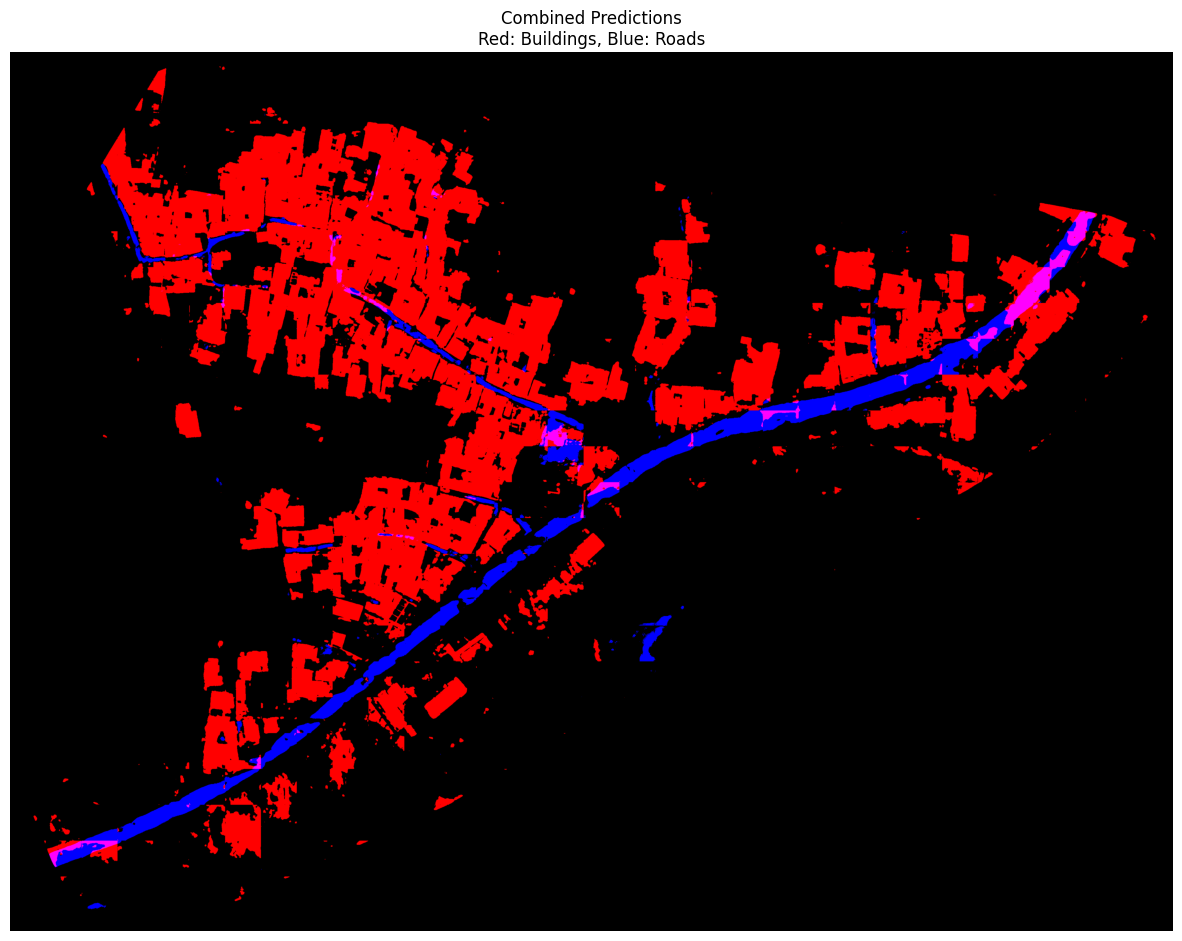


All steps completed successfully!


In [21]:
import cv2
# Generate combined prediction
print("\nStep 5: Generating combined prediction...")
combined_result = predict_and_combine(
    road_model, 
    building_model, 
    tiff_image_path, 
    device
)

# Visualize results
plt.figure(figsize=(15, 15))
plt.imshow(combined_result)
plt.title('Combined Predictions\nRed: Buildings, Blue: Roads')
plt.axis('off')
plt.savefig('/kaggle/working/combined_prediction_visualization.tiff')
plt.show()

print("\nAll steps completed successfully!")